<a href="https://colab.research.google.com/github/eduardoplima/rl-imd/blob/main/relatorio_aprendizado_reforco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizado por Reforço - Avaliação Final


O aprendizado por reforço é uma subárea da inteligência artificial que busca treinar agentes para tomar decisões em ambientes interativos com o objetivo de maximizar uma recompensa acumulada ao longo do tempo. Diferente de métodos supervisionados, onde há dados rotulados para guiar o aprendizado, no aprendizado por reforço o agente explora o ambiente por meio de tentativa e erro, ajustando suas ações com base no feedback recebido na forma de recompensas ou penalidades. Esse processo ocorre em um ciclo contínuo de interação, no qual o agente observa o estado do ambiente, toma uma ação, recebe uma recompensa e atualiza sua estratégia, aprendendo gradualmente a executar comportamentos que levam a melhores resultados.

Dentre os algoritmos mais conhecidos de aprendizado por reforço estão o SARSA e o Q-Learning, que utilizam a chamada tabela Q para armazenar e atualizar os valores associados a pares de estado e ação. O SARSA (State-Action-Reward-State-Action) é um algoritmo on-policy, o que significa que ele atualiza os valores Q com base na política atual, considerando a sequência de ações efetivamente escolhidas pelo agente. Já o Q-Learning é um método off-policy, onde a atualização dos valores Q se baseia na ação com maior recompensa esperada, independentemente da política seguida no momento. Enquanto o SARSA tende a ser mais conservador e adequado para cenários com riscos elevados, o Q-Learning é mais exploratório e busca estratégias otimizadas globalmente, sendo amplamente utilizado em diversas aplicações, como jogos, controle de sistemas e robótica.

Nesse notebook estão exemplos de aplicações com ambas as técnicas na biblioteca python Gymnasium. Os ambientes explorados são o `Frozen Lake`, onde o agente precisa alcançar um objetivo sem cair em buracos em um ambiente baseado em grade, e o `Cart Pole`, cujo objetivo é balancear um pêndulo invertido sobre um carrinho movendo-o para a esquerda ou direita.

## `Frozen Lake`

No `Frozen Lake`, o objetivo é atravessar um lago congelado do ponto S ao objetivo G sem cair em qualquer buraco H ao longo dos espaço F do território. Se a natureza do ambiente for escorregadia (`slippery`), o agente pode tomar direções não calculadas.

O agente recebe 1 vetor para suas ações. O espaço de ação é definido por `(dir)`, que define a direção a seguir a partir das opções:

* 0: ESQUERDA
* 1: ABAIXO
* 2: DIREITA
* 3: ACIMA

A observação é um valor que represente a posição atual do agente e é definido por `current_row * nrows + current_col`, ou seja, a linha atual vezes a quantidade de linhas mais a coluna atual.

As recompensas são definidas como:

* Objetivo(G): +1
* Buraco(H): 0
* Congelado(F): 0

### Configuração do ambiente

In [1]:
%%capture
!pip install gymnasium
!pip install numpy
!pip install imageio imageio_ffmpeg
!pip install pyvirtualdisplay
!apt-get install -y xvfb
!apt-get install -y python-opengl ffmpeg
!pip install pytorch

In [79]:
import torch

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import pandas as pd

In [80]:

from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [81]:
from gym.envs.toy_text.frozen_lake import generate_random_map

# Criação e inspeção do ambiente Frozen Lake.
side_map_size = 8
proba_frozen = 0.9

env = gym.make('FrozenLake-v1', is_slippery=False, render_mode="rgb_array", desc=generate_random_map(size=side_map_size, p=proba_frozen))
env.spec

EnvSpec(id='FrozenLake-v1', entry_point='gymnasium.envs.toy_text.frozen_lake:FrozenLakeEnv', reward_threshold=0.7, nondeterministic=False, max_episode_steps=100, order_enforce=True, disable_env_checker=False, kwargs={'map_name': '4x4', 'is_slippery': False, 'render_mode': 'rgb_array', 'desc': ['SHFHFFFF', 'FFFFHFFF', 'FHFFFFFF', 'FFFFFFFF', 'FFFFFFFH', 'HFFFFFFF', 'FHHFFFFF', 'FFFFFFFG']}, namespace=None, name='FrozenLake', version=1, additional_wrappers=(), vector_entry_point=None)

In [5]:
actions = ["move left", "move down", "move right", "move up"]
print ("Actions:", actions)

Actions: ['move left', 'move down', 'move right', 'move up']


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
def plot_image(plot, render, size):
  plot.figure(figsize=(14, 5))
  plot.xticks(range(size))
  plot.yticks(range(size))
  plot.imshow(render, extent=[0, size, size, 0])
  plot.show()

/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

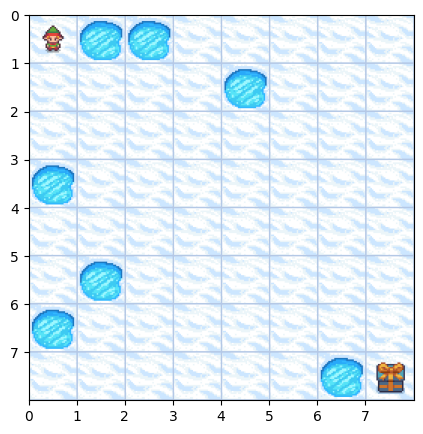

In [7]:
# This sets the initial state at S, our starting point
# We can render the environment to see where we are on the frozenlake gridworld
env.reset()
img = env.render()
plot_image(plt,img,int(np.sqrt(env.observation_space.n)))

Executamos ações aleatórias para testar o ambiente

In [8]:
print("passo número : ação, posição, recompensa, terminado, truncado, {info}")

for i in range(20):
    # Amostra aleatória de ação válida
    action = env.action_space.sample()

    state, reward, terminated, truncated, info = env.step(action)
    is_terminal = terminated or truncated

    print("passo", i+1, ":", action, ",", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
    if(is_terminal):
        break

passo número : ação, posição, recompensa, terminado, truncado, {info}
passo 1 : 0 , move left , 0 , 0.0 , False , False , {'prob': 1.0}
passo 2 : 3 , move up , 0 , 0.0 , False , False , {'prob': 1.0}
passo 3 : 1 , move down , 8 , 0.0 , False , False , {'prob': 1.0}
passo 4 : 0 , move left , 8 , 0.0 , False , False , {'prob': 1.0}
passo 5 : 0 , move left , 8 , 0.0 , False , False , {'prob': 1.0}
passo 6 : 1 , move down , 16 , 0.0 , False , False , {'prob': 1.0}
passo 7 : 3 , move up , 8 , 0.0 , False , False , {'prob': 1.0}
passo 8 : 0 , move left , 8 , 0.0 , False , False , {'prob': 1.0}
passo 9 : 1 , move down , 16 , 0.0 , False , False , {'prob': 1.0}
passo 10 : 1 , move down , 24 , 0.0 , True , False , {'prob': 1.0}


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder
before_training = "before_training.mp4"
video = VideoRecorder(env, before_training)

state, info = env.reset()
env.render()
video.capture_frame()

for i in range(100):
    action = env.action_space.sample()

    state, reward, terminated, truncated, info = env.step(action)
    is_terminal = terminated or truncated

    env.render()
    video.capture_frame()

    if(is_terminal):
        print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
        break

video.close()

/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 1 : move right , 1 , 0.0 , True , False , {'prob': 1.0}


In [10]:
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

from IPython.display import HTML
html = render_mp4(before_training)
HTML(html)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Criando uma estratégia SARSA ou Q-Learning tabular para o Frozen Lake

A classe a seguir

In [11]:
class FrozenLakeAgent:
    def __init__(
        self,
        alpha_learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        gamma_discount_factor: float,
        state_size: int,
        action_size: int,
        is_using_Sarsa: bool
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_table), a learning rate and an epsilon.

        Args:
            alpha_learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            gamma_discount_factor: The discount factor for computing the Q-value
            state_size: The state space
            action_size: The action space
            is_using_Sarsa: Sarsa or Q-learning method
        """
        self.alpha_learning_rate = alpha_learning_rate
        self.gamma_discount_factor = gamma_discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.state_size = state_size
        self.action_size = action_size
        self.is_using_Sarsa = is_using_Sarsa
        self.training_error = []
        self.q_table = np.zeros((self.state_size, self.action_size))

        if(self.is_using_Sarsa):
            print("Using Sarsa method")
        else:
            print("Using Q-learning method")

        # Set the seed
        self.rng = np.random.default_rng(100785)

    def get_Q_Table(self):
        return self.q_table

    def eval_state(self, state):
        # Break ties randomly
        # Find the indices where the Q-value equals the maximum value
        # Choose a random action from the indices where the Q-value is maximum
        max_ids = np.where(self.q_table[state, :] == np.max(self.q_table[state, :]))[0]
        return self.rng.choice(max_ids)

    def choose_action(self, state):
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # First we randomize a number
        exploration_exploitation_tradeoff = self.rng.uniform(0, 1)

        # Exploration
        # with probability epsilon return a random action to explore the environment
        if exploration_exploitation_tradeoff < self.epsilon:
            return env.action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return self.eval_state(state)

    def update(
        self,
        state: int,
        action: int,
        reward: float,
        terminated: bool,
        next_state: int,
        next_action: int
    ):
        """Updates the Q-value of an action."""
        if terminated:
            target = reward
        else:
            # Sarsa: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * Q(s',a') - Q(s,a)]
            if(self.is_using_Sarsa):
                target = reward + self.gamma_discount_factor * self.q_table[next_state, next_action]

            # Q-learning: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            else:
                target = reward + self.gamma_discount_factor * np.max(self.q_table[next_state, :])

        temporal_difference_error = target - self.q_table[state, action]

        # Train the agent using target and the predicted q_table values
        self.q_table[state, action] = self.q_table[state, action] + self.alpha_learning_rate * temporal_difference_error

        self.training_error.append(temporal_difference_error)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

In [74]:
def test_accurracy(agent, num_steps, num_episodes=100):
    counter = 0
    nb_success = 0.0

    while counter < num_episodes:
        is_terminal = False
        state, info = env.reset()

        for i in range(num_steps):
            action = agent.eval_state(state)
            state, reward, terminated, truncated, info = env.step(action)
            is_terminal = terminated or truncated
            nb_success += reward

            if(is_terminal):
                break

        counter += 1

    return nb_success/counter

In [75]:
def record_trained_video(agent, video_file, num_steps):
    video = VideoRecorder(env, video_file)

    # returns an initial observation
    state, info = env.reset()
    env.render()
    video.capture_frame()

    for i in range(num_steps):
        action = agent.eval_state(state)
        state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        env.render()
        video.capture_frame()

        if(is_terminal):
            print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
            break

    video.close()

In [76]:
def save_imgs(training_error, rewards, accuracies, steps, filename):
  rolling_length = 100
  fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
  axs[0].set_title("Training Reward")
  axs[0].set_xlabel('episode')
  axs[0].set_ylabel('reward')
  axs[0].bar(range(len(rewards)), rewards)

  axs[1].set_title("Test Reward")
  axs[1].set_xlabel('episode (x 50)')
  axs[1].set_ylabel('accuracy')
  axs[1].plot(range(len(accuracies)), accuracies)

  axs[2].set_title("Episode Length")
  axs[2].set_xlabel('episode')
  axs[2].set_ylabel('step')
  steps_moving_average = np.convolve(np.array(steps), np.ones(rolling_length), mode="same") / rolling_length
  axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

  axs[3].set_title("Training Error")
  axs[3].set_xlabel('step')
  axs[3].set_ylabel('error')
  training_error_moving_average = np.convolve(np.array(training_error), np.ones(rolling_length), mode="same") / rolling_length
  axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

  plt.tight_layout()
  plt.savefig(filename)
  plt.show()

In [93]:
from tqdm import tqdm
def train_agent(agent, is_using_Sarsa):
  #Create lists to contain total rewards, steps and accurracy per episode
  accuracies = []
  mean_rewards = []
  rewards = []
  steps = []
  total_steps = 0

  for episode_count in tqdm(range(nb_max_episodes)):
      state, info = env.reset()
      is_terminal = False
      total_reward = 0
      episode_step = 0

      if(is_using_Sarsa): # Sarsa
          # Choose an action by greedily (with epsilon chance of random action) from the Q-Table
          action = agent.choose_action(state)

      # The Q-Table training
      while not is_terminal:
          episode_step += 1

          if(not is_using_Sarsa): # Q-learning
              # Choose an action by greedily (with epsilon chance of random action) from the Q-Table
              action = agent.choose_action(state)

          # Play best or random move and get new state and reward from environment
          next_state, reward, terminated, truncated, info = env.step(action)
          is_terminal = terminated or truncated

          # update the agent
          if(not is_using_Sarsa): # Q-learning
              agent.update(state, action, reward, terminated, next_state, None)
          else: # Sarsa
              next_action = agent.choose_action(next_state)
              agent.update(state, action, reward, terminated, next_state, next_action)
              action = next_action

          # update the current observation
          state = next_state
          total_steps += 1
          total_reward += reward

      agent.decay_epsilon()

      mean_rewards.append(total_reward)
      if (episode_count+1) % test_freq == 0:
          accur = test_accurracy(agent, env.spec.max_episode_steps,50)
          accuracies.append(accur)

          print('step: %s, episode: %s, accuracy training: %s, accuracy test: %s, random move probability: %s' % (total_steps, episode_count+1, sum(mean_rewards)/test_freq, accur, agent.epsilon))
          mean_rewards.clear()

      rewards.append(total_reward)
      steps.append(episode_step)

  env.close()
  return after_training, rewards, steps, accuracies



In [78]:
# hyperparameters
alpha_learning_rate = 0.5 # @param {type:"number"}
nb_max_episodes = 10000 # @param {type:"integer"}
start_epsilon = 0.5 # @param {type:"number"}
final_epsilon = 0.1 # @param {type:"number"}
epsilon_decay = (start_epsilon - final_epsilon) / nb_max_episodes # reduce the exploration over time
gamma_discount_factor = 0.95 # @param {type:"number"}
is_using_Sarsa = False # @param {type:"boolean"}
test_freq = 100 # @param {type:"integer"}
total_steps = 0

agent_sarsa = FrozenLakeAgent(
    alpha_learning_rate=alpha_learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    gamma_discount_factor=gamma_discount_factor,
    state_size = env.observation_space.n,
    action_size = env.action_space.n,
    is_using_Sarsa = True
)

agent_q = FrozenLakeAgent(
    alpha_learning_rate=alpha_learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    gamma_discount_factor=gamma_discount_factor,
    state_size = env.observation_space.n,
    action_size = env.action_space.n,
    is_using_Sarsa = False
)


AttributeError: 'Box' object has no attribute 'n'

In [17]:
from itertools import product

In [18]:
alphas = [0.2, 0.5, 0.9]
epsilons = [0.2, 0.5, 0.9]
gammas = [0.2, 0.5, 0.9]

In [19]:
len(list(product(*[alphas, epsilons, gammas])))

27

In [20]:
df_experiments = pd.DataFrame(columns=['alpha', 'epsilon', 'gamma', 'accuracy', 'rewards', 'steps', 'error', 'agent'])

for alpha in alphas:
    for epsilon in epsilons:
        for gamma_discount_factor in gammas:
            print(f'Rodando alpha {alpha} e epsilon {epsilon}')
            agent_sarsa = FrozenLakeAgent(
                alpha_learning_rate=alpha,
                initial_epsilon=epsilon,
                epsilon_decay=epsilon_decay,
                final_epsilon=final_epsilon,
                gamma_discount_factor=gamma_discount_factor,
                state_size = env.observation_space.n,
                action_size = env.action_space.n,
                is_using_Sarsa = True
            )

            agent_q = FrozenLakeAgent(
                alpha_learning_rate=alpha,
                initial_epsilon=epsilon,
                epsilon_decay=epsilon_decay,
                final_epsilon=final_epsilon,
                gamma_discount_factor=gamma_discount_factor,
                state_size = env.observation_space.n,
                action_size = env.action_space.n,
                is_using_Sarsa = False
            )

            after_training_sarsa, rewards_sarsa, steps_sarsa, accuracies_sarsa = train_agent(agent_sarsa, True)
            error = agent_sarsa.training_error
            df_experiments = pd.concat([df_experiments, pd.DataFrame({'alpha': [alpha],
                                                                      'epsilon': [epsilon],
                                                                      'gamma': [gamma_discount_factor],
                                                                      'accuracy': [accuracies_sarsa],
                                                                      'rewards': [rewards_sarsa],
                                                                      'steps': [steps_sarsa],
                                                                      'error': [error],
                                                                      'agent': ['tabular_sarsa']})])
            after_training_q, rewards_q, steps_q, accuracies_q = train_agent(agent_q, False)
            error = agent_q.training_error
            df_experiments = pd.concat([df_experiments, pd.DataFrame({'alpha': [alpha],
                                                                      'epsilon': [epsilon],
                                                                      'gamma': [gamma_discount_factor],
                                                                      'accuracy': [accuracies_q],
                                                                      'rewards': [rewards_q],
                                                                      'steps': [steps_q],
                                                                      'error': [error],
                                                                      'agent': ['tabular_q']})])
            print(f'Len experiments {len(df_experiments)}')


Rodando alpha 0.2 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  2%|▏         | 161/10000 [00:00<00:23, 424.46it/s]

step: 723, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1959999999999988


  3%|▎         | 283/10000 [00:00<00:20, 464.48it/s]

step: 1255, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.19199999999999756


  4%|▍         | 400/10000 [00:00<00:23, 412.41it/s]

step: 1854, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.18799999999999634
step: 2353, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1839999999999951


  6%|▌         | 580/10000 [00:01<00:18, 520.26it/s]

step: 2967, episode: 500, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.1799999999999939


  7%|▋         | 684/10000 [00:01<00:20, 452.44it/s]

step: 3659, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.17599999999999266


  8%|▊         | 783/10000 [00:01<00:23, 398.92it/s]

step: 4481, episode: 700, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.17199999999999144


  9%|▉         | 900/10000 [00:02<00:21, 427.26it/s]

step: 4957, episode: 800, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1679999999999902
step: 5575, episode: 900, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.163999999999989


 11%|█         | 1059/10000 [00:02<00:20, 441.60it/s]

step: 6330, episode: 1000, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.15999999999998776


 11%|█▏        | 1144/10000 [00:02<00:23, 370.60it/s]

step: 6925, episode: 1100, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.15599999999998654
step: 7583, episode: 1200, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.1519999999999853


 14%|█▎        | 1373/10000 [00:03<00:16, 531.49it/s]

step: 8168, episode: 1300, accuracy training: 0.04, accuracy test: 0.04, random move probability: 0.1479999999999841
step: 8835, episode: 1400, accuracy training: 0.04, accuracy test: 0.08, random move probability: 0.14399999999998286


 16%|█▌        | 1552/10000 [00:03<00:20, 410.67it/s]

step: 10187, episode: 1500, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.13999999999998164


 16%|█▋        | 1641/10000 [00:03<00:26, 316.34it/s]

step: 11620, episode: 1600, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.13599999999998041


 18%|█▊        | 1798/10000 [00:04<00:22, 359.72it/s]

step: 13140, episode: 1700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1319999999999792


 19%|█▉        | 1875/10000 [00:04<00:26, 311.98it/s]

step: 14597, episode: 1800, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.12799999999997796


 20%|█▉        | 1952/10000 [00:04<00:24, 328.80it/s]

step: 16098, episode: 1900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1239999999999771


 21%|██        | 2086/10000 [00:05<00:20, 391.75it/s]

step: 17663, episode: 2000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.11999999999997726


 22%|██▏       | 2176/10000 [00:05<00:19, 392.54it/s]

step: 19198, episode: 2100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.11599999999997743


 23%|██▎       | 2254/10000 [00:05<00:25, 300.69it/s]

step: 20676, episode: 2200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.11199999999997759


 24%|██▎       | 2357/10000 [00:06<00:25, 294.33it/s]

step: 22113, episode: 2300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.10799999999997775


 25%|██▍       | 2472/10000 [00:06<00:19, 382.11it/s]

step: 23457, episode: 2400, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.10399999999997792
step: 24880, episode: 2500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 26%|██▋       | 2643/10000 [00:06<00:20, 363.94it/s]

step: 26260, episode: 2600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2758/10000 [00:07<00:24, 297.40it/s]

step: 27730, episode: 2700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 29%|██▊       | 2855/10000 [00:07<00:20, 347.75it/s]

step: 29202, episode: 2800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 29%|██▉       | 2934/10000 [00:07<00:24, 282.74it/s]

step: 30639, episode: 2900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 30%|███       | 3036/10000 [00:08<00:21, 328.82it/s]

step: 32092, episode: 3000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3160/10000 [00:08<00:16, 416.22it/s]

step: 33482, episode: 3100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3274/10000 [00:08<00:17, 380.50it/s]

step: 34940, episode: 3200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 36424, episode: 3300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 35%|███▍      | 3466/10000 [00:09<00:16, 400.07it/s]

step: 37909, episode: 3400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 36%|███▌      | 3567/10000 [00:09<00:16, 389.71it/s]

step: 39376, episode: 3500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3682/10000 [00:09<00:14, 449.52it/s]

step: 40881, episode: 3600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 42359, episode: 3700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3892/10000 [00:10<00:13, 464.07it/s]

step: 43794, episode: 3800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 40%|███▉      | 3982/10000 [00:10<00:17, 353.52it/s]

step: 45256, episode: 3900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4060/10000 [00:10<00:17, 342.60it/s]

step: 46741, episode: 4000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 42%|████▏     | 4197/10000 [00:11<00:15, 376.33it/s]

step: 48193, episode: 4100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 42%|████▏     | 4238/10000 [00:11<00:16, 342.46it/s]

step: 49676, episode: 4200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 44%|████▍     | 4384/10000 [00:11<00:13, 404.32it/s]

step: 51166, episode: 4300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 52611, episode: 4400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 45%|████▌     | 4547/10000 [00:12<00:14, 370.62it/s]

step: 54118, episode: 4500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 46%|████▋     | 4642/10000 [00:12<00:14, 377.86it/s]

step: 55598, episode: 4600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4734/10000 [00:12<00:18, 284.64it/s]

step: 57051, episode: 4700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4835/10000 [00:13<00:16, 313.92it/s]

step: 58517, episode: 4800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4930/10000 [00:13<00:23, 213.54it/s]

step: 59962, episode: 4900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 50%|█████     | 5049/10000 [00:14<00:23, 211.31it/s]

step: 61418, episode: 5000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 51%|█████▏    | 5127/10000 [00:14<00:21, 223.36it/s]

step: 62861, episode: 5100, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5215/10000 [00:15<00:29, 159.79it/s]

step: 64212, episode: 5200, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5328/10000 [00:15<00:35, 132.39it/s]

step: 65566, episode: 5300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1


 54%|█████▍    | 5429/10000 [00:16<00:36, 125.61it/s]

step: 66983, episode: 5400, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1


 56%|█████▌    | 5552/10000 [00:17<00:21, 209.58it/s]

step: 68419, episode: 5500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 56%|█████▋    | 5640/10000 [00:17<00:20, 208.02it/s]

step: 69893, episode: 5600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5736/10000 [00:18<00:25, 166.52it/s]

step: 71345, episode: 5700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 58%|█████▊    | 5812/10000 [00:18<00:18, 231.92it/s]

step: 72836, episode: 5800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5918/10000 [00:19<00:31, 130.01it/s]

step: 74352, episode: 5900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 60%|██████    | 6021/10000 [00:20<00:33, 120.41it/s]

step: 75833, episode: 6000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 61%|██████▏   | 6134/10000 [00:20<00:16, 229.12it/s]

step: 77339, episode: 6100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6272/10000 [00:21<00:12, 286.97it/s]

step: 78766, episode: 6200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6346/10000 [00:21<00:11, 308.01it/s]

step: 80228, episode: 6300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 64%|██████▍   | 6436/10000 [00:21<00:10, 329.82it/s]

step: 81578, episode: 6400, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1


 66%|██████▌   | 6570/10000 [00:22<00:11, 301.52it/s]

step: 83033, episode: 6500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 84494, episode: 6600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6901/10000 [00:22<00:04, 704.71it/s]

step: 85943, episode: 6700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 87402, episode: 6800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 88907, episode: 6900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7100/10000 [00:22<00:03, 831.66it/s]

step: 90347, episode: 7000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 91732, episode: 7100, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1


 74%|███████▍  | 7429/10000 [00:22<00:02, 986.83it/s]

step: 93177, episode: 7200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 94602, episode: 7300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 96020, episode: 7400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7663/10000 [00:23<00:02, 1076.17it/s]

step: 97477, episode: 7500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 98996, episode: 7600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 100448, episode: 7700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 80%|████████  | 8000/10000 [00:23<00:01, 1041.58it/s]

step: 101871, episode: 7800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 103282, episode: 7900, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1
step: 104713, episode: 8000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 82%|████████▏ | 8216/10000 [00:23<00:01, 982.73it/s] 

step: 106142, episode: 8100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 107612, episode: 8200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 84%|████████▍ | 8434/10000 [00:23<00:01, 1020.69it/s]

step: 109014, episode: 8300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1
step: 110403, episode: 8400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 111918, episode: 8500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8789/10000 [00:24<00:01, 1124.22it/s]

step: 113414, episode: 8600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 114852, episode: 8700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 116302, episode: 8800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 90%|█████████ | 9027/10000 [00:24<00:00, 1100.61it/s]

step: 117766, episode: 8900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 119223, episode: 9000, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 120647, episode: 9100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▎| 9370/10000 [00:24<00:00, 1076.84it/s]

step: 122140, episode: 9200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 123501, episode: 9300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1


 96%|█████████▌| 9600/10000 [00:24<00:00, 996.06it/s]

step: 124987, episode: 9400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 126506, episode: 9500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 127963, episode: 9600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 98%|█████████▊| 9833/10000 [00:25<00:00, 1081.77it/s]

step: 129435, episode: 9700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 130816, episode: 9800, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1
step: 132321, episode: 9900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:25<00:00, 394.78it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 133768, episode: 10000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


<ipython-input-20-57bc8376b70d>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_experiments = pd.concat([df_experiments, pd.DataFrame({'alpha': [alpha],


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  5%|▍         | 479/10000 [00:00<00:03, 2438.10it/s]

step: 950, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1959999999999988
step: 1565, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.19199999999999756
step: 2182, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.18799999999999634
step: 2753, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1839999999999951
step: 3382, episode: 500, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1799999999999939


 10%|▉         | 990/10000 [00:00<00:03, 2304.40it/s]

step: 4115, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.17599999999999266
step: 4691, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.17199999999999144
step: 5332, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1679999999999902
step: 5849, episode: 900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.163999999999989
step: 6448, episode: 1000, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.15999999999998776


 15%|█▍        | 1499/10000 [00:00<00:03, 2264.40it/s]

step: 7205, episode: 1100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.15599999999998654
step: 7837, episode: 1200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1519999999999853
step: 8410, episode: 1300, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.1479999999999841
step: 9061, episode: 1400, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.14399999999998286
step: 9647, episode: 1500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.13999999999998164


 20%|█▉        | 1986/10000 [00:00<00:03, 2202.91it/s]

step: 10231, episode: 1600, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.13599999999998041
step: 10759, episode: 1700, accuracy training: 0.01, accuracy test: 0.08, random move probability: 0.1319999999999792
step: 11424, episode: 1800, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.12799999999997796
step: 12034, episode: 1900, accuracy training: 0.03, accuracy test: 0.02, random move probability: 0.1239999999999771
step: 12553, episode: 2000, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.11999999999997726


 22%|██▏       | 2213/10000 [00:01<00:03, 1979.85it/s]

step: 13159, episode: 2100, accuracy training: 0.03, accuracy test: 0.04, random move probability: 0.11599999999997743
step: 14028, episode: 2200, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.11199999999997759
step: 15498, episode: 2300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.10799999999997775


 26%|██▌       | 2595/10000 [00:01<00:04, 1492.48it/s]

step: 16919, episode: 2400, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.10399999999997792
step: 18427, episode: 2500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 19871, episode: 2600, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1


 29%|██▉       | 2897/10000 [00:01<00:05, 1303.18it/s]

step: 21218, episode: 2700, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.1
step: 22665, episode: 2800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 24099, episode: 2900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3153/10000 [00:01<00:06, 1132.22it/s]

step: 25521, episode: 3000, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1
step: 26919, episode: 3100, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3389/10000 [00:02<00:06, 1088.76it/s]

step: 28337, episode: 3200, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1
step: 29794, episode: 3300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 31214, episode: 3400, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1


 36%|███▌      | 3599/10000 [00:02<00:07, 871.08it/s]

step: 32660, episode: 3500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 34117, episode: 3600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3769/10000 [00:02<00:09, 653.52it/s]

step: 35537, episode: 3700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 37018, episode: 3800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 40%|███▉      | 3964/10000 [00:03<00:10, 575.81it/s]

step: 38451, episode: 3900, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 39933, episode: 4000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 42%|████▏     | 4178/10000 [00:03<00:09, 590.01it/s]

step: 41383, episode: 4100, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 42795, episode: 4200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 44%|████▎     | 4372/10000 [00:03<00:10, 560.61it/s]

step: 44208, episode: 4300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 45656, episode: 4400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 46%|████▌     | 4590/10000 [00:04<00:08, 607.93it/s]

step: 47090, episode: 4500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 48484, episode: 4600, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4785/10000 [00:04<00:08, 584.89it/s]

step: 49827, episode: 4700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4900/10000 [00:04<00:10, 486.10it/s]

step: 51235, episode: 4800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 52698, episode: 4900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5090/10000 [00:05<00:09, 542.49it/s]

step: 54114, episode: 5000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 55424, episode: 5100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5263/10000 [00:05<00:09, 523.25it/s]

step: 56771, episode: 5200, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1


 54%|█████▍    | 5392/10000 [00:05<00:08, 550.79it/s]

step: 58222, episode: 5300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5501/10000 [00:06<00:09, 475.75it/s]

step: 59648, episode: 5400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 61073, episode: 5500, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5690/10000 [00:06<00:07, 547.64it/s]

step: 62450, episode: 5600, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1
step: 63834, episode: 5700, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1


 59%|█████▊    | 5870/10000 [00:06<00:07, 532.52it/s]

step: 65183, episode: 5800, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1
step: 66627, episode: 5900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 61%|██████▏   | 6135/10000 [00:07<00:06, 596.77it/s]

step: 68058, episode: 6000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 69499, episode: 6100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6332/10000 [00:07<00:04, 771.66it/s]

step: 70852, episode: 6200, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1
step: 72245, episode: 6300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 73680, episode: 6400, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 66%|██████▌   | 6622/10000 [00:07<00:03, 888.41it/s]

step: 75094, episode: 6500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 76556, episode: 6600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 77942, episode: 6700, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1


 70%|██████▉   | 6950/10000 [00:08<00:02, 1023.41it/s]

step: 79336, episode: 6800, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 80814, episode: 6900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 82241, episode: 7000, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7265/10000 [00:08<00:02, 1019.87it/s]

step: 83671, episode: 7100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 85075, episode: 7200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 86471, episode: 7300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1


 76%|███████▌  | 7587/10000 [00:08<00:02, 976.53it/s] 

step: 87877, episode: 7400, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1
step: 89277, episode: 7500, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 78%|███████▊  | 7784/10000 [00:08<00:02, 921.24it/s]

step: 90650, episode: 7600, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1
step: 92067, episode: 7700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 80%|████████  | 8000/10000 [00:09<00:02, 944.66it/s]

step: 93489, episode: 7800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 94881, episode: 7900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 96299, episode: 8000, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1


 82%|████████▏ | 8205/10000 [00:09<00:01, 952.90it/s]

step: 97759, episode: 8100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 99130, episode: 8200, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1
step: 100517, episode: 8300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1


 85%|████████▌ | 8512/10000 [00:09<00:01, 972.11it/s]

step: 101954, episode: 8400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 103381, episode: 8500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8722/10000 [00:09<00:01, 1002.20it/s]

step: 104675, episode: 8600, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.1
step: 106094, episode: 8700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 107490, episode: 8800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 90%|█████████ | 9050/10000 [00:10<00:00, 1069.77it/s]

step: 108912, episode: 8900, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 110297, episode: 9000, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1
step: 111685, episode: 9100, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▍| 9376/10000 [00:10<00:00, 1057.22it/s]

step: 113078, episode: 9200, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1
step: 114422, episode: 9300, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.1
step: 115782, episode: 9400, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9688/10000 [00:10<00:00, 986.76it/s]

step: 117232, episode: 9500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 118606, episode: 9600, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9900/10000 [00:11<00:00, 972.74it/s]

step: 120057, episode: 9700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 121481, episode: 9800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 122949, episode: 9900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:11<00:00, 893.23it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 124433, episode: 10000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 2
Rodando alpha 0.2 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  0%|          | 0/10000 [00:00<?, ?it/s]

step: 691, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1959999999999988


  5%|▍         | 471/10000 [00:00<00:04, 2347.26it/s]

step: 1390, episode: 200, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.19199999999999756
step: 1972, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.18799999999999634
step: 2510, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1839999999999951
step: 3094, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1799999999999939
step: 3779, episode: 600, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.17599999999999266


 10%|▉         | 964/10000 [00:00<00:03, 2278.94it/s]

step: 4384, episode: 700, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.17199999999999144
step: 4936, episode: 800, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.1679999999999902
step: 5620, episode: 900, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.163999999999989
step: 6312, episode: 1000, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.15999999999998776
step: 6834, episode: 1100, accuracy training: 0.02, accuracy test: 0.06, random move probability: 0.15599999999998654


 14%|█▍        | 1419/10000 [00:00<00:05, 1592.09it/s]

step: 8099, episode: 1200, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.1519999999999853
step: 9586, episode: 1300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1479999999999841
step: 10985, episode: 1400, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.14399999999998286


 16%|█▌        | 1601/10000 [00:00<00:05, 1410.79it/s]

step: 12423, episode: 1500, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.13999999999998164
step: 13930, episode: 1600, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.13599999999998041


 19%|█▉        | 1898/10000 [00:01<00:06, 1244.99it/s]

step: 15342, episode: 1700, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1319999999999792
step: 16786, episode: 1800, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.12799999999997796
step: 18240, episode: 1900, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1239999999999771


 22%|██▏       | 2151/10000 [00:01<00:06, 1151.17it/s]

step: 19758, episode: 2000, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.11999999999997726
step: 21241, episode: 2100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.11599999999997743
step: 22739, episode: 2200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.11199999999997759


 24%|██▍       | 2388/10000 [00:01<00:06, 1142.01it/s]

step: 24163, episode: 2300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.10799999999997775
step: 25695, episode: 2400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.10399999999997792
step: 27160, episode: 2500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 27%|██▋       | 2717/10000 [00:02<00:07, 1008.50it/s]

step: 28598, episode: 2600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 30099, episode: 2700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 31558, episode: 2800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 31%|███       | 3056/10000 [00:02<00:06, 1095.18it/s]

step: 32989, episode: 2900, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 34442, episode: 3000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 35847, episode: 3100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3400/10000 [00:02<00:06, 1068.83it/s]

step: 37317, episode: 3200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 38801, episode: 3300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 40223, episode: 3400, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 36%|███▌      | 3612/10000 [00:02<00:06, 994.52it/s] 

step: 41739, episode: 3500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 43150, episode: 3600, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1
step: 44567, episode: 3700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3936/10000 [00:03<00:05, 1046.47it/s]

step: 46061, episode: 3800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 47470, episode: 3900, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1
step: 48945, episode: 4000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4273/10000 [00:03<00:05, 1095.40it/s]

step: 50339, episode: 4100, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1
step: 51793, episode: 4200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 53305, episode: 4300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 46%|████▌     | 4605/10000 [00:03<00:05, 1033.80it/s]

step: 54765, episode: 4400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 56284, episode: 4500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 57734, episode: 4600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4810/10000 [00:04<00:05, 951.99it/s]

step: 59164, episode: 4700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 60654, episode: 4800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 50%|█████     | 5027/10000 [00:04<00:04, 1009.84it/s]

step: 62105, episode: 4900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 63481, episode: 5000, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1
step: 64948, episode: 5100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 54%|█████▍    | 5383/10000 [00:04<00:04, 1133.96it/s]

step: 66444, episode: 5200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 67866, episode: 5300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 69266, episode: 5400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5715/10000 [00:04<00:04, 1040.26it/s]

step: 70720, episode: 5500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 72195, episode: 5600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 73662, episode: 5700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5929/10000 [00:05<00:03, 1019.35it/s]

step: 75153, episode: 5800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 76633, episode: 5900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 78050, episode: 6000, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6265/10000 [00:05<00:03, 1091.68it/s]

step: 79562, episode: 6100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 81027, episode: 6200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 82513, episode: 6300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 65%|██████▍   | 6479/10000 [00:05<00:04, 820.61it/s] 

step: 83929, episode: 6400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 85448, episode: 6500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6712/10000 [00:06<00:05, 579.05it/s]

step: 86878, episode: 6600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 88300, episode: 6700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6887/10000 [00:06<00:04, 645.93it/s]

step: 89716, episode: 6800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 91130, episode: 6900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7100/10000 [00:06<00:04, 580.05it/s]

step: 92576, episode: 7000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 94032, episode: 7100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7300/10000 [00:07<00:04, 543.86it/s]

step: 95435, episode: 7200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 96911, episode: 7300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 75%|███████▌  | 7501/10000 [00:07<00:04, 572.40it/s]

step: 98307, episode: 7400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 99763, episode: 7500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7712/10000 [00:07<00:04, 565.15it/s]

step: 101278, episode: 7600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 102750, episode: 7700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7900/10000 [00:08<00:04, 505.83it/s]

step: 104234, episode: 7800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 105687, episode: 7900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8100/10000 [00:08<00:03, 529.84it/s]

step: 107139, episode: 8000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 108539, episode: 8100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8291/10000 [00:08<00:03, 548.07it/s]

step: 110012, episode: 8200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8348/10000 [00:09<00:03, 494.05it/s]

step: 111435, episode: 8300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 85%|████████▍ | 8481/10000 [00:09<00:02, 543.77it/s]

step: 112897, episode: 8400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 114271, episode: 8500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8675/10000 [00:09<00:02, 562.63it/s]

step: 115706, episode: 8600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 117185, episode: 8700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 89%|████████▊ | 8870/10000 [00:10<00:02, 525.25it/s]

step: 118624, episode: 8800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 90%|█████████ | 9000/10000 [00:10<00:01, 519.96it/s]

step: 120101, episode: 8900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 121565, episode: 9000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9218/10000 [00:10<00:01, 775.94it/s]

step: 123035, episode: 9100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 124515, episode: 9200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 125969, episode: 9300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▌| 9548/10000 [00:10<00:00, 971.68it/s]

step: 127498, episode: 9400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 128972, episode: 9500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 130426, episode: 9600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9886/10000 [00:11<00:00, 1064.90it/s]

step: 131859, episode: 9700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 133216, episode: 9800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 134599, episode: 9900, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:11<00:00, 879.51it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 136058, episode: 10000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  0%|          | 0/10000 [00:00<?, ?it/s]

step: 718, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1959999999999988


  4%|▍         | 441/10000 [00:00<00:04, 2210.10it/s]

step: 1312, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.19199999999999756
step: 1883, episode: 300, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.18799999999999634
step: 2448, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1839999999999951
step: 3091, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1799999999999939
step: 3740, episode: 600, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.17599999999999266


  9%|▊         | 871/10000 [00:00<00:04, 1998.31it/s]

step: 4411, episode: 700, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.17199999999999144
step: 5087, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1679999999999902
step: 5632, episode: 900, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.163999999999989


 11%|█         | 1100/10000 [00:00<00:04, 2041.18it/s]

step: 6202, episode: 1000, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.15999999999998776
step: 6890, episode: 1100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.15599999999998654


 13%|█▎        | 1336/10000 [00:00<00:04, 2142.47it/s]

step: 7467, episode: 1200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1519999999999853
step: 8127, episode: 1300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1479999999999841
step: 8748, episode: 1400, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.14399999999998286


 16%|█▌        | 1552/10000 [00:00<00:03, 2146.05it/s]

step: 9360, episode: 1500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.13999999999998164
step: 10070, episode: 1600, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.13599999999998041


 18%|█▊        | 1768/10000 [00:00<00:04, 1981.25it/s]

step: 10654, episode: 1700, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.1319999999999792
step: 11402, episode: 1800, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.12799999999997796


 20%|█▉        | 1969/10000 [00:00<00:04, 1937.13it/s]

step: 12064, episode: 1900, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.1239999999999771
step: 12600, episode: 2000, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.11999999999997726


 22%|██▏       | 2200/10000 [00:01<00:03, 2037.35it/s]

step: 13214, episode: 2100, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.11599999999997743
step: 13841, episode: 2200, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.11199999999997759
step: 14397, episode: 2300, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.10799999999997775


 24%|██▍       | 2406/10000 [00:01<00:03, 1977.03it/s]

step: 14882, episode: 2400, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.10399999999997792


 26%|██▌       | 2606/10000 [00:01<00:04, 1718.22it/s]

step: 15494, episode: 2500, accuracy training: 0.04, accuracy test: 0.18, random move probability: 0.1
step: 16896, episode: 2600, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2785/10000 [00:01<00:04, 1465.46it/s]

step: 18409, episode: 2700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 19950, episode: 2800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 21401, episode: 2900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3210/10000 [00:01<00:05, 1148.40it/s]

step: 22926, episode: 3000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 24517, episode: 3100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 26050, episode: 3200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3439/10000 [00:02<00:06, 1021.25it/s]

step: 27565, episode: 3300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 29137, episode: 3400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 36%|███▋      | 3643/10000 [00:02<00:06, 953.49it/s]

step: 30659, episode: 3500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 32213, episode: 3600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 39%|███▊      | 3862/10000 [00:02<00:06, 1001.71it/s]

step: 33702, episode: 3700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 35099, episode: 3800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 36577, episode: 3900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 42%|████▏     | 4183/10000 [00:02<00:05, 1023.97it/s]

step: 38066, episode: 4000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 39605, episode: 4100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 44%|████▍     | 4383/10000 [00:03<00:06, 935.88it/s]

step: 41060, episode: 4200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 42508, episode: 4300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 46%|████▌     | 4578/10000 [00:03<00:05, 945.56it/s]

step: 43967, episode: 4400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 45440, episode: 4500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 46917, episode: 4600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4884/10000 [00:03<00:05, 981.47it/s]

step: 48416, episode: 4700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 49928, episode: 4800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 51422, episode: 4900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5195/10000 [00:04<00:04, 1021.62it/s]

step: 52959, episode: 5000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 54396, episode: 5100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 55822, episode: 5200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5503/10000 [00:04<00:04, 951.00it/s]

step: 57270, episode: 5300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 58795, episode: 5400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 60184, episode: 5500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5700/10000 [00:04<00:04, 932.74it/s]

step: 61669, episode: 5600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 63106, episode: 5700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5904/10000 [00:04<00:04, 971.97it/s]

step: 64539, episode: 5800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 66034, episode: 5900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 67497, episode: 6000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 62%|██████▏   | 6207/10000 [00:05<00:03, 992.80it/s]

step: 69045, episode: 6100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 70511, episode: 6200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 64%|██████▍   | 6410/10000 [00:05<00:03, 963.67it/s]

step: 72004, episode: 6300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 73508, episode: 6400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 74985, episode: 6500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6716/10000 [00:05<00:03, 972.30it/s]

step: 76438, episode: 6600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 77863, episode: 6700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 79260, episode: 6800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 70%|███████   | 7040/10000 [00:05<00:02, 1013.17it/s]

step: 80768, episode: 6900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 82207, episode: 7000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 83692, episode: 7100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7349/10000 [00:06<00:02, 950.54it/s]

step: 85102, episode: 7200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 86553, episode: 7300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 88012, episode: 7400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7652/10000 [00:06<00:02, 983.03it/s]

step: 89495, episode: 7500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 90901, episode: 7600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 79%|███████▊  | 7853/10000 [00:06<00:02, 956.88it/s]

step: 92392, episode: 7700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 93841, episode: 7800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 95325, episode: 7900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 81%|████████▏ | 8149/10000 [00:07<00:01, 947.50it/s]

step: 96799, episode: 8000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 98295, episode: 8100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8341/10000 [00:07<00:01, 936.35it/s]

step: 99677, episode: 8200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 101178, episode: 8300, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 85%|████████▌ | 8549/10000 [00:07<00:01, 976.21it/s]

step: 102681, episode: 8400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 104124, episode: 8500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 105459, episode: 8600, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1


 89%|████████▊ | 8862/10000 [00:07<00:01, 998.09it/s]

step: 106949, episode: 8700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 108359, episode: 8800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 109740, episode: 8900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9159/10000 [00:08<00:00, 920.63it/s]

step: 111195, episode: 9000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 112689, episode: 9100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9346/10000 [00:08<00:00, 900.29it/s]

step: 114140, episode: 9200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 115650, episode: 9300, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▍| 9441/10000 [00:08<00:00, 914.37it/s]

step: 117174, episode: 9400, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 118680, episode: 9500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9684/10000 [00:08<00:00, 658.34it/s]

step: 120132, episode: 9600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 121564, episode: 9700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9897/10000 [00:09<00:00, 608.46it/s]

step: 123037, episode: 9800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 124480, episode: 9900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:09<00:00, 1044.44it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 125961, episode: 10000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 4
Rodando alpha 0.2 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  1%|▏         | 132/10000 [00:00<00:07, 1303.62it/s]

step: 614, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1959999999999988
step: 1222, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.19199999999999756


  3%|▎         | 273/10000 [00:00<00:07, 1362.53it/s]

step: 1827, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.18799999999999634


  5%|▌         | 537/10000 [00:00<00:07, 1206.30it/s]

step: 2410, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1839999999999951
step: 3075, episode: 500, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.1799999999999939
step: 3633, episode: 600, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.17599999999999266


  8%|▊         | 796/10000 [00:00<00:07, 1191.41it/s]

step: 4261, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.17199999999999144
step: 4857, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1679999999999902
step: 5633, episode: 900, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.163999999999989


 10%|█         | 1041/10000 [00:00<00:08, 1076.94it/s]

step: 6412, episode: 1000, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.15999999999998776
step: 7096, episode: 1100, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.15599999999998654


 12%|█▏        | 1153/10000 [00:01<00:08, 1058.09it/s]

step: 7813, episode: 1200, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.1519999999999853


 14%|█▍        | 1376/10000 [00:01<00:07, 1084.25it/s]

step: 8464, episode: 1300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1479999999999841
step: 9102, episode: 1400, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.14399999999998286


 15%|█▌        | 1500/10000 [00:01<00:08, 1056.47it/s]

step: 9619, episode: 1500, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.13999999999998164


 16%|█▌        | 1607/10000 [00:01<00:08, 1004.40it/s]

step: 10300, episode: 1600, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.13599999999998041


 17%|█▋        | 1719/10000 [00:01<00:08, 1033.30it/s]

step: 10924, episode: 1700, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.1319999999999792


 18%|█▊        | 1824/10000 [00:01<00:08, 997.75it/s] 

step: 11497, episode: 1800, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.12799999999997796


 19%|█▉        | 1925/10000 [00:01<00:08, 962.84it/s]

step: 12223, episode: 1900, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.1239999999999771
step: 12807, episode: 2000, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.11999999999997726

 20%|██        | 2040/10000 [00:01<00:07, 1014.29it/s]


step: 13532, episode: 2100, accuracy training: 0.03, accuracy test: 0.04, random move probability: 0.11599999999997743


 21%|██▏       | 2143/10000 [00:02<00:07, 1002.35it/s]

step: 14136, episode: 2200, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.11199999999997759


 24%|██▎       | 2374/10000 [00:02<00:07, 1016.53it/s]

step: 14728, episode: 2300, accuracy training: 0.03, accuracy test: 0.14, random move probability: 0.10799999999997775
step: 15883, episode: 2400, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.10399999999997792


 25%|██▍       | 2477/10000 [00:02<00:09, 805.98it/s] 

step: 17387, episode: 2500, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 26%|██▋       | 2641/10000 [00:02<00:12, 601.51it/s]

step: 18912, episode: 2600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 20427, episode: 2700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 30%|██▉       | 2957/10000 [00:03<00:10, 693.91it/s]

step: 21899, episode: 2800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 23383, episode: 2900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 24884, episode: 3000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3295/10000 [00:03<00:06, 959.75it/s]

step: 26429, episode: 3100, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 27866, episode: 3200, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 29303, episode: 3300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 36%|███▌      | 3605/10000 [00:03<00:06, 937.61it/s]

step: 30738, episode: 3400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 32160, episode: 3500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 33646, episode: 3600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3812/10000 [00:04<00:06, 985.66it/s]

step: 35119, episode: 3700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 36629, episode: 3800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 38174, episode: 3900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 41%|████▏     | 4148/10000 [00:04<00:05, 1053.89it/s]

step: 39697, episode: 4000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 41174, episode: 4100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 42675, episode: 4200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 45%|████▍     | 4454/10000 [00:04<00:05, 945.44it/s]

step: 44207, episode: 4300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 45732, episode: 4400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4658/10000 [00:04<00:05, 961.13it/s]

step: 47199, episode: 4500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 48709, episode: 4600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 50155, episode: 4700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 50%|████▉     | 4992/10000 [00:05<00:04, 1059.39it/s]

step: 51668, episode: 4800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 53193, episode: 4900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 54700, episode: 5000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5318/10000 [00:05<00:04, 1000.01it/s]

step: 56198, episode: 5100, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 57726, episode: 5200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 59214, episode: 5300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5519/10000 [00:05<00:04, 933.78it/s]

step: 60697, episode: 5400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 62200, episode: 5500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 63786, episode: 5600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 58%|█████▊    | 5848/10000 [00:06<00:03, 1041.26it/s]

step: 65285, episode: 5700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 66777, episode: 5800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 68241, episode: 5900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 62%|██████▏   | 6173/10000 [00:06<00:03, 1066.24it/s]

step: 69813, episode: 6000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 71355, episode: 6100, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 72899, episode: 6200, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 65%|██████▍   | 6489/10000 [00:06<00:03, 945.27it/s]

step: 74389, episode: 6300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 75888, episode: 6400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6684/10000 [00:07<00:03, 956.13it/s]

step: 77342, episode: 6500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 78877, episode: 6600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6897/10000 [00:07<00:03, 1011.62it/s]

step: 80417, episode: 6700, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1
step: 81949, episode: 6800, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 83421, episode: 6900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7117/10000 [00:07<00:02, 1021.95it/s]

step: 84909, episode: 7000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 86420, episode: 7100, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 87884, episode: 7200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 74%|███████▍  | 7428/10000 [00:07<00:02, 969.47it/s] 

step: 89376, episode: 7300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 90884, episode: 7400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 76%|███████▋  | 7636/10000 [00:07<00:02, 984.21it/s]

step: 92318, episode: 7500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 93819, episode: 7600, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 95283, episode: 7700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 80%|███████▉  | 7969/10000 [00:08<00:01, 1071.94it/s]

step: 96759, episode: 7800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 98230, episode: 7900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 99651, episode: 8000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8289/10000 [00:08<00:01, 1040.00it/s]

step: 101157, episode: 8100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 102686, episode: 8200, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 104238, episode: 8300, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 86%|████████▌ | 8590/10000 [00:08<00:01, 947.41it/s]

step: 105698, episode: 8400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 107181, episode: 8500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8800/10000 [00:09<00:01, 950.90it/s]

step: 108681, episode: 8600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 110211, episode: 8700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 111670, episode: 8800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 90%|█████████ | 9014/10000 [00:09<00:00, 1006.44it/s]

step: 113214, episode: 8900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 114662, episode: 9000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 116165, episode: 9100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9349/10000 [00:09<00:00, 1058.40it/s]

step: 117628, episode: 9200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 119199, episode: 9300, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1


 96%|█████████▌| 9557/10000 [00:09<00:00, 949.42it/s]

step: 120667, episode: 9400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 122111, episode: 9500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 98%|█████████▊| 9774/10000 [00:10<00:00, 1020.97it/s]

step: 123597, episode: 9600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 125033, episode: 9700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 126527, episode: 9800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:10<00:00, 967.99it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 127995, episode: 9900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 129501, episode: 10000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  0%|          | 0/10000 [00:00<?, ?it/s]

step: 559, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1959999999999988


  4%|▍         | 411/10000 [00:00<00:04, 2042.33it/s]

step: 1101, episode: 200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.19199999999999756
step: 1741, episode: 300, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.18799999999999634
step: 2380, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1839999999999951
step: 3136, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1799999999999939
step: 3626, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.17599999999999266


  9%|▉         | 895/10000 [00:00<00:03, 2301.91it/s]

step: 4265, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.17199999999999144
step: 4825, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1679999999999902
step: 5334, episode: 900, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.163999999999989
step: 5854, episode: 1000, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.15999999999998776


 11%|█▏        | 1126/10000 [00:00<00:03, 2228.02it/s]

step: 6502, episode: 1100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.15599999999998654


 14%|█▎        | 1350/10000 [00:00<00:04, 2067.23it/s]

step: 7303, episode: 1200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1519999999999853
step: 7919, episode: 1300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1479999999999841
step: 8651, episode: 1400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.14399999999998286


 16%|█▌        | 1559/10000 [00:00<00:04, 2036.20it/s]

step: 9212, episode: 1500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.13999999999998164


 18%|█▊        | 1764/10000 [00:00<00:04, 2000.17it/s]

step: 9719, episode: 1600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.13599999999998041
step: 10302, episode: 1700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1319999999999792
step: 10952, episode: 1800, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.12799999999997796
step: 11630, episode: 1900, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.1239999999999771


 24%|██▍       | 2400/10000 [00:01<00:03, 1972.56it/s]

step: 12228, episode: 2000, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.11999999999997726
step: 12906, episode: 2100, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.11599999999997743
step: 13498, episode: 2200, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.11199999999997759
step: 14078, episode: 2300, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.10799999999997775
step: 14577, episode: 2400, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.10399999999997792


 28%|██▊       | 2800/10000 [00:01<00:03, 1953.36it/s]

step: 15166, episode: 2500, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.1
step: 15771, episode: 2600, accuracy training: 0.03, accuracy test: 0.02, random move probability: 0.1
step: 16361, episode: 2700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1
step: 16995, episode: 2800, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.1
step: 17611, episode: 2900, accuracy training: 0.05, accuracy test: 0.08, random move probability: 0.1


 32%|███▏      | 3185/10000 [00:01<00:04, 1532.39it/s]

step: 18910, episode: 3000, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.1
step: 20352, episode: 3100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 21808, episode: 3200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 35%|███▍      | 3489/10000 [00:01<00:05, 1254.60it/s]

step: 23357, episode: 3300, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 24876, episode: 3400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 26334, episode: 3500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3743/10000 [00:02<00:05, 1097.96it/s]

step: 27846, episode: 3600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 29322, episode: 3700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 39%|███▊      | 3859/10000 [00:02<00:06, 913.20it/s] 

step: 30774, episode: 3800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 32244, episode: 3900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 40%|████      | 4044/10000 [00:02<00:08, 702.30it/s]

step: 33699, episode: 4000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 42%|████▏     | 4195/10000 [00:03<00:08, 651.82it/s]

step: 35171, episode: 4100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 36634, episode: 4200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 44%|████▍     | 4398/10000 [00:03<00:09, 588.42it/s]

step: 38179, episode: 4300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 39657, episode: 4400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 46%|████▌     | 4593/10000 [00:03<00:09, 584.55it/s]

step: 41119, episode: 4500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 42578, episode: 4600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4788/10000 [00:04<00:08, 593.01it/s]

step: 44015, episode: 4700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 45509, episode: 4800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 50%|████▉     | 4987/10000 [00:04<00:08, 581.94it/s]

step: 46958, episode: 4900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 48489, episode: 5000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5165/10000 [00:04<00:09, 536.38it/s]

step: 50031, episode: 5100, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5291/10000 [00:05<00:08, 541.64it/s]

step: 51456, episode: 5200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 52908, episode: 5300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 55%|█████▍    | 5468/10000 [00:05<00:09, 503.24it/s]

step: 54434, episode: 5400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 56%|█████▌    | 5582/10000 [00:05<00:08, 495.48it/s]

step: 55898, episode: 5500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5696/10000 [00:06<00:08, 485.34it/s]

step: 57389, episode: 5600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5748/10000 [00:06<00:09, 454.41it/s]

step: 58912, episode: 5700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 59%|█████▊    | 5867/10000 [00:06<00:08, 485.91it/s]

step: 60422, episode: 5800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 60%|█████▉    | 5990/10000 [00:06<00:07, 514.78it/s]

step: 61863, episode: 5900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 63344, episode: 6000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 62%|██████▏   | 6171/10000 [00:07<00:07, 505.70it/s]

step: 64845, episode: 6100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 66255, episode: 6200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 64%|██████▍   | 6406/10000 [00:07<00:05, 673.15it/s]

step: 67773, episode: 6300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 69223, episode: 6400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 66%|██████▌   | 6608/10000 [00:07<00:04, 816.62it/s]

step: 70768, episode: 6500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 72186, episode: 6600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 73712, episode: 6700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6900/10000 [00:07<00:03, 880.05it/s]

step: 75261, episode: 6800, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 76771, episode: 6900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 78230, episode: 7000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 72%|███████▏  | 7217/10000 [00:08<00:02, 977.97it/s]

step: 79673, episode: 7100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 81077, episode: 7200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 82603, episode: 7300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 75%|███████▌  | 7514/10000 [00:08<00:02, 957.63it/s]

step: 84105, episode: 7400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 85558, episode: 7500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7719/10000 [00:08<00:02, 984.88it/s]

step: 87044, episode: 7600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 88504, episode: 7700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7911/10000 [00:08<00:02, 913.49it/s]

step: 90031, episode: 7800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 91578, episode: 7900, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8111/10000 [00:09<00:01, 956.45it/s]

step: 93075, episode: 8000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 94579, episode: 8100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 96071, episode: 8200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 84%|████████▍ | 8412/10000 [00:09<00:01, 947.71it/s]

step: 97560, episode: 8300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 98967, episode: 8400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 86%|████████▌ | 8604/10000 [00:09<00:01, 852.00it/s]

step: 100464, episode: 8500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 101961, episode: 8600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8800/10000 [00:09<00:01, 874.42it/s]

step: 103435, episode: 8700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 104918, episode: 8800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 91%|█████████ | 9103/10000 [00:10<00:00, 955.88it/s]

step: 106346, episode: 8900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 107874, episode: 9000, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 109345, episode: 9100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9315/10000 [00:10<00:00, 1014.24it/s]

step: 110791, episode: 9200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 112250, episode: 9300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▌| 9513/10000 [00:10<00:00, 878.31it/s]

step: 113756, episode: 9400, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1
step: 115219, episode: 9500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9700/10000 [00:10<00:00, 873.45it/s]

step: 116682, episode: 9600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 118244, episode: 9700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:11<00:00, 892.02it/s]

step: 119720, episode: 9800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 121187, episode: 9900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 122642, episode: 10000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 6
Rodando alpha 0.2 e epsilon 0.5
Using Sarsa method
Using Q-learning method


  0%|          | 0/10000 [00:00<?, ?it/s]

step: 684, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.49600000000000155


  5%|▍         | 455/10000 [00:00<00:04, 2306.82it/s]

step: 1468, episode: 200, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.4920000000000031
step: 2038, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.48800000000000465
step: 2588, episode: 400, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4840000000000062
step: 3288, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.48000000000000775


  7%|▋         | 686/10000 [00:00<00:04, 2255.04it/s]

step: 4083, episode: 600, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.4760000000000093


  9%|▉         | 912/10000 [00:00<00:04, 2111.92it/s]

step: 4841, episode: 700, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.47200000000001086
step: 5641, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4680000000000124
step: 6446, episode: 900, accuracy training: 0.03, accuracy test: 0.02, random move probability: 0.46400000000001396
step: 7095, episode: 1000, accuracy training: 0.02, accuracy test: 0.1, random move probability: 0.4600000000000155
step: 8172, episode: 1100, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.45600000000001706


 13%|█▎        | 1320/10000 [00:00<00:05, 1634.22it/s]

step: 9783, episode: 1200, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.4520000000000186
step: 11248, episode: 1300, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.44800000000002016


 16%|█▋        | 1640/10000 [00:01<00:06, 1321.40it/s]

step: 13044, episode: 1400, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.4440000000000217
step: 14667, episode: 1500, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.44000000000002326
step: 15935, episode: 1600, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.4360000000000248


 19%|█▉        | 1905/10000 [00:01<00:06, 1197.86it/s]

step: 17454, episode: 1700, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.43200000000002636
step: 18836, episode: 1800, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.4280000000000279
step: 20366, episode: 1900, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.42400000000002946


 22%|██▏       | 2152/10000 [00:01<00:06, 1175.09it/s]

step: 22082, episode: 2000, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.420000000000031
step: 23591, episode: 2100, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.41600000000003257
step: 25116, episode: 2200, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.4120000000000341


 25%|██▌       | 2508/10000 [00:01<00:06, 1101.64it/s]

step: 26705, episode: 2300, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.40800000000003567
step: 28379, episode: 2400, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.4040000000000372
step: 29979, episode: 2500, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.40000000000003877


 27%|██▋       | 2724/10000 [00:02<00:07, 988.70it/s] 

step: 31597, episode: 2600, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3960000000000403
step: 33154, episode: 2700, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.39200000000004187


 29%|██▉       | 2945/10000 [00:02<00:06, 1018.66it/s]

step: 34662, episode: 2800, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.3880000000000434
step: 36186, episode: 2900, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 37765, episode: 3000, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.3800000000000465


 33%|███▎      | 3300/10000 [00:02<00:06, 1043.10it/s]

step: 39308, episode: 3100, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 40925, episode: 3200, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.3720000000000496
step: 42472, episode: 3300, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▌      | 3526/10000 [00:02<00:05, 1083.59it/s]

step: 43912, episode: 3400, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.3640000000000527
step: 45576, episode: 3500, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3600000000000543


 37%|███▋      | 3743/10000 [00:03<00:06, 982.89it/s]

step: 47414, episode: 3600, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3560000000000558
step: 49075, episode: 3700, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 50463, episode: 3800, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.34800000000005893


 41%|████      | 4078/10000 [00:03<00:05, 1055.51it/s]

step: 52056, episode: 3900, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 53631, episode: 4000, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.34000000000006203
step: 55144, episode: 4100, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.3360000000000636


 44%|████▍     | 4404/10000 [00:03<00:05, 1038.94it/s]

step: 56728, episode: 4200, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.33200000000006513
step: 58082, episode: 4300, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 59509, episode: 4400, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4614/10000 [00:03<00:05, 952.95it/s] 

step: 61031, episode: 4500, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 62480, episode: 4600, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4807/10000 [00:04<00:05, 925.38it/s]

step: 63957, episode: 4700, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 65576, episode: 4800, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.30800000000007444
step: 67074, episode: 4900, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.304000000000076


 52%|█████▏    | 5154/10000 [00:04<00:04, 1080.15it/s]

step: 68563, episode: 5000, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.30000000000007754
step: 69924, episode: 5100, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.2960000000000791
step: 71413, episode: 5200, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.29200000000008064


 55%|█████▌    | 5500/10000 [00:04<00:04, 1084.75it/s]

step: 72726, episode: 5300, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 74202, episode: 5400, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.28400000000008374
step: 75669, episode: 5500, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5718/10000 [00:04<00:04, 1056.43it/s]

step: 77202, episode: 5600, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.27600000000008684
step: 78743, episode: 5700, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 80074, episode: 5800, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|██████    | 6047/10000 [00:05<00:03, 1040.74it/s]

step: 81599, episode: 5900, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 83132, episode: 6000, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.26000000000009305
step: 84687, episode: 6100, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6256/10000 [00:05<00:03, 975.63it/s] 

step: 86256, episode: 6200, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 87771, episode: 6300, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2480000000000963


 64%|██████▍   | 6440/10000 [00:05<00:04, 722.63it/s]

step: 89144, episode: 6400, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.24400000000009509
step: 90675, episode: 6500, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.24000000000009386


 67%|██████▋   | 6717/10000 [00:06<00:05, 567.47it/s]

step: 92253, episode: 6600, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.23600000000009264
step: 93849, episode: 6700, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2320000000000914


 69%|██████▉   | 6908/10000 [00:06<00:05, 557.43it/s]

step: 95421, episode: 6800, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.22800000000009019
step: 96881, episode: 6900, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7061/10000 [00:06<00:05, 587.56it/s]

step: 98351, episode: 7000, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.22000000000008774
step: 99854, episode: 7100, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2160000000000865


 73%|███████▎  | 7300/10000 [00:07<00:05, 527.14it/s]

step: 101357, episode: 7200, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2120000000000853
step: 102781, episode: 7300, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▌  | 7500/10000 [00:07<00:04, 533.29it/s]

step: 104261, episode: 7400, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.20400000000008284
step: 105773, episode: 7500, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7675/10000 [00:08<00:04, 513.74it/s]

step: 107337, episode: 7600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7800/10000 [00:08<00:04, 499.58it/s]

step: 108845, episode: 7700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 110348, episode: 7800, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|████████  | 8000/10000 [00:08<00:03, 513.95it/s]

step: 111800, episode: 7900, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 113252, episode: 8000, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1800000000000755


 81%|████████▏ | 8132/10000 [00:08<00:03, 515.84it/s]

step: 114683, episode: 8100, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8264/10000 [00:09<00:03, 522.53it/s]

step: 116210, episode: 8200, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▍ | 8383/10000 [00:09<00:03, 507.69it/s]

step: 117616, episode: 8300, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.16800000000007181
step: 118982, episode: 8400, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8600/10000 [00:09<00:02, 578.91it/s]

step: 120462, episode: 8500, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 121896, episode: 8600, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.15600000000006814
step: 123395, episode: 8700, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.15200000000006691


 90%|█████████ | 9038/10000 [00:10<00:01, 953.37it/s]

step: 124938, episode: 8800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 126400, episode: 8900, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 127801, episode: 9000, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.14000000000006324


 93%|█████████▎| 9257/10000 [00:10<00:00, 996.78it/s]

step: 129160, episode: 9100, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.13600000000006202
step: 130664, episode: 9200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1320000000000608
step: 132128, episode: 9300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12800000000005957


 96%|█████████▌| 9577/10000 [00:10<00:00, 1023.07it/s]

step: 133614, episode: 9400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.12400000000005869
step: 135118, episode: 9500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.12000000000005885
step: 136538, episode: 9600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.11600000000005901


 99%|█████████▉| 9898/10000 [00:11<00:00, 1009.33it/s]

step: 137954, episode: 9700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 139402, episode: 9800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 140821, episode: 9900, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:11<00:00, 885.22it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 142327, episode: 10000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  0%|          | 0/10000 [00:00<?, ?it/s]

step: 622, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.49600000000000155


  4%|▍         | 435/10000 [00:00<00:04, 2165.40it/s]

step: 1220, episode: 200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4920000000000031
step: 1884, episode: 300, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.48800000000000465
step: 2434, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4840000000000062
step: 3061, episode: 500, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.48000000000000775


  9%|▉         | 900/10000 [00:00<00:04, 2125.78it/s]

step: 3784, episode: 600, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4760000000000093
step: 4422, episode: 700, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.47200000000001086
step: 5013, episode: 800, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4680000000000124
step: 5679, episode: 900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.46400000000001396
step: 6294, episode: 1000, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.4600000000000155
step: 6814, episode: 1100, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.45600000000001706


 17%|█▋        | 1663/10000 [00:00<00:03, 2407.40it/s]

step: 7404, episode: 1200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4520000000000186
step: 8037, episode: 1300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.44800000000002016
step: 8606, episode: 1400, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.4440000000000217
step: 9121, episode: 1500, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.44000000000002326
step: 9750, episode: 1600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4360000000000248


 22%|██▏       | 2200/10000 [00:00<00:03, 2410.51it/s]

step: 10421, episode: 1700, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.43200000000002636
step: 10931, episode: 1800, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4280000000000279
step: 11550, episode: 1900, accuracy training: 0.0, accuracy test: 0.06, random move probability: 0.42400000000002946
step: 12172, episode: 2000, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.420000000000031
step: 12744, episode: 2100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.41600000000003257
step: 13254, episode: 2200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4120000000000341


 24%|██▍       | 2443/10000 [00:01<00:03, 2320.07it/s]

step: 13910, episode: 2300, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.40800000000003567
step: 14539, episode: 2400, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.4040000000000372
step: 16013, episode: 2500, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.40000000000003877


 27%|██▋       | 2677/10000 [00:01<00:04, 1574.66it/s]

step: 17640, episode: 2600, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.3960000000000403
step: 19267, episode: 2700, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 20891, episode: 2800, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|███       | 3027/10000 [00:01<00:05, 1205.99it/s]

step: 22606, episode: 2900, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 24334, episode: 3000, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3800000000000465


 33%|███▎      | 3296/10000 [00:01<00:05, 1158.38it/s]

step: 26003, episode: 3100, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 27512, episode: 3200, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3720000000000496
step: 29206, episode: 3300, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▌      | 3527/10000 [00:02<00:06, 979.93it/s]

step: 30843, episode: 3400, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3640000000000527
step: 32533, episode: 3500, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3600000000000543


 37%|███▋      | 3733/10000 [00:02<00:06, 974.04it/s]

step: 34076, episode: 3600, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3560000000000558
step: 35569, episode: 3700, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 37187, episode: 3800, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|████      | 4029/10000 [00:02<00:06, 928.02it/s]

step: 38874, episode: 3900, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 40376, episode: 4000, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.34000000000006203
step: 41959, episode: 4100, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3360000000000636


 43%|████▎     | 4323/10000 [00:03<00:05, 952.59it/s]

step: 43650, episode: 4200, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.33200000000006513
step: 45303, episode: 4300, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.3280000000000667


 45%|████▌     | 4512/10000 [00:03<00:06, 894.59it/s]

step: 47037, episode: 4400, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.32400000000006823
step: 48760, episode: 4500, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.3200000000000698


 47%|████▋     | 4701/10000 [00:03<00:05, 915.96it/s]

step: 50345, episode: 4600, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.31600000000007133
step: 51974, episode: 4700, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 53661, episode: 4800, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|█████     | 5001/10000 [00:03<00:05, 937.07it/s]

step: 55192, episode: 4900, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.304000000000076
step: 56841, episode: 5000, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.30000000000007754
step: 58399, episode: 5100, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5313/10000 [00:04<00:04, 988.04it/s]

step: 59917, episode: 5200, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.29200000000008064
step: 61517, episode: 5300, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.2880000000000822


 55%|█████▌    | 5513/10000 [00:04<00:04, 927.90it/s]

step: 62989, episode: 5400, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.28400000000008374
step: 64605, episode: 5500, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 66125, episode: 5600, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5814/10000 [00:04<00:04, 976.42it/s]

step: 67828, episode: 5700, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 69441, episode: 5800, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|██████    | 6011/10000 [00:04<00:04, 945.71it/s]

step: 70995, episode: 5900, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 72553, episode: 6000, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.26000000000009305
step: 74083, episode: 6100, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6318/10000 [00:05<00:03, 942.58it/s]

step: 75673, episode: 6200, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 77249, episode: 6300, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2480000000000963


 65%|██████▌   | 6509/10000 [00:05<00:03, 929.72it/s]

step: 78745, episode: 6400, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.24400000000009509
step: 80271, episode: 6500, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 81754, episode: 6600, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6833/10000 [00:05<00:03, 967.61it/s] 

step: 83219, episode: 6700, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 84775, episode: 6800, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|███████   | 7029/10000 [00:05<00:03, 971.36it/s]

step: 86210, episode: 6900, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.22400000000008896
step: 87768, episode: 7000, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7243/10000 [00:06<00:02, 974.24it/s]

step: 89232, episode: 7100, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2160000000000865
step: 90638, episode: 7200, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.2120000000000853
step: 92206, episode: 7300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.20800000000008406


 76%|███████▌  | 7575/10000 [00:06<00:02, 1027.60it/s]

step: 93737, episode: 7400, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.20400000000008284
step: 95108, episode: 7500, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 96598, episode: 7600, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.1960000000000804


 79%|███████▉  | 7888/10000 [00:06<00:02, 971.79it/s] 

step: 98131, episode: 7700, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 99590, episode: 7800, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.18800000000007794


 81%|████████  | 8084/10000 [00:07<00:02, 942.93it/s]

step: 101054, episode: 7900, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 102618, episode: 8000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1800000000000755


 83%|████████▎ | 8273/10000 [00:07<00:01, 889.15it/s]

step: 104168, episode: 8100, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.17600000000007426
step: 105603, episode: 8200, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.17200000000007304


 85%|████████▍ | 8468/10000 [00:07<00:01, 926.68it/s]

step: 107182, episode: 8300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.16800000000007181
step: 108671, episode: 8400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1640000000000706


 87%|████████▋ | 8681/10000 [00:07<00:01, 996.53it/s]

step: 110123, episode: 8500, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 111408, episode: 8600, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.15600000000006814
step: 112978, episode: 8700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▉ | 8880/10000 [00:07<00:01, 932.09it/s]

step: 114480, episode: 8800, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 115909, episode: 8900, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████ | 9060/10000 [00:08<00:01, 699.88it/s]

step: 117379, episode: 9000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.14000000000006324
step: 118761, episode: 9100, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9266/10000 [00:08<00:01, 588.84it/s]

step: 120213, episode: 9200, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1320000000000608
step: 121683, episode: 9300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▌| 9509/10000 [00:09<00:00, 518.77it/s]

step: 123172, episode: 9400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.12400000000005869
step: 124667, episode: 9500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9696/10000 [00:09<00:00, 549.00it/s]

step: 126095, episode: 9600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.11600000000005901
step: 127546, episode: 9700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9891/10000 [00:09<00:00, 600.09it/s]

step: 128960, episode: 9800, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 130291, episode: 9900, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:10<00:00, 993.92it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 131726, episode: 10000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 8
Rodando alpha 0.2 e epsilon 0.5
Using Sarsa method
Using Q-learning method


  1%|          | 100/10000 [00:00<00:11, 892.98it/s]

step: 690, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.49600000000000155
step: 1279, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4920000000000031


  2%|▏         | 224/10000 [00:00<00:09, 1082.75it/s]

step: 1970, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.48800000000000465


  4%|▍         | 441/10000 [00:00<00:09, 1052.64it/s]

step: 2517, episode: 400, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.4840000000000062
step: 3222, episode: 500, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.48000000000000775


  8%|▊         | 800/10000 [00:00<00:08, 1118.68it/s]

step: 4195, episode: 600, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.4760000000000093
step: 4797, episode: 700, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.47200000000001086
step: 5363, episode: 800, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4680000000000124


 11%|█         | 1080/10000 [00:00<00:07, 1262.44it/s]

step: 5924, episode: 900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.46400000000001396
step: 6657, episode: 1000, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.4600000000000155
step: 7278, episode: 1100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.45600000000001706


 13%|█▎        | 1329/10000 [00:01<00:07, 1206.84it/s]

step: 7764, episode: 1200, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.4520000000000186
step: 8470, episode: 1300, accuracy training: 0.03, accuracy test: 0.02, random move probability: 0.44800000000002016
step: 9102, episode: 1400, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4440000000000217


 17%|█▋        | 1689/10000 [00:01<00:07, 1140.57it/s]

step: 9788, episode: 1500, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.44000000000002326
step: 10464, episode: 1600, accuracy training: 0.0, accuracy test: 0.08, random move probability: 0.4360000000000248
step: 11141, episode: 1700, accuracy training: 0.02, accuracy test: 0.06, random move probability: 0.43200000000002636


 19%|█▉        | 1903/10000 [00:01<00:10, 764.69it/s]

step: 12638, episode: 1800, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.4280000000000279
step: 14489, episode: 1900, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.42400000000002946


 21%|██▏       | 2142/10000 [00:02<00:11, 679.56it/s]

step: 16092, episode: 2000, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.420000000000031
step: 17710, episode: 2100, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.41600000000003257


 23%|██▎       | 2339/10000 [00:02<00:09, 828.61it/s]

step: 19187, episode: 2200, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.4120000000000341
step: 20843, episode: 2300, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.40800000000003567
step: 22217, episode: 2400, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.4040000000000372


 27%|██▋       | 2694/10000 [00:02<00:06, 1054.65it/s]

step: 23826, episode: 2500, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 25475, episode: 2600, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.3960000000000403
step: 27010, episode: 2700, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.39200000000004187


 29%|██▉       | 2909/10000 [00:02<00:06, 1016.52it/s]

step: 28431, episode: 2800, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.3880000000000434
step: 30014, episode: 2900, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 31665, episode: 3000, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3800000000000465


 33%|███▎      | 3263/10000 [00:03<00:06, 978.90it/s] 

step: 33159, episode: 3100, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 34742, episode: 3200, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3720000000000496


 35%|███▍      | 3469/10000 [00:03<00:06, 978.27it/s]

step: 36356, episode: 3300, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3680000000000512
step: 37950, episode: 3400, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.3640000000000527
step: 39629, episode: 3500, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3600000000000543


 38%|███▊      | 3799/10000 [00:03<00:05, 1055.97it/s]

step: 41259, episode: 3600, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3560000000000558
step: 42819, episode: 3700, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 44409, episode: 3800, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|████      | 4009/10000 [00:04<00:06, 978.23it/s]

step: 45995, episode: 3900, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 47529, episode: 4000, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.34000000000006203
step: 48992, episode: 4100, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.3360000000000636


 43%|████▎     | 4329/10000 [00:04<00:05, 946.45it/s]

step: 50394, episode: 4200, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.33200000000006513
step: 51834, episode: 4300, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3280000000000667


 46%|████▌     | 4551/10000 [00:04<00:05, 1034.15it/s]

step: 53323, episode: 4400, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.32400000000006823
step: 54903, episode: 4500, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 56429, episode: 4600, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.31600000000007133


 49%|████▉     | 4898/10000 [00:04<00:04, 1097.54it/s]

step: 58058, episode: 4700, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 59600, episode: 4800, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.30800000000007444
step: 61128, episode: 4900, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.304000000000076


 51%|█████     | 5111/10000 [00:05<00:05, 969.23it/s]

step: 62797, episode: 5000, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.30000000000007754
step: 64413, episode: 5100, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5326/10000 [00:05<00:05, 890.84it/s]

step: 65984, episode: 5200, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.29200000000008064
step: 67520, episode: 5300, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 69040, episode: 5400, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.28400000000008374


 57%|█████▋    | 5664/10000 [00:05<00:04, 1038.74it/s]

step: 70733, episode: 5500, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 72313, episode: 5600, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.27600000000008684
step: 73762, episode: 5700, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2720000000000884


 60%|█████▉    | 5998/10000 [00:06<00:03, 1045.40it/s]

step: 75440, episode: 5800, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.26800000000008994
step: 76879, episode: 5900, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 78369, episode: 6000, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6202/10000 [00:06<00:04, 938.30it/s]

step: 79916, episode: 6100, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.2560000000000946
step: 81444, episode: 6200, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6400/10000 [00:06<00:03, 920.50it/s]

step: 83054, episode: 6300, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 84478, episode: 6400, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.24400000000009509
step: 86090, episode: 6500, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.24000000000009386


 67%|██████▋   | 6739/10000 [00:06<00:03, 1054.91it/s]

step: 87707, episode: 6600, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.23600000000009264
step: 89106, episode: 6700, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 90638, episode: 6800, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.22800000000009019


 71%|███████   | 7077/10000 [00:07<00:02, 1081.75it/s]

step: 92066, episode: 6900, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.22400000000008896
step: 93523, episode: 7000, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.22000000000008774
step: 95126, episode: 7100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.2160000000000865


 74%|███████▍  | 7388/10000 [00:07<00:02, 955.79it/s]

step: 96556, episode: 7200, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2120000000000853
step: 98148, episode: 7300, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.20800000000008406


 76%|███████▌  | 7600/10000 [00:07<00:02, 958.07it/s]

step: 99630, episode: 7400, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.20400000000008284
step: 101108, episode: 7500, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 102537, episode: 7600, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7819/10000 [00:07<00:02, 1030.32it/s]

step: 104065, episode: 7700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 105530, episode: 7800, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.18800000000007794
step: 107066, episode: 7900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1840000000000767


 81%|████████▏ | 8143/10000 [00:08<00:01, 1049.09it/s]

step: 108508, episode: 8000, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.1800000000000755
step: 109955, episode: 8100, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8347/10000 [00:08<00:01, 947.10it/s]

step: 111409, episode: 8200, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.17200000000007304
step: 112932, episode: 8300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.16800000000007181


 86%|████████▌ | 8562/10000 [00:08<00:01, 1006.76it/s]

step: 114468, episode: 8400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1640000000000706
step: 115898, episode: 8500, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 117451, episode: 8600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.15600000000006814


 89%|████████▉ | 8895/10000 [00:08<00:01, 1072.92it/s]

step: 118867, episode: 8700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.15200000000006691
step: 120338, episode: 8800, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 121868, episode: 8900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████ | 9113/10000 [00:09<00:00, 1011.18it/s]

step: 123340, episode: 9000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.14000000000006324
step: 124828, episode: 9100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9323/10000 [00:09<00:00, 982.94it/s]

step: 126297, episode: 9200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1320000000000608
step: 127763, episode: 9300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▌| 9536/10000 [00:09<00:00, 990.46it/s]

step: 129241, episode: 9400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12400000000005869
step: 130686, episode: 9500, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.12000000000005885
step: 132155, episode: 9600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.11600000000005901


 99%|█████████▊| 9856/10000 [00:09<00:00, 1044.76it/s]

step: 133615, episode: 9700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 135066, episode: 9800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 136553, episode: 9900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:10<00:00, 986.40it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 137985, episode: 10000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  0%|          | 0/10000 [00:00<?, ?it/s]

step: 580, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.49600000000000155


  5%|▍         | 463/10000 [00:00<00:04, 2317.40it/s]

step: 1275, episode: 200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4920000000000031
step: 2071, episode: 300, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.48800000000000465
step: 2698, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4840000000000062
step: 3340, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.48000000000000775
step: 3856, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4760000000000093


  9%|▉         | 934/10000 [00:00<00:03, 2278.41it/s]

step: 4507, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.47200000000001086
step: 5003, episode: 800, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4680000000000124
step: 5558, episode: 900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.46400000000001396
step: 6136, episode: 1000, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4600000000000155


 12%|█▏        | 1163/10000 [00:00<00:04, 2147.37it/s]

step: 6827, episode: 1100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.45600000000001706


 14%|█▍        | 1380/10000 [00:00<00:04, 2026.27it/s]

step: 7419, episode: 1200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4520000000000186
step: 8022, episode: 1300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.44800000000002016
step: 8580, episode: 1400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4440000000000217
step: 9196, episode: 1500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.44000000000002326


 16%|█▌        | 1600/10000 [00:00<00:04, 2077.17it/s]

step: 9756, episode: 1600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4360000000000248


 18%|█▊        | 1810/10000 [00:00<00:04, 1954.43it/s]

step: 10414, episode: 1700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.43200000000002636
step: 11049, episode: 1800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4280000000000279
step: 11602, episode: 1900, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.42400000000002946


 20%|██        | 2008/10000 [00:00<00:04, 1871.72it/s]

step: 12305, episode: 2000, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.420000000000031


 22%|██▏       | 2215/10000 [00:01<00:04, 1927.00it/s]

step: 12961, episode: 2100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.41600000000003257
step: 13563, episode: 2200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4120000000000341
step: 14082, episode: 2300, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.40800000000003567
step: 14686, episode: 2400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4040000000000372


 25%|██▍       | 2495/10000 [00:01<00:03, 2174.68it/s]

step: 15353, episode: 2500, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.40000000000003877


 29%|██▉       | 2940/10000 [00:01<00:03, 2181.77it/s]

step: 15925, episode: 2600, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.3960000000000403
step: 16487, episode: 2700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.39200000000004187
step: 17095, episode: 2800, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.3880000000000434
step: 17826, episode: 2900, accuracy training: 0.02, accuracy test: 0.06, random move probability: 0.38400000000004497
step: 19279, episode: 3000, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.3800000000000465
step: 20989, episode: 3100, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3760000000000481


 32%|███▏      | 3160/10000 [00:01<00:05, 1201.20it/s]

step: 22575, episode: 3200, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.3720000000000496
step: 24292, episode: 3300, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▍      | 3466/10000 [00:02<00:08, 806.07it/s]

step: 25892, episode: 3400, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.3640000000000527
step: 27555, episode: 3500, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3600000000000543


 37%|███▋      | 3672/10000 [00:02<00:09, 662.50it/s]

step: 29241, episode: 3600, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.3560000000000558
step: 30808, episode: 3700, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3520000000000574


 39%|███▉      | 3900/10000 [00:03<00:10, 562.84it/s]

step: 32703, episode: 3800, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.34800000000005893
step: 34309, episode: 3900, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.3440000000000605


 41%|████      | 4100/10000 [00:03<00:11, 526.55it/s]

step: 36072, episode: 4000, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.34000000000006203
step: 37799, episode: 4100, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3360000000000636


 43%|████▎     | 4283/10000 [00:03<00:10, 554.68it/s]

step: 39402, episode: 4200, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4400/10000 [00:04<00:11, 473.81it/s]

step: 41210, episode: 4300, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 42711, episode: 4400, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4591/10000 [00:04<00:09, 550.46it/s]

step: 44327, episode: 4500, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3200000000000698


 46%|████▋     | 4648/10000 [00:04<00:11, 475.68it/s]

step: 45891, episode: 4600, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4752/10000 [00:04<00:11, 464.58it/s]

step: 47565, episode: 4700, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3120000000000729


 49%|████▊     | 4869/10000 [00:05<00:10, 470.86it/s]

step: 49277, episode: 4800, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|████▉     | 4981/10000 [00:05<00:10, 473.32it/s]

step: 50946, episode: 4900, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.304000000000076
step: 52493, episode: 5000, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.30000000000007754

 51%|█████     | 5089/10000 [00:05<00:10, 476.85it/s]

 51%|█████▏    | 5139/10000 [00:05<00:10, 447.83it/s]

step: 54185, episode: 5100, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5256/10000 [00:06<00:10, 457.75it/s]

step: 55854, episode: 5200, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▎    | 5360/10000 [00:06<00:10, 450.50it/s]

step: 57430, episode: 5300, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 59081, episode: 5400, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▌    | 5607/10000 [00:06<00:06, 671.59it/s]

step: 60614, episode: 5500, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 62224, episode: 5600, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5808/10000 [00:06<00:05, 828.56it/s]

step: 63798, episode: 5700, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 65291, episode: 5800, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.26800000000008994
step: 66814, episode: 5900, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.2640000000000915


 61%|██████    | 6100/10000 [00:07<00:04, 910.98it/s]

step: 68415, episode: 6000, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.26000000000009305
step: 69996, episode: 6100, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6313/10000 [00:07<00:03, 954.43it/s]

step: 71589, episode: 6200, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 73140, episode: 6300, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 74705, episode: 6400, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6600/10000 [00:07<00:03, 905.47it/s]

step: 76258, episode: 6500, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 77831, episode: 6600, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6800/10000 [00:07<00:03, 920.89it/s]

step: 79445, episode: 6700, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 80889, episode: 6800, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.22800000000009019
step: 82441, episode: 6900, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7100/10000 [00:08<00:03, 937.05it/s]

step: 84010, episode: 7000, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.22000000000008774
step: 85528, episode: 7100, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2160000000000865


 73%|███████▎  | 7300/10000 [00:08<00:02, 904.92it/s]

step: 86976, episode: 7200, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2120000000000853
step: 88518, episode: 7300, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▍  | 7499/10000 [00:08<00:02, 934.67it/s]

step: 89906, episode: 7400, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.20400000000008284
step: 91428, episode: 7500, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2000000000000816


 78%|███████▊  | 7802/10000 [00:08<00:02, 932.56it/s]

step: 92904, episode: 7600, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.1960000000000804
step: 94403, episode: 7700, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 95889, episode: 7800, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|████████  | 8006/10000 [00:09<00:02, 954.83it/s]

step: 97388, episode: 7900, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 98898, episode: 8000, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8205/10000 [00:09<00:01, 924.20it/s]

step: 100373, episode: 8100, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.17600000000007426
step: 101822, episode: 8200, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▍ | 8398/10000 [00:09<00:01, 928.13it/s]

step: 103325, episode: 8300, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.16800000000007181
step: 104860, episode: 8400, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8600/10000 [00:09<00:01, 901.62it/s]

step: 106352, episode: 8500, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 107924, episode: 8600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.15600000000006814
step: 109365, episode: 8700, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▉ | 8923/10000 [00:10<00:01, 1005.57it/s]

step: 110752, episode: 8800, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 112166, episode: 8900, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 113668, episode: 9000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.14000000000006324

 91%|█████████▏| 9128/10000 [00:10<00:00, 969.79it/s]


step: 115197, episode: 9100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9321/10000 [00:10<00:00, 845.11it/s]

step: 116703, episode: 9200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1320000000000608
step: 118125, episode: 9300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▌| 9511/10000 [00:10<00:00, 888.13it/s]

step: 119646, episode: 9400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.12400000000005869
step: 121095, episode: 9500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12000000000005885


 96%|█████████▌| 9602/10000 [00:10<00:00, 853.02it/s]

step: 122610, episode: 9600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9757/10000 [00:11<00:00, 441.27it/s]

step: 124059, episode: 9700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 125554, episode: 9800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|██████████| 10000/10000 [00:11<00:00, 846.13it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 126990, episode: 9900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1040000000000595
step: 128470, episode: 10000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 10
Rodando alpha 0.2 e epsilon 0.5
Using Sarsa method
Using Q-learning method


  0%|          | 0/10000 [00:00<?, ?it/s]

step: 661, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.49600000000000155


  4%|▍         | 431/10000 [00:00<00:04, 2099.74it/s]

step: 1310, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4920000000000031
step: 1887, episode: 300, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.48800000000000465
step: 2401, episode: 400, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4840000000000062
step: 3094, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.48000000000000775
step: 3769, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4760000000000093


  9%|▉         | 877/10000 [00:00<00:04, 2115.89it/s]

step: 4462, episode: 700, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.47200000000001086
step: 4919, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4680000000000124
step: 5655, episode: 900, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.46400000000001396
step: 6268, episode: 1000, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.4600000000000155


 11%|█         | 1099/10000 [00:00<00:04, 2151.20it/s]

step: 6990, episode: 1100, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.45600000000001706


 16%|█▌        | 1550/10000 [00:00<00:03, 2183.63it/s]

step: 7628, episode: 1200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4520000000000186
step: 8239, episode: 1300, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.44800000000002016
step: 8835, episode: 1400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4440000000000217
step: 9530, episode: 1500, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.44000000000002326
step: 10298, episode: 1600, accuracy training: 0.02, accuracy test: 0.08, random move probability: 0.4360000000000248


 18%|█▊        | 1770/10000 [00:00<00:04, 1877.27it/s]

step: 11267, episode: 1700, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.43200000000002636
step: 12883, episode: 1800, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.4280000000000279


 20%|█▉        | 1966/10000 [00:01<00:05, 1457.92it/s]

step: 14330, episode: 1900, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.42400000000002946
step: 15914, episode: 2000, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.420000000000031
step: 17589, episode: 2100, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.41600000000003257


 24%|██▍       | 2406/10000 [00:01<00:06, 1145.01it/s]

step: 19288, episode: 2200, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.4120000000000341
step: 20880, episode: 2300, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.40800000000003567
step: 22681, episode: 2400, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.4040000000000372


 27%|██▋       | 2659/10000 [00:01<00:06, 1132.41it/s]

step: 24533, episode: 2500, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 26108, episode: 2600, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3960000000000403
step: 27614, episode: 2700, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.39200000000004187


 30%|███       | 3004/10000 [00:02<00:07, 992.39it/s] 

step: 29256, episode: 2800, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3880000000000434
step: 30888, episode: 2900, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 32446, episode: 3000, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3236/10000 [00:02<00:06, 1016.51it/s]

step: 34036, episode: 3100, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 35500, episode: 3200, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3720000000000496
step: 37027, episode: 3300, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.3680000000000512


 36%|███▌      | 3574/10000 [00:02<00:05, 1087.54it/s]

step: 38691, episode: 3400, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3640000000000527
step: 40284, episode: 3500, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3600000000000543
step: 41795, episode: 3600, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3560000000000558


 39%|███▉      | 3905/10000 [00:03<00:05, 1023.22it/s]

step: 43500, episode: 3700, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 44965, episode: 3800, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.34800000000005893
step: 46602, episode: 3900, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3440000000000605


 41%|████      | 4104/10000 [00:03<00:06, 880.60it/s]

step: 48316, episode: 4000, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.34000000000006203
step: 49986, episode: 4100, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3360000000000636


 44%|████▍     | 4424/10000 [00:03<00:05, 1006.08it/s]

step: 51684, episode: 4200, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.33200000000006513
step: 53340, episode: 4300, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 54967, episode: 4400, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▋     | 4642/10000 [00:03<00:05, 1028.33it/s]

step: 56661, episode: 4500, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 58225, episode: 4600, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.31600000000007133
step: 59892, episode: 4700, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.3120000000000729


 49%|████▊     | 4859/10000 [00:04<00:04, 1032.66it/s]

step: 61539, episode: 4800, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.30800000000007444
step: 63027, episode: 4900, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.304000000000076


 51%|█████     | 5053/10000 [00:04<00:07, 693.30it/s]

step: 64645, episode: 5000, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.30000000000007754
step: 66136, episode: 5100, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5278/10000 [00:04<00:07, 633.51it/s]

step: 67760, episode: 5200, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.29200000000008064
step: 69271, episode: 5300, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2880000000000822


 55%|█████▍    | 5487/10000 [00:05<00:07, 616.28it/s]

step: 70941, episode: 5400, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.28400000000008374
step: 72521, episode: 5500, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5681/10000 [00:05<00:07, 561.50it/s]

step: 74154, episode: 5600, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.27600000000008684
step: 75705, episode: 5700, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2720000000000884


 59%|█████▉    | 5886/10000 [00:05<00:06, 619.21it/s]

step: 77199, episode: 5800, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.26800000000008994
step: 78808, episode: 5900, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2640000000000915


 61%|██████    | 6094/10000 [00:06<00:06, 646.40it/s]

step: 80401, episode: 6000, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.26000000000009305
step: 81920, episode: 6100, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6300/10000 [00:06<00:06, 551.53it/s]

step: 83517, episode: 6200, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 85147, episode: 6300, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2480000000000963


 65%|██████▌   | 6500/10000 [00:07<00:06, 531.08it/s]

step: 86669, episode: 6400, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.24400000000009509
step: 88229, episode: 6500, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.24000000000009386


 66%|██████▋   | 6647/10000 [00:07<00:06, 552.21it/s]

step: 89777, episode: 6600, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6778/10000 [00:07<00:05, 541.50it/s]

step: 91286, episode: 6700, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 92823, episode: 6800, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|██████▉   | 6974/10000 [00:08<00:08, 364.93it/s]

step: 94399, episode: 6900, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.22400000000008896


 70%|███████   | 7048/10000 [00:08<00:09, 306.19it/s]

step: 96019, episode: 7000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7163/10000 [00:08<00:08, 320.05it/s]

step: 97598, episode: 7100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.2160000000000865


 72%|███████▏  | 7246/10000 [00:09<00:08, 324.19it/s]

step: 99146, episode: 7200, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▎  | 7365/10000 [00:09<00:07, 331.56it/s]

step: 100703, episode: 7300, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▍  | 7451/10000 [00:09<00:07, 342.47it/s]

step: 102286, episode: 7400, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7604/10000 [00:10<00:05, 453.91it/s]

step: 103863, episode: 7500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 105415, episode: 7600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7823/10000 [00:10<00:03, 575.11it/s]

step: 106932, episode: 7700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 108496, episode: 7800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|████████  | 8000/10000 [00:10<00:03, 664.85it/s]

step: 109961, episode: 7900, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 111503, episode: 8000, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8200/10000 [00:11<00:03, 548.56it/s]

step: 113009, episode: 8100, accuracy training: 0.86, accuracy test: 0.0, random move probability: 0.17600000000007426
step: 114538, episode: 8200, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▎ | 8374/10000 [00:11<00:02, 651.45it/s]

step: 116133, episode: 8300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▌ | 8507/10000 [00:11<00:03, 489.69it/s]

step: 117584, episode: 8400, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1640000000000706
step: 119061, episode: 8500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8700/10000 [00:11<00:02, 504.16it/s]

step: 120597, episode: 8600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.15600000000006814
step: 122133, episode: 8700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▊ | 8858/10000 [00:12<00:02, 488.69it/s]

step: 123688, episode: 8800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1480000000000657


 90%|████████▉ | 8961/10000 [00:12<00:02, 441.00it/s]

step: 125174, episode: 8900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████ | 9066/10000 [00:12<00:02, 439.57it/s]

step: 126603, episode: 9000, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9185/10000 [00:13<00:02, 349.58it/s]

step: 128140, episode: 9100, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.13600000000006202
step: 129619, episode: 9200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▍| 9378/10000 [00:13<00:01, 492.53it/s]

step: 131047, episode: 9300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.12800000000005957
step: 132523, episode: 9400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9576/10000 [00:14<00:00, 544.35it/s]

step: 133957, episode: 9500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.12000000000005885
step: 135363, episode: 9600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9782/10000 [00:14<00:00, 574.95it/s]

step: 136833, episode: 9700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 138310, episode: 9800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|██████████| 10000/10000 [00:14<00:00, 675.53it/s]

step: 139787, episode: 9900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1040000000000595
step: 141269, episode: 10000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10000000000005967



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  5%|▌         | 500/10000 [00:00<00:03, 2437.40it/s]

step: 519, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.49600000000000155
step: 1203, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4920000000000031
step: 1753, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.48800000000000465
step: 2256, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4840000000000062
step: 2882, episode: 500, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.48000000000000775
step: 3417, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4760000000000093


 10%|▉         | 971/10000 [00:00<00:04, 2148.21it/s]

step: 4065, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.47200000000001086
step: 4736, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4680000000000124
step: 5284, episode: 900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.46400000000001396
step: 5893, episode: 1000, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4600000000000155
step: 6531, episode: 1100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.45600000000001706


 14%|█▍        | 1402/10000 [00:00<00:04, 1906.49it/s]

step: 7099, episode: 1200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4520000000000186
step: 7601, episode: 1300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.44800000000002016
step: 8218, episode: 1400, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.4440000000000217
step: 8719, episode: 1500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.44000000000002326
step: 9326, episode: 1600, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.4360000000000248


 21%|██        | 2100/10000 [00:01<00:03, 2035.31it/s]

step: 9842, episode: 1700, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.43200000000002636
step: 10447, episode: 1800, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.4280000000000279
step: 11020, episode: 1900, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.42400000000002946
step: 11606, episode: 2000, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.420000000000031
step: 12455, episode: 2100, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.41600000000003257


 23%|██▎       | 2307/10000 [00:01<00:04, 1560.30it/s]

step: 14280, episode: 2200, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.4120000000000341
step: 16144, episode: 2300, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.40800000000003567
step: 17804, episode: 2400, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.4040000000000372


 26%|██▋       | 2635/10000 [00:01<00:06, 1158.75it/s]

step: 19333, episode: 2500, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 21114, episode: 2600, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3960000000000403


 29%|██▉       | 2882/10000 [00:01<00:06, 1061.67it/s]

step: 22875, episode: 2700, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 24669, episode: 2800, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.3880000000000434


 31%|███       | 3100/10000 [00:02<00:07, 952.48it/s] 

step: 26326, episode: 2900, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 28006, episode: 3000, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3800000000000465
step: 29622, episode: 3100, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3760000000000481


 33%|███▎      | 3300/10000 [00:02<00:07, 951.40it/s]

step: 31207, episode: 3200, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3720000000000496
step: 32913, episode: 3300, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3680000000000512


 36%|███▌      | 3582/10000 [00:02<00:07, 870.16it/s]

step: 34774, episode: 3400, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.3640000000000527
step: 36442, episode: 3500, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3600000000000543


 38%|███▊      | 3754/10000 [00:02<00:07, 827.83it/s]

step: 38143, episode: 3600, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3560000000000558
step: 39907, episode: 3700, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3520000000000574


 39%|███▉      | 3927/10000 [00:03<00:07, 832.26it/s]

step: 41564, episode: 3800, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.34800000000005893
step: 43253, episode: 3900, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3440000000000605


 41%|████      | 4100/10000 [00:03<00:07, 810.36it/s]

step: 44982, episode: 4000, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.34000000000006203
step: 46627, episode: 4100, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3360000000000636


 43%|████▎     | 4300/10000 [00:03<00:06, 853.01it/s]

step: 48095, episode: 4200, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.33200000000006513
step: 49604, episode: 4300, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3280000000000667


 45%|████▍     | 4487/10000 [00:03<00:06, 859.52it/s]

step: 51246, episode: 4400, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.32400000000006823
step: 52857, episode: 4500, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3200000000000698


 48%|████▊     | 4784/10000 [00:04<00:05, 935.30it/s]

step: 54524, episode: 4600, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.31600000000007133
step: 55930, episode: 4700, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 57510, episode: 4800, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|████▉     | 4971/10000 [00:04<00:05, 899.90it/s]

step: 59133, episode: 4900, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.304000000000076
step: 60748, episode: 5000, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.30000000000007754


 51%|█████▏    | 5142/10000 [00:04<00:07, 663.27it/s]

step: 62163, episode: 5100, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.2960000000000791
step: 63611, episode: 5200, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5406/10000 [00:05<00:08, 535.25it/s]

step: 65160, episode: 5300, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 66731, episode: 5400, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▌    | 5600/10000 [00:05<00:08, 542.77it/s]

step: 68356, episode: 5500, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 69814, episode: 5600, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5791/10000 [00:05<00:07, 557.73it/s]

step: 71402, episode: 5700, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 72956, episode: 5800, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|█████▉    | 5974/10000 [00:06<00:07, 536.75it/s]

step: 74511, episode: 5900, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 75988, episode: 6000, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6178/10000 [00:06<00:06, 563.93it/s]

step: 77514, episode: 6100, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6300/10000 [00:06<00:07, 473.47it/s]

step: 79047, episode: 6200, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 80570, episode: 6300, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2480000000000963


 65%|██████▌   | 6500/10000 [00:07<00:07, 499.35it/s]

step: 82087, episode: 6400, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.24400000000009509
step: 83675, episode: 6500, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.24000000000009386


 67%|██████▋   | 6684/10000 [00:07<00:06, 549.15it/s]

step: 85301, episode: 6600, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.23600000000009264
step: 86852, episode: 6700, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2320000000000914


 69%|██████▊   | 6869/10000 [00:07<00:06, 502.84it/s]

step: 88349, episode: 6800, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.22800000000009019
step: 89765, episode: 6900, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7065/10000 [00:08<00:05, 524.48it/s]

step: 91138, episode: 7000, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.22000000000008774
step: 92518, episode: 7100, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2160000000000865


 72%|███████▏  | 7245/10000 [00:08<00:05, 503.98it/s]

step: 94027, episode: 7200, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▎  | 7364/10000 [00:08<00:05, 504.62it/s]

step: 95480, episode: 7300, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▍  | 7487/10000 [00:09<00:04, 508.12it/s]

step: 96972, episode: 7400, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7600/10000 [00:09<00:05, 449.49it/s]

step: 98452, episode: 7500, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 99944, episode: 7600, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7800/10000 [00:09<00:03, 565.41it/s]

step: 101479, episode: 7700, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 102997, episode: 7800, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|████████  | 8001/10000 [00:10<00:02, 726.02it/s]

step: 104477, episode: 7900, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 105998, episode: 8000, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1800000000000755
step: 107465, episode: 8100, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8300/10000 [00:10<00:02, 842.87it/s]

step: 109016, episode: 8200, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.17200000000007304
step: 110615, episode: 8300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▌ | 8505/10000 [00:10<00:01, 915.24it/s]

step: 112055, episode: 8400, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.1640000000000706
step: 113509, episode: 8500, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8701/10000 [00:10<00:01, 882.53it/s]

step: 115029, episode: 8600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.15600000000006814
step: 116482, episode: 8700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▉ | 8901/10000 [00:11<00:01, 874.32it/s]

step: 117995, episode: 8800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 119457, episode: 8900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 120964, episode: 9000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9200/10000 [00:11<00:00, 932.01it/s]

step: 122379, episode: 9100, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.13600000000006202
step: 123845, episode: 9200, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▍| 9400/10000 [00:11<00:00, 913.63it/s]

step: 125331, episode: 9300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.12800000000005957
step: 126791, episode: 9400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.12400000000005869


 97%|█████████▋| 9693/10000 [00:11<00:00, 922.82it/s]

step: 128245, episode: 9500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.12000000000005885
step: 129717, episode: 9600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.11600000000005901


 99%|█████████▉| 9879/10000 [00:12<00:00, 881.82it/s]

step: 131178, episode: 9700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 132658, episode: 9800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|██████████| 10000/10000 [00:12<00:00, 810.09it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 134177, episode: 9900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1040000000000595
step: 135703, episode: 10000, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 12
Rodando alpha 0.2 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  0%|          | 0/10000 [00:00<?, ?it/s]

step: 625, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996


  5%|▍         | 486/10000 [00:00<00:03, 2457.05it/s]

step: 1253, episode: 200, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.891999999999992
step: 1799, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.887999999999988
step: 2392, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.883999999999984
step: 3060, episode: 500, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.87999999999998
step: 3728, episode: 600, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.875999999999976


 10%|█         | 1026/10000 [00:00<00:03, 2503.71it/s]

step: 4325, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.871999999999972
step: 5065, episode: 800, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.867999999999968
step: 5788, episode: 900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.863999999999964
step: 6344, episode: 1000, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.85999999999996
step: 6982, episode: 1100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.855999999999956


 13%|█▎        | 1300/10000 [00:00<00:03, 2585.79it/s]

step: 7561, episode: 1200, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.851999999999952
step: 8042, episode: 1300, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.847999999999948


 16%|█▌        | 1561/10000 [00:00<00:03, 2155.19it/s]

step: 8664, episode: 1400, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.843999999999944
step: 9265, episode: 1500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.83999999999994
step: 9860, episode: 1600, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.835999999999936
step: 10499, episode: 1700, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.831999999999932


 20%|██        | 2004/10000 [00:00<00:03, 2003.17it/s]

step: 11322, episode: 1800, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.827999999999928
step: 12002, episode: 1900, accuracy training: 0.0, accuracy test: 0.08, random move probability: 0.823999999999924
step: 12720, episode: 2000, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.81999999999992


 22%|██▏       | 2219/10000 [00:01<00:03, 2043.06it/s]

step: 13293, episode: 2100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.815999999999916
step: 13843, episode: 2200, accuracy training: 0.01, accuracy test: 0.06, random move probability: 0.811999999999912
step: 14397, episode: 2300, accuracy training: 0.0, accuracy test: 0.12, random move probability: 0.807999999999908


 24%|██▍       | 2428/10000 [00:01<00:03, 1928.51it/s]

step: 15654, episode: 2400, accuracy training: 0.02, accuracy test: 1.0, random move probability: 0.803999999999904


 26%|██▋       | 2625/10000 [00:01<00:04, 1696.05it/s]

step: 16690, episode: 2500, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.7999999999999
step: 17893, episode: 2600, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.795999999999896


 28%|██▊       | 2801/10000 [00:01<00:04, 1589.07it/s]

step: 19256, episode: 2700, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.791999999999892
step: 20438, episode: 2800, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.787999999999888


 30%|██▉       | 2965/10000 [00:01<00:04, 1547.89it/s]

step: 21492, episode: 2900, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.783999999999884


 31%|███       | 3123/10000 [00:01<00:04, 1467.66it/s]

step: 22576, episode: 3000, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.77999999999988
step: 23707, episode: 3100, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.775999999999876
step: 24883, episode: 3200, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.771999999999872


 36%|███▌      | 3584/10000 [00:02<00:04, 1422.58it/s]

step: 26007, episode: 3300, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.767999999999868
step: 27220, episode: 3400, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.763999999999864
step: 28223, episode: 3500, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.75999999999986
step: 29557, episode: 3600, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.755999999999856


 39%|███▊      | 3868/10000 [00:02<00:04, 1327.40it/s]

step: 30634, episode: 3700, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.751999999999852
step: 31605, episode: 3800, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.747999999999848
step: 33204, episode: 3900, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.743999999999844


 41%|████▏     | 4143/10000 [00:02<00:04, 1248.82it/s]

step: 34841, episode: 4000, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.73999999999984
step: 36213, episode: 4100, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.735999999999836
step: 37368, episode: 4200, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.731999999999832


 45%|████▍     | 4482/10000 [00:02<00:03, 1382.38it/s]

step: 38878, episode: 4300, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.727999999999828
step: 40085, episode: 4400, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.723999999999824
step: 41471, episode: 4500, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.71999999999982


 48%|████▊     | 4776/10000 [00:02<00:04, 1300.69it/s]

step: 42748, episode: 4600, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.715999999999816
step: 44229, episode: 4700, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.711999999999812
step: 45722, episode: 4800, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.707999999999808


 51%|█████     | 5081/10000 [00:03<00:03, 1307.44it/s]

step: 46887, episode: 4900, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.703999999999804
step: 48200, episode: 5000, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.6999999999998
step: 49399, episode: 5100, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.695999999999796


 54%|█████▎    | 5372/10000 [00:03<00:03, 1266.16it/s]

step: 50960, episode: 5200, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.691999999999792
step: 52189, episode: 5300, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.687999999999788
step: 53572, episode: 5400, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.683999999999784


 57%|█████▋    | 5656/10000 [00:03<00:03, 1299.93it/s]

step: 54746, episode: 5500, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.67999999999978
step: 55868, episode: 5600, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.675999999999776
step: 57376, episode: 5700, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.671999999999772


 60%|██████    | 6040/10000 [00:04<00:03, 1159.40it/s]

step: 58918, episode: 5800, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.667999999999768
step: 60229, episode: 5900, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.663999999999764
step: 62067, episode: 6000, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.65999999999976


 63%|██████▎   | 6300/10000 [00:04<00:03, 1193.95it/s]

step: 63618, episode: 6100, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.655999999999756
step: 64875, episode: 6200, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.651999999999752
step: 65978, episode: 6300, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.647999999999748


 66%|██████▌   | 6555/10000 [00:04<00:02, 1177.90it/s]

step: 67303, episode: 6400, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.643999999999744
step: 68698, episode: 6500, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.63999999999974
step: 70159, episode: 6600, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.635999999999736


 69%|██████▉   | 6917/10000 [00:04<00:02, 1111.00it/s]

step: 71458, episode: 6700, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.631999999999732
step: 72881, episode: 6800, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.627999999999728
step: 74421, episode: 6900, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.623999999999724


 72%|███████▏  | 7152/10000 [00:04<00:02, 1140.10it/s]

step: 75804, episode: 7000, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.61999999999972
step: 77202, episode: 7100, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.615999999999716
step: 78689, episode: 7200, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.611999999999712


 75%|███████▌  | 7540/10000 [00:05<00:02, 1206.56it/s]

step: 79948, episode: 7300, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.607999999999708
step: 81215, episode: 7400, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.603999999999704
step: 82491, episode: 7500, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.5999999999997


 78%|███████▊  | 7800/10000 [00:05<00:01, 1165.66it/s]

step: 83974, episode: 7600, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.595999999999696
step: 85489, episode: 7700, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.591999999999692
step: 86815, episode: 7800, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.587999999999688


 80%|████████  | 8030/10000 [00:05<00:01, 1097.00it/s]

step: 88418, episode: 7900, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.583999999999684
step: 89995, episode: 8000, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.57999999999968
step: 91463, episode: 8100, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.575999999999676


 84%|████████▍ | 8400/10000 [00:06<00:01, 1131.52it/s]

step: 93010, episode: 8200, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.571999999999672
step: 94471, episode: 8300, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.567999999999668
step: 95742, episode: 8400, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.563999999999664


 86%|████████▋ | 8643/10000 [00:06<00:01, 1163.40it/s]

step: 97232, episode: 8500, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.55999999999966
step: 98819, episode: 8600, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.555999999999656
step: 100190, episode: 8700, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.551999999999652


 90%|█████████ | 9018/10000 [00:06<00:00, 1157.32it/s]

step: 101504, episode: 8800, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.547999999999648
step: 102802, episode: 8900, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.543999999999644
step: 104318, episode: 9000, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.53999999999964


 92%|█████████▎| 9250/10000 [00:06<00:00, 1092.18it/s]

step: 105532, episode: 9100, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.535999999999636
step: 106872, episode: 9200, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.531999999999632


 94%|█████████▎| 9360/10000 [00:07<00:00, 875.58it/s] 

step: 108514, episode: 9300, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.527999999999628
step: 110134, episode: 9400, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.523999999999624


 96%|█████████▌| 9612/10000 [00:07<00:00, 657.63it/s]

step: 111799, episode: 9500, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.51999999999962
step: 113062, episode: 9600, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9841/10000 [00:07<00:00, 625.01it/s]

step: 114469, episode: 9700, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.511999999999612
step: 115876, episode: 9800, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.507999999999608


100%|██████████| 10000/10000 [00:08<00:00, 1229.81it/s]

step: 117347, episode: 9900, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.503999999999604
step: 118719, episode: 10000, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.49999999999960004



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  4%|▍         | 400/10000 [00:00<00:05, 1803.11it/s]

step: 573, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996
step: 1120, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.891999999999992
step: 1718, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.887999999999988
step: 2287, episode: 400, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.883999999999984


  8%|▊         | 753/10000 [00:00<00:05, 1684.12it/s]

step: 3072, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.87999999999998
step: 3834, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.875999999999976
step: 4327, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.871999999999972
step: 5077, episode: 800, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.867999999999968


 11%|█         | 1071/10000 [00:00<00:06, 1417.66it/s]

step: 5851, episode: 900, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.863999999999964
step: 6522, episode: 1000, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.85999999999996
step: 7275, episode: 1100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.855999999999956


 14%|█▍        | 1390/10000 [00:00<00:06, 1397.27it/s]

step: 7990, episode: 1200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.851999999999952
step: 8663, episode: 1300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.847999999999948
step: 9348, episode: 1400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.843999999999944
step: 9964, episode: 1500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.83999999999994


 18%|█▊        | 1824/10000 [00:01<00:06, 1315.17it/s]

step: 10685, episode: 1600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.835999999999936
step: 11448, episode: 1700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.831999999999932
step: 12037, episode: 1800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.827999999999928


 21%|██▏       | 2138/10000 [00:01<00:06, 1267.52it/s]

step: 12654, episode: 1900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.823999999999924
step: 13222, episode: 2000, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.81999999999992
step: 14123, episode: 2100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.815999999999916


 24%|██▍       | 2400/10000 [00:01<00:06, 1214.70it/s]

step: 14795, episode: 2200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.811999999999912
step: 15458, episode: 2300, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.807999999999908
step: 16100, episode: 2400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.803999999999904


 27%|██▋       | 2688/10000 [00:01<00:05, 1322.35it/s]

step: 16846, episode: 2500, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.7999999999999
step: 17443, episode: 2600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.795999999999896
step: 18158, episode: 2700, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.791999999999892


 30%|██▉       | 2999/10000 [00:02<00:04, 1409.95it/s]

step: 18797, episode: 2800, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.787999999999888
step: 19346, episode: 2900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.783999999999884
step: 19959, episode: 3000, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.77999999999988
step: 20583, episode: 3100, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.775999999999876


 33%|███▎      | 3300/10000 [00:02<00:04, 1391.26it/s]

step: 21289, episode: 3200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.771999999999872
step: 21831, episode: 3300, accuracy training: 0.01, accuracy test: 0.1, random move probability: 0.767999999999868
step: 22957, episode: 3400, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.763999999999864


 36%|███▌      | 3564/10000 [00:02<00:06, 992.20it/s] 

step: 24031, episode: 3500, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.75999999999986
step: 25286, episode: 3600, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.755999999999856


 38%|███▊      | 3768/10000 [00:03<00:07, 823.83it/s]

step: 26509, episode: 3700, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.751999999999852
step: 27683, episode: 3800, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.747999999999848


 40%|████      | 4044/10000 [00:03<00:07, 845.22it/s]

step: 29138, episode: 3900, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.743999999999844
step: 30593, episode: 4000, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.73999999999984
step: 31624, episode: 4100, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.735999999999836


 43%|████▎     | 4300/10000 [00:03<00:05, 1002.39it/s]

step: 32876, episode: 4200, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.731999999999832
step: 34076, episode: 4300, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.727999999999828


 46%|████▌     | 4562/10000 [00:03<00:05, 1036.43it/s]

step: 35394, episode: 4400, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.723999999999824
step: 36737, episode: 4500, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.71999999999982
step: 37960, episode: 4600, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.715999999999816


 49%|████▉     | 4904/10000 [00:04<00:04, 1031.01it/s]

step: 39210, episode: 4700, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.711999999999812
step: 40497, episode: 4800, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.707999999999808
step: 41717, episode: 4900, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.703999999999804


 53%|█████▎    | 5271/10000 [00:04<00:04, 1161.69it/s]

step: 43158, episode: 5000, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.6999999999998
step: 44451, episode: 5100, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.695999999999796
step: 45999, episode: 5200, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.691999999999792


 55%|█████▌    | 5515/10000 [00:04<00:04, 1105.54it/s]

step: 47182, episode: 5300, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.687999999999788
step: 48224, episode: 5400, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.683999999999784
step: 49798, episode: 5500, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.67999999999978


 57%|█████▋    | 5748/10000 [00:04<00:04, 1062.07it/s]

step: 51295, episode: 5600, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.675999999999776
step: 52840, episode: 5700, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.671999999999772
step: 54333, episode: 5800, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.667999999999768


 61%|██████    | 6114/10000 [00:05<00:03, 1115.68it/s]

step: 55499, episode: 5900, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.663999999999764
step: 56848, episode: 6000, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.65999999999976
step: 58120, episode: 6100, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.655999999999756


 64%|██████▎   | 6359/10000 [00:05<00:03, 1086.31it/s]

step: 59638, episode: 6200, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.651999999999752
step: 60784, episode: 6300, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.647999999999748
step: 62377, episode: 6400, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.643999999999744


 67%|██████▋   | 6680/10000 [00:05<00:03, 975.46it/s]

step: 64171, episode: 6500, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.63999999999974
step: 65584, episode: 6600, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.635999999999736


 69%|██████▉   | 6900/10000 [00:06<00:03, 1001.33it/s]

step: 67100, episode: 6700, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.631999999999732
step: 68491, episode: 6800, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.627999999999728
step: 69818, episode: 6900, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7122/10000 [00:06<00:02, 1056.23it/s]

step: 71348, episode: 7000, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.61999999999972
step: 72850, episode: 7100, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.615999999999716
step: 74271, episode: 7200, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.611999999999712


 74%|███████▍  | 7435/10000 [00:06<00:02, 989.98it/s]

step: 75704, episode: 7300, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.607999999999708
step: 77228, episode: 7400, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.603999999999704
step: 78607, episode: 7500, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7738/10000 [00:06<00:02, 972.92it/s]

step: 80001, episode: 7600, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.595999999999696
step: 81455, episode: 7700, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.591999999999692
step: 82801, episode: 7800, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.587999999999688


 81%|████████  | 8098/10000 [00:07<00:01, 1083.85it/s]

step: 84094, episode: 7900, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.583999999999684
step: 85503, episode: 8000, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.57999999999968
step: 87205, episode: 8100, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8311/10000 [00:07<00:01, 1006.01it/s]

step: 88607, episode: 8200, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.571999999999672
step: 89978, episode: 8300, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.567999999999668
step: 91517, episode: 8400, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.563999999999664


 87%|████████▋ | 8654/10000 [00:07<00:01, 1068.99it/s]

step: 92894, episode: 8500, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.55999999999966
step: 94078, episode: 8600, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.555999999999656
step: 95245, episode: 8700, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.551999999999652


 90%|████████▉ | 8987/10000 [00:08<00:00, 1048.68it/s]

step: 96889, episode: 8800, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.547999999999648
step: 98142, episode: 8900, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.543999999999644
step: 99407, episode: 9000, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.53999999999964


 93%|█████████▎| 9304/10000 [00:08<00:00, 1038.49it/s]

step: 100841, episode: 9100, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.535999999999636
step: 102264, episode: 9200, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.531999999999632
step: 103461, episode: 9300, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.527999999999628


 95%|█████████▌| 9512/10000 [00:08<00:00, 1009.67it/s]

step: 104896, episode: 9400, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.523999999999624
step: 106225, episode: 9500, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.51999999999962


 97%|█████████▋| 9728/10000 [00:08<00:00, 983.31it/s]

step: 107775, episode: 9600, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.515999999999616
step: 109356, episode: 9700, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.511999999999612
step: 110922, episode: 9800, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.507999999999608


100%|██████████| 10000/10000 [00:09<00:00, 1093.43it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 112400, episode: 9900, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.503999999999604
step: 113806, episode: 10000, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.49999999999960004
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 14
Rodando alpha 0.2 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  0%|          | 0/10000 [00:00<?, ?it/s]

step: 642, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996


  5%|▍         | 463/10000 [00:00<00:04, 2321.46it/s]

step: 1295, episode: 200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.891999999999992
step: 1973, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.887999999999988
step: 2585, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.883999999999984
step: 3204, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.87999999999998
step: 3952, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.875999999999976


  9%|▉         | 927/10000 [00:00<00:04, 2187.88it/s]

step: 4528, episode: 700, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.871999999999972
step: 5235, episode: 800, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.867999999999968
step: 5776, episode: 900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.863999999999964
step: 6443, episode: 1000, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.85999999999996


 11%|█▏        | 1147/10000 [00:00<00:04, 2168.96it/s]

step: 7058, episode: 1100, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.855999999999956


 14%|█▍        | 1390/10000 [00:00<00:03, 2254.77it/s]

step: 7802, episode: 1200, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.851999999999952
step: 8527, episode: 1300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.847999999999948
step: 9071, episode: 1400, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.843999999999944
step: 9756, episode: 1500, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.83999999999994


 16%|█▌        | 1617/10000 [00:00<00:03, 2120.81it/s]

step: 10371, episode: 1600, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.835999999999936


 18%|█▊        | 1831/10000 [00:00<00:04, 2029.10it/s]

step: 10893, episode: 1700, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.831999999999932
step: 11575, episode: 1800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.827999999999928
step: 12358, episode: 1900, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.823999999999924
step: 12994, episode: 2000, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.81999999999992


 21%|██        | 2094/10000 [00:00<00:03, 2198.71it/s]

step: 13715, episode: 2100, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.815999999999916


 23%|██▎       | 2317/10000 [00:01<00:03, 1949.88it/s]

step: 14377, episode: 2200, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.811999999999912
step: 15081, episode: 2300, accuracy training: 0.02, accuracy test: 0.08, random move probability: 0.807999999999908
step: 15761, episode: 2400, accuracy training: 0.03, accuracy test: 0.12, random move probability: 0.803999999999904
step: 16496, episode: 2500, accuracy training: 0.05, accuracy test: 0.18, random move probability: 0.7999999999999


 28%|██▊       | 2763/10000 [00:01<00:04, 1740.19it/s]

step: 17633, episode: 2600, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.795999999999896
step: 19029, episode: 2700, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.791999999999892
step: 20162, episode: 2800, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.787999999999888


 31%|███       | 3123/10000 [00:01<00:04, 1614.73it/s]

step: 21257, episode: 2900, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.783999999999884
step: 22381, episode: 3000, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.77999999999988
step: 23667, episode: 3100, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.775999999999876


 35%|███▍      | 3457/10000 [00:01<00:04, 1581.90it/s]

step: 24617, episode: 3200, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.771999999999872
step: 25612, episode: 3300, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.767999999999868
step: 26932, episode: 3400, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.763999999999864


 38%|███▊      | 3771/10000 [00:02<00:04, 1452.36it/s]

step: 28138, episode: 3500, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.75999999999986
step: 28917, episode: 3600, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.755999999999856
step: 30029, episode: 3700, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.751999999999852


 41%|████      | 4074/10000 [00:02<00:04, 1378.27it/s]

step: 31478, episode: 3800, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.747999999999848
step: 32764, episode: 3900, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.743999999999844
step: 33921, episode: 4000, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.73999999999984


 42%|████▏     | 4215/10000 [00:02<00:04, 1235.84it/s]

step: 35064, episode: 4100, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.735999999999836
step: 36477, episode: 4200, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.731999999999832
step: 37916, episode: 4300, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.727999999999828


 46%|████▋     | 4646/10000 [00:02<00:04, 1312.99it/s]

step: 39408, episode: 4400, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.723999999999824
step: 40545, episode: 4500, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.71999999999982
step: 41955, episode: 4600, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.715999999999816


 49%|████▉     | 4914/10000 [00:03<00:04, 1199.33it/s]

step: 43140, episode: 4700, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.711999999999812
step: 44204, episode: 4800, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.707999999999808
step: 45478, episode: 4900, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.703999999999804


 52%|█████▏    | 5174/10000 [00:03<00:03, 1213.96it/s]

step: 47011, episode: 5000, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.6999999999998
step: 48265, episode: 5100, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.695999999999796
step: 49641, episode: 5200, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.691999999999792


 56%|█████▌    | 5575/10000 [00:03<00:03, 1236.87it/s]

step: 50992, episode: 5300, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.687999999999788
step: 52134, episode: 5400, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.683999999999784
step: 53470, episode: 5500, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.67999999999978


 57%|█████▋    | 5701/10000 [00:03<00:04, 921.65it/s] 

step: 54727, episode: 5600, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.675999999999776
step: 56020, episode: 5700, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.671999999999772


 59%|█████▉    | 5902/10000 [00:04<00:05, 782.99it/s]

step: 57165, episode: 5800, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.667999999999768
step: 58605, episode: 5900, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.663999999999764


 62%|██████▏   | 6153/10000 [00:04<00:05, 714.88it/s]

step: 59966, episode: 6000, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.65999999999976
step: 61353, episode: 6100, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.655999999999756


 63%|██████▎   | 6300/10000 [00:04<00:06, 615.12it/s]

step: 62733, episode: 6200, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.651999999999752
step: 64357, episode: 6300, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▌   | 6500/10000 [00:05<00:05, 597.88it/s]

step: 65951, episode: 6400, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.643999999999744
step: 67526, episode: 6500, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6735/10000 [00:05<00:05, 644.94it/s]

step: 68924, episode: 6600, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.635999999999736
step: 70323, episode: 6700, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▉   | 6900/10000 [00:05<00:04, 649.98it/s]

step: 71900, episode: 6800, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.627999999999728
step: 73159, episode: 6900, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████▏  | 7148/10000 [00:05<00:03, 727.30it/s]

step: 74609, episode: 7000, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.61999999999972
step: 75958, episode: 7100, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7300/10000 [00:06<00:04, 641.35it/s]

step: 77301, episode: 7200, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.611999999999712
step: 78601, episode: 7300, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▌  | 7516/10000 [00:06<00:04, 600.70it/s]

step: 80144, episode: 7400, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.603999999999704
step: 81664, episode: 7500, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7725/10000 [00:06<00:03, 580.78it/s]

step: 83289, episode: 7600, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.595999999999696
step: 84769, episode: 7700, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▊  | 7870/10000 [00:07<00:03, 609.19it/s]

step: 86037, episode: 7800, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.587999999999688


 80%|████████  | 8000/10000 [00:07<00:03, 523.49it/s]

step: 87686, episode: 7900, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.583999999999684
step: 89089, episode: 8000, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.57999999999968


 82%|████████▏ | 8200/10000 [00:07<00:03, 500.98it/s]

step: 90246, episode: 8100, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.575999999999676
step: 91677, episode: 8200, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.571999999999672


 84%|████████▎ | 8371/10000 [00:08<00:02, 571.42it/s]

step: 92970, episode: 8300, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.567999999999668
step: 94471, episode: 8400, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.563999999999664


 86%|████████▌ | 8579/10000 [00:08<00:02, 594.98it/s]

step: 96179, episode: 8500, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.55999999999966
step: 97763, episode: 8600, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.555999999999656


 88%|████████▊ | 8802/10000 [00:08<00:01, 612.46it/s]

step: 99428, episode: 8700, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.551999999999652
step: 101072, episode: 8800, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.547999999999648
step: 102566, episode: 8900, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.543999999999644


 91%|█████████▏| 9141/10000 [00:09<00:00, 902.69it/s]

step: 104227, episode: 9000, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.53999999999964
step: 105767, episode: 9100, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.535999999999636
step: 107142, episode: 9200, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.531999999999632


 95%|█████████▌| 9500/10000 [00:09<00:00, 1047.86it/s]

step: 108636, episode: 9300, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.527999999999628
step: 110225, episode: 9400, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.523999999999624
step: 111654, episode: 9500, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.51999999999962


 97%|█████████▋| 9718/10000 [00:09<00:00, 1063.89it/s]

step: 113208, episode: 9600, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.515999999999616
step: 114828, episode: 9700, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.511999999999612


 99%|█████████▉| 9928/10000 [00:09<00:00, 974.34it/s]

step: 116183, episode: 9800, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.507999999999608
step: 117906, episode: 9900, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:10<00:00, 994.86it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 119424, episode: 10000, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.49999999999960004
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  0%|          | 0/10000 [00:00<?, ?it/s]

step: 559, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996


  5%|▌         | 500/10000 [00:00<00:04, 2319.58it/s]

step: 1035, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.891999999999992
step: 1556, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.887999999999988
step: 2230, episode: 400, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.883999999999984
step: 2781, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.87999999999998
step: 3477, episode: 600, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.875999999999976


 10%|▉         | 958/10000 [00:00<00:04, 2093.95it/s]

step: 4021, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.871999999999972
step: 4474, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.867999999999968
step: 5150, episode: 900, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.863999999999964
step: 5815, episode: 1000, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.85999999999996


 14%|█▎        | 1361/10000 [00:00<00:05, 1611.51it/s]

step: 6685, episode: 1100, accuracy training: 0.01, accuracy test: 1.0, random move probability: 0.855999999999956
step: 7701, episode: 1200, accuracy training: 0.02, accuracy test: 1.0, random move probability: 0.851999999999952
step: 8476, episode: 1300, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.847999999999948


 17%|█▋        | 1700/10000 [00:00<00:05, 1489.54it/s]

step: 9632, episode: 1400, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.843999999999944
step: 10372, episode: 1500, accuracy training: 0.0, accuracy test: 1.0, random move probability: 0.83999999999994
step: 11251, episode: 1600, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.835999999999936
step: 12419, episode: 1700, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.831999999999932


 20%|██        | 2003/10000 [00:01<00:06, 1326.86it/s]

step: 13557, episode: 1800, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.827999999999928
step: 14552, episode: 1900, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.823999999999924
step: 15485, episode: 2000, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.81999999999992


 23%|██▎       | 2274/10000 [00:01<00:06, 1269.01it/s]

step: 16582, episode: 2100, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.815999999999916
step: 17731, episode: 2200, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.811999999999912
step: 18501, episode: 2300, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.807999999999908


 26%|██▌       | 2559/10000 [00:01<00:05, 1292.39it/s]

step: 19651, episode: 2400, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.803999999999904
step: 21024, episode: 2500, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.7999999999999
step: 22435, episode: 2600, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.795999999999896


 28%|██▊       | 2839/10000 [00:01<00:05, 1252.22it/s]

step: 23666, episode: 2700, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.791999999999892
step: 25133, episode: 2800, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.787999999999888
step: 26322, episode: 2900, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.783999999999884


 32%|███▏      | 3246/10000 [00:02<00:05, 1171.16it/s]

step: 27600, episode: 3000, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.77999999999988
step: 28932, episode: 3100, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.775999999999876
step: 30136, episode: 3200, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.771999999999872


 35%|███▍      | 3486/10000 [00:02<00:05, 1112.85it/s]

step: 31555, episode: 3300, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.767999999999868
step: 33000, episode: 3400, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.763999999999864
step: 34153, episode: 3500, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.75999999999986


 37%|███▋      | 3710/10000 [00:02<00:05, 1049.79it/s]

step: 35428, episode: 3600, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.755999999999856
step: 36954, episode: 3700, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.751999999999852
step: 38285, episode: 3800, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.747999999999848


 41%|████      | 4100/10000 [00:03<00:05, 1162.31it/s]

step: 39883, episode: 3900, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.743999999999844
step: 40989, episode: 4000, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.73999999999984
step: 42057, episode: 4100, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.735999999999836


 43%|████▎     | 4334/10000 [00:03<00:04, 1137.77it/s]

step: 43496, episode: 4200, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.731999999999832
step: 44824, episode: 4300, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.727999999999828
step: 46117, episode: 4400, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.723999999999824


 47%|████▋     | 4700/10000 [00:03<00:04, 1066.82it/s]

step: 47247, episode: 4500, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.71999999999982
step: 48696, episode: 4600, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.715999999999816
step: 50082, episode: 4700, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▉     | 4927/10000 [00:03<00:04, 1083.99it/s]

step: 51294, episode: 4800, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.707999999999808
step: 52658, episode: 4900, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.703999999999804
step: 53904, episode: 5000, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.6999999999998


 53%|█████▎    | 5258/10000 [00:04<00:04, 1077.62it/s]

step: 55237, episode: 5100, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.695999999999796
step: 56362, episode: 5200, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.691999999999792
step: 57791, episode: 5300, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.687999999999788


 56%|█████▌    | 5572/10000 [00:04<00:04, 928.98it/s]

step: 59463, episode: 5400, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.683999999999784
step: 61197, episode: 5500, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.67999999999978


 58%|█████▊    | 5800/10000 [00:04<00:04, 966.90it/s]

step: 62469, episode: 5600, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.675999999999776
step: 63868, episode: 5700, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.671999999999772
step: 65307, episode: 5800, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.667999999999768


 62%|██████▏   | 6159/10000 [00:05<00:03, 1114.52it/s]

step: 66896, episode: 5900, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.663999999999764
step: 68419, episode: 6000, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.65999999999976
step: 69710, episode: 6100, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.655999999999756


 64%|██████▍   | 6381/10000 [00:05<00:03, 1046.82it/s]

step: 70896, episode: 6200, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.651999999999752
step: 72206, episode: 6300, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.647999999999748
step: 73397, episode: 6400, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.643999999999744


 67%|██████▋   | 6690/10000 [00:05<00:03, 975.81it/s]

step: 74876, episode: 6500, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.63999999999974
step: 76291, episode: 6600, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.635999999999736


 69%|██████▉   | 6900/10000 [00:05<00:03, 963.54it/s]

step: 77987, episode: 6700, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.631999999999732
step: 79417, episode: 6800, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.627999999999728
step: 80829, episode: 6900, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████▏  | 7132/10000 [00:06<00:02, 1031.27it/s]

step: 82103, episode: 7000, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.61999999999972
step: 83483, episode: 7100, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.615999999999716
step: 84781, episode: 7200, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.611999999999712


 75%|███████▌  | 7507/10000 [00:06<00:02, 1064.41it/s]

step: 86305, episode: 7300, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.607999999999708
step: 87501, episode: 7400, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.603999999999704
step: 88939, episode: 7500, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7720/10000 [00:06<00:02, 985.08it/s] 

step: 90296, episode: 7600, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.595999999999696
step: 91921, episode: 7700, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.591999999999692


 80%|███████▉  | 7966/10000 [00:06<00:01, 1116.87it/s]

step: 93403, episode: 7800, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.587999999999688
step: 94664, episode: 7900, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.583999999999684
step: 96138, episode: 8000, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.57999999999968


 83%|████████▎ | 8313/10000 [00:07<00:01, 1040.67it/s]

step: 97369, episode: 8100, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.575999999999676
step: 98634, episode: 8200, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.571999999999672
step: 100199, episode: 8300, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.567999999999668


 86%|████████▌ | 8551/10000 [00:07<00:01, 1077.95it/s]

step: 101645, episode: 8400, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.563999999999664
step: 103116, episode: 8500, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.55999999999966
step: 104297, episode: 8600, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.555999999999656


 89%|████████▊ | 8862/10000 [00:07<00:01, 920.17it/s]

step: 105689, episode: 8700, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.551999999999652
step: 107430, episode: 8800, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.547999999999648


 91%|█████████ | 9088/10000 [00:07<00:00, 1022.71it/s]

step: 108906, episode: 8900, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.543999999999644
step: 110381, episode: 9000, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.53999999999964
step: 111925, episode: 9100, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.535999999999636


 93%|█████████▎| 9300/10000 [00:08<00:00, 962.94it/s]

step: 113767, episode: 9200, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.531999999999632
step: 115221, episode: 9300, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.527999999999628


 95%|█████████▍| 9486/10000 [00:08<00:00, 698.20it/s]

step: 116854, episode: 9400, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.523999999999624


 96%|█████████▌| 9562/10000 [00:08<00:00, 644.44it/s]

step: 118576, episode: 9500, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.51999999999962
step: 119972, episode: 9600, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9800/10000 [00:09<00:00, 624.06it/s]

step: 121278, episode: 9700, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.511999999999612
step: 122564, episode: 9800, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.507999999999608


100%|██████████| 10000/10000 [00:09<00:00, 1060.65it/s]

step: 123806, episode: 9900, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.503999999999604
step: 125280, episode: 10000, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.49999999999960004



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 16
Rodando alpha 0.2 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  2%|▏         | 200/10000 [00:00<00:05, 1794.03it/s]

step: 642, episode: 100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.895999999999996
step: 1315, episode: 200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.891999999999992
step: 1954, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.887999999999988


  4%|▍         | 400/10000 [00:00<00:05, 1689.55it/s]

step: 2665, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.883999999999984


  6%|▌         | 585/10000 [00:00<00:05, 1752.22it/s]

step: 3368, episode: 500, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.87999999999998
step: 4130, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.875999999999976
step: 4699, episode: 700, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.871999999999972


  8%|▊         | 762/10000 [00:00<00:05, 1631.87it/s]

step: 5477, episode: 800, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.867999999999968

 11%|█         | 1105/10000 [00:00<00:05, 1657.83it/s]


step: 6087, episode: 900, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.863999999999964
step: 6777, episode: 1000, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.85999999999996
step: 7399, episode: 1100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.855999999999956


 15%|█▍        | 1457/10000 [00:00<00:05, 1575.66it/s]

step: 8216, episode: 1200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.851999999999952
step: 8957, episode: 1300, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.847999999999948
step: 9756, episode: 1400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.843999999999944


 18%|█▊        | 1790/10000 [00:01<00:05, 1505.35it/s]

step: 10469, episode: 1500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.83999999999994
step: 11022, episode: 1600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.835999999999936
step: 11602, episode: 1700, accuracy training: 0.0, accuracy test: 0.06, random move probability: 0.831999999999932
step: 12098, episode: 1800, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.827999999999928


 21%|██        | 2100/10000 [00:01<00:05, 1470.27it/s]

step: 12826, episode: 1900, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.823999999999924
step: 13610, episode: 2000, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.81999999999992
step: 14120, episode: 2100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.815999999999916


 24%|██▍       | 2392/10000 [00:01<00:06, 1244.38it/s]

step: 14769, episode: 2200, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.811999999999912
step: 15623, episode: 2300, accuracy training: 0.02, accuracy test: 1.0, random move probability: 0.807999999999908


 25%|██▌       | 2521/10000 [00:01<00:07, 1013.26it/s]

step: 16675, episode: 2400, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.803999999999904
step: 17794, episode: 2500, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.7999999999999


 27%|██▋       | 2731/10000 [00:02<00:08, 879.37it/s]

step: 18743, episode: 2600, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.795999999999896
step: 19990, episode: 2700, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.791999999999892


 29%|██▉       | 2913/10000 [00:02<00:08, 855.88it/s]

step: 20945, episode: 2800, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.787999999999888
step: 22163, episode: 2900, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.783999999999884


 31%|███       | 3100/10000 [00:02<00:08, 782.08it/s]

step: 23293, episode: 3000, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.77999999999988
step: 24446, episode: 3100, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.775999999999876


 33%|███▎      | 3300/10000 [00:02<00:08, 810.42it/s]

step: 25609, episode: 3200, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.771999999999872
step: 26564, episode: 3300, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.767999999999868


 35%|███▌      | 3500/10000 [00:03<00:08, 802.87it/s]

step: 27770, episode: 3400, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.763999999999864
step: 28764, episode: 3500, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.75999999999986


 37%|███▋      | 3700/10000 [00:03<00:07, 790.46it/s]

step: 29770, episode: 3600, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.755999999999856
step: 30987, episode: 3700, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.751999999999852


 39%|███▉      | 3900/10000 [00:03<00:08, 753.87it/s]

step: 32447, episode: 3800, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.747999999999848
step: 33583, episode: 3900, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.743999999999844


 41%|████▏     | 4140/10000 [00:03<00:06, 899.60it/s]

step: 34589, episode: 4000, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.73999999999984
step: 36066, episode: 4100, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.735999999999836
step: 37282, episode: 4200, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.731999999999832


 44%|████▍     | 4416/10000 [00:04<00:05, 1052.41it/s]

step: 38313, episode: 4300, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.727999999999828
step: 39488, episode: 4400, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.723999999999824
step: 40799, episode: 4500, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.71999999999982


 49%|████▊     | 4864/10000 [00:04<00:04, 1231.35it/s]

step: 41946, episode: 4600, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.715999999999816
step: 43367, episode: 4700, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.711999999999812
step: 44812, episode: 4800, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.707999999999808


 51%|█████▏    | 5134/10000 [00:04<00:03, 1240.04it/s]

step: 46241, episode: 4900, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.703999999999804
step: 47349, episode: 5000, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.6999999999998
step: 48954, episode: 5100, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.695999999999796


 54%|█████▍    | 5378/10000 [00:04<00:04, 1068.22it/s]

step: 50204, episode: 5200, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.691999999999792
step: 51726, episode: 5300, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.687999999999788


 56%|█████▌    | 5596/10000 [00:05<00:04, 1031.39it/s]

step: 53135, episode: 5400, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.683999999999784
step: 54564, episode: 5500, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.67999999999978
step: 56177, episode: 5600, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.675999999999776


 59%|█████▉    | 5926/10000 [00:05<00:03, 1026.86it/s]

step: 57755, episode: 5700, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.671999999999772
step: 59546, episode: 5800, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.667999999999768
step: 61253, episode: 5900, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.663999999999764


 62%|██████▏   | 6177/10000 [00:05<00:03, 1142.13it/s]

step: 62828, episode: 6000, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.65999999999976
step: 64294, episode: 6100, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.655999999999756
step: 65807, episode: 6200, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.651999999999752


 65%|██████▌   | 6510/10000 [00:05<00:03, 1032.29it/s]

step: 67456, episode: 6300, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.647999999999748
step: 68888, episode: 6400, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.643999999999744
step: 70485, episode: 6500, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.63999999999974


 68%|██████▊   | 6752/10000 [00:06<00:02, 1090.67it/s]

step: 72130, episode: 6600, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.635999999999736
step: 73524, episode: 6700, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.631999999999732
step: 75367, episode: 6800, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.627999999999728


 71%|███████   | 7094/10000 [00:06<00:02, 1106.74it/s]

step: 76760, episode: 6900, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.623999999999724
step: 78280, episode: 7000, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.61999999999972
step: 79629, episode: 7100, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7341/10000 [00:06<00:03, 885.17it/s]

step: 80942, episode: 7200, accuracy training: 0.3, accuracy test: 0.0, random move probability: 0.611999999999712
step: 82442, episode: 7300, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.607999999999708
step: 83959, episode: 7400, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.603999999999704


 76%|███████▌  | 7584/10000 [00:07<00:02, 969.21it/s]

step: 85294, episode: 7500, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.5999999999997
step: 86821, episode: 7600, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.595999999999696


 78%|███████▊  | 7824/10000 [00:07<00:02, 836.50it/s]

step: 88255, episode: 7700, accuracy training: 0.36, accuracy test: 0.0, random move probability: 0.591999999999692
step: 89940, episode: 7800, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.587999999999688
step: 91476, episode: 7900, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.583999999999684


 82%|████████▏ | 8169/10000 [00:07<00:01, 979.43it/s]

step: 92978, episode: 8000, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.57999999999968
step: 94517, episode: 8100, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.575999999999676
step: 95936, episode: 8200, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.571999999999672


 85%|████████▍ | 8480/10000 [00:08<00:01, 945.01it/s]

step: 97569, episode: 8300, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.567999999999668
step: 99125, episode: 8400, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.563999999999664
step: 100753, episode: 8500, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.55999999999966


 88%|████████▊ | 8800/10000 [00:08<00:01, 972.25it/s]

step: 102312, episode: 8600, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.555999999999656
step: 103925, episode: 8700, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.551999999999652
step: 105472, episode: 8800, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.547999999999648


 90%|█████████ | 9011/10000 [00:08<00:01, 811.65it/s]

step: 107021, episode: 8900, accuracy training: 0.4, accuracy test: 0.0, random move probability: 0.543999999999644
step: 108989, episode: 9000, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.53999999999964


 92%|█████████▏| 9209/10000 [00:08<00:00, 825.60it/s]

step: 110707, episode: 9100, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.535999999999636
step: 112498, episode: 9200, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.531999999999632


 95%|█████████▌| 9518/10000 [00:09<00:00, 921.59it/s]

step: 114093, episode: 9300, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.527999999999628
step: 115734, episode: 9400, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.523999999999624
step: 117494, episode: 9500, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.51999999999962


 97%|█████████▋| 9726/10000 [00:09<00:00, 976.63it/s]

step: 119151, episode: 9600, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.515999999999616
step: 120614, episode: 9700, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.511999999999612
step: 122026, episode: 9800, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.507999999999608


100%|██████████| 10000/10000 [00:09<00:00, 1020.63it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 123659, episode: 9900, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.503999999999604
step: 125181, episode: 10000, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.49999999999960004
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  0%|          | 0/10000 [00:00<?, ?it/s]

step: 574, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996


  5%|▌         | 500/10000 [00:00<00:03, 2428.13it/s]

step: 1318, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.891999999999992
step: 1954, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.887999999999988
step: 2660, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.883999999999984
step: 3401, episode: 500, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.87999999999998
step: 3902, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.875999999999976


 10%|▉         | 988/10000 [00:00<00:03, 2356.30it/s]

step: 4529, episode: 700, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.871999999999972
step: 5125, episode: 800, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.867999999999968
step: 5908, episode: 900, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.863999999999964
step: 6422, episode: 1000, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.85999999999996


 12%|█▏        | 1224/10000 [00:00<00:04, 1897.38it/s]

step: 7281, episode: 1100, accuracy training: 0.02, accuracy test: 1.0, random move probability: 0.855999999999956
step: 8274, episode: 1200, accuracy training: 0.01, accuracy test: 1.0, random move probability: 0.851999999999952
step: 9422, episode: 1300, accuracy training: 0.02, accuracy test: 1.0, random move probability: 0.847999999999948


 16%|█▌        | 1592/10000 [00:00<00:05, 1537.33it/s]

step: 10645, episode: 1400, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.843999999999944
step: 12103, episode: 1500, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.83999999999994
step: 13385, episode: 1600, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.835999999999936


 19%|█▉        | 1908/10000 [00:01<00:06, 1324.67it/s]

step: 14432, episode: 1700, accuracy training: 0.02, accuracy test: 1.0, random move probability: 0.831999999999932
step: 15438, episode: 1800, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.827999999999928
step: 16779, episode: 1900, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.823999999999924


 22%|██▏       | 2193/10000 [00:01<00:05, 1348.30it/s]

step: 17970, episode: 2000, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.81999999999992
step: 19004, episode: 2100, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.815999999999916
step: 20250, episode: 2200, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.811999999999912


 25%|██▍       | 2458/10000 [00:01<00:06, 1169.69it/s]

step: 21420, episode: 2300, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.807999999999908
step: 22678, episode: 2400, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.803999999999904
step: 23653, episode: 2500, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.7999999999999


 28%|██▊       | 2850/10000 [00:01<00:05, 1204.94it/s]

step: 24864, episode: 2600, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.795999999999896
step: 26019, episode: 2700, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.791999999999892
step: 27386, episode: 2800, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.787999999999888


 31%|███       | 3100/10000 [00:02<00:06, 1140.79it/s]

step: 28601, episode: 2900, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.783999999999884
step: 29722, episode: 3000, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.77999999999988
step: 30934, episode: 3100, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.775999999999876


 34%|███▍      | 3393/10000 [00:02<00:05, 1313.15it/s]

step: 31782, episode: 3200, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.771999999999872
step: 32768, episode: 3300, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.767999999999868
step: 34329, episode: 3400, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.763999999999864


 36%|███▋      | 3643/10000 [00:02<00:06, 1043.56it/s]

step: 35487, episode: 3500, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.75999999999986
step: 36700, episode: 3600, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.755999999999856
step: 37855, episode: 3700, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.751999999999852


 40%|████      | 4000/10000 [00:03<00:05, 1079.23it/s]

step: 39050, episode: 3800, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.747999999999848
step: 40194, episode: 3900, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.743999999999844
step: 41586, episode: 4000, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.73999999999984


 42%|████▏     | 4232/10000 [00:03<00:05, 1075.72it/s]

step: 42893, episode: 4100, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.735999999999836
step: 44330, episode: 4200, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.731999999999832
step: 45662, episode: 4300, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.727999999999828


 45%|████▍     | 4453/10000 [00:03<00:06, 885.91it/s] 

step: 46922, episode: 4400, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.723999999999824
step: 48856, episode: 4500, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4702/10000 [00:04<00:08, 650.78it/s]

step: 50267, episode: 4600, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.715999999999816
step: 51782, episode: 4700, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▉     | 4942/10000 [00:04<00:07, 646.05it/s]

step: 53258, episode: 4800, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.707999999999808
step: 54580, episode: 4900, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.703999999999804


 51%|█████     | 5100/10000 [00:04<00:08, 603.99it/s]

step: 56154, episode: 5000, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.6999999999998
step: 57697, episode: 5100, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5302/10000 [00:05<00:08, 580.31it/s]

step: 58913, episode: 5200, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.691999999999792
step: 60244, episode: 5300, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.687999999999788


 55%|█████▌    | 5519/10000 [00:05<00:07, 590.12it/s]

step: 61684, episode: 5400, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.683999999999784
step: 63040, episode: 5500, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.67999999999978


 57%|█████▋    | 5700/10000 [00:05<00:06, 674.17it/s]

step: 64486, episode: 5600, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.675999999999776
step: 65614, episode: 5700, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.671999999999772


 59%|█████▉    | 5928/10000 [00:05<00:06, 620.50it/s]

step: 66960, episode: 5800, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.667999999999768
step: 68345, episode: 5900, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.663999999999764


 61%|██████    | 6100/10000 [00:06<00:05, 653.77it/s]

step: 69705, episode: 6000, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.65999999999976
step: 71167, episode: 6100, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.655999999999756


 63%|██████▎   | 6305/10000 [00:06<00:06, 589.66it/s]

step: 72739, episode: 6200, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.651999999999752
step: 74131, episode: 6300, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▌   | 6517/10000 [00:06<00:06, 554.38it/s]

step: 75635, episode: 6400, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.643999999999744
step: 77166, episode: 6500, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6700/10000 [00:07<00:05, 585.38it/s]

step: 78513, episode: 6600, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.635999999999736
step: 79744, episode: 6700, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▉   | 6900/10000 [00:07<00:05, 581.56it/s]

step: 81250, episode: 6800, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.627999999999728
step: 82544, episode: 6900, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7100/10000 [00:07<00:05, 544.08it/s]

step: 84001, episode: 7000, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.61999999999972
step: 85310, episode: 7100, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7304/10000 [00:08<00:04, 564.29it/s]

step: 86658, episode: 7200, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.611999999999712
step: 88149, episode: 7300, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▌  | 7533/10000 [00:08<00:03, 627.46it/s]

step: 89576, episode: 7400, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.603999999999704
step: 90806, episode: 7500, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7724/10000 [00:08<00:04, 551.02it/s]

step: 92183, episode: 7600, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.595999999999696
step: 93470, episode: 7700, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.591999999999692


 80%|███████▉  | 7968/10000 [00:09<00:02, 759.04it/s]

step: 95057, episode: 7800, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.587999999999688
step: 96338, episode: 7900, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.583999999999684
step: 97760, episode: 8000, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.57999999999968


 83%|████████▎ | 8292/10000 [00:09<00:01, 964.16it/s]

step: 99062, episode: 8100, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.575999999999676
step: 100596, episode: 8200, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.571999999999672
step: 101901, episode: 8300, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.567999999999668


 86%|████████▌ | 8585/10000 [00:09<00:01, 936.94it/s]

step: 103173, episode: 8400, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.563999999999664
step: 104904, episode: 8500, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.55999999999966
step: 106630, episode: 8600, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.555999999999656


 89%|████████▉ | 8882/10000 [00:10<00:01, 950.27it/s]

step: 108137, episode: 8700, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.551999999999652
step: 109687, episode: 8800, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.547999999999648
step: 111183, episode: 8900, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.543999999999644


 92%|█████████▏| 9200/10000 [00:10<00:00, 943.62it/s] 

step: 112305, episode: 9000, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.53999999999964
step: 113867, episode: 9100, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.535999999999636
step: 115504, episode: 9200, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.531999999999632


 94%|█████████▍| 9408/10000 [00:10<00:00, 943.62it/s]

step: 116687, episode: 9300, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.527999999999628
step: 118236, episode: 9400, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.523999999999624


 96%|█████████▌| 9624/10000 [00:11<00:00, 965.60it/s]

step: 120028, episode: 9500, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.51999999999962
step: 121549, episode: 9600, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.515999999999616
step: 123015, episode: 9700, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.511999999999612


100%|██████████| 10000/10000 [00:11<00:00, 877.67it/s]

step: 124488, episode: 9800, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.507999999999608
step: 126018, episode: 9900, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.503999999999604
step: 127393, episode: 10000, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.49999999999960004



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 18
Rodando alpha 0.5 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  4%|▍         | 444/10000 [00:00<00:04, 2174.47it/s]

step: 826, episode: 100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.1959999999999988
step: 1268, episode: 200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.19199999999999756
step: 1793, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.18799999999999634
step: 2356, episode: 400, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1839999999999951
step: 2944, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1799999999999939


  9%|▊         | 855/10000 [00:00<00:04, 1874.12it/s]

step: 3724, episode: 600, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.17599999999999266
step: 4485, episode: 700, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.17199999999999144
step: 5043, episode: 800, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1679999999999902
step: 5658, episode: 900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.163999999999989
step: 6358, episode: 1000, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.15999999999998776


 14%|█▍        | 1436/10000 [00:00<00:04, 1845.36it/s]

step: 6972, episode: 1100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.15599999999998654
step: 7701, episode: 1200, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.1519999999999853
step: 8330, episode: 1300, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.1479999999999841
step: 8922, episode: 1400, accuracy training: 0.04, accuracy test: 0.08, random move probability: 0.14399999999998286


 16%|█▌        | 1622/10000 [00:00<00:05, 1428.83it/s]

step: 10301, episode: 1500, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.13999999999998164
step: 11857, episode: 1600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.13599999999998041
step: 13368, episode: 1700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1319999999999792


 19%|█▉        | 1920/10000 [00:01<00:07, 1104.42it/s]

step: 14839, episode: 1800, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.12799999999997796
step: 16402, episode: 1900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1239999999999771


 22%|██▏       | 2155/10000 [00:01<00:07, 1036.73it/s]

step: 17891, episode: 2000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.11999999999997726
step: 19416, episode: 2100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11599999999997743


 24%|██▎       | 2367/10000 [00:01<00:07, 962.50it/s] 

step: 20866, episode: 2200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.11199999999997759
step: 22300, episode: 2300, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.10799999999997775


 26%|██▌       | 2560/10000 [00:01<00:07, 935.74it/s]

step: 23774, episode: 2400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.10399999999997792
step: 25255, episode: 2500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2750/10000 [00:02<00:07, 910.10it/s]

step: 26740, episode: 2600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 28284, episode: 2700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 29%|██▉       | 2928/10000 [00:02<00:08, 840.93it/s]

step: 29754, episode: 2800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 31208, episode: 2900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 31%|███       | 3117/10000 [00:02<00:07, 887.77it/s]

step: 32628, episode: 3000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 34096, episode: 3100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3319/10000 [00:02<00:07, 902.77it/s]

step: 35592, episode: 3200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 36965, episode: 3300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1


 35%|███▌      | 3512/10000 [00:03<00:07, 903.80it/s]

step: 38495, episode: 3400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 39943, episode: 3500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3700/10000 [00:03<00:06, 912.48it/s]

step: 41310, episode: 3600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 42811, episode: 3700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3900/10000 [00:03<00:06, 897.75it/s]

step: 44299, episode: 3800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 45761, episode: 3900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 47218, episode: 4000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 42%|████▏     | 4200/10000 [00:03<00:06, 891.14it/s]

step: 48679, episode: 4100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 50147, episode: 4200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 44%|████▍     | 4400/10000 [00:04<00:06, 909.97it/s]

step: 51620, episode: 4300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 53104, episode: 4400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 46%|████▌     | 4600/10000 [00:04<00:05, 921.02it/s]

step: 54548, episode: 4500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 56023, episode: 4600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4806/10000 [00:04<00:05, 907.15it/s]

step: 57505, episode: 4700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 58986, episode: 4800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 50%|█████     | 5000/10000 [00:04<00:05, 851.94it/s]

step: 60482, episode: 4900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 61988, episode: 5000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5200/10000 [00:05<00:05, 866.77it/s]

step: 63445, episode: 5100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 64887, episode: 5200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 54%|█████▍    | 5401/10000 [00:05<00:04, 920.27it/s]

step: 66290, episode: 5300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 67723, episode: 5400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 56%|█████▌    | 5600/10000 [00:05<00:05, 876.78it/s]

step: 69135, episode: 5500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 70556, episode: 5600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5891/10000 [00:05<00:04, 890.66it/s]

step: 72023, episode: 5700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 73496, episode: 5800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6070/10000 [00:05<00:04, 845.29it/s]

step: 74944, episode: 5900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 76384, episode: 6000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6255/10000 [00:06<00:04, 840.74it/s]

step: 77877, episode: 6100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 79322, episode: 6200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 64%|██████▍   | 6431/10000 [00:06<00:04, 847.00it/s]

step: 80732, episode: 6300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 82210, episode: 6400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 66%|██████▌   | 6621/10000 [00:06<00:03, 871.49it/s]

step: 83698, episode: 6500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 85116, episode: 6600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6811/10000 [00:06<00:03, 853.71it/s]

step: 86557, episode: 6700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 87958, episode: 6800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 70%|███████   | 7002/10000 [00:07<00:03, 891.33it/s]

step: 89407, episode: 6900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 90855, episode: 7000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 72%|███████▏  | 7193/10000 [00:07<00:03, 830.56it/s]

step: 92313, episode: 7100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7278/10000 [00:07<00:04, 679.67it/s]

step: 93777, episode: 7200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 95219, episode: 7300, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 75%|███████▍  | 7477/10000 [00:07<00:04, 555.63it/s]

step: 96673, episode: 7400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 76%|███████▌  | 7600/10000 [00:08<00:04, 513.93it/s]

step: 98078, episode: 7500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 99473, episode: 7600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 78%|███████▊  | 7792/10000 [00:08<00:03, 561.93it/s]

step: 100890, episode: 7700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7902/10000 [00:08<00:04, 466.09it/s]

step: 102415, episode: 7800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 103898, episode: 7900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8099/10000 [00:09<00:03, 561.61it/s]

step: 105405, episode: 8000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 106853, episode: 8100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8293/10000 [00:09<00:02, 591.86it/s]

step: 108285, episode: 8200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 109698, episode: 8300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 85%|████████▍ | 8483/10000 [00:09<00:02, 557.00it/s]

step: 111128, episode: 8400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 112543, episode: 8500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8663/10000 [00:10<00:02, 530.47it/s]

step: 114001, episode: 8600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 115406, episode: 8700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8844/10000 [00:10<00:02, 520.95it/s]

step: 116938, episode: 8800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 90%|████████▉ | 8953/10000 [00:10<00:02, 478.41it/s]

step: 118319, episode: 8900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 91%|█████████ | 9077/10000 [00:11<00:01, 519.09it/s]

step: 119783, episode: 9000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9200/10000 [00:11<00:01, 462.06it/s]

step: 121204, episode: 9100, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 122709, episode: 9200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▍| 9397/10000 [00:11<00:01, 535.42it/s]

step: 124144, episode: 9300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▍| 9453/10000 [00:11<00:01, 434.48it/s]

step: 125638, episode: 9400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 96%|█████████▌| 9567/10000 [00:12<00:00, 469.14it/s]

step: 127088, episode: 9500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9692/10000 [00:12<00:00, 492.73it/s]

step: 128577, episode: 9600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9746/10000 [00:12<00:00, 454.21it/s]

step: 130054, episode: 9700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9900/10000 [00:12<00:00, 534.94it/s]

step: 131455, episode: 9800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 132916, episode: 9900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:12<00:00, 772.00it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 134401, episode: 10000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  0%|          | 0/10000 [00:00<?, ?it/s]

step: 635, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1959999999999988


  4%|▍         | 400/10000 [00:00<00:05, 1784.57it/s]

step: 1230, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.19199999999999756
step: 1846, episode: 300, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.18799999999999634
step: 2365, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1839999999999951
step: 2983, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1799999999999939


  8%|▊         | 782/10000 [00:00<00:05, 1746.84it/s]

step: 3578, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.17599999999999266
step: 4342, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.17199999999999144
step: 4900, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1679999999999902
step: 5500, episode: 900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.163999999999989


 11%|█▏        | 1128/10000 [00:00<00:05, 1657.81it/s]

step: 6087, episode: 1000, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.15999999999998776
step: 6810, episode: 1100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.15599999999998654
step: 7490, episode: 1200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1519999999999853


 13%|█▎        | 1300/10000 [00:00<00:05, 1655.97it/s]

step: 8038, episode: 1300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1479999999999841


 15%|█▍        | 1499/10000 [00:00<00:04, 1754.79it/s]

step: 8704, episode: 1400, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.14399999999998286
step: 9308, episode: 1500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.13999999999998164
step: 9931, episode: 1600, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.13599999999998041


 17%|█▋        | 1700/10000 [00:00<00:04, 1779.28it/s]

step: 10419, episode: 1700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1319999999999792
step: 11020, episode: 1800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.12799999999997796


 20%|██        | 2018/10000 [00:01<00:10, 731.71it/s] 

step: 11649, episode: 1900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1239999999999771
step: 12281, episode: 2000, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.11999999999997726


 23%|██▎       | 2316/10000 [00:01<00:08, 923.70it/s]

step: 13025, episode: 2100, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.11599999999997743
step: 13579, episode: 2200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.11199999999997759
step: 14162, episode: 2300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.10799999999997775
step: 14704, episode: 2400, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.10399999999997792
step: 15293, episode: 2500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1


 29%|██▉       | 2895/10000 [00:02<00:04, 1428.57it/s]

step: 15886, episode: 2600, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.1
step: 16491, episode: 2700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1
step: 17158, episode: 2800, accuracy training: 0.02, accuracy test: 0.06, random move probability: 0.1
step: 17771, episode: 2900, accuracy training: 0.04, accuracy test: 0.02, random move probability: 0.1


 31%|███       | 3062/10000 [00:02<00:04, 1457.71it/s]

step: 18326, episode: 3000, accuracy training: 0.01, accuracy test: 0.1, random move probability: 0.1
step: 19475, episode: 3100, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.1


 34%|███▎      | 3363/10000 [00:02<00:05, 1125.78it/s]

step: 20906, episode: 3200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 22415, episode: 3300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 35%|███▍      | 3490/10000 [00:02<00:06, 1054.97it/s]

step: 23864, episode: 3400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 25286, episode: 3500, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1
step: 26758, episode: 3600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3810/10000 [00:03<00:06, 922.18it/s]

step: 28220, episode: 3700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 29682, episode: 3800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 40%|████      | 4000/10000 [00:03<00:06, 889.83it/s]

step: 31195, episode: 3900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 32641, episode: 4000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4269/10000 [00:03<00:06, 845.59it/s]

step: 34132, episode: 4100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 35542, episode: 4200, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1


 44%|████▍     | 4446/10000 [00:03<00:06, 849.40it/s]

step: 36983, episode: 4300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1
step: 38432, episode: 4400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 46%|████▌     | 4614/10000 [00:04<00:06, 804.35it/s]

step: 39962, episode: 4500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 41327, episode: 4600, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4800/10000 [00:04<00:06, 817.24it/s]

step: 42778, episode: 4700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 44265, episode: 4800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 50%|█████     | 5000/10000 [00:04<00:06, 814.80it/s]

step: 45698, episode: 4900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 47248, episode: 5000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5201/10000 [00:04<00:05, 879.77it/s]

step: 48632, episode: 5100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 50067, episode: 5200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 54%|█████▍    | 5400/10000 [00:05<00:05, 899.36it/s]

step: 51434, episode: 5300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 52897, episode: 5400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 56%|█████▌    | 5600/10000 [00:05<00:05, 865.98it/s]

step: 54393, episode: 5500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 55839, episode: 5600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 58%|█████▊    | 5791/10000 [00:05<00:04, 881.31it/s]

step: 57287, episode: 5700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 58817, episode: 5800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6064/10000 [00:05<00:04, 885.70it/s]

step: 60253, episode: 5900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 61742, episode: 6000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 62%|██████▏   | 6241/10000 [00:06<00:04, 835.41it/s]

step: 63189, episode: 6100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 64700, episode: 6200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 64%|██████▍   | 6414/10000 [00:06<00:04, 785.74it/s]

step: 66191, episode: 6300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 67700, episode: 6400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6660/10000 [00:06<00:04, 764.78it/s]

step: 69081, episode: 6500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 70544, episode: 6600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6837/10000 [00:06<00:03, 807.45it/s]

step: 72027, episode: 6700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 73427, episode: 6800, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1


 70%|███████   | 7000/10000 [00:07<00:03, 783.87it/s]

step: 74860, episode: 6900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 76360, episode: 7000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 72%|███████▏  | 7200/10000 [00:07<00:03, 828.16it/s]

step: 77815, episode: 7100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 79282, episode: 7200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 74%|███████▍  | 7401/10000 [00:07<00:03, 865.14it/s]

step: 80684, episode: 7300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 82147, episode: 7400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 76%|███████▌  | 7600/10000 [00:07<00:02, 854.57it/s]

step: 83584, episode: 7500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 85065, episode: 7600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 78%|███████▊  | 7800/10000 [00:08<00:02, 881.15it/s]

step: 86573, episode: 7700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 88070, episode: 7800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 80%|████████  | 8000/10000 [00:08<00:02, 851.21it/s]

step: 89518, episode: 7900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 90953, episode: 8000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 82%|████████▏ | 8200/10000 [00:08<00:02, 855.31it/s]

step: 92330, episode: 8100, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1
step: 93789, episode: 8200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 84%|████████▍ | 8385/10000 [00:08<00:01, 831.50it/s]

step: 95259, episode: 8300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 96731, episode: 8400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8663/10000 [00:09<00:01, 889.17it/s]

step: 98193, episode: 8500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 99621, episode: 8600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8753/10000 [00:09<00:01, 840.22it/s]

step: 101069, episode: 8700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 102487, episode: 8800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 90%|████████▉ | 8977/10000 [00:09<00:01, 617.59it/s]

step: 103940, episode: 8900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 105389, episode: 9000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9170/10000 [00:10<00:01, 552.48it/s]

step: 106882, episode: 9100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 108376, episode: 9200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▍| 9403/10000 [00:10<00:01, 495.98it/s]

step: 109787, episode: 9300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 111245, episode: 9400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 96%|█████████▌| 9584/10000 [00:10<00:00, 540.49it/s]

step: 112686, episode: 9500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9700/10000 [00:11<00:00, 479.58it/s]

step: 114026, episode: 9600, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1
step: 115446, episode: 9700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9892/10000 [00:11<00:00, 550.67it/s]

step: 116917, episode: 9800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 118359, episode: 9900, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:11<00:00, 859.45it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 119841, episode: 10000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 20
Rodando alpha 0.5 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  1%|          | 100/10000 [00:00<00:10, 980.34it/s]

step: 694, episode: 100, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.1959999999999988


  2%|▏         | 201/10000 [00:00<00:09, 986.13it/s]

step: 1345, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.19199999999999756
step: 1921, episode: 300, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.18799999999999634


  3%|▎         | 308/10000 [00:00<00:09, 1015.31it/s]

step: 2467, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1839999999999951


  5%|▌         | 511/10000 [00:00<00:10, 939.14it/s] 

step: 3109, episode: 500, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.1799999999999939


  6%|▌         | 606/10000 [00:00<00:10, 856.28it/s]

step: 3815, episode: 600, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.17599999999999266


  7%|▋         | 700/10000 [00:00<00:10, 870.64it/s]

step: 4447, episode: 700, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.17199999999999144


  8%|▊         | 800/10000 [00:00<00:10, 882.30it/s]

step: 5038, episode: 800, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.1679999999999902
step: 5737, episode: 900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.163999999999989


  9%|▉         | 923/10000 [00:00<00:09, 981.69it/s]

step: 6383, episode: 1000, accuracy training: 0.02, accuracy test: 0.06, random move probability: 0.15999999999998776


 12%|█▏        | 1157/10000 [00:01<00:09, 921.01it/s] 

step: 6925, episode: 1100, accuracy training: 0.04, accuracy test: 0.14, random move probability: 0.15599999999998654
step: 8253, episode: 1200, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.1519999999999853

 13%|█▎        | 1254/10000 [00:01<00:12, 703.71it/s]

 13%|█▎        | 1335/10000 [00:01<00:14, 592.85it/s]

step: 9792, episode: 1300, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.1479999999999841


 15%|█▍        | 1462/10000 [00:01<00:16, 525.48it/s]

step: 11221, episode: 1400, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.14399999999998286


 16%|█▌        | 1607/10000 [00:02<00:14, 563.79it/s]

step: 12788, episode: 1500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.13999999999998164
step: 14307, episode: 1600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.13599999999998041


 18%|█▊        | 1800/10000 [00:02<00:11, 708.07it/s]

step: 15795, episode: 1700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1319999999999792
step: 17288, episode: 1800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12799999999997796
step: 18699, episode: 1900, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1239999999999771


 22%|██▏       | 2178/10000 [00:02<00:09, 851.37it/s]

step: 20177, episode: 2000, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.11999999999997726
step: 21701, episode: 2100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11599999999997743


 24%|██▎       | 2368/10000 [00:03<00:08, 883.98it/s]

step: 23134, episode: 2200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.11199999999997759
step: 24622, episode: 2300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.10799999999997775


 25%|██▌       | 2545/10000 [00:03<00:08, 855.83it/s]

step: 26146, episode: 2400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10399999999997792
step: 27632, episode: 2500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 27%|██▋       | 2741/10000 [00:03<00:07, 913.97it/s]

step: 29089, episode: 2600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 30549, episode: 2700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 29%|██▉       | 2921/10000 [00:03<00:08, 800.39it/s]

step: 31940, episode: 2800, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1
step: 33427, episode: 2900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 31%|███       | 3101/10000 [00:03<00:08, 831.06it/s]

step: 34930, episode: 3000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 36374, episode: 3100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3300/10000 [00:04<00:07, 878.71it/s]

step: 37880, episode: 3200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 39300, episode: 3300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 35%|███▌      | 3504/10000 [00:04<00:07, 923.60it/s]

step: 40800, episode: 3400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 42301, episode: 3500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3706/10000 [00:04<00:06, 903.42it/s]

step: 43724, episode: 3600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 45187, episode: 3700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 40%|███▉      | 3992/10000 [00:04<00:06, 904.60it/s]

step: 46682, episode: 3800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 48148, episode: 3900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 42%|████▏     | 4186/10000 [00:05<00:06, 901.30it/s]

step: 49621, episode: 4000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 51106, episode: 4100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 52552, episode: 4200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 45%|████▍     | 4496/10000 [00:05<00:05, 965.10it/s]

step: 54054, episode: 4300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 55480, episode: 4400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 56950, episode: 4500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4796/10000 [00:05<00:05, 892.30it/s]

step: 58396, episode: 4600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 59792, episode: 4700, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1


 50%|████▉     | 4995/10000 [00:06<00:05, 922.71it/s]

step: 61205, episode: 4800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 62681, episode: 4900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 64168, episode: 5000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5295/10000 [00:06<00:04, 956.16it/s]

step: 65576, episode: 5100, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1
step: 67023, episode: 5200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 55%|█████▍    | 5486/10000 [00:06<00:05, 902.00it/s]

step: 68489, episode: 5300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 69905, episode: 5400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5675/10000 [00:06<00:05, 843.42it/s]

step: 71406, episode: 5500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 72898, episode: 5600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 59%|█████▊    | 5851/10000 [00:07<00:04, 849.20it/s]

step: 74368, episode: 5700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 75847, episode: 5800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 60%|██████    | 6034/10000 [00:07<00:04, 863.48it/s]

step: 77341, episode: 5900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 78779, episode: 6000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 62%|██████▏   | 6228/10000 [00:07<00:04, 906.61it/s]

step: 80236, episode: 6100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 81661, episode: 6200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 64%|██████▍   | 6409/10000 [00:07<00:04, 835.04it/s]

step: 83093, episode: 6300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 84580, episode: 6400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 66%|██████▌   | 6600/10000 [00:07<00:03, 853.58it/s]

step: 86037, episode: 6500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 87508, episode: 6600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6800/10000 [00:08<00:03, 882.22it/s]

step: 88965, episode: 6700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 90362, episode: 6800, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 70%|███████   | 7000/10000 [00:08<00:03, 905.69it/s]

step: 91768, episode: 6900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 93232, episode: 7000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 72%|███████▏  | 7201/10000 [00:08<00:03, 910.43it/s]

step: 94600, episode: 7100, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1
step: 96004, episode: 7200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 74%|███████▍  | 7400/10000 [00:08<00:03, 849.00it/s]

step: 97429, episode: 7300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 98898, episode: 7400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7694/10000 [00:09<00:02, 929.95it/s]

step: 100285, episode: 7500, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 101815, episode: 7600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 103229, episode: 7700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 80%|███████▉  | 7988/10000 [00:09<00:02, 944.62it/s]

step: 104685, episode: 7800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 106164, episode: 7900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 107508, episode: 8000, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8261/10000 [00:09<00:02, 846.48it/s]

step: 108991, episode: 8100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 110480, episode: 8200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 85%|████████▍ | 8454/10000 [00:10<00:01, 876.70it/s]

step: 111941, episode: 8300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 113391, episode: 8400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 86%|████████▋ | 8637/10000 [00:10<00:01, 857.66it/s]

step: 114851, episode: 8500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 116327, episode: 8600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 117758, episode: 8700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8912/10000 [00:10<00:01, 881.17it/s]

step: 119259, episode: 8800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 120720, episode: 8900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 91%|█████████ | 9100/10000 [00:10<00:01, 824.02it/s]

step: 122221, episode: 9000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 123714, episode: 9100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▍| 9386/10000 [00:11<00:00, 907.41it/s]

step: 125189, episode: 9200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 126600, episode: 9300, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 128049, episode: 9400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9673/10000 [00:11<00:00, 899.07it/s]

step: 129534, episode: 9500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 130926, episode: 9600, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▊| 9851/10000 [00:11<00:00, 841.72it/s]

step: 132391, episode: 9700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 133826, episode: 9800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:11<00:00, 842.69it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 135264, episode: 9900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 136756, episode: 10000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  2%|▏         | 236/10000 [00:00<00:08, 1101.67it/s]

step: 564, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1959999999999988
step: 1358, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.19199999999999756
step: 2015, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.18799999999999634


  6%|▌         | 595/10000 [00:00<00:08, 1066.69it/s]

step: 2702, episode: 400, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1839999999999951
step: 3433, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1799999999999939
step: 4187, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.17599999999999266


  9%|▊         | 866/10000 [00:00<00:07, 1201.65it/s]

step: 4817, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.17199999999999144
step: 5396, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1679999999999902
step: 5908, episode: 900, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.163999999999989


 13%|█▎        | 1251/10000 [00:01<00:07, 1204.16it/s]

step: 6469, episode: 1000, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.15999999999998776
step: 7175, episode: 1100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.15599999999998654
step: 7752, episode: 1200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1519999999999853


 15%|█▌        | 1500/10000 [00:01<00:07, 1160.75it/s]

step: 8325, episode: 1300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1479999999999841
step: 8965, episode: 1400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.14399999999998286
step: 9689, episode: 1500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.13999999999998164


 17%|█▋        | 1734/10000 [00:01<00:07, 1142.24it/s]

step: 10243, episode: 1600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.13599999999998041
step: 10872, episode: 1700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1319999999999792
step: 11578, episode: 1800, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.12799999999997796


 21%|██        | 2100/10000 [00:01<00:07, 1050.03it/s]

step: 12232, episode: 1900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1239999999999771
step: 13086, episode: 2000, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.11999999999997726
step: 13810, episode: 2100, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.11599999999997743


 24%|██▍       | 2400/10000 [00:02<00:06, 1170.50it/s]

step: 14362, episode: 2200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.11199999999997759
step: 14852, episode: 2300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.10799999999997775
step: 15483, episode: 2400, accuracy training: 0.0, accuracy test: 0.06, random move probability: 0.10399999999997792


 27%|██▋       | 2661/10000 [00:02<00:06, 1191.78it/s]

step: 16216, episode: 2500, accuracy training: 0.03, accuracy test: 0.04, random move probability: 0.1
step: 16856, episode: 2600, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.1
step: 17514, episode: 2700, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.1


 29%|██▉       | 2904/10000 [00:02<00:06, 1101.43it/s]

step: 18146, episode: 2800, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.1
step: 18759, episode: 2900, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.1


 30%|███       | 3017/10000 [00:02<00:08, 846.35it/s] 

step: 19876, episode: 3000, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3192/10000 [00:03<00:09, 688.27it/s]

step: 21366, episode: 3100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3268/10000 [00:03<00:11, 588.54it/s]

step: 22815, episode: 3200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3391/10000 [00:03<00:12, 539.82it/s]

step: 24297, episode: 3300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3449/10000 [00:03<00:13, 485.29it/s]

step: 25696, episode: 3400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 36%|███▌      | 3557/10000 [00:03<00:13, 472.92it/s]

step: 27134, episode: 3500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3669/10000 [00:04<00:13, 471.26it/s]

step: 28626, episode: 3600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3792/10000 [00:04<00:11, 519.58it/s]

step: 30042, episode: 3700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 31507, episode: 3800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 40%|███▉      | 3972/10000 [00:04<00:12, 496.46it/s]

step: 32896, episode: 3900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4073/10000 [00:05<00:13, 451.43it/s]

step: 34343, episode: 4000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 42%|████▏     | 4190/10000 [00:05<00:12, 473.76it/s]

step: 35767, episode: 4100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 37215, episode: 4200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 44%|████▍     | 4444/10000 [00:05<00:07, 713.90it/s]

step: 38662, episode: 4300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 40118, episode: 4400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 46%|████▌     | 4622/10000 [00:05<00:06, 779.07it/s]

step: 41531, episode: 4500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 42941, episode: 4600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4800/10000 [00:06<00:06, 765.88it/s]

step: 44422, episode: 4700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 45866, episode: 4800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 50%|█████     | 5001/10000 [00:06<00:05, 834.19it/s]

step: 47373, episode: 4900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 48784, episode: 5000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5200/10000 [00:06<00:05, 866.40it/s]

step: 50262, episode: 5100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 51746, episode: 5200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 54%|█████▍    | 5400/10000 [00:06<00:05, 810.26it/s]

step: 53273, episode: 5300, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 54729, episode: 5400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 56%|█████▌    | 5600/10000 [00:07<00:05, 829.13it/s]

step: 56182, episode: 5500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 57632, episode: 5600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 58%|█████▊    | 5800/10000 [00:07<00:04, 865.74it/s]

step: 59055, episode: 5700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 60523, episode: 5800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 60%|██████    | 6000/10000 [00:07<00:04, 899.43it/s]

step: 61961, episode: 5900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 63502, episode: 6000, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1


 62%|██████▏   | 6200/10000 [00:07<00:04, 903.42it/s]

step: 64916, episode: 6100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 66321, episode: 6200, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1


 64%|██████▍   | 6400/10000 [00:07<00:04, 852.91it/s]

step: 67832, episode: 6300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 69264, episode: 6400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 66%|██████▌   | 6600/10000 [00:08<00:03, 851.85it/s]

step: 70699, episode: 6500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 72126, episode: 6600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6800/10000 [00:08<00:03, 847.10it/s]

step: 73596, episode: 6700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 75124, episode: 6800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 70%|███████   | 7001/10000 [00:08<00:03, 898.56it/s]

step: 76520, episode: 6900, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1
step: 77909, episode: 7000, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1


 72%|███████▏  | 7200/10000 [00:08<00:03, 847.18it/s]

step: 79370, episode: 7100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 80778, episode: 7200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 74%|███████▍  | 7400/10000 [00:09<00:03, 854.02it/s]

step: 82220, episode: 7300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 83661, episode: 7400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 76%|███████▌  | 7600/10000 [00:09<00:02, 877.44it/s]

step: 85133, episode: 7500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 86565, episode: 7600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 78%|███████▊  | 7800/10000 [00:09<00:02, 863.57it/s]

step: 88049, episode: 7700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 89510, episode: 7800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 80%|████████  | 8001/10000 [00:09<00:02, 866.10it/s]

step: 91057, episode: 7900, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 92467, episode: 8000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8293/10000 [00:10<00:01, 865.37it/s]

step: 93893, episode: 8100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 95357, episode: 8200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 85%|████████▍ | 8476/10000 [00:10<00:01, 849.22it/s]

step: 96778, episode: 8300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 98200, episode: 8400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8656/10000 [00:10<00:01, 863.86it/s]

step: 99719, episode: 8500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 101211, episode: 8600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8830/10000 [00:10<00:01, 837.94it/s]

step: 102638, episode: 8700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 104107, episode: 8800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 90%|█████████ | 9000/10000 [00:11<00:01, 762.16it/s]

step: 105611, episode: 8900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 107061, episode: 9000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9200/10000 [00:11<00:00, 836.09it/s]

step: 108513, episode: 9100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 109997, episode: 9200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▍| 9400/10000 [00:11<00:00, 877.74it/s]

step: 111542, episode: 9300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 113030, episode: 9400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 114469, episode: 9500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9700/10000 [00:11<00:00, 907.15it/s]

step: 115944, episode: 9600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 117370, episode: 9700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9895/10000 [00:12<00:00, 858.38it/s]

step: 118849, episode: 9800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 120275, episode: 9900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:12<00:00, 817.13it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 121742, episode: 10000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 22
Rodando alpha 0.5 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  4%|▍         | 381/10000 [00:00<00:04, 1935.64it/s]

step: 974, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1959999999999988
step: 1442, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.19199999999999756
step: 2030, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.18799999999999634
step: 2594, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1839999999999951


  7%|▋         | 746/10000 [00:00<00:05, 1677.50it/s]

step: 3213, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1799999999999939
step: 3804, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.17599999999999266
step: 4496, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.17199999999999144
step: 5040, episode: 800, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1679999999999902


 11%|█         | 1122/10000 [00:00<00:04, 1779.90it/s]

step: 5712, episode: 900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.163999999999989
step: 6416, episode: 1000, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.15999999999998776
step: 7123, episode: 1100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.15599999999998654
step: 7681, episode: 1200, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.1519999999999853
step: 8437, episode: 1300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1479999999999841


 17%|█▋        | 1715/10000 [00:00<00:04, 1929.51it/s]

step: 9025, episode: 1400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.14399999999998286
step: 9632, episode: 1500, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.13999999999998164
step: 10237, episode: 1600, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.13599999999998041
step: 10778, episode: 1700, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.1319999999999792
step: 11473, episode: 1800, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.12799999999997796


 21%|██        | 2114/10000 [00:01<00:04, 1887.41it/s]

step: 12119, episode: 1900, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1239999999999771
step: 12684, episode: 2000, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.11999999999997726
step: 13357, episode: 2100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.11599999999997743
step: 13920, episode: 2200, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.11199999999997759


 26%|██▌       | 2552/10000 [00:01<00:03, 1894.81it/s]

step: 14415, episode: 2300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.10799999999997775
step: 15003, episode: 2400, accuracy training: 0.02, accuracy test: 0.06, random move probability: 0.10399999999997792
step: 15562, episode: 2500, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.1
step: 16562, episode: 2600, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.1


 27%|██▋       | 2748/10000 [00:01<00:05, 1405.93it/s]

step: 18332, episode: 2700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 20080, episode: 2800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 30%|███       | 3040/10000 [00:02<00:07, 966.16it/s]

step: 21726, episode: 2900, accuracy training: 0.9, accuracy test: 0.0, random move probability: 0.1
step: 23382, episode: 3000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3266/10000 [00:02<00:07, 893.34it/s]

step: 24960, episode: 3100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 26561, episode: 3200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 34%|███▎      | 3366/10000 [00:02<00:07, 848.23it/s]

step: 28108, episode: 3300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 29589, episode: 3400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 35%|███▌      | 3536/10000 [00:02<00:10, 642.64it/s]

step: 31159, episode: 3500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3671/10000 [00:03<00:10, 590.91it/s]

step: 32746, episode: 3600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3795/10000 [00:03<00:11, 540.86it/s]

step: 34293, episode: 3700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3905/10000 [00:03<00:12, 486.74it/s]

step: 35775, episode: 3800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 37237, episode: 3900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4094/10000 [00:03<00:10, 554.07it/s]

step: 38739, episode: 4000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 40167, episode: 4100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4274/10000 [00:04<00:10, 523.08it/s]

step: 41714, episode: 4200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 44%|████▍     | 4395/10000 [00:04<00:11, 508.58it/s]

step: 43255, episode: 4300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 45%|████▌     | 4501/10000 [00:04<00:11, 460.45it/s]

step: 44763, episode: 4400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 46258, episode: 4500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4681/10000 [00:05<00:10, 522.26it/s]

step: 47794, episode: 4600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 49255, episode: 4700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4850/10000 [00:05<00:11, 458.33it/s]

step: 50748, episode: 4800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 50%|████▉     | 4962/10000 [00:05<00:10, 478.25it/s]

step: 52304, episode: 4900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5087/10000 [00:06<00:14, 336.19it/s]

step: 53865, episode: 5000, accuracy training: 0.94, accuracy test: 0.0, random move probability: 0.1
step: 55338, episode: 5100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5242/10000 [00:06<00:12, 369.14it/s]

step: 56817, episode: 5200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 54%|█████▎    | 5364/10000 [00:07<00:10, 429.49it/s]

step: 58280, episode: 5300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 55%|█████▍    | 5474/10000 [00:07<00:10, 444.80it/s]

step: 59762, episode: 5400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 56%|█████▌    | 5592/10000 [00:07<00:08, 494.92it/s]

step: 61280, episode: 5500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 62783, episode: 5600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 58%|█████▊    | 5765/10000 [00:07<00:08, 489.44it/s]

step: 64231, episode: 5700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5900/10000 [00:08<00:09, 421.05it/s]

step: 65816, episode: 5800, accuracy training: 0.97, accuracy test: 0.0, random move probability: 0.1
step: 67334, episode: 5900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6100/10000 [00:08<00:06, 621.14it/s]

step: 68808, episode: 6000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 70325, episode: 6100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6300/10000 [00:08<00:05, 685.95it/s]

step: 71874, episode: 6200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 73422, episode: 6300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 65%|██████▍   | 6480/10000 [00:09<00:05, 642.80it/s]

step: 75041, episode: 6400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 66%|██████▌   | 6550/10000 [00:09<00:05, 577.33it/s]

step: 76628, episode: 6500, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 78094, episode: 6600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6787/10000 [00:09<00:06, 520.14it/s]

step: 79610, episode: 6700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6900/10000 [00:10<00:06, 453.12it/s]

step: 81133, episode: 6800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 82613, episode: 6900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7100/10000 [00:10<00:05, 488.81it/s]

step: 84099, episode: 7000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 85616, episode: 7100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7285/10000 [00:10<00:04, 544.40it/s]

step: 87157, episode: 7200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 88688, episode: 7300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 75%|███████▍  | 7482/10000 [00:11<00:04, 540.10it/s]

step: 90200, episode: 7400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 91677, episode: 7500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7677/10000 [00:11<00:04, 552.89it/s]

step: 93152, episode: 7600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 78%|███████▊  | 7800/10000 [00:12<00:06, 339.32it/s]

step: 94685, episode: 7700, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.1
step: 96157, episode: 7800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 80%|███████▉  | 7986/10000 [00:12<00:04, 445.23it/s]

step: 97636, episode: 7900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8096/10000 [00:12<00:04, 459.49it/s]

step: 99143, episode: 8000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 81%|████████▏ | 8147/10000 [00:12<00:04, 433.86it/s]

step: 100621, episode: 8100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8262/10000 [00:13<00:03, 450.58it/s]

step: 102118, episode: 8200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 84%|████████▎ | 8373/10000 [00:13<00:03, 448.36it/s]

step: 103612, episode: 8300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 85%|████████▍ | 8471/10000 [00:13<00:03, 441.31it/s]

step: 105102, episode: 8400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 86%|████████▌ | 8592/10000 [00:13<00:02, 504.92it/s]

step: 106673, episode: 8500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 86%|████████▋ | 8645/10000 [00:14<00:04, 272.19it/s]

step: 108189, episode: 8600, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.1


 88%|████████▊ | 8764/10000 [00:14<00:03, 357.75it/s]

step: 109646, episode: 8700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8886/10000 [00:14<00:02, 421.11it/s]

step: 111108, episode: 8800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 112562, episode: 8900, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1


 91%|█████████ | 9098/10000 [00:15<00:01, 581.16it/s]

step: 114066, episode: 9000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 115554, episode: 9100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▎| 9358/10000 [00:15<00:00, 704.72it/s]

step: 117008, episode: 9200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 118527, episode: 9300, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▌| 9519/10000 [00:15<00:00, 746.50it/s]

step: 120031, episode: 9400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 121532, episode: 9500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 98%|█████████▊| 9802/10000 [00:15<00:00, 862.67it/s]

step: 123042, episode: 9600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 124458, episode: 9700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 125998, episode: 9800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:16<00:00, 621.05it/s]

step: 127474, episode: 9900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 128937, episode: 10000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  4%|▍         | 392/10000 [00:00<00:04, 1944.75it/s]

step: 736, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1959999999999988
step: 1422, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.19199999999999756
step: 1955, episode: 300, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.18799999999999634
step: 2476, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1839999999999951
step: 3091, episode: 500, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.1799999999999939


  6%|▌         | 587/10000 [00:00<00:04, 1941.81it/s]

step: 3602, episode: 600, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.17599999999999266


  8%|▊         | 782/10000 [00:00<00:05, 1694.83it/s]

step: 4261, episode: 700, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.17199999999999144
step: 5081, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1679999999999902
step: 5645, episode: 900, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.163999999999989


 13%|█▎        | 1314/10000 [00:00<00:05, 1651.67it/s]

step: 6287, episode: 1000, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.15999999999998776
step: 7010, episode: 1100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.15599999999998654
step: 7567, episode: 1200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1519999999999853
step: 8136, episode: 1300, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.1479999999999841


 17%|█▋        | 1693/10000 [00:00<00:04, 1764.93it/s]

step: 8752, episode: 1400, accuracy training: 0.04, accuracy test: 0.02, random move probability: 0.14399999999998286
step: 9450, episode: 1500, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.13999999999998164
step: 10055, episode: 1600, accuracy training: 0.02, accuracy test: 0.1, random move probability: 0.13599999999998041
step: 11205, episode: 1700, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.1319999999999792


 19%|█▊        | 1872/10000 [00:01<00:05, 1391.76it/s]

step: 12668, episode: 1800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.12799999999997796
step: 14086, episode: 1900, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1239999999999771
step: 15595, episode: 2000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.11999999999997726


 22%|██▏       | 2154/10000 [00:01<00:08, 917.77it/s] 

step: 16950, episode: 2100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.11599999999997743


 23%|██▎       | 2262/10000 [00:01<00:10, 748.46it/s]

step: 18396, episode: 2200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.11199999999997759
step: 19821, episode: 2300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.10799999999997775


 25%|██▍       | 2495/10000 [00:02<00:12, 618.32it/s]

step: 21232, episode: 2400, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.10399999999997792
step: 22639, episode: 2500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 27%|██▋       | 2688/10000 [00:02<00:12, 568.15it/s]

step: 24069, episode: 2600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2801/10000 [00:02<00:14, 484.65it/s]

step: 25523, episode: 2700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 26970, episode: 2800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 30%|███       | 3000/10000 [00:03<00:13, 523.93it/s]

step: 28423, episode: 2900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 29864, episode: 3000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3200/10000 [00:03<00:13, 512.79it/s]

step: 31339, episode: 3100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 32767, episode: 3200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3400/10000 [00:04<00:12, 525.73it/s]

step: 34156, episode: 3300, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 35649, episode: 3400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 36%|███▌      | 3588/10000 [00:04<00:11, 551.78it/s]

step: 37067, episode: 3500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 36%|███▋      | 3645/10000 [00:04<00:13, 464.60it/s]

step: 38496, episode: 3600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3763/10000 [00:04<00:13, 478.46it/s]

step: 39928, episode: 3700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3878/10000 [00:05<00:12, 489.57it/s]

step: 41374, episode: 3800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3930/10000 [00:05<00:14, 431.48it/s]

step: 42805, episode: 3900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4066/10000 [00:05<00:12, 488.52it/s]

step: 44222, episode: 4000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 42%|████▏     | 4181/10000 [00:05<00:12, 473.58it/s]

step: 45697, episode: 4100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4297/10000 [00:05<00:11, 501.71it/s]

step: 47182, episode: 4200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 44%|████▎     | 4350/10000 [00:06<00:12, 450.16it/s]

step: 48641, episode: 4300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 50117, episode: 4400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1

 45%|████▍     | 4472/10000 [00:06<00:10, 509.21it/s]


step: 51575, episode: 4500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4651/10000 [00:06<00:10, 489.90it/s]

step: 53054, episode: 4600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4752/10000 [00:06<00:11, 453.29it/s]

step: 54543, episode: 4700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 49%|████▊     | 4855/10000 [00:07<00:11, 438.03it/s]

step: 56062, episode: 4800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 50%|████▉     | 4965/10000 [00:07<00:10, 462.89it/s]

step: 57483, episode: 4900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5101/10000 [00:07<00:09, 520.45it/s]

step: 58950, episode: 5000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 60409, episode: 5100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 54%|█████▎    | 5364/10000 [00:07<00:06, 740.51it/s]

step: 61888, episode: 5200, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.1
step: 63404, episode: 5300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5517/10000 [00:08<00:06, 708.70it/s]

step: 64883, episode: 5400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 66397, episode: 5500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5695/10000 [00:08<00:05, 789.47it/s]

step: 67808, episode: 5600, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1
step: 69292, episode: 5700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 60%|█████▉    | 5951/10000 [00:08<00:05, 790.72it/s]

step: 70783, episode: 5800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 72295, episode: 5900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6123/10000 [00:08<00:04, 779.13it/s]

step: 73774, episode: 6000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 75283, episode: 6100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6300/10000 [00:09<00:04, 781.67it/s]

step: 76753, episode: 6200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 78172, episode: 6300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1


 66%|██████▌   | 6564/10000 [00:09<00:04, 821.56it/s]

step: 79579, episode: 6400, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1
step: 81003, episode: 6500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6727/10000 [00:09<00:04, 751.18it/s]

step: 82428, episode: 6600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 83915, episode: 6700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6900/10000 [00:09<00:03, 786.21it/s]

step: 85381, episode: 6800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 86801, episode: 6900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7100/10000 [00:10<00:03, 804.96it/s]

step: 88291, episode: 7000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 89770, episode: 7100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 74%|███████▍  | 7375/10000 [00:10<00:03, 865.14it/s]

step: 91193, episode: 7200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 92646, episode: 7300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 75%|███████▌  | 7544/10000 [00:10<00:03, 784.68it/s]

step: 94044, episode: 7400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 95523, episode: 7500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7702/10000 [00:10<00:03, 753.63it/s]

step: 96973, episode: 7600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 98445, episode: 7700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7900/10000 [00:11<00:02, 777.10it/s]

step: 99908, episode: 7800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 101375, episode: 7900, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8100/10000 [00:11<00:02, 795.85it/s]

step: 102776, episode: 8000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 104267, episode: 8100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 84%|████████▎ | 8366/10000 [00:11<00:01, 837.51it/s]

step: 105807, episode: 8200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 107265, episode: 8300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 85%|████████▌ | 8532/10000 [00:12<00:01, 786.57it/s]

step: 108766, episode: 8400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 110234, episode: 8500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8702/10000 [00:12<00:01, 789.41it/s]

step: 111684, episode: 8600, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1
step: 113182, episode: 8700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8944/10000 [00:12<00:01, 779.03it/s]

step: 114644, episode: 8800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 116160, episode: 8900, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 91%|█████████ | 9113/10000 [00:12<00:01, 770.54it/s]

step: 117626, episode: 9000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 119082, episode: 9100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▍| 9402/10000 [00:13<00:00, 878.57it/s]

step: 120527, episode: 9200, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 121964, episode: 9300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 123339, episode: 9400, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9674/10000 [00:13<00:00, 839.23it/s]

step: 124789, episode: 9500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 126235, episode: 9600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 98%|█████████▊| 9839/10000 [00:13<00:00, 784.39it/s]

step: 127743, episode: 9700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 129262, episode: 9800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:13<00:00, 721.94it/s]

step: 130703, episode: 9900, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 132118, episode: 10000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 24
Rodando alpha 0.5 e epsilon 0.5
Using Sarsa method
Using Q-learning method


  4%|▎         | 369/10000 [00:00<00:05, 1866.59it/s]

step: 512, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.49600000000000155
step: 1108, episode: 200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4920000000000031
step: 1693, episode: 300, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.48800000000000465
step: 2294, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4840000000000062


  7%|▋         | 737/10000 [00:00<00:05, 1799.43it/s]

step: 2881, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.48000000000000775
step: 3596, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4760000000000093
step: 4165, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.47200000000001086
step: 4810, episode: 800, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.4680000000000124


 12%|█▏        | 1187/10000 [00:00<00:04, 2091.95it/s]

step: 5385, episode: 900, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.46400000000001396
step: 6057, episode: 1000, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.4600000000000155
step: 6623, episode: 1100, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.45600000000001706
step: 7271, episode: 1200, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.4520000000000186
step: 7778, episode: 1300, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.44800000000002016


 16%|█▋        | 1630/10000 [00:00<00:04, 2063.72it/s]

step: 8404, episode: 1400, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.4440000000000217
step: 8972, episode: 1500, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.44000000000002326
step: 9532, episode: 1600, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.4360000000000248
step: 10292, episode: 1700, accuracy training: 0.05, accuracy test: 0.14, random move probability: 0.43200000000002636


 18%|█▊        | 1839/10000 [00:01<00:05, 1609.36it/s]

step: 11642, episode: 1800, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.4280000000000279
step: 13262, episode: 1900, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.42400000000002946


 22%|██▏       | 2167/10000 [00:01<00:06, 1294.91it/s]

step: 14781, episode: 2000, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.420000000000031
step: 16396, episode: 2100, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.41600000000003257
step: 18004, episode: 2200, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.4120000000000341


 24%|██▍       | 2435/10000 [00:01<00:06, 1176.92it/s]

step: 19396, episode: 2300, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.40800000000003567
step: 20950, episode: 2400, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.4040000000000372
step: 22165, episode: 2500, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.40000000000003877


 28%|██▊       | 2797/10000 [00:01<00:06, 1106.14it/s]

step: 23621, episode: 2600, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.3960000000000403
step: 25260, episode: 2700, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.39200000000004187


 30%|███       | 3010/10000 [00:02<00:07, 932.84it/s]

step: 26834, episode: 2800, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.3880000000000434
step: 28416, episode: 2900, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 30006, episode: 3000, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3202/10000 [00:02<00:07, 899.76it/s]

step: 31478, episode: 3100, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 32940, episode: 3200, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.3720000000000496


 34%|███▍      | 3413/10000 [00:02<00:07, 933.53it/s]

step: 34472, episode: 3300, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.3680000000000512
step: 35984, episode: 3400, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.3640000000000527
step: 37575, episode: 3500, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3600000000000543


 37%|███▋      | 3715/10000 [00:03<00:06, 933.67it/s]

step: 39350, episode: 3600, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3560000000000558
step: 40832, episode: 3700, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.3520000000000574


 39%|███▉      | 3896/10000 [00:03<00:07, 772.82it/s]

step: 42350, episode: 3800, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|███▉      | 3976/10000 [00:03<00:09, 664.31it/s]

step: 43825, episode: 3900, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 45379, episode: 4000, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4200/10000 [00:03<00:09, 599.00it/s]

step: 46822, episode: 4100, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 48282, episode: 4200, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4399/10000 [00:04<00:09, 601.96it/s]

step: 49878, episode: 4300, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 51490, episode: 4400, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4598/10000 [00:04<00:08, 610.07it/s]

step: 52955, episode: 4500, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 54585, episode: 4600, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4798/10000 [00:04<00:08, 597.95it/s]

step: 56234, episode: 4700, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 57837, episode: 4800, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|████▉     | 4979/10000 [00:05<00:09, 539.36it/s]

step: 59303, episode: 4900, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.304000000000076


 51%|█████     | 5100/10000 [00:05<00:10, 488.76it/s]

step: 60761, episode: 5000, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.30000000000007754
step: 62315, episode: 5100, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5300/10000 [00:05<00:08, 534.77it/s]

step: 63810, episode: 5200, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.29200000000008064
step: 65303, episode: 5300, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.2880000000000822


 55%|█████▍    | 5485/10000 [00:06<00:08, 523.09it/s]

step: 66878, episode: 5400, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.28400000000008374


 55%|█████▌    | 5539/10000 [00:06<00:09, 463.36it/s]

step: 68517, episode: 5500, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5669/10000 [00:06<00:08, 486.14it/s]

step: 70096, episode: 5600, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.27600000000008684
step: 71713, episode: 5700, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2720000000000884


 59%|█████▉    | 5900/10000 [00:07<00:09, 449.26it/s]

step: 73238, episode: 5800, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.26800000000008994
step: 74777, episode: 5900, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2640000000000915


 61%|██████    | 6074/10000 [00:07<00:07, 492.61it/s]

step: 76384, episode: 6000, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6200/10000 [00:07<00:08, 471.75it/s]

step: 77938, episode: 6100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2560000000000946
step: 79487, episode: 6200, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6380/10000 [00:08<00:06, 525.80it/s]

step: 81050, episode: 6300, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 82568, episode: 6400, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6551/10000 [00:08<00:07, 466.30it/s]

step: 84104, episode: 6500, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 85530, episode: 6600, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.23600000000009264


 69%|██████▊   | 6870/10000 [00:08<00:04, 719.19it/s]

step: 87140, episode: 6700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 88688, episode: 6800, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|███████   | 7022/10000 [00:09<00:04, 734.80it/s]

step: 90128, episode: 6900, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.22400000000008896
step: 91624, episode: 7000, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7200/10000 [00:09<00:03, 796.29it/s]

step: 93056, episode: 7100, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.2160000000000865
step: 94575, episode: 7200, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7388/10000 [00:09<00:03, 855.98it/s]

step: 96008, episode: 7300, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.20800000000008406
step: 97548, episode: 7400, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.20400000000008284


 77%|███████▋  | 7674/10000 [00:09<00:02, 897.26it/s]

step: 99062, episode: 7500, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 100535, episode: 7600, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.1960000000000804
step: 102029, episode: 7700, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.19200000000007916


 80%|███████▉  | 7956/10000 [00:10<00:02, 853.67it/s]

step: 103442, episode: 7800, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.18800000000007794
step: 104943, episode: 7900, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1840000000000767


 81%|████████▏ | 8146/10000 [00:10<00:02, 889.75it/s]

step: 106373, episode: 8000, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.1800000000000755
step: 107848, episode: 8100, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.17600000000007426
step: 109292, episode: 8200, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▍ | 8410/10000 [00:10<00:01, 840.01it/s]

step: 110746, episode: 8300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.16800000000007181
step: 112160, episode: 8400, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8600/10000 [00:10<00:01, 843.11it/s]

step: 113586, episode: 8500, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 115003, episode: 8600, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8800/10000 [00:11<00:01, 829.41it/s]

step: 116410, episode: 8700, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.15200000000006691
step: 117881, episode: 8800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1480000000000657


 90%|█████████ | 9000/10000 [00:11<00:01, 864.14it/s]

step: 119306, episode: 8900, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 120781, episode: 9000, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.14000000000006324


 93%|█████████▎| 9286/10000 [00:11<00:00, 897.51it/s]

step: 122241, episode: 9100, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.13600000000006202
step: 123687, episode: 9200, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1320000000000608


 95%|█████████▍| 9465/10000 [00:11<00:00, 853.30it/s]

step: 125095, episode: 9300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.12800000000005957
step: 126555, episode: 9400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▋| 9632/10000 [00:12<00:00, 781.68it/s]

step: 128036, episode: 9500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.12000000000005885
step: 129486, episode: 9600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9800/10000 [00:12<00:00, 795.71it/s]

step: 130876, episode: 9700, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 132358, episode: 9800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|██████████| 10000/10000 [00:12<00:00, 788.84it/s]

step: 133840, episode: 9900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1040000000000595
step: 135297, episode: 10000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10000000000005967



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  4%|▍         | 400/10000 [00:00<00:04, 1954.17it/s]

step: 557, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.49600000000000155
step: 1245, episode: 200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4920000000000031
step: 1822, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.48800000000000465
step: 2447, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4840000000000062
step: 3132, episode: 500, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.48000000000000775


 10%|█         | 1000/10000 [00:00<00:04, 1889.79it/s]

step: 3786, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4760000000000093
step: 4377, episode: 700, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.47200000000001086
step: 5004, episode: 800, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4680000000000124
step: 5695, episode: 900, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.46400000000001396
step: 6413, episode: 1000, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.4600000000000155


 14%|█▍        | 1424/10000 [00:00<00:04, 2001.38it/s]

step: 6933, episode: 1100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.45600000000001706
step: 7519, episode: 1200, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.4520000000000186
step: 8134, episode: 1300, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.44800000000002016
step: 8693, episode: 1400, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.4440000000000217


 16%|█▋        | 1625/10000 [00:00<00:06, 1390.21it/s]

step: 10017, episode: 1500, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.44000000000002326
step: 11504, episode: 1600, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.4360000000000248


 19%|█▉        | 1936/10000 [00:01<00:06, 1206.13it/s]

step: 12849, episode: 1700, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.43200000000002636
step: 14084, episode: 1800, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.4280000000000279
step: 15424, episode: 1900, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.42400000000002946


 22%|██▏       | 2190/10000 [00:01<00:07, 1061.67it/s]

step: 16777, episode: 2000, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.420000000000031
step: 18314, episode: 2100, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.41600000000003257


 24%|██▍       | 2403/10000 [00:01<00:07, 962.77it/s]

step: 19909, episode: 2200, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.4120000000000341
step: 21362, episode: 2300, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.40800000000003567
step: 22831, episode: 2400, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.4040000000000372


 26%|██▌       | 2601/10000 [00:02<00:08, 908.17it/s]

step: 24367, episode: 2500, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 25940, episode: 2600, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.3960000000000403


 29%|██▉       | 2901/10000 [00:02<00:07, 927.05it/s]

step: 27407, episode: 2700, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 28886, episode: 2800, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.3880000000000434
step: 30567, episode: 2900, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.38400000000004497


 32%|███▏      | 3182/10000 [00:02<00:07, 884.87it/s]

step: 32003, episode: 3000, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.3800000000000465
step: 33553, episode: 3100, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3760000000000481


 34%|███▎      | 3354/10000 [00:02<00:08, 789.34it/s]

step: 35103, episode: 3200, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.3720000000000496
step: 36509, episode: 3300, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▌      | 3533/10000 [00:03<00:07, 829.46it/s]

step: 37939, episode: 3400, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.3640000000000527
step: 39469, episode: 3500, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3600000000000543


 37%|███▋      | 3700/10000 [00:03<00:07, 807.51it/s]

step: 41082, episode: 3600, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3560000000000558
step: 42690, episode: 3700, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3520000000000574


 39%|███▉      | 3891/10000 [00:03<00:07, 825.20it/s]

step: 44106, episode: 3800, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.34800000000005893
step: 45706, episode: 3900, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3440000000000605


 41%|████▏     | 4146/10000 [00:03<00:07, 789.42it/s]

step: 47398, episode: 4000, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.34000000000006203
step: 48766, episode: 4100, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.3360000000000636


 43%|████▎     | 4307/10000 [00:04<00:07, 773.23it/s]

step: 50258, episode: 4200, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.33200000000006513
step: 51847, episode: 4300, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.3280000000000667


 45%|████▌     | 4500/10000 [00:04<00:06, 825.81it/s]

step: 53412, episode: 4400, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.32400000000006823
step: 54850, episode: 4500, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.3200000000000698


 47%|████▋     | 4700/10000 [00:04<00:06, 837.09it/s]

step: 56456, episode: 4600, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.31600000000007133
step: 57912, episode: 4700, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3120000000000729


 50%|████▉     | 4981/10000 [00:04<00:05, 869.37it/s]

step: 59411, episode: 4800, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.30800000000007444
step: 60842, episode: 4900, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.304000000000076


 52%|█████▏    | 5157/10000 [00:05<00:05, 840.24it/s]

step: 62322, episode: 5000, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.30000000000007754
step: 63886, episode: 5100, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5340/10000 [00:05<00:05, 865.43it/s]

step: 65166, episode: 5200, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.29200000000008064
step: 66568, episode: 5300, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.2880000000000822


 54%|█████▍    | 5428/10000 [00:05<00:05, 843.08it/s]

step: 67967, episode: 5400, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.28400000000008374
step: 69485, episode: 5500, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5658/10000 [00:05<00:07, 587.31it/s]

step: 70935, episode: 5600, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.27600000000008684
step: 72355, episode: 5700, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.2720000000000884


 59%|█████▉    | 5900/10000 [00:06<00:08, 501.63it/s]

step: 73854, episode: 5800, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.26800000000008994
step: 75303, episode: 5900, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.2640000000000915


 61%|██████    | 6100/10000 [00:06<00:07, 496.50it/s]

step: 76759, episode: 6000, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.26000000000009305
step: 78167, episode: 6100, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6288/10000 [00:07<00:06, 551.13it/s]

step: 79659, episode: 6200, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 81150, episode: 6300, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2480000000000963


 65%|██████▍   | 6470/10000 [00:07<00:06, 551.47it/s]

step: 82550, episode: 6400, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.24400000000009509
step: 84144, episode: 6500, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.24000000000009386


 67%|██████▋   | 6660/10000 [00:07<00:06, 528.61it/s]

step: 85551, episode: 6600, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6773/10000 [00:08<00:06, 509.70it/s]

step: 87104, episode: 6700, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2320000000000914


 69%|██████▉   | 6900/10000 [00:08<00:05, 518.61it/s]

step: 88597, episode: 6800, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.22800000000009019
step: 90085, episode: 6900, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7108/10000 [00:08<00:05, 529.25it/s]

step: 91524, episode: 7000, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.22000000000008774
step: 92994, episode: 7100, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2160000000000865


 73%|███████▎  | 7300/10000 [00:09<00:05, 480.80it/s]

step: 94498, episode: 7200, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2120000000000853
step: 95992, episode: 7300, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▍  | 7470/10000 [00:09<00:05, 481.01it/s]

step: 97356, episode: 7400, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7570/10000 [00:09<00:05, 461.64it/s]

step: 98844, episode: 7500, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7680/10000 [00:09<00:05, 452.97it/s]

step: 100396, episode: 7600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7800/10000 [00:10<00:05, 418.98it/s]

step: 101882, episode: 7700, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 103314, episode: 7800, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|███████▉  | 7990/10000 [00:10<00:03, 522.25it/s]

step: 104727, episode: 7900, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 106253, episode: 8000, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1800000000000755


 81%|████████▏ | 8149/10000 [00:10<00:03, 468.20it/s]

step: 107688, episode: 8100, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8300/10000 [00:11<00:03, 427.79it/s]

step: 109135, episode: 8200, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.17200000000007304
step: 110583, episode: 8300, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▍ | 8472/10000 [00:11<00:03, 489.46it/s]

step: 112024, episode: 8400, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.1640000000000706
step: 113495, episode: 8500, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8703/10000 [00:11<00:02, 632.24it/s]

step: 114891, episode: 8600, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.15600000000006814
step: 116398, episode: 8700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.15200000000006691


 90%|████████▉ | 8971/10000 [00:12<00:01, 769.93it/s]

step: 117757, episode: 8800, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 119242, episode: 8900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████▏| 9139/10000 [00:12<00:01, 806.80it/s]

step: 120671, episode: 9000, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.14000000000006324
step: 122156, episode: 9100, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9318/10000 [00:12<00:00, 813.30it/s]

step: 123600, episode: 9200, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1320000000000608
step: 125080, episode: 9300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▍| 9482/10000 [00:12<00:00, 795.33it/s]

step: 126470, episode: 9400, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.12400000000005869
step: 127936, episode: 9500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9741/10000 [00:13<00:00, 789.20it/s]

step: 129428, episode: 9600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11600000000005901
step: 130867, episode: 9700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9916/10000 [00:13<00:00, 813.43it/s]

step: 132285, episode: 9800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 133710, episode: 9900, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:13<00:00, 736.31it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 135122, episode: 10000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 26
Rodando alpha 0.5 e epsilon 0.5
Using Sarsa method
Using Q-learning method


  4%|▍         | 400/10000 [00:00<00:04, 2007.90it/s]

step: 572, episode: 100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.49600000000000155
step: 1326, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4920000000000031
step: 2005, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.48800000000000465
step: 2551, episode: 400, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4840000000000062
step: 3101, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.48000000000000775


  8%|▊         | 825/10000 [00:00<00:04, 2078.09it/s]

step: 3758, episode: 600, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4760000000000093
step: 4344, episode: 700, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.47200000000001086
step: 5079, episode: 800, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.4680000000000124
step: 5841, episode: 900, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.46400000000001396
step: 6695, episode: 1000, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.4600000000000155


 15%|█▍        | 1464/10000 [00:00<00:04, 2085.13it/s]

step: 7245, episode: 1100, accuracy training: 0.0, accuracy test: 0.06, random move probability: 0.45600000000001706
step: 7850, episode: 1200, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.4520000000000186
step: 8373, episode: 1300, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.44800000000002016
step: 9008, episode: 1400, accuracy training: 0.02, accuracy test: 0.08, random move probability: 0.4440000000000217
step: 9615, episode: 1500, accuracy training: 0.02, accuracy test: 0.18, random move probability: 0.44000000000002326


 17%|█▋        | 1673/10000 [00:00<00:04, 1709.92it/s]

step: 10913, episode: 1600, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.4360000000000248
step: 12453, episode: 1700, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.43200000000002636
step: 14094, episode: 1800, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.4280000000000279


 21%|██▏       | 2146/10000 [00:01<00:06, 1232.96it/s]

step: 15771, episode: 1900, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.42400000000002946
step: 17271, episode: 2000, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.420000000000031
step: 18823, episode: 2100, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.41600000000003257


 24%|██▍       | 2398/10000 [00:01<00:06, 1120.44it/s]

step: 20323, episode: 2200, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.4120000000000341
step: 21903, episode: 2300, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.40800000000003567


 25%|██▌       | 2514/10000 [00:01<00:08, 921.05it/s] 

step: 23527, episode: 2400, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.4040000000000372
step: 25163, episode: 2500, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.40000000000003877


 27%|██▋       | 2722/10000 [00:02<00:07, 932.42it/s]

step: 26773, episode: 2600, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.3960000000000403
step: 28321, episode: 2700, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.39200000000004187


 29%|██▉       | 2928/10000 [00:02<00:07, 903.85it/s]

step: 29896, episode: 2800, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.3880000000000434
step: 31523, episode: 2900, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.38400000000004497


 31%|███▏      | 3134/10000 [00:02<00:07, 908.18it/s]

step: 33106, episode: 3000, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.3800000000000465
step: 34557, episode: 3100, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 36057, episode: 3200, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3720000000000496


 33%|███▎      | 3319/10000 [00:02<00:07, 859.22it/s]

step: 37525, episode: 3300, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▌      | 3507/10000 [00:03<00:09, 696.50it/s]

step: 38922, episode: 3400, accuracy training: 0.53, accuracy test: 0.0, random move probability: 0.3640000000000527
step: 40507, episode: 3500, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3600000000000543


 38%|███▊      | 3782/10000 [00:03<00:09, 670.54it/s]

step: 42151, episode: 3600, accuracy training: 0.67, accuracy test: 0.0, random move probability: 0.3560000000000558
step: 43623, episode: 3700, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.3520000000000574


 39%|███▉      | 3943/10000 [00:03<00:08, 691.42it/s]

step: 44968, episode: 3800, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.34800000000005893
step: 46418, episode: 3900, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3440000000000605


 41%|████      | 4119/10000 [00:03<00:07, 761.93it/s]

step: 47889, episode: 4000, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.34000000000006203
step: 49446, episode: 4100, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 51052, episode: 4200, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4400/10000 [00:04<00:06, 828.52it/s]

step: 52547, episode: 4300, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 54084, episode: 4400, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4600/10000 [00:04<00:06, 839.29it/s]

step: 55575, episode: 4500, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 57143, episode: 4600, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4795/10000 [00:04<00:06, 859.61it/s]

step: 58705, episode: 4700, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 60328, episode: 4800, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|█████     | 5011/10000 [00:04<00:05, 897.36it/s]

step: 61757, episode: 4900, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.304000000000076
step: 63119, episode: 5000, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.30000000000007754
step: 64768, episode: 5100, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5292/10000 [00:05<00:05, 894.46it/s]

step: 66303, episode: 5200, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.29200000000008064
step: 67899, episode: 5300, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.2880000000000822


 55%|█████▌    | 5500/10000 [00:05<00:05, 885.50it/s]

step: 69360, episode: 5400, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.28400000000008374
step: 70902, episode: 5500, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5689/10000 [00:05<00:04, 866.66it/s]

step: 72379, episode: 5600, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.27600000000008684
step: 74010, episode: 5700, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2720000000000884


 60%|█████▉    | 5962/10000 [00:06<00:04, 872.91it/s]

step: 75655, episode: 5800, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.26800000000008994
step: 77260, episode: 5900, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.2640000000000915


 61%|██████▏   | 6134/10000 [00:06<00:04, 815.47it/s]

step: 78752, episode: 6000, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.26000000000009305
step: 80211, episode: 6100, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6300/10000 [00:06<00:04, 805.48it/s]

step: 81636, episode: 6200, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 83172, episode: 6300, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.2480000000000963


 65%|██████▌   | 6500/10000 [00:06<00:04, 825.23it/s]

step: 84637, episode: 6400, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.24400000000009509
step: 86105, episode: 6500, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.24000000000009386


 66%|██████▌   | 6600/10000 [00:06<00:04, 823.73it/s]

step: 87539, episode: 6600, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6800/10000 [00:07<00:04, 698.97it/s]

step: 89071, episode: 6700, accuracy training: 0.75, accuracy test: 0.0, random move probability: 0.2320000000000914
step: 90666, episode: 6800, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|██████▉   | 6982/10000 [00:07<00:03, 773.13it/s]

step: 92272, episode: 6900, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.22400000000008896
step: 93802, episode: 7000, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7206/10000 [00:07<00:04, 577.16it/s]

step: 95216, episode: 7100, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2160000000000865
step: 96738, episode: 7200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7397/10000 [00:08<00:04, 568.72it/s]

step: 98205, episode: 7300, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.20800000000008406
step: 99694, episode: 7400, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7591/10000 [00:08<00:04, 578.82it/s]

step: 101121, episode: 7500, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 102517, episode: 7600, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7790/10000 [00:08<00:03, 605.02it/s]

step: 103963, episode: 7700, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 105459, episode: 7800, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|███████▉  | 7992/10000 [00:09<00:03, 605.03it/s]

step: 107011, episode: 7900, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 108543, episode: 8000, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8180/10000 [00:09<00:03, 552.72it/s]

step: 109948, episode: 8100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8300/10000 [00:09<00:03, 520.44it/s]

step: 111442, episode: 8200, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.17200000000007304
step: 113000, episode: 8300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▌ | 8500/10000 [00:10<00:02, 554.19it/s]

step: 114517, episode: 8400, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1640000000000706
step: 115997, episode: 8500, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8707/10000 [00:10<00:02, 541.48it/s]

step: 117452, episode: 8600, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.15600000000006814
step: 118872, episode: 8700, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▉ | 8900/10000 [00:11<00:02, 496.04it/s]

step: 120446, episode: 8800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 121899, episode: 8900, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████ | 9100/10000 [00:11<00:01, 514.37it/s]

step: 123333, episode: 9000, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.14000000000006324
step: 124805, episode: 9100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9289/10000 [00:11<00:01, 506.68it/s]

step: 126289, episode: 9200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1320000000000608


 93%|█████████▎| 9342/10000 [00:11<00:01, 464.26it/s]

step: 127758, episode: 9300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12800000000005957


 94%|█████████▍| 9446/10000 [00:12<00:01, 426.22it/s]

step: 129252, episode: 9400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9563/10000 [00:12<00:00, 455.58it/s]

step: 130667, episode: 9500, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9672/10000 [00:12<00:00, 474.50it/s]

step: 132076, episode: 9600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9793/10000 [00:12<00:00, 494.83it/s]

step: 133470, episode: 9700, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9900/10000 [00:13<00:00, 456.24it/s]

step: 134960, episode: 9800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 136435, episode: 9900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:13<00:00, 748.05it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 137875, episode: 10000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  4%|▍         | 391/10000 [00:00<00:04, 1987.33it/s]

step: 696, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.49600000000000155
step: 1415, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4920000000000031
step: 1986, episode: 300, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.48800000000000465
step: 2646, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4840000000000062
step: 3422, episode: 500, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.48000000000000775


 10%|█         | 1006/10000 [00:00<00:04, 1976.73it/s]

step: 4016, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4760000000000093
step: 4739, episode: 700, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.47200000000001086
step: 5492, episode: 800, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.4680000000000124
step: 6001, episode: 900, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.46400000000001396
step: 6599, episode: 1000, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.4600000000000155


 12%|█▏        | 1205/10000 [00:00<00:05, 1502.58it/s]

step: 7462, episode: 1100, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.45600000000001706
step: 8976, episode: 1200, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.4520000000000186


 15%|█▌        | 1512/10000 [00:01<00:07, 1146.34it/s]

step: 10588, episode: 1300, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.44800000000002016
step: 12145, episode: 1400, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.4440000000000217
step: 13628, episode: 1500, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.44000000000002326


 18%|█▊        | 1753/10000 [00:01<00:07, 1073.78it/s]

step: 14989, episode: 1600, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.4360000000000248
step: 16395, episode: 1700, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.43200000000002636


 20%|█▉        | 1967/10000 [00:01<00:08, 972.58it/s]

step: 17864, episode: 1800, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.4280000000000279
step: 19426, episode: 1900, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.42400000000002946


 22%|██▏       | 2161/10000 [00:01<00:09, 863.07it/s]

step: 21022, episode: 2000, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.420000000000031
step: 22673, episode: 2100, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.41600000000003257


 23%|██▎       | 2343/10000 [00:02<00:09, 838.77it/s]

step: 24206, episode: 2200, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.4120000000000341
step: 25705, episode: 2300, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.40800000000003567


 25%|██▌       | 2531/10000 [00:02<00:08, 870.89it/s]

step: 27272, episode: 2400, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.4040000000000372
step: 28856, episode: 2500, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.40000000000003877


 27%|██▋       | 2725/10000 [00:02<00:08, 907.45it/s]

step: 30287, episode: 2600, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.3960000000000403
step: 31771, episode: 2700, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.39200000000004187


 29%|██▉       | 2904/10000 [00:02<00:08, 834.22it/s]

step: 33275, episode: 2800, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.3880000000000434
step: 34960, episode: 2900, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.38400000000004497


 32%|███▏      | 3162/10000 [00:03<00:08, 828.03it/s]

step: 36650, episode: 3000, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.3800000000000465
step: 38123, episode: 3100, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.3760000000000481


 33%|███▎      | 3329/10000 [00:03<00:08, 815.09it/s]

step: 39673, episode: 3200, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.3720000000000496
step: 41161, episode: 3300, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▌      | 3500/10000 [00:03<00:08, 803.24it/s]

step: 42586, episode: 3400, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.3640000000000527
step: 44291, episode: 3500, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3600000000000543


 37%|███▋      | 3690/10000 [00:03<00:07, 840.01it/s]

step: 45792, episode: 3600, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.3560000000000558
step: 47358, episode: 3700, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.3520000000000574


 40%|███▉      | 3951/10000 [00:04<00:07, 800.16it/s]

step: 49014, episode: 3800, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.34800000000005893
step: 50505, episode: 3900, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.3440000000000605


 41%|████▏     | 4137/10000 [00:04<00:06, 851.17it/s]

step: 51944, episode: 4000, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.34000000000006203
step: 53294, episode: 4100, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.3360000000000636


 43%|████▎     | 4330/10000 [00:04<00:06, 861.16it/s]

step: 54812, episode: 4200, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.33200000000006513
step: 56388, episode: 4300, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.3280000000000667


 45%|████▌     | 4503/10000 [00:04<00:06, 822.96it/s]

step: 57864, episode: 4400, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.32400000000006823
step: 59385, episode: 4500, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3200000000000698


 48%|████▊     | 4750/10000 [00:05<00:06, 789.37it/s]

step: 61007, episode: 4600, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.31600000000007133
step: 62564, episode: 4700, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3120000000000729


 49%|████▉     | 4921/10000 [00:05<00:06, 809.53it/s]

step: 64062, episode: 4800, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.30800000000007444
step: 65694, episode: 4900, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.304000000000076


 51%|█████     | 5105/10000 [00:05<00:05, 859.80it/s]

step: 67289, episode: 5000, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.30000000000007754
step: 68713, episode: 5100, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.2960000000000791


 54%|█████▎    | 5359/10000 [00:05<00:05, 787.60it/s]

step: 70323, episode: 5200, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.29200000000008064
step: 71887, episode: 5300, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.2880000000000822


 55%|█████▌    | 5516/10000 [00:05<00:06, 738.04it/s]

step: 73312, episode: 5400, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.28400000000008374
step: 74752, episode: 5500, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5700/10000 [00:06<00:05, 797.93it/s]

step: 76335, episode: 5600, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.27600000000008684
step: 77814, episode: 5700, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.2720000000000884


 59%|█████▉    | 5885/10000 [00:06<00:04, 829.19it/s]

step: 79299, episode: 5800, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.26800000000008994
step: 80885, episode: 5900, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.2640000000000915


 61%|██████▏   | 6145/10000 [00:06<00:04, 810.23it/s]

step: 82285, episode: 6000, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.26000000000009305
step: 83771, episode: 6100, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6304/10000 [00:06<00:04, 754.13it/s]

step: 85220, episode: 6200, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 86749, episode: 6300, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2480000000000963


 66%|██████▌   | 6566/10000 [00:07<00:04, 826.62it/s]

step: 88197, episode: 6400, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.24400000000009509
step: 89655, episode: 6500, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.24000000000009386


 67%|██████▋   | 6749/10000 [00:07<00:03, 859.03it/s]

step: 91161, episode: 6600, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.23600000000009264
step: 92537, episode: 6700, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.2320000000000914


 69%|██████▉   | 6919/10000 [00:07<00:04, 720.36it/s]

step: 93912, episode: 6800, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.22800000000009019
step: 95458, episode: 6900, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7100/10000 [00:07<00:03, 779.71it/s]

step: 96849, episode: 7000, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.22000000000008774
step: 98377, episode: 7100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2160000000000865


 74%|███████▎  | 7367/10000 [00:08<00:03, 833.81it/s]

step: 99831, episode: 7200, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2120000000000853
step: 101324, episode: 7300, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▌  | 7538/10000 [00:08<00:03, 810.63it/s]

step: 102805, episode: 7400, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.20400000000008284
step: 104277, episode: 7500, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7705/10000 [00:08<00:02, 805.02it/s]

step: 105762, episode: 7600, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.1960000000000804
step: 107132, episode: 7700, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.19200000000007916


 80%|███████▉  | 7962/10000 [00:09<00:02, 806.18it/s]

step: 108619, episode: 7800, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.18800000000007794
step: 110144, episode: 7900, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1840000000000767


 81%|████████▏ | 8127/10000 [00:09<00:02, 763.43it/s]

step: 111623, episode: 8000, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.1800000000000755
step: 113032, episode: 8100, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8287/10000 [00:09<00:02, 774.20it/s]

step: 114569, episode: 8200, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.17200000000007304
step: 116059, episode: 8300, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▌ | 8500/10000 [00:09<00:02, 541.38it/s]

step: 117517, episode: 8400, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.1640000000000706
step: 119011, episode: 8500, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8685/10000 [00:10<00:02, 535.07it/s]

step: 120452, episode: 8600, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.15600000000006814
step: 121931, episode: 8700, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▉ | 8880/10000 [00:10<00:01, 582.76it/s]

step: 123340, episode: 8800, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 124765, episode: 8900, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████ | 9075/10000 [00:11<00:01, 567.18it/s]

step: 126179, episode: 9000, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.14000000000006324
step: 127638, episode: 9100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9310/10000 [00:11<00:01, 512.85it/s]

step: 129052, episode: 9200, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1320000000000608
step: 130523, episode: 9300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▌| 9500/10000 [00:11<00:00, 510.64it/s]

step: 132010, episode: 9400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.12400000000005869
step: 133368, episode: 9500, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9699/10000 [00:12<00:00, 596.03it/s]

step: 134846, episode: 9600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.11600000000005901
step: 136291, episode: 9700, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9899/10000 [00:12<00:00, 599.59it/s]

step: 137725, episode: 9800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 139172, episode: 9900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:12<00:00, 784.56it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 140624, episode: 10000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 28
Rodando alpha 0.5 e epsilon 0.5
Using Sarsa method
Using Q-learning method


  1%|          | 100/10000 [00:00<00:11, 846.86it/s]

step: 639, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.49600000000000155


  2%|▏         | 209/10000 [00:00<00:10, 973.88it/s]

step: 1197, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4920000000000031


  3%|▎         | 308/10000 [00:00<00:11, 826.22it/s]

step: 2002, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.48800000000000465


  4%|▍         | 400/10000 [00:00<00:12, 798.25it/s]

step: 2700, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4840000000000062


  5%|▌         | 500/10000 [00:00<00:11, 818.51it/s]

step: 3348, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.48000000000000775


  6%|▌         | 600/10000 [00:00<00:11, 807.06it/s]

step: 4127, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4760000000000093


  7%|▋         | 700/10000 [00:00<00:10, 849.69it/s]

step: 4666, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.47200000000001086


  8%|▊         | 800/10000 [00:00<00:11, 808.02it/s]

step: 5410, episode: 800, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.4680000000000124


  9%|▉         | 900/10000 [00:01<00:11, 816.02it/s]

step: 6192, episode: 900, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.46400000000001396


 10%|█         | 1000/10000 [00:01<00:10, 863.79it/s]

step: 7068, episode: 1000, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.4600000000000155
step: 7715, episode: 1100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.45600000000001706


 11%|█▏        | 1136/10000 [00:01<00:08, 1000.05it/s]

step: 8292, episode: 1200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4520000000000186


 14%|█▍        | 1381/10000 [00:01<00:07, 1121.92it/s]

step: 9137, episode: 1300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.44800000000002016
step: 9720, episode: 1400, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.4440000000000217


 15%|█▌        | 1500/10000 [00:01<00:07, 1068.96it/s]

step: 10410, episode: 1500, accuracy training: 0.03, accuracy test: 0.04, random move probability: 0.44000000000002326


 16%|█▋        | 1640/10000 [00:01<00:07, 1160.08it/s]

step: 11100, episode: 1600, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.4360000000000248
step: 11688, episode: 1700, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.43200000000002636


 18%|█▊        | 1800/10000 [00:01<00:06, 1194.92it/s]

step: 12305, episode: 1800, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.4280000000000279


 19%|█▉        | 1921/10000 [00:02<00:08, 972.08it/s] 

step: 13329, episode: 1900, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.42400000000002946
step: 14855, episode: 2000, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2200/10000 [00:02<00:15, 491.25it/s]

step: 16483, episode: 2100, accuracy training: 0.53, accuracy test: 0.0, random move probability: 0.41600000000003257
step: 18260, episode: 2200, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.4120000000000341


 23%|██▎       | 2300/10000 [00:03<00:17, 444.33it/s]

step: 19997, episode: 2300, accuracy training: 0.52, accuracy test: 0.0, random move probability: 0.40800000000003567


 25%|██▌       | 2501/10000 [00:03<00:14, 517.05it/s]

step: 21683, episode: 2400, accuracy training: 0.54, accuracy test: 0.0, random move probability: 0.4040000000000372
step: 23312, episode: 2500, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 24861, episode: 2600, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2801/10000 [00:03<00:09, 735.95it/s]

step: 26416, episode: 2700, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 28176, episode: 2800, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|██▉       | 2986/10000 [00:04<00:09, 769.86it/s]

step: 30044, episode: 2900, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 31927, episode: 3000, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3164/10000 [00:04<00:08, 784.29it/s]

step: 33557, episode: 3100, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.3760000000000481


 33%|███▎      | 3326/10000 [00:04<00:11, 606.25it/s]

step: 35142, episode: 3200, accuracy training: 0.67, accuracy test: 0.0, random move probability: 0.3720000000000496
step: 36879, episode: 3300, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3680000000000512


 34%|███▍      | 3400/10000 [00:04<00:10, 617.27it/s]

step: 38700, episode: 3400, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.3640000000000527


 36%|███▌      | 3580/10000 [00:05<00:11, 566.66it/s]

step: 40469, episode: 3500, accuracy training: 0.68, accuracy test: 0.0, random move probability: 0.3600000000000543
step: 42107, episode: 3600, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3838/10000 [00:05<00:08, 710.48it/s]

step: 43616, episode: 3700, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 45333, episode: 3800, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|████      | 4007/10000 [00:05<00:08, 737.17it/s]

step: 47055, episode: 3900, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 48854, episode: 4000, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.34000000000006203
step: 50281, episode: 4100, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.3360000000000636


 43%|████▎     | 4300/10000 [00:05<00:06, 870.54it/s]

step: 51943, episode: 4200, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.33200000000006513
step: 53533, episode: 4300, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.3280000000000667


 45%|████▍     | 4491/10000 [00:06<00:06, 844.31it/s]

step: 55158, episode: 4400, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.32400000000006823
step: 56867, episode: 4500, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3200000000000698


 47%|████▋     | 4661/10000 [00:06<00:06, 821.77it/s]

step: 58424, episode: 4600, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4835/10000 [00:06<00:07, 663.42it/s]

step: 60046, episode: 4700, accuracy training: 0.73, accuracy test: 0.0, random move probability: 0.3120000000000729
step: 61674, episode: 4800, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|█████     | 5000/10000 [00:06<00:06, 726.93it/s]

step: 63255, episode: 4900, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.304000000000076
step: 64886, episode: 5000, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.30000000000007754


 52%|█████▏    | 5182/10000 [00:07<00:06, 740.17it/s]

step: 66333, episode: 5100, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5259/10000 [00:07<00:08, 528.12it/s]

step: 68004, episode: 5200, accuracy training: 0.74, accuracy test: 0.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5407/10000 [00:07<00:09, 507.60it/s]

step: 69623, episode: 5300, accuracy training: 0.71, accuracy test: 0.0, random move probability: 0.2880000000000822
step: 71352, episode: 5400, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.28400000000008374


 55%|█████▌    | 5500/10000 [00:07<00:07, 564.26it/s]

step: 72949, episode: 5500, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.2800000000000853


 56%|█████▌    | 5600/10000 [00:08<00:09, 476.62it/s]

step: 74637, episode: 5600, accuracy training: 0.78, accuracy test: 0.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5800/10000 [00:08<00:07, 531.20it/s]

step: 76330, episode: 5700, accuracy training: 0.74, accuracy test: 0.0, random move probability: 0.2720000000000884
step: 77984, episode: 5800, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.26800000000008994


 61%|██████    | 6075/10000 [00:08<00:05, 704.83it/s]

step: 79604, episode: 5900, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 81343, episode: 6000, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6239/10000 [00:09<00:05, 739.14it/s]

step: 83032, episode: 6100, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2560000000000946
step: 84626, episode: 6200, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6400/10000 [00:09<00:05, 690.65it/s]

step: 86097, episode: 6300, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 87739, episode: 6400, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.24400000000009509


 67%|██████▋   | 6668/10000 [00:09<00:04, 802.32it/s]

step: 89488, episode: 6500, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 91067, episode: 6600, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6829/10000 [00:09<00:04, 741.68it/s]

step: 92702, episode: 6700, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 94326, episode: 6800, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|███████   | 7000/10000 [00:10<00:03, 775.71it/s]

step: 95886, episode: 6900, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.22400000000008896
step: 97487, episode: 7000, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7187/10000 [00:10<00:03, 783.97it/s]

step: 99030, episode: 7100, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2160000000000865


 74%|███████▎  | 7358/10000 [00:10<00:04, 635.27it/s]

step: 100613, episode: 7200, accuracy training: 0.77, accuracy test: 0.0, random move probability: 0.2120000000000853
step: 102250, episode: 7300, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▌  | 7527/10000 [00:10<00:03, 718.79it/s]

step: 103830, episode: 7400, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.20400000000008284
step: 105423, episode: 7500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7704/10000 [00:11<00:03, 615.07it/s]

step: 107039, episode: 7600, accuracy training: 0.87, accuracy test: 0.0, random move probability: 0.1960000000000804
step: 108487, episode: 7700, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.19200000000007916


 80%|███████▉  | 7957/10000 [00:11<00:02, 744.00it/s]

step: 110220, episode: 7800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.18800000000007794
step: 111698, episode: 7900, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1840000000000767


 81%|████████▏ | 8133/10000 [00:11<00:02, 751.61it/s]

step: 113338, episode: 8000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1800000000000755
step: 115002, episode: 8100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8300/10000 [00:11<00:02, 745.70it/s]

step: 116633, episode: 8200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.17200000000007304
step: 118289, episode: 8300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▍ | 8481/10000 [00:12<00:01, 826.67it/s]

step: 119771, episode: 8400, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▋ | 8641/10000 [00:12<00:02, 611.92it/s]

step: 121208, episode: 8500, accuracy training: 0.75, accuracy test: 0.0, random move probability: 0.16000000000006936
step: 122711, episode: 8600, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8800/10000 [00:12<00:01, 657.48it/s]

step: 124233, episode: 8700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.15200000000006691
step: 125772, episode: 8800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1480000000000657


 89%|████████▉ | 8939/10000 [00:13<00:01, 581.06it/s]

step: 127366, episode: 8900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 128858, episode: 9000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.14000000000006324

 91%|█████████ | 9056/10000 [00:13<00:01, 517.27it/s]

 92%|█████████▏| 9188/10000 [00:13<00:01, 542.63it/s]

step: 130370, episode: 9100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.13600000000006202
step: 131912, episode: 9200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▎| 9371/10000 [00:13<00:01, 558.44it/s]

step: 133492, episode: 9300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.12800000000005957
step: 135012, episode: 9400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.12400000000005869

 95%|█████████▍| 9489/10000 [00:14<00:00, 517.62it/s]

 96%|█████████▌| 9600/10000 [00:14<00:01, 315.88it/s]

step: 136634, episode: 9500, accuracy training: 0.95, accuracy test: 0.0, random move probability: 0.12000000000005885
step: 138082, episode: 9600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9797/10000 [00:15<00:00, 469.88it/s]

step: 139671, episode: 9700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 141221, episode: 9800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|██████████| 10000/10000 [00:15<00:00, 648.09it/s]

step: 142761, episode: 9900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1040000000000595
step: 144269, episode: 10000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.10000000000005967



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  2%|▏         | 230/10000 [00:00<00:08, 1162.82it/s]

step: 613, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.49600000000000155
step: 1252, episode: 200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4920000000000031
step: 1842, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.48800000000000465


  6%|▌         | 600/10000 [00:00<00:08, 1129.38it/s]

step: 2518, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4840000000000062
step: 3226, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.48000000000000775
step: 3829, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4760000000000093


  8%|▊         | 834/10000 [00:00<00:07, 1149.19it/s]

step: 4376, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.47200000000001086
step: 4995, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4680000000000124
step: 5454, episode: 900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.46400000000001396


 12%|█▏        | 1196/10000 [00:01<00:07, 1166.71it/s]

step: 5966, episode: 1000, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4600000000000155
step: 6561, episode: 1100, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.45600000000001706
step: 7235, episode: 1200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4520000000000186


 14%|█▍        | 1424/10000 [00:01<00:08, 1062.98it/s]

step: 7851, episode: 1300, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.44800000000002016
step: 8581, episode: 1400, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.4440000000000217


 16%|█▋        | 1636/10000 [00:01<00:08, 981.52it/s] 

step: 9282, episode: 1500, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.44000000000002326
step: 9942, episode: 1600, accuracy training: 0.03, accuracy test: 0.02, random move probability: 0.4360000000000248
step: 10594, episode: 1700, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.43200000000002636


 19%|█▉        | 1877/10000 [00:01<00:09, 815.79it/s] 

step: 11467, episode: 1800, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.4280000000000279


 20%|█▉        | 1969/10000 [00:02<00:12, 668.69it/s]

step: 12849, episode: 1900, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.42400000000002946


 20%|██        | 2046/10000 [00:02<00:13, 578.49it/s]

step: 14444, episode: 2000, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.420000000000031
step: 15898, episode: 2100, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.41600000000003257


 23%|██▎       | 2312/10000 [00:02<00:13, 587.64it/s]

step: 17461, episode: 2200, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.4120000000000341
step: 19016, episode: 2300, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.40800000000003567


 26%|██▌       | 2553/10000 [00:03<00:10, 725.04it/s]

step: 20548, episode: 2400, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.4040000000000372
step: 22082, episode: 2500, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.40000000000003877


 27%|██▋       | 2737/10000 [00:03<00:08, 810.15it/s]

step: 23730, episode: 2600, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.3960000000000403
step: 25230, episode: 2700, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.39200000000004187


 29%|██▉       | 2919/10000 [00:03<00:08, 842.82it/s]

step: 26826, episode: 2800, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3880000000000434
step: 28114, episode: 2900, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.38400000000004497


 31%|███       | 3088/10000 [00:03<00:08, 789.58it/s]

step: 29760, episode: 3000, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.3800000000000465
step: 31227, episode: 3100, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.3760000000000481


 33%|███▎      | 3338/10000 [00:03<00:08, 794.54it/s]

step: 32733, episode: 3200, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.3720000000000496
step: 34224, episode: 3300, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▌      | 3514/10000 [00:04<00:08, 799.82it/s]

step: 35887, episode: 3400, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3640000000000527
step: 37369, episode: 3500, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.3600000000000543


 37%|███▋      | 3700/10000 [00:04<00:07, 835.74it/s]

step: 38825, episode: 3600, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.3560000000000558
step: 40282, episode: 3700, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.3520000000000574


 39%|███▉      | 3883/10000 [00:04<00:07, 811.90it/s]

step: 41864, episode: 3800, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.34800000000005893
step: 43430, episode: 3900, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3440000000000605


 41%|████      | 4120/10000 [00:04<00:07, 761.04it/s]

step: 44843, episode: 4000, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.34000000000006203
step: 46441, episode: 4100, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3360000000000636


 43%|████▎     | 4300/10000 [00:05<00:06, 820.56it/s]

step: 47903, episode: 4200, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.33200000000006513
step: 49315, episode: 4300, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3280000000000667


 45%|████▌     | 4500/10000 [00:05<00:06, 856.63it/s]

step: 50805, episode: 4400, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.32400000000006823
step: 52362, episode: 4500, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3200000000000698


 47%|████▋     | 4747/10000 [00:05<00:06, 758.76it/s]

step: 54020, episode: 4600, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.31600000000007133
step: 55452, episode: 4700, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.3120000000000729


 49%|████▉     | 4910/10000 [00:05<00:06, 756.73it/s]

step: 56998, episode: 4800, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.30800000000007444
step: 58526, episode: 4900, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.304000000000076


 51%|█████     | 5100/10000 [00:06<00:06, 808.61it/s]

step: 59956, episode: 5000, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.30000000000007754
step: 61445, episode: 5100, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5300/10000 [00:06<00:05, 827.13it/s]

step: 62872, episode: 5200, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.29200000000008064
step: 64372, episode: 5300, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.2880000000000822


 55%|█████▌    | 5500/10000 [00:06<00:05, 831.87it/s]

step: 65942, episode: 5400, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.28400000000008374
step: 67345, episode: 5500, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.2800000000000853


 58%|█████▊    | 5768/10000 [00:07<00:05, 830.88it/s]

step: 68879, episode: 5600, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.27600000000008684
step: 70500, episode: 5700, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.2720000000000884


 59%|█████▉    | 5937/10000 [00:07<00:05, 810.55it/s]

step: 71886, episode: 5800, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.26800000000008994
step: 73398, episode: 5900, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.2640000000000915


 61%|██████    | 6111/10000 [00:07<00:04, 815.31it/s]

step: 74961, episode: 6000, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.26000000000009305
step: 76394, episode: 6100, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6300/10000 [00:07<00:04, 831.45it/s]

step: 77922, episode: 6200, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 79368, episode: 6300, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.2480000000000963


 66%|██████▌   | 6553/10000 [00:08<00:04, 800.62it/s]

step: 80842, episode: 6400, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.24400000000009509
step: 82280, episode: 6500, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.24000000000009386


 67%|██████▋   | 6730/10000 [00:08<00:04, 807.95it/s]

step: 83801, episode: 6600, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.23600000000009264
step: 85228, episode: 6700, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2320000000000914


 69%|██████▉   | 6902/10000 [00:08<00:03, 828.57it/s]

step: 86691, episode: 6800, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.22800000000009019
step: 88144, episode: 6900, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7100/10000 [00:08<00:03, 830.01it/s]

step: 89527, episode: 7000, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.22000000000008774
step: 90989, episode: 7100, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2160000000000865


 74%|███████▎  | 7362/10000 [00:09<00:03, 820.35it/s]

step: 92516, episode: 7200, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.2120000000000853
step: 93934, episode: 7300, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▌  | 7526/10000 [00:09<00:03, 767.71it/s]

step: 95440, episode: 7400, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.20400000000008284
step: 96959, episode: 7500, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7700/10000 [00:09<00:02, 773.95it/s]

step: 98385, episode: 7600, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.1960000000000804
step: 99927, episode: 7700, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.19200000000007916


 79%|███████▉  | 7933/10000 [00:09<00:03, 684.73it/s]

step: 101351, episode: 7800, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.18800000000007794
step: 102848, episode: 7900, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.1840000000000767


 81%|████████  | 8100/10000 [00:10<00:02, 756.20it/s]

step: 104357, episode: 8000, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1800000000000755
step: 105745, episode: 8100, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8300/10000 [00:10<00:02, 828.97it/s]

step: 107140, episode: 8200, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.17200000000007304
step: 108588, episode: 8300, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▌ | 8500/10000 [00:10<00:01, 851.70it/s]

step: 109982, episode: 8400, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1640000000000706
step: 111534, episode: 8500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8690/10000 [00:10<00:01, 863.84it/s]

step: 112966, episode: 8600, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.15600000000006814
step: 114497, episode: 8700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▉ | 8937/10000 [00:11<00:01, 764.60it/s]

step: 116033, episode: 8800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 117414, episode: 8900, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████ | 9106/10000 [00:11<00:01, 766.04it/s]

step: 118946, episode: 9000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.14000000000006324
step: 120472, episode: 9100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9300/10000 [00:11<00:00, 796.36it/s]

step: 121979, episode: 9200, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1320000000000608
step: 123424, episode: 9300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.12800000000005957


 96%|█████████▌| 9565/10000 [00:11<00:00, 791.57it/s]

step: 124865, episode: 9400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.12400000000005869
step: 126330, episode: 9500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9719/10000 [00:12<00:00, 719.14it/s]

step: 127773, episode: 9600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.11600000000005901
step: 129181, episode: 9700, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9900/10000 [00:12<00:00, 789.10it/s]

step: 130628, episode: 9800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 132056, episode: 9900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:12<00:00, 803.63it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 133531, episode: 10000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 30
Rodando alpha 0.5 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  1%|          | 109/10000 [00:00<00:09, 1088.55it/s]

step: 694, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996
step: 1444, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.891999999999992


  3%|▎         | 299/10000 [00:00<00:06, 1564.69it/s]

step: 2023, episode: 300, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.887999999999988
step: 2559, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.883999999999984


  6%|▌         | 603/10000 [00:00<00:06, 1394.18it/s]

step: 3258, episode: 500, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.87999999999998
step: 3975, episode: 600, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.875999999999976


  8%|▊         | 769/10000 [00:00<00:06, 1481.84it/s]

step: 4593, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.871999999999972


  9%|▉         | 919/10000 [00:00<00:06, 1417.65it/s]

step: 5258, episode: 800, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.867999999999968
step: 5797, episode: 900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.863999999999964


 11%|█         | 1062/10000 [00:00<00:06, 1408.62it/s]

step: 6458, episode: 1000, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.85999999999996


 12%|█▏        | 1204/10000 [00:00<00:06, 1374.47it/s]

step: 7134, episode: 1100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.855999999999956
step: 7771, episode: 1200, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.851999999999952


 14%|█▎        | 1358/10000 [00:00<00:06, 1422.07it/s]

step: 8522, episode: 1300, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.847999999999948


 15%|█▌        | 1501/10000 [00:01<00:06, 1283.26it/s]

step: 9048, episode: 1400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.843999999999944
step: 9648, episode: 1500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.83999999999994


 16%|█▋        | 1644/10000 [00:01<00:06, 1323.10it/s]

step: 10207, episode: 1600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.835999999999936


 18%|█▊        | 1779/10000 [00:01<00:07, 1155.30it/s]

step: 10952, episode: 1700, accuracy training: 0.03, accuracy test: 0.08, random move probability: 0.831999999999932


 20%|██        | 2000/10000 [00:02<00:13, 594.20it/s]

step: 11878, episode: 1800, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.827999999999928
step: 12636, episode: 1900, accuracy training: 0.01, accuracy test: 1.0, random move probability: 0.823999999999924
step: 13632, episode: 2000, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.81999999999992


 22%|██▏       | 2208/10000 [00:02<00:10, 731.95it/s]

step: 14737, episode: 2100, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.815999999999916
step: 15587, episode: 2200, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.811999999999912


 24%|██▍       | 2400/10000 [00:02<00:09, 787.25it/s]

step: 16810, episode: 2300, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.807999999999908
step: 17830, episode: 2400, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.803999999999904


 26%|██▌       | 2600/10000 [00:02<00:08, 851.65it/s]

step: 18917, episode: 2500, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.7999999999999
step: 19950, episode: 2600, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.795999999999896


 28%|██▊       | 2800/10000 [00:02<00:08, 825.86it/s]

step: 21051, episode: 2700, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.791999999999892
step: 22014, episode: 2800, accuracy training: 0.01, accuracy test: 1.0, random move probability: 0.787999999999888


 29%|██▉       | 2900/10000 [00:03<00:09, 776.06it/s]

step: 23410, episode: 2900, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.783999999999884


 31%|███       | 3100/10000 [00:03<00:12, 534.68it/s]

step: 24331, episode: 3000, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.77999999999988
step: 25529, episode: 3100, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.775999999999876


 33%|███▎      | 3300/10000 [00:03<00:10, 648.62it/s]

step: 26591, episode: 3200, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.771999999999872
step: 27526, episode: 3300, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.767999999999868


 35%|███▍      | 3466/10000 [00:04<00:09, 661.68it/s]

step: 28697, episode: 3400, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.763999999999864
step: 29773, episode: 3500, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.75999999999986


 37%|███▋      | 3700/10000 [00:04<00:10, 621.92it/s]

step: 30818, episode: 3600, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.755999999999856
step: 31907, episode: 3700, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.751999999999852


 39%|███▉      | 3900/10000 [00:04<00:09, 640.63it/s]

step: 33146, episode: 3800, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.747999999999848
step: 34504, episode: 3900, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.743999999999844


 41%|████      | 4066/10000 [00:05<00:09, 644.12it/s]

step: 35939, episode: 4000, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.73999999999984


 42%|████▏     | 4229/10000 [00:05<00:08, 673.02it/s]

step: 37761, episode: 4100, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.735999999999836
step: 39169, episode: 4200, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.731999999999832


 44%|████▍     | 4422/10000 [00:05<00:06, 814.45it/s]

step: 40356, episode: 4300, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.727999999999828
step: 41799, episode: 4400, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.723999999999824
step: 43031, episode: 4500, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.71999999999982


 48%|████▊     | 4765/10000 [00:05<00:05, 1038.70it/s]

step: 44490, episode: 4600, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.715999999999816
step: 45904, episode: 4700, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▊     | 4872/10000 [00:06<00:06, 752.26it/s] 

step: 47335, episode: 4800, accuracy training: 0.18, accuracy test: 0.0, random move probability: 0.707999999999808


 51%|█████     | 5084/10000 [00:06<00:06, 705.60it/s]

step: 48723, episode: 4900, accuracy training: 0.13, accuracy test: 0.0, random move probability: 0.703999999999804
step: 50064, episode: 5000, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.6999999999998
step: 51300, episode: 5100, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.695999999999796


 54%|█████▍    | 5400/10000 [00:06<00:05, 879.85it/s]

step: 52578, episode: 5200, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.691999999999792
step: 54188, episode: 5300, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.687999999999788
step: 55335, episode: 5400, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.683999999999784


 56%|█████▋    | 5632/10000 [00:06<00:04, 995.45it/s]

step: 56626, episode: 5500, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.67999999999978
step: 58091, episode: 5600, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.675999999999776
step: 59510, episode: 5700, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.671999999999772


 60%|█████▉    | 5984/10000 [00:07<00:03, 1010.60it/s]

step: 60881, episode: 5800, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.667999999999768
step: 62445, episode: 5900, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.663999999999764


 62%|██████▏   | 6184/10000 [00:07<00:04, 920.17it/s]

step: 64131, episode: 6000, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.65999999999976
step: 65418, episode: 6100, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.655999999999756


 64%|██████▎   | 6373/10000 [00:07<00:04, 889.65it/s]

step: 66847, episode: 6200, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.651999999999752
step: 68336, episode: 6300, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.647999999999748


 66%|██████▌   | 6600/10000 [00:07<00:03, 947.69it/s]

step: 70055, episode: 6400, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.643999999999744
step: 71147, episode: 6500, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.63999999999974
step: 72484, episode: 6600, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.635999999999736


 69%|██████▉   | 6900/10000 [00:08<00:03, 906.34it/s]

step: 74093, episode: 6700, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.631999999999732
step: 75247, episode: 6800, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.627999999999728
step: 76414, episode: 6900, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7100/10000 [00:08<00:03, 875.65it/s]

step: 77758, episode: 7000, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.61999999999972
step: 79300, episode: 7100, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.615999999999716
step: 80603, episode: 7200, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.611999999999712


 74%|███████▍  | 7405/10000 [00:08<00:02, 958.12it/s]

step: 82173, episode: 7300, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.607999999999708
step: 83636, episode: 7400, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.603999999999704
step: 84980, episode: 7500, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.5999999999997


 78%|███████▊  | 7756/10000 [00:09<00:02, 1067.38it/s]

step: 86132, episode: 7600, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.595999999999696
step: 87674, episode: 7700, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.591999999999692


 80%|███████▉  | 7966/10000 [00:09<00:02, 987.74it/s]

step: 88977, episode: 7800, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.587999999999688
step: 90500, episode: 7900, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.583999999999684


 82%|████████▏ | 8188/10000 [00:09<00:01, 985.37it/s]

step: 92242, episode: 8000, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.57999999999968
step: 93863, episode: 8100, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.575999999999676
step: 95166, episode: 8200, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.571999999999672


 85%|████████▌ | 8500/10000 [00:09<00:01, 933.59it/s]

step: 96519, episode: 8300, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.567999999999668
step: 98095, episode: 8400, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.563999999999664
step: 99498, episode: 8500, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.55999999999966


 88%|████████▊ | 8800/10000 [00:10<00:01, 949.38it/s]

step: 101073, episode: 8600, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.555999999999656
step: 102618, episode: 8700, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.551999999999652
step: 103843, episode: 8800, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.547999999999648


 90%|█████████ | 9026/10000 [00:10<00:00, 994.26it/s]

step: 105460, episode: 8900, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.543999999999644
step: 106836, episode: 9000, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.53999999999964
step: 108292, episode: 9100, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.535999999999636


 93%|█████████▎| 9340/10000 [00:10<00:00, 1011.50it/s]

step: 109675, episode: 9200, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.531999999999632
step: 111133, episode: 9300, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.527999999999628


 96%|█████████▌| 9551/10000 [00:11<00:00, 798.41it/s]

step: 112529, episode: 9400, accuracy training: 0.37, accuracy test: 0.0, random move probability: 0.523999999999624
step: 114076, episode: 9500, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.51999999999962


 97%|█████████▋| 9725/10000 [00:11<00:00, 734.64it/s]

step: 115835, episode: 9600, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.515999999999616
step: 117379, episode: 9700, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.511999999999612


100%|██████████| 10000/10000 [00:11<00:00, 851.86it/s]

step: 118854, episode: 9800, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.507999999999608
step: 120268, episode: 9900, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.503999999999604
step: 121968, episode: 10000, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.49999999999960004



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  3%|▎         | 300/10000 [00:00<00:06, 1507.28it/s]

step: 935, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996
step: 1724, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.891999999999992
step: 2462, episode: 300, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.887999999999988
step: 3092, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.883999999999984


  8%|▊         | 848/10000 [00:00<00:05, 1641.91it/s]

step: 3824, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.87999999999998
step: 4480, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.875999999999976
step: 5100, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.871999999999972
step: 5721, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.867999999999968


 13%|█▎        | 1300/10000 [00:00<00:04, 1989.59it/s]

step: 6319, episode: 900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.863999999999964
step: 6940, episode: 1000, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.85999999999996
step: 7583, episode: 1100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.855999999999956
step: 8138, episode: 1200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.851999999999952
step: 8721, episode: 1300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.847999999999948


 17%|█▋        | 1747/10000 [00:00<00:03, 2109.48it/s]

step: 9327, episode: 1400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.843999999999944
step: 9898, episode: 1500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.83999999999994
step: 10757, episode: 1600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.835999999999936
step: 11440, episode: 1700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.831999999999932
step: 12003, episode: 1800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.827999999999928


 22%|██▏       | 2200/10000 [00:01<00:04, 1921.31it/s]

step: 12721, episode: 1900, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.823999999999924
step: 13483, episode: 2000, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.81999999999992
step: 14057, episode: 2100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.815999999999916
step: 14765, episode: 2200, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.811999999999912
step: 15467, episode: 2300, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.807999999999908


 26%|██▌       | 2598/10000 [00:01<00:03, 1850.67it/s]

step: 16082, episode: 2400, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.803999999999904
step: 17015, episode: 2500, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.7999999999999
step: 18108, episode: 2600, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.795999999999896


 30%|██▉       | 2950/10000 [00:01<00:04, 1431.65it/s]

step: 19393, episode: 2700, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.791999999999892
step: 20478, episode: 2800, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.787999999999888
step: 21683, episode: 2900, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.783999999999884


 32%|███▏      | 3238/10000 [00:02<00:05, 1247.31it/s]

step: 22881, episode: 3000, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.77999999999988
step: 24001, episode: 3100, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.775999999999876
step: 25358, episode: 3200, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.771999999999872


 35%|███▍      | 3483/10000 [00:02<00:06, 1071.58it/s]

step: 26447, episode: 3300, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.767999999999868
step: 27629, episode: 3400, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.763999999999864
step: 29012, episode: 3500, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.75999999999986


 39%|███▊      | 3859/10000 [00:02<00:05, 1177.18it/s]

step: 30405, episode: 3600, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.755999999999856
step: 31451, episode: 3700, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.751999999999852
step: 32555, episode: 3800, accuracy training: 0.02, accuracy test: 1.0, random move probability: 0.747999999999848


 41%|████      | 4100/10000 [00:02<00:05, 1056.79it/s]

step: 33808, episode: 3900, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.743999999999844
step: 35314, episode: 4000, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.73999999999984
step: 36309, episode: 4100, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.735999999999836


 43%|████▎     | 4306/10000 [00:03<00:06, 819.91it/s]

step: 37306, episode: 4200, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.731999999999832
step: 38476, episode: 4300, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.727999999999828


 45%|████▌     | 4500/10000 [00:03<00:07, 757.55it/s]

step: 39659, episode: 4400, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.723999999999824
step: 41013, episode: 4500, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4726/10000 [00:03<00:07, 661.82it/s]

step: 42334, episode: 4600, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.715999999999816
step: 43508, episode: 4700, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▉     | 4897/10000 [00:04<00:07, 716.61it/s]

step: 44594, episode: 4800, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.707999999999808
step: 46018, episode: 4900, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.703999999999804


 51%|█████     | 5104/10000 [00:04<00:07, 615.37it/s]

step: 47254, episode: 5000, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.6999999999998
step: 48535, episode: 5100, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5300/10000 [00:04<00:06, 677.53it/s]

step: 49732, episode: 5200, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.691999999999792
step: 51062, episode: 5300, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.687999999999788


 55%|█████▌    | 5500/10000 [00:04<00:06, 705.15it/s]

step: 52414, episode: 5400, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.683999999999784
step: 53629, episode: 5500, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.67999999999978


 57%|█████▋    | 5719/10000 [00:05<00:06, 617.84it/s]

step: 55154, episode: 5600, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.675999999999776
step: 56532, episode: 5700, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.671999999999772


 59%|█████▉    | 5900/10000 [00:05<00:06, 667.41it/s]

step: 57871, episode: 5800, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.667999999999768
step: 58950, episode: 5900, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.663999999999764


 62%|██████▏   | 6152/10000 [00:05<00:05, 706.10it/s]

step: 60400, episode: 6000, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.65999999999976
step: 61689, episode: 6100, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.655999999999756


 63%|██████▎   | 6300/10000 [00:06<00:05, 655.88it/s]

step: 63055, episode: 6200, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.651999999999752
step: 64489, episode: 6300, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▌   | 6500/10000 [00:06<00:06, 563.85it/s]

step: 66018, episode: 6400, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.643999999999744
step: 67282, episode: 6500, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6707/10000 [00:06<00:06, 521.55it/s]

step: 68569, episode: 6600, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.635999999999736
step: 70216, episode: 6700, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▉   | 6909/10000 [00:07<00:05, 540.48it/s]

step: 71711, episode: 6800, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.627999999999728
step: 72991, episode: 6900, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7098/10000 [00:07<00:04, 662.77it/s]

step: 74264, episode: 7000, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.61999999999972
step: 75470, episode: 7100, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7300/10000 [00:07<00:04, 576.33it/s]

step: 76795, episode: 7200, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.611999999999712
step: 78085, episode: 7300, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▍  | 7452/10000 [00:08<00:04, 569.97it/s]

step: 79685, episode: 7400, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.603999999999704
step: 80997, episode: 7500, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7680/10000 [00:08<00:03, 604.29it/s]

step: 82171, episode: 7600, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.595999999999696
step: 83584, episode: 7700, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▉  | 7883/10000 [00:08<00:03, 588.37it/s]

step: 85115, episode: 7800, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.587999999999688
step: 86466, episode: 7900, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████  | 8071/10000 [00:09<00:03, 547.58it/s]

step: 87881, episode: 8000, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.57999999999968
step: 89370, episode: 8100, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8282/10000 [00:09<00:02, 606.74it/s]

step: 90700, episode: 8200, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.571999999999672
step: 92222, episode: 8300, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▍ | 8495/10000 [00:10<00:02, 612.45it/s]

step: 93716, episode: 8400, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.563999999999664
step: 95116, episode: 8500, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.55999999999966


 87%|████████▋ | 8714/10000 [00:10<00:01, 683.38it/s]

step: 96602, episode: 8600, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.555999999999656
step: 98256, episode: 8700, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.551999999999652
step: 99590, episode: 8800, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.547999999999648


 90%|█████████ | 9010/10000 [00:10<00:01, 865.77it/s]

step: 101028, episode: 8900, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.543999999999644
step: 102574, episode: 9000, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.53999999999964


 92%|█████████▏| 9222/10000 [00:10<00:00, 903.71it/s]

step: 103950, episode: 9100, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.535999999999636
step: 105232, episode: 9200, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.531999999999632
step: 106744, episode: 9300, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.527999999999628


 95%|█████████▌| 9506/10000 [00:11<00:00, 852.41it/s]

step: 108370, episode: 9400, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.523999999999624
step: 109853, episode: 9500, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.51999999999962


 97%|█████████▋| 9700/10000 [00:11<00:00, 890.11it/s]

step: 111133, episode: 9600, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.515999999999616
step: 112644, episode: 9700, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.511999999999612


 99%|█████████▉| 9893/10000 [00:11<00:00, 902.01it/s]

step: 114158, episode: 9800, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.507999999999608
step: 115556, episode: 9900, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:11<00:00, 843.73it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 117160, episode: 10000, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.49999999999960004
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 32
Rodando alpha 0.5 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  0%|          | 0/10000 [00:00<?, ?it/s]

step: 728, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996


  4%|▍         | 435/10000 [00:00<00:04, 2210.11it/s]

step: 1242, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.891999999999992
step: 1917, episode: 300, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.887999999999988
step: 2583, episode: 400, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.883999999999984
step: 3190, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.87999999999998


  9%|▊         | 872/10000 [00:00<00:04, 2100.63it/s]

step: 3762, episode: 600, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.875999999999976
step: 4403, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.871999999999972
step: 5048, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.867999999999968
step: 5545, episode: 900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.863999999999964


 13%|█▎        | 1300/10000 [00:00<00:04, 2058.87it/s]

step: 6312, episode: 1000, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.85999999999996
step: 6913, episode: 1100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.855999999999956
step: 7509, episode: 1200, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.851999999999952
step: 8255, episode: 1300, accuracy training: 0.0, accuracy test: 0.06, random move probability: 0.847999999999948
step: 8915, episode: 1400, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.843999999999944


 19%|█▉        | 1929/10000 [00:00<00:03, 2044.54it/s]

step: 9426, episode: 1500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.83999999999994
step: 10312, episode: 1600, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.835999999999936
step: 10942, episode: 1700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.831999999999932
step: 11611, episode: 1800, accuracy training: 0.0, accuracy test: 0.06, random move probability: 0.827999999999928
step: 12256, episode: 1900, accuracy training: 0.03, accuracy test: 0.1, random move probability: 0.823999999999924


 23%|██▎       | 2328/10000 [00:01<00:04, 1821.59it/s]

step: 12919, episode: 2000, accuracy training: 0.01, accuracy test: 0.12, random move probability: 0.81999999999992
step: 13825, episode: 2100, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.815999999999916
step: 14743, episode: 2200, accuracy training: 0.02, accuracy test: 1.0, random move probability: 0.811999999999912
step: 15742, episode: 2300, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.807999999999908


 25%|██▌       | 2512/10000 [00:01<00:06, 1076.72it/s]

step: 16830, episode: 2400, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.803999999999904
step: 17899, episode: 2500, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.7999999999999


 27%|██▋       | 2656/10000 [00:01<00:06, 1080.40it/s]

step: 18933, episode: 2600, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.795999999999896
step: 19801, episode: 2700, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.791999999999892


 30%|███       | 3000/10000 [00:02<00:06, 1009.36it/s]

step: 20882, episode: 2800, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.787999999999888
step: 21731, episode: 2900, accuracy training: 0.02, accuracy test: 1.0, random move probability: 0.783999999999884
step: 22987, episode: 3000, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.77999999999988


 32%|███▏      | 3232/10000 [00:02<00:07, 859.12it/s]

step: 24331, episode: 3100, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.775999999999876
step: 25380, episode: 3200, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.771999999999872
step: 26614, episode: 3300, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.767999999999868


 34%|███▍      | 3444/10000 [00:02<00:07, 908.58it/s]

step: 28308, episode: 3400, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.763999999999864


 37%|███▋      | 3678/10000 [00:02<00:07, 825.42it/s]

step: 29634, episode: 3500, accuracy training: 0.11, accuracy test: 0.0, random move probability: 0.75999999999986
step: 30994, episode: 3600, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.755999999999856
step: 32468, episode: 3700, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.751999999999852


 39%|███▉      | 3900/10000 [00:03<00:08, 718.54it/s]

step: 33984, episode: 3800, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.747999999999848
step: 35167, episode: 3900, accuracy training: 0.13, accuracy test: 0.0, random move probability: 0.743999999999844


 41%|████      | 4103/10000 [00:03<00:07, 824.29it/s]

step: 36523, episode: 4000, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.73999999999984
step: 37849, episode: 4100, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.735999999999836
step: 39298, episode: 4200, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.731999999999832


 44%|████▍     | 4433/10000 [00:03<00:05, 944.44it/s]

step: 40841, episode: 4300, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.727999999999828
step: 42226, episode: 4400, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.723999999999824
step: 43747, episode: 4500, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.71999999999982


 48%|████▊     | 4800/10000 [00:04<00:04, 1059.51it/s]

step: 45125, episode: 4600, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.715999999999816
step: 46426, episode: 4700, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.711999999999812
step: 47811, episode: 4800, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.707999999999808


 50%|█████     | 5012/10000 [00:04<00:06, 800.89it/s] 

step: 49099, episode: 4900, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.703999999999804
step: 50166, episode: 5000, accuracy training: 0.11, accuracy test: 0.0, random move probability: 0.6999999999998


 52%|█████▏    | 5215/10000 [00:04<00:05, 852.80it/s]

step: 51636, episode: 5100, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.695999999999796
step: 52708, episode: 5200, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.691999999999792


 56%|█████▌    | 5550/10000 [00:05<00:05, 847.38it/s]

step: 54272, episode: 5300, accuracy training: 0.17, accuracy test: 0.0, random move probability: 0.687999999999788
step: 55675, episode: 5400, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.683999999999784
step: 56989, episode: 5500, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.67999999999978


 58%|█████▊    | 5796/10000 [00:05<00:04, 1005.80it/s]

step: 58481, episode: 5600, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.675999999999776
step: 59625, episode: 5700, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.671999999999772
step: 61200, episode: 5800, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.667999999999768


 59%|█████▉    | 5906/10000 [00:05<00:04, 822.42it/s] 

step: 62614, episode: 5900, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.663999999999764


 63%|██████▎   | 6270/10000 [00:06<00:04, 890.49it/s]

step: 63867, episode: 6000, accuracy training: 0.2, accuracy test: 0.0, random move probability: 0.65999999999976
step: 65181, episode: 6100, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.655999999999756
step: 66526, episode: 6200, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.651999999999752


 65%|██████▍   | 6499/10000 [00:06<00:03, 979.62it/s]

step: 67979, episode: 6300, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.647999999999748
step: 69453, episode: 6400, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.643999999999744
step: 71034, episode: 6500, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6743/10000 [00:06<00:03, 1003.11it/s]

step: 72668, episode: 6600, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.635999999999736
step: 74121, episode: 6700, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.631999999999732
step: 75381, episode: 6800, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.627999999999728


 70%|██████▉   | 6953/10000 [00:06<00:03, 947.14it/s]

step: 76849, episode: 6900, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.623999999999724


 72%|███████▏  | 7163/10000 [00:07<00:03, 778.45it/s]

step: 78405, episode: 7000, accuracy training: 0.28, accuracy test: 0.0, random move probability: 0.61999999999972
step: 79904, episode: 7100, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.615999999999716
step: 81267, episode: 7200, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.611999999999712


 75%|███████▍  | 7485/10000 [00:07<00:02, 963.64it/s]

step: 83239, episode: 7300, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.607999999999708
step: 84558, episode: 7400, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.603999999999704
step: 85995, episode: 7500, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7686/10000 [00:07<00:02, 799.21it/s]

step: 87567, episode: 7600, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.595999999999696
step: 89065, episode: 7700, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▉  | 7917/10000 [00:08<00:03, 604.36it/s]

step: 90553, episode: 7800, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.587999999999688
step: 92252, episode: 7900, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████  | 8115/10000 [00:08<00:03, 571.95it/s]

step: 93696, episode: 8000, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.57999999999968
step: 94932, episode: 8100, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8309/10000 [00:08<00:03, 542.94it/s]

step: 96223, episode: 8200, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.571999999999672
step: 97779, episode: 8300, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.567999999999668


 84%|████████▍ | 8446/10000 [00:09<00:02, 566.81it/s]

step: 99556, episode: 8400, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.563999999999664


 86%|████████▌ | 8595/10000 [00:09<00:03, 419.43it/s]

step: 100990, episode: 8500, accuracy training: 0.34, accuracy test: 0.0, random move probability: 0.55999999999966
step: 102588, episode: 8600, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.555999999999656


 88%|████████▊ | 8776/10000 [00:09<00:02, 488.71it/s]

step: 104279, episode: 8700, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.551999999999652
step: 105689, episode: 8800, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.547999999999648


 90%|█████████ | 9000/10000 [00:10<00:01, 579.10it/s]

step: 107147, episode: 8900, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.543999999999644
step: 108715, episode: 9000, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.53999999999964


 92%|█████████▏| 9210/10000 [00:10<00:01, 590.55it/s]

step: 110283, episode: 9100, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.535999999999636
step: 111809, episode: 9200, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.531999999999632


 94%|█████████▍| 9378/10000 [00:10<00:00, 632.26it/s]

step: 112898, episode: 9300, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.527999999999628
step: 114353, episode: 9400, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.523999999999624


 96%|█████████▌| 9589/10000 [00:11<00:00, 618.97it/s]

step: 115817, episode: 9500, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.51999999999962
step: 117213, episode: 9600, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9800/10000 [00:11<00:00, 600.60it/s]

step: 118775, episode: 9700, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.511999999999612
step: 119961, episode: 9800, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.507999999999608


100%|██████████| 10000/10000 [00:12<00:00, 830.23it/s]

step: 121504, episode: 9900, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.503999999999604
step: 123070, episode: 10000, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.49999999999960004



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  3%|▎         | 282/10000 [00:00<00:06, 1391.86it/s]

step: 532, episode: 100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.895999999999996
step: 1190, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.891999999999992
step: 1907, episode: 300, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.887999999999988


  6%|▌         | 591/10000 [00:00<00:06, 1440.79it/s]

step: 2592, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.883999999999984
step: 3280, episode: 500, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.87999999999998
step: 3897, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.875999999999976


  9%|▉         | 879/10000 [00:00<00:06, 1348.21it/s]

step: 4512, episode: 700, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.871999999999972
step: 5137, episode: 800, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.867999999999968
step: 5814, episode: 900, accuracy training: 0.0, accuracy test: 0.28, random move probability: 0.863999999999964


 11%|█▏        | 1129/10000 [00:01<00:09, 950.01it/s] 

step: 6830, episode: 1000, accuracy training: 0.01, accuracy test: 1.0, random move probability: 0.85999999999996
step: 7724, episode: 1100, accuracy training: 0.02, accuracy test: 1.0, random move probability: 0.855999999999956


 14%|█▍        | 1387/10000 [00:01<00:08, 984.93it/s]

step: 8917, episode: 1200, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.851999999999952
step: 9869, episode: 1300, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.847999999999948
step: 11281, episode: 1400, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.843999999999944


 17%|█▋        | 1712/10000 [00:01<00:08, 1001.73it/s]

step: 12585, episode: 1500, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.83999999999994
step: 13520, episode: 1600, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.835999999999936
step: 14857, episode: 1700, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.831999999999932


 20%|█▉        | 1967/10000 [00:01<00:07, 1108.37it/s]

step: 15924, episode: 1800, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.827999999999928
step: 17340, episode: 1900, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.823999999999924
step: 18286, episode: 2000, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.81999999999992


 22%|██▏       | 2233/10000 [00:02<00:06, 1145.86it/s]

step: 19276, episode: 2100, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.815999999999916
step: 20287, episode: 2200, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.811999999999912
step: 21431, episode: 2300, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.807999999999908


 26%|██▌       | 2600/10000 [00:02<00:06, 1086.55it/s]

step: 22729, episode: 2400, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.803999999999904
step: 24229, episode: 2500, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.7999999999999
step: 25152, episode: 2600, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.795999999999896


 29%|██▉       | 2894/10000 [00:02<00:05, 1297.54it/s]

step: 26051, episode: 2700, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.791999999999892
step: 26945, episode: 2800, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.787999999999888
step: 27942, episode: 2900, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.783999999999884


 32%|███▏      | 3177/10000 [00:02<00:05, 1187.13it/s]

step: 29282, episode: 3000, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.77999999999988
step: 30378, episode: 3100, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.775999999999876
step: 31623, episode: 3200, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.771999999999872


 34%|███▍      | 3445/10000 [00:03<00:05, 1154.83it/s]

step: 32868, episode: 3300, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.767999999999868
step: 33881, episode: 3400, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.763999999999864
step: 35190, episode: 3500, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.75999999999986


 38%|███▊      | 3800/10000 [00:03<00:05, 1060.58it/s]

step: 36763, episode: 3600, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.755999999999856
step: 37987, episode: 3700, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.751999999999852
step: 39477, episode: 3800, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.747999999999848


 40%|████      | 4030/10000 [00:03<00:05, 1032.11it/s]

step: 40903, episode: 3900, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.743999999999844
step: 41897, episode: 4000, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.73999999999984
step: 43116, episode: 4100, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.735999999999836


 44%|████▎     | 4354/10000 [00:04<00:05, 1030.11it/s]

step: 44441, episode: 4200, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.731999999999832
step: 45801, episode: 4300, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.727999999999828
step: 47062, episode: 4400, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.723999999999824


 47%|████▋     | 4686/10000 [00:04<00:05, 1042.52it/s]

step: 48291, episode: 4500, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.71999999999982
step: 49396, episode: 4600, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.715999999999816
step: 50822, episode: 4700, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.711999999999812


 50%|████▉     | 4988/10000 [00:04<00:05, 948.88it/s]

step: 52148, episode: 4800, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.707999999999808
step: 53435, episode: 4900, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.703999999999804


 52%|█████▏    | 5183/10000 [00:04<00:05, 950.29it/s]

step: 54622, episode: 5000, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.6999999999998
step: 55838, episode: 5100, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.695999999999796
step: 57237, episode: 5200, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.691999999999792


 55%|█████▌    | 5500/10000 [00:05<00:04, 953.30it/s]

step: 58441, episode: 5300, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.687999999999788
step: 59792, episode: 5400, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.683999999999784
step: 61098, episode: 5500, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.67999999999978


 58%|█████▊    | 5835/10000 [00:05<00:03, 1043.53it/s]

step: 62451, episode: 5600, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.675999999999776
step: 63563, episode: 5700, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.671999999999772
step: 64712, episode: 5800, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.667999999999768


 61%|██████    | 6074/10000 [00:05<00:03, 1069.14it/s]

step: 65956, episode: 5900, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.663999999999764
step: 67073, episode: 6000, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.65999999999976
step: 68312, episode: 6100, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.655999999999756


 64%|██████▍   | 6391/10000 [00:06<00:03, 999.75it/s] 

step: 69423, episode: 6200, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.651999999999752
step: 70888, episode: 6300, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.647999999999748
step: 72230, episode: 6400, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.643999999999744


 67%|██████▋   | 6700/10000 [00:06<00:03, 923.29it/s]

step: 73807, episode: 6500, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.63999999999974
step: 75094, episode: 6600, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.635999999999736
step: 76267, episode: 6700, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▉   | 6900/10000 [00:06<00:03, 870.57it/s]

step: 77603, episode: 6800, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.627999999999728
step: 78994, episode: 6900, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7100/10000 [00:06<00:03, 886.22it/s]

step: 80290, episode: 7000, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.61999999999972
step: 81541, episode: 7100, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.615999999999716


 74%|███████▍  | 7438/10000 [00:07<00:02, 1033.90it/s]

step: 83075, episode: 7200, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.611999999999712
step: 84449, episode: 7300, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.607999999999708
step: 85707, episode: 7400, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.603999999999704


 76%|███████▋  | 7643/10000 [00:07<00:02, 933.38it/s]

step: 87226, episode: 7500, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.5999999999997
step: 88806, episode: 7600, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.595999999999696


 78%|███████▊  | 7826/10000 [00:07<00:02, 862.80it/s]

step: 89965, episode: 7700, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.591999999999692
step: 91439, episode: 7800, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.587999999999688


 80%|████████  | 8030/10000 [00:07<00:02, 907.22it/s]

step: 93022, episode: 7900, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.583999999999684
step: 94179, episode: 8000, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.57999999999968


 82%|████████▏ | 8223/10000 [00:08<00:01, 906.06it/s]

step: 95605, episode: 8100, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.575999999999676
step: 96865, episode: 8200, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.571999999999672


 84%|████████▍ | 8400/10000 [00:08<00:01, 823.25it/s]

step: 98311, episode: 8300, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.567999999999668
step: 99971, episode: 8400, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.563999999999664


 87%|████████▋ | 8651/10000 [00:08<00:01, 788.37it/s]

step: 101289, episode: 8500, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.55999999999966
step: 102883, episode: 8600, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.555999999999656


 88%|████████▊ | 8828/10000 [00:08<00:01, 806.99it/s]

step: 104483, episode: 8700, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.551999999999652
step: 105828, episode: 8800, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.547999999999648


 90%|█████████ | 9000/10000 [00:09<00:01, 801.61it/s]

step: 107592, episode: 8900, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.543999999999644
step: 108913, episode: 9000, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.53999999999964


 92%|█████████▏| 9200/10000 [00:09<00:00, 853.35it/s]

step: 110473, episode: 9100, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.535999999999636
step: 111951, episode: 9200, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.531999999999632


 94%|█████████▍| 9400/10000 [00:09<00:00, 778.55it/s]

step: 113622, episode: 9300, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.527999999999628
step: 115228, episode: 9400, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.523999999999624


 96%|█████████▌| 9600/10000 [00:09<00:00, 814.56it/s]

step: 116617, episode: 9500, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.51999999999962
step: 118144, episode: 9600, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9800/10000 [00:10<00:00, 845.69it/s]

step: 119745, episode: 9700, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.511999999999612
step: 121280, episode: 9800, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.507999999999608


100%|██████████| 10000/10000 [00:10<00:00, 960.71it/s]

step: 122774, episode: 9900, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.503999999999604
step: 124542, episode: 10000, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.49999999999960004



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 34
Rodando alpha 0.5 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  0%|          | 0/10000 [00:00<?, ?it/s]

step: 668, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996


  4%|▍         | 388/10000 [00:00<00:05, 1676.50it/s]

step: 1424, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.891999999999992
step: 2086, episode: 300, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.887999999999988
step: 2757, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.883999999999984
step: 3414, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.87999999999998


  7%|▋         | 717/10000 [00:00<00:06, 1432.93it/s]

step: 4014, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.875999999999976
step: 4718, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.871999999999972


  9%|▊         | 865/10000 [00:00<00:06, 1439.72it/s]

step: 5343, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.867999999999968


 10%|█         | 1011/10000 [00:00<00:07, 1224.09it/s]

step: 6037, episode: 900, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.863999999999964
step: 6774, episode: 1000, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.85999999999996
step: 7473, episode: 1100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.855999999999956


 13%|█▎        | 1277/10000 [00:00<00:06, 1261.33it/s]

step: 8009, episode: 1200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.851999999999952
step: 8728, episode: 1300, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.847999999999948


 14%|█▍        | 1406/10000 [00:01<00:06, 1248.52it/s]

step: 9295, episode: 1400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.843999999999944


 15%|█▌        | 1534/10000 [00:01<00:06, 1244.17it/s]

step: 10039, episode: 1500, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.83999999999994
step: 10698, episode: 1600, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.835999999999936


 17%|█▋        | 1691/10000 [00:01<00:06, 1335.43it/s]

step: 11187, episode: 1700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.831999999999932


 18%|█▊        | 1835/10000 [00:01<00:06, 1360.61it/s]

step: 11974, episode: 1800, accuracy training: 0.01, accuracy test: 0.06, random move probability: 0.827999999999928
step: 12709, episode: 1900, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.823999999999924


 20%|██        | 2000/10000 [00:01<00:05, 1336.66it/s]

step: 13228, episode: 2000, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.81999999999992


 21%|██▏       | 2135/10000 [00:01<00:06, 1287.99it/s]

step: 14071, episode: 2100, accuracy training: 0.02, accuracy test: 1.0, random move probability: 0.815999999999916


 24%|██▎       | 2364/10000 [00:02<00:11, 663.13it/s]

step: 14862, episode: 2200, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.811999999999912
step: 15741, episode: 2300, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.807999999999908


 25%|██▍       | 2456/10000 [00:02<00:11, 678.31it/s]

step: 16725, episode: 2400, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.803999999999904


 25%|██▌       | 2543/10000 [00:02<00:17, 428.57it/s]

step: 17855, episode: 2500, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.7999999999999


 27%|██▋       | 2700/10000 [00:03<00:18, 396.73it/s]

step: 18977, episode: 2600, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.795999999999896
step: 20171, episode: 2700, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.791999999999892


 29%|██▉       | 2900/10000 [00:03<00:18, 387.93it/s]

step: 21457, episode: 2800, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.787999999999888
step: 22451, episode: 2900, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.783999999999884


 30%|███       | 3000/10000 [00:03<00:16, 433.17it/s]

step: 23741, episode: 3000, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.77999999999988


 32%|███▏      | 3161/10000 [00:04<00:18, 374.50it/s]

step: 24987, episode: 3100, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.775999999999876


 33%|███▎      | 3300/10000 [00:04<00:15, 435.65it/s]

step: 26373, episode: 3200, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.771999999999872
step: 27520, episode: 3300, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.767999999999868


 35%|███▍      | 3497/10000 [00:05<00:10, 596.58it/s]

step: 28455, episode: 3400, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.763999999999864
step: 29710, episode: 3500, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.75999999999986


 37%|███▋      | 3700/10000 [00:05<00:16, 392.90it/s]

step: 30781, episode: 3600, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.755999999999856
step: 31947, episode: 3700, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.751999999999852


 40%|███▉      | 3970/10000 [00:06<00:12, 492.60it/s]

step: 33351, episode: 3800, accuracy training: 0.1, accuracy test: 0.0, random move probability: 0.747999999999848
step: 34688, episode: 3900, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.743999999999844
step: 35981, episode: 4000, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.73999999999984


 42%|████▏     | 4176/10000 [00:06<00:08, 698.75it/s]

step: 37379, episode: 4100, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.735999999999836


 43%|████▎     | 4265/10000 [00:06<00:10, 546.09it/s]

step: 38954, episode: 4200, accuracy training: 0.11, accuracy test: 0.0, random move probability: 0.731999999999832


 45%|████▍     | 4470/10000 [00:06<00:08, 629.99it/s]

step: 40214, episode: 4300, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.727999999999828
step: 41604, episode: 4400, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.723999999999824
step: 42788, episode: 4500, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4681/10000 [00:07<00:06, 796.20it/s]

step: 43838, episode: 4600, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.715999999999816


 48%|████▊     | 4776/10000 [00:07<00:08, 626.21it/s]

step: 45067, episode: 4700, accuracy training: 0.15, accuracy test: 0.0, random move probability: 0.711999999999812


 50%|████▉     | 4975/10000 [00:07<00:08, 607.02it/s]

step: 46259, episode: 4800, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.707999999999808
step: 47839, episode: 4900, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.703999999999804
step: 49351, episode: 5000, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.6999999999998


 52%|█████▏    | 5211/10000 [00:08<00:07, 671.88it/s]

step: 50600, episode: 5100, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.695999999999796
step: 52062, episode: 5200, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.691999999999792


 54%|█████▍    | 5416/10000 [00:08<00:05, 828.84it/s]

step: 53505, episode: 5300, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.687999999999788
step: 54708, episode: 5400, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.683999999999784
step: 56103, episode: 5500, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.67999999999978


 57%|█████▋    | 5720/10000 [00:08<00:05, 718.48it/s]

step: 57437, episode: 5600, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.675999999999776
step: 58799, episode: 5700, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.671999999999772
step: 60239, episode: 5800, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.667999999999768


 61%|██████    | 6082/10000 [00:09<00:04, 786.43it/s]

step: 61270, episode: 5900, accuracy training: 0.1, accuracy test: 0.0, random move probability: 0.663999999999764
step: 62602, episode: 6000, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.65999999999976


 63%|██████▎   | 6265/10000 [00:09<00:05, 668.46it/s]

step: 63882, episode: 6100, accuracy training: 0.2, accuracy test: 0.0, random move probability: 0.655999999999756
step: 65347, episode: 6200, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.651999999999752
step: 66956, episode: 6300, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▌   | 6540/10000 [00:09<00:04, 807.68it/s]

step: 68431, episode: 6400, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.643999999999744
step: 70014, episode: 6500, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.63999999999974


 66%|██████▋   | 6629/10000 [00:10<00:04, 771.32it/s]

step: 71696, episode: 6600, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.635999999999736


 68%|██████▊   | 6840/10000 [00:10<00:04, 710.43it/s]

step: 72994, episode: 6700, accuracy training: 0.24, accuracy test: 0.0, random move probability: 0.631999999999732
step: 74530, episode: 6800, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.627999999999728


 70%|███████   | 7020/10000 [00:10<00:04, 612.81it/s]

step: 76162, episode: 6900, accuracy training: 0.31, accuracy test: 0.0, random move probability: 0.623999999999724
step: 77633, episode: 7000, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.61999999999972
step: 79158, episode: 7100, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.615999999999716


 72%|███████▏  | 7207/10000 [00:11<00:03, 736.63it/s]

step: 80478, episode: 7200, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.611999999999712


 74%|███████▍  | 7410/10000 [00:11<00:03, 665.55it/s]

step: 82026, episode: 7300, accuracy training: 0.26, accuracy test: 0.0, random move probability: 0.607999999999708
step: 83478, episode: 7400, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.603999999999704


 76%|███████▌  | 7600/10000 [00:11<00:03, 612.74it/s]

step: 85021, episode: 7500, accuracy training: 0.27, accuracy test: 0.0, random move probability: 0.5999999999997
step: 86629, episode: 7600, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.595999999999696


 77%|███████▋  | 7700/10000 [00:11<00:03, 665.01it/s]

step: 88238, episode: 7700, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.591999999999692


 78%|███████▊  | 7800/10000 [00:12<00:04, 539.95it/s]

step: 89958, episode: 7800, accuracy training: 0.36, accuracy test: 0.0, random move probability: 0.587999999999688


 79%|███████▉  | 7900/10000 [00:12<00:04, 474.17it/s]

step: 91493, episode: 7900, accuracy training: 0.27, accuracy test: 0.0, random move probability: 0.583999999999684


 81%|████████▏ | 8134/10000 [00:12<00:03, 586.89it/s]

step: 93007, episode: 8000, accuracy training: 0.31, accuracy test: 0.0, random move probability: 0.57999999999968
step: 94343, episode: 8100, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.575999999999676
step: 95733, episode: 8200, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.571999999999672


 84%|████████▍ | 8425/10000 [00:13<00:02, 778.57it/s]

step: 96912, episode: 8300, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.567999999999668
step: 98359, episode: 8400, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.563999999999664
step: 100247, episode: 8500, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.55999999999966


 87%|████████▋ | 8700/10000 [00:13<00:01, 654.24it/s]

step: 102163, episode: 8600, accuracy training: 0.41, accuracy test: 0.0, random move probability: 0.555999999999656
step: 103702, episode: 8700, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.551999999999652


 88%|████████▊ | 8800/10000 [00:13<00:01, 669.99it/s]

step: 105173, episode: 8800, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.547999999999648


 90%|█████████ | 9001/10000 [00:14<00:01, 641.66it/s]

step: 106710, episode: 8900, accuracy training: 0.33, accuracy test: 0.0, random move probability: 0.543999999999644
step: 108183, episode: 9000, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.53999999999964


 92%|█████████▏| 9200/10000 [00:14<00:01, 604.79it/s]

step: 109567, episode: 9100, accuracy training: 0.34, accuracy test: 0.0, random move probability: 0.535999999999636
step: 111312, episode: 9200, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.531999999999632


 93%|█████████▎| 9300/10000 [00:14<00:01, 642.99it/s]

step: 112992, episode: 9300, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.527999999999628


 94%|█████████▍| 9400/10000 [00:14<00:01, 534.25it/s]

step: 114721, episode: 9400, accuracy training: 0.43, accuracy test: 0.0, random move probability: 0.523999999999624


 97%|█████████▋| 9702/10000 [00:15<00:00, 664.77it/s]

step: 116164, episode: 9500, accuracy training: 0.32, accuracy test: 0.0, random move probability: 0.51999999999962
step: 117956, episode: 9600, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.515999999999616
step: 119570, episode: 9700, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.511999999999612


 99%|█████████▉| 9892/10000 [00:15<00:00, 729.07it/s]

step: 121138, episode: 9800, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.507999999999608
step: 122712, episode: 9900, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:15<00:00, 637.55it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 124391, episode: 10000, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.49999999999960004
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  2%|▏         | 247/10000 [00:00<00:07, 1232.41it/s]

step: 662, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996
step: 1309, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.891999999999992
step: 2081, episode: 300, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.887999999999988


  5%|▌         | 515/10000 [00:00<00:08, 1104.48it/s]

step: 2588, episode: 400, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.883999999999984
step: 3289, episode: 500, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.87999999999998
step: 3921, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.875999999999976


  9%|▉         | 920/10000 [00:00<00:06, 1300.45it/s]

step: 4605, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.871999999999972
step: 5346, episode: 800, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.867999999999968
step: 5854, episode: 900, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.863999999999964
step: 6552, episode: 1000, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.85999999999996


 13%|█▎        | 1275/10000 [00:00<00:05, 1474.36it/s]

step: 7222, episode: 1100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.855999999999956
step: 8039, episode: 1200, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.851999999999952
step: 8753, episode: 1300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.847999999999948
step: 9381, episode: 1400, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.843999999999944


 17%|█▋        | 1714/10000 [00:01<00:06, 1236.41it/s]

step: 10181, episode: 1500, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.83999999999994
step: 10832, episode: 1600, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.835999999999936
step: 11535, episode: 1700, accuracy training: 0.02, accuracy test: 1.0, random move probability: 0.831999999999932


 20%|█▉        | 1961/10000 [00:01<00:08, 1002.62it/s]

step: 12504, episode: 1800, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.827999999999928
step: 13810, episode: 1900, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.823999999999924


 22%|██▏       | 2164/10000 [00:01<00:08, 918.72it/s]

step: 15344, episode: 2000, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.81999999999992
step: 16548, episode: 2100, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.815999999999916


 23%|██▎       | 2346/10000 [00:02<00:09, 805.80it/s]

step: 17520, episode: 2200, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.811999999999912
step: 18331, episode: 2300, accuracy training: 0.01, accuracy test: 1.0, random move probability: 0.807999999999908


 25%|██▌       | 2504/10000 [00:02<00:10, 703.31it/s]

step: 19334, episode: 2400, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.803999999999904
step: 20488, episode: 2500, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.7999999999999


 27%|██▋       | 2700/10000 [00:02<00:10, 713.42it/s]

step: 21441, episode: 2600, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.795999999999896
step: 22621, episode: 2700, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.791999999999892


 29%|██▉       | 2900/10000 [00:02<00:09, 774.12it/s]

step: 23657, episode: 2800, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.787999999999888
step: 24792, episode: 2900, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.783999999999884


 31%|███       | 3100/10000 [00:03<00:08, 822.93it/s]

step: 25790, episode: 3000, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.77999999999988
step: 26796, episode: 3100, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.775999999999876


 33%|███▎      | 3300/10000 [00:03<00:08, 751.60it/s]

step: 27812, episode: 3200, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.771999999999872
step: 28793, episode: 3300, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.767999999999868


 35%|███▌      | 3500/10000 [00:03<00:08, 723.43it/s]

step: 29876, episode: 3400, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.763999999999864
step: 31115, episode: 3500, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.75999999999986


 37%|███▋      | 3687/10000 [00:03<00:08, 782.19it/s]

step: 32245, episode: 3600, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.755999999999856
step: 33513, episode: 3700, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.751999999999852


 39%|███▉      | 3905/10000 [00:04<00:09, 615.86it/s]

step: 34697, episode: 3800, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.747999999999848
step: 36054, episode: 3900, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.743999999999844


 41%|████▏     | 4134/10000 [00:04<00:09, 615.39it/s]

step: 37214, episode: 4000, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.73999999999984
step: 38427, episode: 4100, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.735999999999836


 43%|████▎     | 4296/10000 [00:04<00:08, 695.64it/s]

step: 39699, episode: 4200, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.731999999999832
step: 41176, episode: 4300, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.727999999999828


 45%|████▌     | 4506/10000 [00:05<00:09, 602.15it/s]

step: 42363, episode: 4400, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.723999999999824
step: 43495, episode: 4500, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4710/10000 [00:05<00:09, 580.87it/s]

step: 44993, episode: 4600, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.715999999999816
step: 46197, episode: 4700, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▉     | 4900/10000 [00:05<00:07, 660.76it/s]

step: 47462, episode: 4800, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.707999999999808
step: 48579, episode: 4900, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.703999999999804


 51%|█████     | 5100/10000 [00:06<00:07, 682.12it/s]

step: 49846, episode: 5000, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.6999999999998
step: 51135, episode: 5100, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5326/10000 [00:06<00:07, 638.35it/s]

step: 52483, episode: 5200, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.691999999999792
step: 53752, episode: 5300, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.687999999999788


 55%|█████▍    | 5460/10000 [00:06<00:08, 545.89it/s]

step: 55058, episode: 5400, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.683999999999784
step: 56631, episode: 5500, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.67999999999978


 58%|█████▊    | 5751/10000 [00:07<00:05, 780.15it/s]

step: 58084, episode: 5600, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.675999999999776
step: 59449, episode: 5700, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.671999999999772
step: 60892, episode: 5800, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.667999999999768


 60%|██████    | 6042/10000 [00:07<00:04, 882.55it/s]

step: 62392, episode: 5900, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.663999999999764
step: 63565, episode: 6000, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.65999999999976
step: 64879, episode: 6100, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.655999999999756


 63%|██████▎   | 6327/10000 [00:07<00:04, 867.94it/s]

step: 66023, episode: 6200, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.651999999999752
step: 67304, episode: 6300, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.647999999999748
step: 68551, episode: 6400, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.643999999999744


 67%|██████▋   | 6653/10000 [00:08<00:03, 1016.19it/s]

step: 69770, episode: 6500, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.63999999999974
step: 70938, episode: 6600, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.635999999999736
step: 72485, episode: 6700, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.631999999999732


 70%|██████▉   | 6960/10000 [00:08<00:03, 927.51it/s]

step: 73923, episode: 6800, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.627999999999728
step: 75146, episode: 6900, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.623999999999724
step: 76446, episode: 7000, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.61999999999972


 73%|███████▎  | 7252/10000 [00:08<00:03, 892.67it/s]

step: 77977, episode: 7100, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.615999999999716
step: 79288, episode: 7200, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.611999999999712


 74%|███████▍  | 7441/10000 [00:08<00:02, 891.70it/s]

step: 80858, episode: 7300, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.607999999999708
step: 82349, episode: 7400, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.603999999999704


 76%|███████▌  | 7619/10000 [00:09<00:02, 839.94it/s]

step: 83603, episode: 7500, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.5999999999997
step: 84873, episode: 7600, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.595999999999696


 78%|███████▊  | 7800/10000 [00:09<00:02, 826.57it/s]

step: 86232, episode: 7700, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.591999999999692
step: 87637, episode: 7800, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.587999999999688


 80%|████████  | 8007/10000 [00:09<00:02, 889.79it/s]

step: 89207, episode: 7900, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.583999999999684
step: 90497, episode: 8000, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.57999999999968


 82%|████████▏ | 8220/10000 [00:09<00:01, 921.85it/s]

step: 92128, episode: 8100, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.575999999999676
step: 93382, episode: 8200, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.571999999999672
step: 94717, episode: 8300, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▌ | 8500/10000 [00:10<00:01, 878.94it/s]

step: 95986, episode: 8400, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.563999999999664
step: 97368, episode: 8500, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.55999999999966


 87%|████████▋ | 8700/10000 [00:10<00:01, 858.81it/s]

step: 98783, episode: 8600, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.555999999999656
step: 100175, episode: 8700, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.551999999999652


 89%|████████▉ | 8900/10000 [00:10<00:01, 895.73it/s]

step: 101489, episode: 8800, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.547999999999648
step: 102712, episode: 8900, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.543999999999644


 92%|█████████▏| 9190/10000 [00:11<00:00, 916.52it/s]

step: 104374, episode: 9000, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.53999999999964
step: 105648, episode: 9100, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.535999999999636


 94%|█████████▎| 9371/10000 [00:11<00:00, 794.83it/s]

step: 107214, episode: 9200, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.531999999999632
step: 108553, episode: 9300, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.527999999999628


 95%|█████████▌| 9544/10000 [00:11<00:00, 809.47it/s]

step: 110031, episode: 9400, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.523999999999624
step: 111714, episode: 9500, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.51999999999962


 97%|█████████▋| 9720/10000 [00:11<00:00, 791.25it/s]

step: 113021, episode: 9600, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.515999999999616
step: 114400, episode: 9700, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.511999999999612


 99%|█████████▉| 9881/10000 [00:11<00:00, 710.86it/s]

step: 115729, episode: 9800, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.507999999999608
step: 117225, episode: 9900, accuracy training: 0.43, accuracy test: 1.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:12<00:00, 814.92it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 118688, episode: 10000, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.49999999999960004
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 36
Rodando alpha 0.9 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  1%|          | 115/10000 [00:00<00:08, 1149.69it/s]

step: 632, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1959999999999988
step: 1391, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.19199999999999756


  2%|▏         | 230/10000 [00:00<00:08, 1120.52it/s]

step: 1872, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.18799999999999634


  5%|▍         | 482/10000 [00:00<00:08, 1181.98it/s]

step: 2521, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1839999999999951
step: 3132, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1799999999999939


  6%|▌         | 601/10000 [00:00<00:08, 1100.46it/s]

step: 3716, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.17599999999999266


  7%|▋         | 716/10000 [00:00<00:08, 1115.76it/s]

step: 4347, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.17199999999999144
step: 4823, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1679999999999902


  8%|▊         | 836/10000 [00:00<00:08, 1135.70it/s]

step: 5482, episode: 900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.163999999999989


 11%|█         | 1083/10000 [00:00<00:07, 1133.49it/s]

step: 6200, episode: 1000, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.15999999999998776


 12%|█▏        | 1198/10000 [00:01<00:08, 1042.75it/s]

step: 6815, episode: 1100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.15599999999998654
step: 7469, episode: 1200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1519999999999853


 13%|█▎        | 1305/10000 [00:01<00:09, 926.06it/s] 

step: 8046, episode: 1300, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.1479999999999841


 14%|█▍        | 1401/10000 [00:01<00:09, 893.59it/s]

step: 8695, episode: 1400, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.14399999999998286


 15%|█▌        | 1500/10000 [00:01<00:09, 884.12it/s]

step: 9314, episode: 1500, accuracy training: 0.01, accuracy test: 0.06, random move probability: 0.13999999999998164


 16%|█▌        | 1600/10000 [00:01<00:09, 873.31it/s]

step: 9927, episode: 1600, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.13599999999998041


 17%|█▋        | 1700/10000 [00:01<00:09, 864.97it/s]

step: 10497, episode: 1700, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.1319999999999792


 18%|█▊        | 1800/10000 [00:01<00:09, 864.44it/s]

step: 11059, episode: 1800, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.12799999999997796


 19%|█▉        | 1900/10000 [00:01<00:09, 851.15it/s]

step: 11666, episode: 1900, accuracy training: 0.03, accuracy test: 0.04, random move probability: 0.1239999999999771


 21%|██        | 2060/10000 [00:02<00:14, 546.69it/s]

step: 13085, episode: 2000, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.11999999999997726


 22%|██▏       | 2196/10000 [00:02<00:14, 528.06it/s]

step: 14779, episode: 2100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.11599999999997743
step: 16368, episode: 2200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.11199999999997759


 24%|██▎       | 2363/10000 [00:03<00:16, 463.54it/s]

step: 17929, episode: 2300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.10799999999997775


 25%|██▍       | 2471/10000 [00:03<00:17, 425.80it/s]

step: 19421, episode: 2400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10399999999997792


 26%|██▌       | 2587/10000 [00:03<00:15, 472.98it/s]

step: 20960, episode: 2500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 26%|██▋       | 2638/10000 [00:03<00:16, 437.76it/s]

step: 22448, episode: 2600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2756/10000 [00:03<00:16, 450.06it/s]

step: 23909, episode: 2700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 29%|██▊       | 2863/10000 [00:04<00:15, 449.82it/s]

step: 25410, episode: 2800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 30%|██▉       | 2964/10000 [00:04<00:16, 434.53it/s]

step: 26926, episode: 2900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 31%|███       | 3068/10000 [00:04<00:15, 443.76it/s]

step: 28468, episode: 3000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3172/10000 [00:04<00:15, 439.16it/s]

step: 29992, episode: 3100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3282/10000 [00:05<00:14, 460.26it/s]

step: 31409, episode: 3200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3391/10000 [00:05<00:14, 464.55it/s]

step: 32836, episode: 3300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 35%|███▌      | 3500/10000 [00:05<00:14, 435.84it/s]

step: 34318, episode: 3400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 35754, episode: 3500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3687/10000 [00:06<00:11, 539.08it/s]

step: 37254, episode: 3600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3743/10000 [00:06<00:13, 477.03it/s]

step: 38614, episode: 3700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1


 39%|███▊      | 3872/10000 [00:06<00:11, 518.70it/s]

step: 40089, episode: 3800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 40%|███▉      | 3996/10000 [00:06<00:11, 527.47it/s]

step: 41580, episode: 3900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4052/10000 [00:06<00:12, 457.64it/s]

step: 43058, episode: 4000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 42%|████▏     | 4174/10000 [00:07<00:11, 494.40it/s]

step: 44486, episode: 4100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 46044, episode: 4200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 44%|████▍     | 4400/10000 [00:07<00:11, 470.50it/s]

step: 47552, episode: 4300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 49006, episode: 4400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 46%|████▌     | 4600/10000 [00:07<00:10, 514.18it/s]

step: 50457, episode: 4500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 51879, episode: 4600, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4798/10000 [00:08<00:08, 587.17it/s]

step: 53388, episode: 4700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 54818, episode: 4800, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1


 50%|█████     | 5000/10000 [00:08<00:09, 535.34it/s]

step: 56291, episode: 4900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 57728, episode: 5000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5208/10000 [00:09<00:08, 541.92it/s]

step: 59232, episode: 5100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 60725, episode: 5200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 54%|█████▎    | 5359/10000 [00:09<00:08, 563.36it/s]

step: 62121, episode: 5300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 55%|█████▍    | 5482/10000 [00:09<00:08, 523.38it/s]

step: 63570, episode: 5400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5538/10000 [00:09<00:09, 458.93it/s]

step: 64996, episode: 5500, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5668/10000 [00:09<00:08, 482.21it/s]

step: 66423, episode: 5600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 58%|█████▊    | 5785/10000 [00:10<00:08, 499.94it/s]

step: 67980, episode: 5700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 69398, episode: 5800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 60%|█████▉    | 5957/10000 [00:10<00:08, 460.21it/s]

step: 70845, episode: 5900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6076/10000 [00:10<00:08, 487.45it/s]

step: 72321, episode: 6000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 62%|██████▏   | 6182/10000 [00:11<00:08, 454.79it/s]

step: 73755, episode: 6100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6279/10000 [00:11<00:09, 409.07it/s]

step: 75162, episode: 6200, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1


 64%|██████▍   | 6400/10000 [00:11<00:08, 423.07it/s]

step: 76659, episode: 6300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 78108, episode: 6400, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1


 66%|██████▌   | 6567/10000 [00:12<00:07, 453.58it/s]

step: 79538, episode: 6500, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6670/10000 [00:12<00:07, 418.42it/s]

step: 81025, episode: 6600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6772/10000 [00:12<00:07, 410.30it/s]

step: 82495, episode: 6700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 69%|██████▊   | 6874/10000 [00:12<00:07, 430.35it/s]

step: 83950, episode: 6800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 70%|██████▉   | 6972/10000 [00:13<00:07, 414.35it/s]

step: 85488, episode: 6900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7100/10000 [00:13<00:05, 527.98it/s]

step: 86970, episode: 7000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 88427, episode: 7100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7300/10000 [00:13<00:03, 701.81it/s]

step: 89848, episode: 7200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 91269, episode: 7300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 75%|███████▌  | 7500/10000 [00:13<00:03, 774.38it/s]

step: 92737, episode: 7400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 94142, episode: 7500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7681/10000 [00:14<00:03, 760.08it/s]

step: 95594, episode: 7600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 97072, episode: 7700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7919/10000 [00:14<00:02, 758.12it/s]

step: 98548, episode: 7800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 100014, episode: 7900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8100/10000 [00:14<00:02, 769.54it/s]

step: 101545, episode: 8000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 102958, episode: 8100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8300/10000 [00:14<00:02, 807.41it/s]

step: 104452, episode: 8200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 105954, episode: 8300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 86%|████████▌ | 8563/10000 [00:15<00:01, 768.93it/s]

step: 107466, episode: 8400, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 108956, episode: 8500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8738/10000 [00:15<00:01, 789.33it/s]

step: 110382, episode: 8600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 111829, episode: 8700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8912/10000 [00:15<00:01, 789.97it/s]

step: 113315, episode: 8800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 114791, episode: 8900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 91%|█████████ | 9100/10000 [00:15<00:01, 786.98it/s]

step: 116316, episode: 9000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 117811, episode: 9100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9279/10000 [00:16<00:00, 755.52it/s]

step: 119294, episode: 9200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 120800, episode: 9300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▌| 9537/10000 [00:16<00:00, 800.15it/s]

step: 122276, episode: 9400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 123703, episode: 9500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9700/10000 [00:16<00:00, 757.36it/s]

step: 125127, episode: 9600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 126601, episode: 9700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


100%|█████████▉| 9961/10000 [00:16<00:00, 732.70it/s]

step: 128100, episode: 9800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 129500, episode: 9900, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:17<00:00, 584.33it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 131019, episode: 10000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  3%|▎         | 307/10000 [00:00<00:06, 1572.13it/s]

step: 534, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1959999999999988
step: 1164, episode: 200, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.19199999999999756
step: 1751, episode: 300, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.18799999999999634
step: 2404, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1839999999999951


  8%|▊         | 815/10000 [00:00<00:06, 1519.54it/s]

step: 3029, episode: 500, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.1799999999999939
step: 3605, episode: 600, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.17599999999999266
step: 4367, episode: 700, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.17199999999999144
step: 4915, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1679999999999902


 12%|█▏        | 1157/10000 [00:00<00:05, 1629.09it/s]

step: 5488, episode: 900, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.163999999999989
step: 6104, episode: 1000, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.15999999999998776
step: 6702, episode: 1100, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.15599999999998654


 13%|█▎        | 1322/10000 [00:00<00:06, 1247.91it/s]

step: 7615, episode: 1200, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.1519999999999853
step: 9173, episode: 1300, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1479999999999841


 16%|█▌        | 1581/10000 [00:01<00:08, 1049.59it/s]

step: 10557, episode: 1400, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.14399999999998286
step: 12086, episode: 1500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.13999999999998164


 18%|█▊        | 1793/10000 [00:01<00:09, 882.24it/s]

step: 13566, episode: 1600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.13599999999998041
step: 14981, episode: 1700, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1319999999999792


 20%|█▉        | 1981/10000 [00:01<00:09, 862.97it/s]

step: 16438, episode: 1800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.12799999999997796
step: 17818, episode: 1900, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1239999999999771


 22%|██▏       | 2154/10000 [00:01<00:09, 809.43it/s]

step: 19186, episode: 2000, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.11999999999997726
step: 20649, episode: 2100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.11599999999997743


 23%|██▎       | 2314/10000 [00:02<00:10, 730.78it/s]

step: 22138, episode: 2200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.11199999999997759
step: 23599, episode: 2300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.10799999999997775


 25%|██▌       | 2538/10000 [00:02<00:10, 700.07it/s]

step: 25020, episode: 2400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.10399999999997792
step: 26473, episode: 2500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 27%|██▋       | 2700/10000 [00:02<00:10, 725.58it/s]

step: 27913, episode: 2600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 29387, episode: 2700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 29%|██▉       | 2900/10000 [00:03<00:09, 769.30it/s]

step: 30869, episode: 2800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 32229, episode: 2900, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1


 31%|███       | 3100/10000 [00:03<00:09, 765.77it/s]

step: 33633, episode: 3000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 35099, episode: 3100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3341/10000 [00:03<00:09, 725.65it/s]

step: 36520, episode: 3200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 37953, episode: 3300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1


 35%|███▌      | 3500/10000 [00:03<00:08, 730.78it/s]

step: 39433, episode: 3400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 40893, episode: 3500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3759/10000 [00:04<00:08, 761.29it/s]

step: 42357, episode: 3600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 43779, episode: 3700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3908/10000 [00:04<00:08, 685.42it/s]

step: 45265, episode: 3800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 46708, episode: 3900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 41%|████▏     | 4128/10000 [00:04<00:08, 694.74it/s]

step: 48206, episode: 4000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 49653, episode: 4100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4300/10000 [00:04<00:07, 749.39it/s]

step: 51083, episode: 4200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 52532, episode: 4300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 45%|████▌     | 4500/10000 [00:05<00:07, 785.42it/s]

step: 53990, episode: 4400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 55452, episode: 4500, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4668/10000 [00:05<00:07, 756.96it/s]

step: 56904, episode: 4600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 58361, episode: 4700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4885/10000 [00:05<00:08, 592.25it/s]

step: 59798, episode: 4800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 61239, episode: 4900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5060/10000 [00:06<00:10, 479.67it/s]

step: 62698, episode: 5000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5180/10000 [00:06<00:09, 508.79it/s]

step: 64149, episode: 5100, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 65605, episode: 5200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 54%|█████▎    | 5352/10000 [00:06<00:09, 465.28it/s]

step: 67039, episode: 5300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 55%|█████▍    | 5469/10000 [00:07<00:09, 478.19it/s]

step: 68553, episode: 5400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 56%|█████▌    | 5586/10000 [00:07<00:09, 487.47it/s]

step: 70014, episode: 5500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 56%|█████▋    | 5638/10000 [00:07<00:09, 457.17it/s]

step: 71433, episode: 5600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 72921, episode: 5700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1

 58%|█████▊    | 5751/10000 [00:07<00:09, 459.42it/s]

 59%|█████▊    | 5855/10000 [00:08<00:09, 439.28it/s]

step: 74412, episode: 5800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 60%|█████▉    | 5952/10000 [00:08<00:09, 407.40it/s]

step: 75849, episode: 5900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 60%|██████    | 6050/10000 [00:08<00:09, 426.12it/s]

step: 77293, episode: 6000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 62%|██████▏   | 6161/10000 [00:08<00:08, 468.76it/s]

step: 78708, episode: 6100, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6271/10000 [00:09<00:08, 457.15it/s]

step: 80134, episode: 6200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 64%|██████▎   | 6368/10000 [00:09<00:08, 425.00it/s]

step: 81582, episode: 6300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 65%|██████▍   | 6471/10000 [00:09<00:08, 436.63it/s]

step: 83088, episode: 6400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 66%|██████▌   | 6567/10000 [00:09<00:07, 437.56it/s]

step: 84548, episode: 6500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6670/10000 [00:10<00:07, 447.94it/s]

step: 86004, episode: 6600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6773/10000 [00:10<00:07, 444.40it/s]

step: 87404, episode: 6700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 69%|██████▊   | 6863/10000 [00:10<00:08, 382.27it/s]

step: 88824, episode: 6800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 70%|██████▉   | 6955/10000 [00:10<00:08, 372.62it/s]

step: 90325, episode: 6900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7058/10000 [00:11<00:07, 392.01it/s]

step: 91770, episode: 7000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 71%|███████▏  | 7149/10000 [00:11<00:07, 377.58it/s]

step: 93240, episode: 7100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 72%|███████▏  | 7242/10000 [00:11<00:08, 342.02it/s]

step: 94700, episode: 7200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 74%|███████▎  | 7365/10000 [00:11<00:06, 427.55it/s]

step: 96130, episode: 7300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 97606, episode: 7400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1

 75%|███████▍  | 7472/10000 [00:12<00:05, 463.83it/s]

 76%|███████▌  | 7585/10000 [00:12<00:05, 477.43it/s]

step: 99078, episode: 7500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7693/10000 [00:12<00:04, 462.52it/s]

step: 100409, episode: 7600, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1


 78%|███████▊  | 7800/10000 [00:12<00:04, 451.61it/s]

step: 101885, episode: 7700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 103341, episode: 7800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 80%|████████  | 8028/10000 [00:13<00:03, 617.43it/s]

step: 104775, episode: 7900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 106275, episode: 8000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 82%|████████▏ | 8192/10000 [00:13<00:02, 659.90it/s]

step: 107692, episode: 8100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 109161, episode: 8200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 84%|████████▍ | 8421/10000 [00:13<00:02, 681.68it/s]

step: 110663, episode: 8300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 112121, episode: 8400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 86%|████████▌ | 8600/10000 [00:13<00:01, 741.84it/s]

step: 113563, episode: 8500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 115080, episode: 8600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8800/10000 [00:14<00:01, 799.60it/s]

step: 116470, episode: 8700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 117887, episode: 8800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 90%|█████████ | 9036/10000 [00:14<00:01, 691.27it/s]

step: 119339, episode: 8900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 120769, episode: 9000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9200/10000 [00:14<00:01, 714.08it/s]

step: 122253, episode: 9100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 123743, episode: 9200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▍| 9460/10000 [00:15<00:00, 761.11it/s]

step: 125147, episode: 9300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 126615, episode: 9400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 96%|█████████▌| 9611/10000 [00:15<00:00, 665.29it/s]

step: 128006, episode: 9500, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1
step: 129429, episode: 9600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 98%|█████████▊| 9836/10000 [00:15<00:00, 709.68it/s]

step: 130843, episode: 9700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 132297, episode: 9800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:15<00:00, 629.31it/s]

step: 133779, episode: 9900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 135235, episode: 10000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 38
Rodando alpha 0.9 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  3%|▎         | 332/10000 [00:00<00:05, 1681.62it/s]

step: 632, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1959999999999988
step: 1212, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.19199999999999756
step: 1823, episode: 300, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.18799999999999634
step: 2453, episode: 400, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.1839999999999951


  7%|▋         | 700/10000 [00:00<00:05, 1684.28it/s]

step: 3094, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1799999999999939
step: 3656, episode: 600, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.17599999999999266
step: 4268, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.17199999999999144
step: 4803, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1679999999999902


 12%|█▏        | 1220/10000 [00:00<00:05, 1706.39it/s]

step: 5390, episode: 900, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.163999999999989
step: 6005, episode: 1000, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.15999999999998776
step: 6505, episode: 1100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.15599999999998654
step: 7108, episode: 1200, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.1519999999999853


 16%|█▌        | 1551/10000 [00:00<00:05, 1495.24it/s]

step: 7795, episode: 1300, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.1479999999999841
step: 8446, episode: 1400, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.14399999999998286
step: 9058, episode: 1500, accuracy training: 0.03, accuracy test: 0.06, random move probability: 0.13999999999998164


 18%|█▊        | 1849/10000 [00:01<00:06, 1338.55it/s]

step: 9666, episode: 1600, accuracy training: 0.02, accuracy test: 0.1, random move probability: 0.13599999999998041
step: 10213, episode: 1700, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.1319999999999792
step: 11463, episode: 1800, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.12799999999997796


 20%|█▉        | 1985/10000 [00:01<00:07, 1136.36it/s]

step: 13202, episode: 1900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1239999999999771
step: 14858, episode: 2000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.11999999999997726


 22%|██▏       | 2211/10000 [00:01<00:08, 938.70it/s]

step: 16339, episode: 2100, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.11599999999997743
step: 17959, episode: 2200, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.11199999999997759


 24%|██▍       | 2400/10000 [00:01<00:09, 830.36it/s]

step: 19538, episode: 2300, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.10799999999997775
step: 20986, episode: 2400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.10399999999997792


 26%|██▌       | 2570/10000 [00:02<00:09, 803.72it/s]

step: 22563, episode: 2500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 27%|██▋       | 2738/10000 [00:02<00:11, 639.86it/s]

step: 24104, episode: 2600, accuracy training: 0.94, accuracy test: 0.0, random move probability: 0.1
step: 25658, episode: 2700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 29%|██▉       | 2901/10000 [00:02<00:10, 663.03it/s]

step: 27241, episode: 2800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 28753, episode: 2900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 31%|███▏      | 3133/10000 [00:03<00:09, 694.64it/s]

step: 30228, episode: 3000, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1
step: 31730, episode: 3100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3303/10000 [00:03<00:09, 740.07it/s]

step: 33282, episode: 3200, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1
step: 34731, episode: 3300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1


 35%|███▌      | 3541/10000 [00:03<00:11, 574.61it/s]

step: 36316, episode: 3400, accuracy training: 0.9, accuracy test: 0.0, random move probability: 0.1
step: 37878, episode: 3500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3700/10000 [00:04<00:10, 605.01it/s]

step: 39415, episode: 3600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 40937, episode: 3700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3923/10000 [00:04<00:09, 635.24it/s]

step: 42524, episode: 3800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 44032, episode: 3900, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4100/10000 [00:04<00:08, 704.27it/s]

step: 45600, episode: 4000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 47148, episode: 4100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4273/10000 [00:04<00:07, 721.68it/s]

step: 48704, episode: 4200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 50346, episode: 4300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 45%|████▌     | 4500/10000 [00:05<00:08, 669.36it/s]

step: 51885, episode: 4400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 53460, episode: 4500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4733/10000 [00:05<00:07, 719.82it/s]

step: 55015, episode: 4600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 56614, episode: 4700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4806/10000 [00:05<00:07, 662.25it/s]

step: 58159, episode: 4800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 50%|█████     | 5000/10000 [00:06<00:08, 577.83it/s]

step: 59735, episode: 4900, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.1
step: 61220, episode: 5000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5204/10000 [00:06<00:08, 541.51it/s]

step: 62828, episode: 5100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 64402, episode: 5200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 54%|█████▍    | 5392/10000 [00:06<00:08, 518.61it/s]

step: 65860, episode: 5300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 54%|█████▍    | 5447/10000 [00:07<00:16, 279.37it/s]

step: 67464, episode: 5400, accuracy training: 0.89, accuracy test: 0.0, random move probability: 0.1


 56%|█████▌    | 5573/10000 [00:07<00:15, 279.78it/s]

step: 69012, episode: 5500, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.1
step: 70531, episode: 5600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 58%|█████▊    | 5784/10000 [00:08<00:10, 407.50it/s]

step: 72136, episode: 5700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 58%|█████▊    | 5833/10000 [00:08<00:10, 379.49it/s]

step: 73721, episode: 5800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 60%|█████▉    | 5964/10000 [00:08<00:13, 309.19it/s]

step: 75235, episode: 5900, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.1
step: 76784, episode: 6000, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 62%|██████▏   | 6164/10000 [00:09<00:09, 410.94it/s]

step: 78319, episode: 6100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6264/10000 [00:09<00:08, 435.43it/s]

step: 79859, episode: 6200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 64%|██████▎   | 6370/10000 [00:09<00:08, 417.19it/s]

step: 81434, episode: 6300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 65%|██████▍   | 6483/10000 [00:10<00:07, 469.21it/s]

step: 82960, episode: 6400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1


 65%|██████▌   | 6534/10000 [00:10<00:07, 436.55it/s]

step: 84499, episode: 6500, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6658/10000 [00:10<00:10, 311.37it/s]

step: 85991, episode: 6600, accuracy training: 0.86, accuracy test: 0.0, random move probability: 0.1


 68%|██████▊   | 6768/10000 [00:10<00:08, 377.89it/s]

step: 87612, episode: 6700, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6875/10000 [00:11<00:07, 412.81it/s]

step: 89141, episode: 6800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 70%|██████▉   | 6984/10000 [00:11<00:10, 293.53it/s]

step: 90674, episode: 6900, accuracy training: 0.95, accuracy test: 0.0, random move probability: 0.1


 71%|███████   | 7098/10000 [00:12<00:07, 376.23it/s]

step: 92213, episode: 7000, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1
step: 93730, episode: 7100, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7275/10000 [00:12<00:05, 467.92it/s]

step: 95230, episode: 7200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 96786, episode: 7300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1

 74%|███████▍  | 7378/10000 [00:12<00:05, 442.27it/s]

 75%|███████▍  | 7482/10000 [00:12<00:05, 455.33it/s]

step: 98376, episode: 7400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 76%|███████▌  | 7585/10000 [00:13<00:05, 431.28it/s]

step: 99886, episode: 7500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7711/10000 [00:13<00:04, 526.26it/s]

step: 101499, episode: 7600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 102953, episode: 7700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7937/10000 [00:13<00:03, 528.03it/s]

step: 104491, episode: 7800, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.1
step: 106080, episode: 7900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8064/10000 [00:14<00:03, 577.45it/s]

step: 107727, episode: 8000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 81%|████████▏ | 8125/10000 [00:14<00:04, 425.19it/s]

step: 109189, episode: 8100, accuracy training: 0.9, accuracy test: 0.0, random move probability: 0.1


 83%|████████▎ | 8300/10000 [00:14<00:03, 487.38it/s]

step: 110781, episode: 8200, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.1
step: 112203, episode: 8300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 85%|████████▍ | 8482/10000 [00:14<00:02, 599.66it/s]

step: 113674, episode: 8400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 115198, episode: 8500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8707/10000 [00:15<00:02, 534.12it/s]

step: 116862, episode: 8600, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.1
step: 118427, episode: 8700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8944/10000 [00:15<00:01, 676.16it/s]

step: 119996, episode: 8800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 121464, episode: 8900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 90%|█████████ | 9018/10000 [00:15<00:01, 618.95it/s]

step: 123019, episode: 9000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9200/10000 [00:16<00:01, 554.38it/s]

step: 124518, episode: 9100, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.1
step: 126101, episode: 9200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▍| 9400/10000 [00:16<00:00, 654.80it/s]

step: 127704, episode: 9300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 129245, episode: 9400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 96%|█████████▋| 9635/10000 [00:16<00:00, 531.16it/s]

step: 130823, episode: 9500, accuracy training: 0.96, accuracy test: 0.0, random move probability: 0.1
step: 132399, episode: 9600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9700/10000 [00:16<00:00, 542.07it/s]

step: 133893, episode: 9700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9900/10000 [00:17<00:00, 555.25it/s]

step: 135462, episode: 9800, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.1
step: 136933, episode: 9900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:17<00:00, 570.86it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 138430, episode: 10000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  3%|▎         | 316/10000 [00:00<00:05, 1620.22it/s]

step: 696, episode: 100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.1959999999999988
step: 1244, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.19199999999999756
step: 1892, episode: 300, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.18799999999999634
step: 2427, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1839999999999951


  7%|▋         | 697/10000 [00:00<00:05, 1813.38it/s]

step: 3007, episode: 500, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.1799999999999939
step: 3445, episode: 600, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.17599999999999266
step: 4171, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.17199999999999144
step: 4665, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1679999999999902


 11%|█         | 1076/10000 [00:00<00:05, 1625.68it/s]

step: 5263, episode: 900, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.163999999999989
step: 5894, episode: 1000, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.15999999999998776
step: 6475, episode: 1100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.15599999999998654


 14%|█▍        | 1445/10000 [00:00<00:05, 1560.08it/s]

step: 7167, episode: 1200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1519999999999853
step: 7886, episode: 1300, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.1479999999999841
step: 8380, episode: 1400, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.14399999999998286
step: 8957, episode: 1500, accuracy training: 0.03, accuracy test: 0.08, random move probability: 0.13999999999998164


 18%|█▊        | 1755/10000 [00:01<00:06, 1229.86it/s]

step: 9984, episode: 1600, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.13599999999998041
step: 11492, episode: 1700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1319999999999792


 20%|██        | 2001/10000 [00:01<00:07, 1020.23it/s]

step: 12868, episode: 1800, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.12799999999997796
step: 14310, episode: 1900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1239999999999771
step: 15781, episode: 2000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.11999999999997726


 22%|██▏       | 2201/10000 [00:01<00:08, 885.52it/s]

step: 17205, episode: 2100, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.11599999999997743
step: 18722, episode: 2200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11199999999997759


 25%|██▍       | 2465/10000 [00:02<00:09, 798.87it/s]

step: 20128, episode: 2300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.10799999999997775
step: 21594, episode: 2400, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10399999999997792


 26%|██▋       | 2628/10000 [00:02<00:09, 764.29it/s]

step: 23079, episode: 2500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 24574, episode: 2600, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 28%|██▊       | 2800/10000 [00:02<00:09, 746.76it/s]

step: 26065, episode: 2700, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 27487, episode: 2800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 30%|███       | 3027/10000 [00:02<00:09, 701.16it/s]

step: 28967, episode: 2900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 30407, episode: 3000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3266/10000 [00:03<00:08, 755.14it/s]

step: 31900, episode: 3100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 33359, episode: 3200, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 34%|███▍      | 3429/10000 [00:03<00:08, 735.12it/s]

step: 34778, episode: 3300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 36271, episode: 3400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 36%|███▌      | 3575/10000 [00:03<00:09, 689.75it/s]

step: 37704, episode: 3500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 39173, episode: 3600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3800/10000 [00:04<00:09, 657.09it/s]

step: 40693, episode: 3700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1
step: 42198, episode: 3800, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 40%|████      | 4000/10000 [00:04<00:08, 737.33it/s]

step: 43630, episode: 3900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 45139, episode: 4000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 42%|████▏     | 4199/10000 [00:04<00:07, 806.52it/s]

step: 46552, episode: 4100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 48070, episode: 4200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 44%|████▍     | 4445/10000 [00:04<00:07, 769.63it/s]

step: 49565, episode: 4300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 50970, episode: 4400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 46%|████▌     | 4594/10000 [00:05<00:08, 672.86it/s]

step: 52479, episode: 4500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4664/10000 [00:05<00:09, 575.22it/s]

step: 53970, episode: 4600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4792/10000 [00:05<00:09, 554.17it/s]

step: 55468, episode: 4700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 49%|████▊     | 4851/10000 [00:05<00:10, 472.07it/s]

step: 56895, episode: 4800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 50%|████▉     | 4968/10000 [00:06<00:10, 460.64it/s]

step: 58359, episode: 4900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5083/10000 [00:06<00:10, 483.74it/s]

step: 59832, episode: 5000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 61276, episode: 5100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5247/10000 [00:06<00:10, 462.15it/s]

step: 62722, episode: 5200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 54%|█████▎    | 5364/10000 [00:06<00:09, 475.53it/s]

step: 64175, episode: 5300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 55%|█████▍    | 5467/10000 [00:07<00:09, 461.00it/s]

step: 65647, episode: 5400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 56%|█████▌    | 5580/10000 [00:07<00:09, 476.81it/s]

step: 67197, episode: 5500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5688/10000 [00:07<00:08, 482.68it/s]

step: 68636, episode: 5600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 58%|█████▊    | 5792/10000 [00:07<00:09, 435.57it/s]

step: 70144, episode: 5700, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5897/10000 [00:08<00:10, 408.49it/s]

step: 71663, episode: 5800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 60%|█████▉    | 5997/10000 [00:08<00:09, 404.80it/s]

step: 73127, episode: 5900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6096/10000 [00:08<00:09, 409.04it/s]

step: 74605, episode: 6000, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 61%|██████▏   | 6140/10000 [00:08<00:09, 386.02it/s]

step: 76103, episode: 6100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6253/10000 [00:09<00:08, 417.57it/s]

step: 77509, episode: 6200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 64%|██████▎   | 6367/10000 [00:09<00:08, 439.10it/s]

step: 79048, episode: 6300, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1


 65%|██████▍   | 6468/10000 [00:09<00:08, 424.62it/s]

step: 80511, episode: 6400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 66%|██████▌   | 6577/10000 [00:09<00:07, 447.82it/s]

step: 81960, episode: 6500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6687/10000 [00:10<00:07, 459.68it/s]

step: 83361, episode: 6600, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6736/10000 [00:10<00:07, 417.88it/s]

step: 84776, episode: 6700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 69%|██████▊   | 6866/10000 [00:10<00:06, 474.00it/s]

step: 86252, episode: 6800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 70%|██████▉   | 6986/10000 [00:10<00:05, 515.39it/s]

step: 87710, episode: 6900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7100/10000 [00:10<00:06, 469.14it/s]

step: 89183, episode: 7000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 90602, episode: 7100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7278/10000 [00:11<00:05, 506.25it/s]

step: 92002, episode: 7200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 74%|███████▍  | 7392/10000 [00:11<00:05, 502.89it/s]

step: 93471, episode: 7300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 75%|███████▌  | 7500/10000 [00:11<00:05, 456.56it/s]

step: 94918, episode: 7400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 96367, episode: 7500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7675/10000 [00:12<00:04, 503.74it/s]

step: 97787, episode: 7600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 78%|███████▊  | 7788/10000 [00:12<00:04, 467.39it/s]

step: 99307, episode: 7700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7888/10000 [00:12<00:05, 416.66it/s]

step: 100726, episode: 7800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 80%|████████  | 8000/10000 [00:12<00:04, 442.69it/s]

step: 102214, episode: 7900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 103650, episode: 8000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 82%|████████▏ | 8236/10000 [00:13<00:02, 652.31it/s]

step: 105134, episode: 8100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 106613, episode: 8200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 84%|████████▍ | 8400/10000 [00:13<00:02, 708.59it/s]

step: 108023, episode: 8300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 109477, episode: 8400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 86%|████████▌ | 8576/10000 [00:13<00:02, 631.68it/s]

step: 110960, episode: 8500, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1
step: 112418, episode: 8600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8801/10000 [00:14<00:01, 694.47it/s]

step: 113820, episode: 8700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 115238, episode: 8800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 90%|████████▉ | 8998/10000 [00:14<00:01, 791.94it/s]

step: 116646, episode: 8900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 118115, episode: 9000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9232/10000 [00:14<00:01, 700.79it/s]

step: 119530, episode: 9100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 120973, episode: 9200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▍| 9400/10000 [00:14<00:00, 693.67it/s]

step: 122461, episode: 9300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 123885, episode: 9400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 96%|█████████▌| 9600/10000 [00:15<00:00, 758.05it/s]

step: 125327, episode: 9500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 126783, episode: 9600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 98%|█████████▊| 9794/10000 [00:15<00:00, 798.72it/s]

step: 128207, episode: 9700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 129684, episode: 9800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:15<00:00, 634.77it/s]

step: 131156, episode: 9900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 132640, episode: 10000, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 40
Rodando alpha 0.9 e epsilon 0.2
Using Sarsa method
Using Q-learning method


  3%|▎         | 309/10000 [00:00<00:06, 1598.65it/s]

step: 738, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1959999999999988
step: 1259, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.19199999999999756
step: 1833, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.18799999999999634
step: 2373, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1839999999999951


  8%|▊         | 830/10000 [00:00<00:05, 1649.51it/s]

step: 2991, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1799999999999939
step: 3637, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.17599999999999266
step: 4208, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.17199999999999144
step: 4700, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1679999999999902


 12%|█▏        | 1184/10000 [00:00<00:05, 1676.41it/s]

step: 5310, episode: 900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.163999999999989
step: 5946, episode: 1000, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.15999999999998776
step: 6569, episode: 1100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.15599999999998654
step: 7200, episode: 1200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1519999999999853


 15%|█▌        | 1514/10000 [00:00<00:05, 1566.18it/s]

step: 7813, episode: 1300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1479999999999841
step: 8443, episode: 1400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.14399999999998286
step: 9036, episode: 1500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.13999999999998164
step: 9615, episode: 1600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.13599999999998041


 20%|██        | 2002/10000 [00:01<00:05, 1476.87it/s]

step: 10269, episode: 1700, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.1319999999999792
step: 10790, episode: 1800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.12799999999997796
step: 11421, episode: 1900, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.1239999999999771
step: 12205, episode: 2000, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.11999999999997726


 23%|██▎       | 2299/10000 [00:01<00:05, 1440.75it/s]

step: 12718, episode: 2100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.11599999999997743
step: 13429, episode: 2200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.11199999999997759
step: 14124, episode: 2300, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.10799999999997775


 26%|██▌       | 2613/10000 [00:01<00:04, 1485.94it/s]

step: 14747, episode: 2400, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.10399999999997792
step: 15340, episode: 2500, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.1
step: 16053, episode: 2600, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.1
step: 16704, episode: 2700, accuracy training: 0.02, accuracy test: 0.02, random move probability: 0.1


 31%|███▏      | 3134/10000 [00:02<00:04, 1660.78it/s]

step: 17267, episode: 2800, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.1
step: 17879, episode: 2900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1
step: 18352, episode: 3000, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1
step: 18925, episode: 3100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.1
step: 19543, episode: 3200, accuracy training: 0.04, accuracy test: 0.04, random move probability: 0.1


 34%|███▍      | 3431/10000 [00:02<00:07, 834.98it/s]

step: 21781, episode: 3300, accuracy training: 0.69, accuracy test: 0.0, random move probability: 0.1
step: 24131, episode: 3400, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1


 35%|███▌      | 3542/10000 [00:02<00:09, 651.48it/s]

step: 26457, episode: 3500, accuracy training: 0.94, accuracy test: 0.0, random move probability: 0.1


 37%|███▋      | 3703/10000 [00:03<00:12, 515.58it/s]

step: 28712, episode: 3600, accuracy training: 0.89, accuracy test: 0.0, random move probability: 0.1
step: 30965, episode: 3700, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3900/10000 [00:03<00:12, 469.85it/s]

step: 33064, episode: 3800, accuracy training: 0.85, accuracy test: 0.0, random move probability: 0.1
step: 35097, episode: 3900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 41%|████      | 4098/10000 [00:04<00:10, 572.55it/s]

step: 37640, episode: 4000, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1
step: 39666, episode: 4100, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4300/10000 [00:04<00:09, 588.63it/s]

step: 41529, episode: 4200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 43468, episode: 4300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 45%|████▍     | 4498/10000 [00:04<00:09, 603.25it/s]

step: 45715, episode: 4400, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 47741, episode: 4500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4705/10000 [00:05<00:08, 632.08it/s]

step: 49625, episode: 4600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 51635, episode: 4700, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4835/10000 [00:05<00:11, 443.93it/s]

step: 53737, episode: 4800, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.1


 50%|████▉     | 4992/10000 [00:05<00:10, 462.99it/s]

step: 55645, episode: 4900, accuracy training: 0.89, accuracy test: 0.0, random move probability: 0.1
step: 57637, episode: 5000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 52%|█████▏    | 5190/10000 [00:06<00:10, 456.16it/s]

step: 59538, episode: 5100, accuracy training: 0.9, accuracy test: 0.0, random move probability: 0.1
step: 61618, episode: 5200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 54%|█████▎    | 5350/10000 [00:06<00:11, 417.11it/s]

step: 63656, episode: 5300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 54%|█████▍    | 5443/10000 [00:07<00:16, 270.69it/s]

step: 65700, episode: 5400, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.1


 56%|█████▌    | 5551/10000 [00:07<00:13, 323.90it/s]

step: 67664, episode: 5500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5652/10000 [00:08<00:16, 262.31it/s]

step: 69537, episode: 5600, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.1


 58%|█████▊    | 5761/10000 [00:08<00:17, 246.43it/s]

step: 71572, episode: 5700, accuracy training: 0.83, accuracy test: 0.0, random move probability: 0.1


 59%|█████▊    | 5858/10000 [00:09<00:17, 238.79it/s]

step: 73779, episode: 5800, accuracy training: 0.89, accuracy test: 0.0, random move probability: 0.1


 59%|█████▉    | 5946/10000 [00:09<00:13, 301.43it/s]

step: 75660, episode: 5900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6059/10000 [00:09<00:10, 372.86it/s]

step: 77528, episode: 6000, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1


 62%|██████▏   | 6167/10000 [00:10<00:13, 273.80it/s]

step: 79338, episode: 6100, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.1


 62%|██████▎   | 6250/10000 [00:10<00:12, 302.78it/s]

step: 81172, episode: 6200, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1


 64%|██████▎   | 6369/10000 [00:11<00:17, 212.62it/s]

step: 82971, episode: 6300, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.1


 64%|██████▍   | 6442/10000 [00:11<00:14, 243.60it/s]

step: 85058, episode: 6400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 66%|██████▌   | 6553/10000 [00:11<00:18, 184.79it/s]

step: 87256, episode: 6500, accuracy training: 0.89, accuracy test: 0.0, random move probability: 0.1


 67%|██████▋   | 6663/10000 [00:12<00:13, 245.29it/s]

step: 89134, episode: 6600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 68%|██████▊   | 6788/10000 [00:12<00:07, 421.07it/s]

step: 91328, episode: 6700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 93276, episode: 6800, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.1


 70%|██████▉   | 6980/10000 [00:12<00:06, 452.91it/s]

step: 94995, episode: 6900, accuracy training: 0.85, accuracy test: 0.0, random move probability: 0.1
step: 97301, episode: 7000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 72%|███████▏  | 7214/10000 [00:13<00:06, 421.53it/s]

step: 99311, episode: 7100, accuracy training: 0.86, accuracy test: 0.0, random move probability: 0.1
step: 101003, episode: 7200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7333/10000 [00:13<00:05, 496.36it/s]

step: 102857, episode: 7300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1


 75%|███████▍  | 7484/10000 [00:14<00:05, 485.70it/s]

step: 104603, episode: 7400, accuracy training: 0.85, accuracy test: 0.0, random move probability: 0.1
step: 106517, episode: 7500, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7700/10000 [00:14<00:05, 401.33it/s]

step: 109344, episode: 7600, accuracy training: 0.8, accuracy test: 0.0, random move probability: 0.1
step: 111304, episode: 7700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7882/10000 [00:15<00:04, 442.28it/s]

step: 113613, episode: 7800, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.1


 79%|███████▉  | 7935/10000 [00:15<00:06, 323.58it/s]

step: 115713, episode: 7900, accuracy training: 0.9, accuracy test: 0.0, random move probability: 0.1


 81%|████████  | 8089/10000 [00:15<00:04, 393.50it/s]

step: 117848, episode: 8000, accuracy training: 0.79, accuracy test: 0.0, random move probability: 0.1


 81%|████████▏ | 8142/10000 [00:15<00:05, 324.44it/s]

step: 119937, episode: 8100, accuracy training: 0.86, accuracy test: 0.0, random move probability: 0.1


 82%|████████▏ | 8200/10000 [00:16<00:06, 271.48it/s]

step: 122138, episode: 8200, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.1


 84%|████████▍ | 8385/10000 [00:16<00:04, 379.13it/s]

step: 124034, episode: 8300, accuracy training: 0.84, accuracy test: 0.0, random move probability: 0.1


 85%|████████▌ | 8501/10000 [00:17<00:04, 374.18it/s]

step: 125952, episode: 8400, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.1
step: 128010, episode: 8500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8700/10000 [00:17<00:03, 419.31it/s]

step: 129989, episode: 8600, accuracy training: 0.89, accuracy test: 0.0, random move probability: 0.1
step: 131941, episode: 8700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 88%|████████▊ | 8833/10000 [00:17<00:02, 392.53it/s]

step: 133744, episode: 8800, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.1


 90%|████████▉ | 8989/10000 [00:18<00:02, 432.52it/s]

step: 135872, episode: 8900, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.1
step: 137866, episode: 9000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 92%|█████████▏| 9187/10000 [00:18<00:01, 456.38it/s]

step: 139750, episode: 9100, accuracy training: 0.86, accuracy test: 0.0, random move probability: 0.1
step: 141687, episode: 9200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 94%|█████████▍| 9383/10000 [00:19<00:01, 457.57it/s]

step: 143549, episode: 9300, accuracy training: 0.9, accuracy test: 0.0, random move probability: 0.1
step: 145611, episode: 9400, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.1


 96%|█████████▌| 9612/10000 [00:19<00:00, 417.98it/s]

step: 147560, episode: 9500, accuracy training: 0.86, accuracy test: 0.0, random move probability: 0.1
step: 149538, episode: 9600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 98%|█████████▊| 9800/10000 [00:20<00:00, 528.30it/s]

step: 151514, episode: 9700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 153639, episode: 9800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:20<00:00, 490.36it/s]

step: 155662, episode: 9900, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1
step: 157624, episode: 10000, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.1



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  3%|▎         | 300/10000 [00:00<00:06, 1532.11it/s]

step: 629, episode: 100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.1959999999999988
step: 1235, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.19199999999999756
step: 1843, episode: 300, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.18799999999999634
step: 2455, episode: 400, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.1839999999999951


  8%|▊         | 781/10000 [00:00<00:06, 1488.39it/s]

step: 3089, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1799999999999939
step: 3789, episode: 600, accuracy training: 0.03, accuracy test: 0.02, random move probability: 0.17599999999999266
step: 4416, episode: 700, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.17199999999999144


 11%|█         | 1077/10000 [00:00<00:06, 1403.08it/s]

step: 5090, episode: 800, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.1679999999999902
step: 5574, episode: 900, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.163999999999989
step: 6182, episode: 1000, accuracy training: 0.04, accuracy test: 0.14, random move probability: 0.15999999999998776


 12%|█▏        | 1219/10000 [00:00<00:08, 1087.02it/s]

step: 7607, episode: 1100, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.15599999999998654
step: 9188, episode: 1200, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1519999999999853


 14%|█▍        | 1441/10000 [00:01<00:09, 892.47it/s]

step: 10805, episode: 1300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1479999999999841
step: 12258, episode: 1400, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.14399999999998286


 15%|█▌        | 1538/10000 [00:01<00:12, 693.37it/s]

step: 13715, episode: 1500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.13999999999998164


 17%|█▋        | 1687/10000 [00:01<00:13, 620.77it/s]

step: 15217, episode: 1600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.13599999999998041


 18%|█▊        | 1755/10000 [00:01<00:15, 527.22it/s]

step: 16703, episode: 1700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1319999999999792


 19%|█▉        | 1879/10000 [00:02<00:15, 519.97it/s]

step: 18209, episode: 1800, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.12799999999997796


 20%|█▉        | 1999/10000 [00:02<00:16, 476.40it/s]

step: 19682, episode: 1900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1239999999999771


 21%|██        | 2100/10000 [00:02<00:17, 442.81it/s]

step: 21166, episode: 2000, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.11999999999997726
step: 22634, episode: 2100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.11599999999997743


 23%|██▎       | 2295/10000 [00:03<00:15, 511.30it/s]

step: 24133, episode: 2200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.11199999999997759
step: 25587, episode: 2300, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.10799999999997775


 25%|██▍       | 2470/10000 [00:03<00:14, 508.43it/s]

step: 27134, episode: 2400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.10399999999997792
step: 28610, episode: 2500, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 27%|██▋       | 2700/10000 [00:04<00:15, 469.08it/s]

step: 30091, episode: 2600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 31569, episode: 2700, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 29%|██▉       | 2892/10000 [00:04<00:13, 539.01it/s]

step: 33058, episode: 2800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 30%|███       | 3000/10000 [00:04<00:15, 453.78it/s]

step: 34544, episode: 2900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 35924, episode: 3000, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 32%|███▏      | 3162/10000 [00:05<00:14, 459.42it/s]

step: 37354, episode: 3100, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 33%|███▎      | 3267/10000 [00:05<00:14, 458.03it/s]

step: 38903, episode: 3200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 34%|███▎      | 3366/10000 [00:05<00:15, 439.00it/s]

step: 40352, episode: 3300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 35%|███▍      | 3472/10000 [00:05<00:13, 468.11it/s]

step: 41749, episode: 3400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 36%|███▌      | 3576/10000 [00:05<00:14, 447.62it/s]

step: 43136, episode: 3500, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 37%|███▋      | 3675/10000 [00:06<00:14, 430.38it/s]

step: 44613, episode: 3600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 38%|███▊      | 3780/10000 [00:06<00:13, 448.72it/s]

step: 46062, episode: 3700, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 39%|███▉      | 3881/10000 [00:06<00:14, 421.67it/s]

step: 47512, episode: 3800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 40%|███▉      | 3992/10000 [00:06<00:12, 469.35it/s]

step: 48980, episode: 3900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 40%|████      | 4042/10000 [00:07<00:13, 429.57it/s]

step: 50428, episode: 4000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 42%|████▏     | 4160/10000 [00:07<00:12, 449.49it/s]

step: 51928, episode: 4100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1


 43%|████▎     | 4265/10000 [00:07<00:12, 444.92it/s]

step: 53308, episode: 4200, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1


 44%|████▍     | 4375/10000 [00:07<00:11, 485.54it/s]

step: 54701, episode: 4300, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1


 44%|████▍     | 4426/10000 [00:07<00:12, 453.06it/s]

step: 56190, episode: 4400, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1


 46%|████▌     | 4562/10000 [00:08<00:11, 481.34it/s]

step: 57629, episode: 4500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 47%|████▋     | 4671/10000 [00:08<00:11, 458.24it/s]

step: 59103, episode: 4600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 48%|████▊     | 4772/10000 [00:08<00:12, 433.55it/s]

step: 60614, episode: 4700, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1


 49%|████▉     | 4877/10000 [00:08<00:11, 462.20it/s]

step: 62071, episode: 4800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 50%|████▉     | 4988/10000 [00:09<00:10, 482.17it/s]

step: 63564, episode: 4900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 51%|█████     | 5122/10000 [00:09<00:09, 523.40it/s]

step: 65091, episode: 5000, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1
step: 66584, episode: 5100, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 53%|█████▎    | 5348/10000 [00:09<00:07, 660.06it/s]

step: 68022, episode: 5200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 69491, episode: 5300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 55%|█████▌    | 5500/10000 [00:09<00:06, 670.66it/s]

step: 70960, episode: 5400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 72362, episode: 5500, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 57%|█████▋    | 5675/10000 [00:10<00:06, 671.28it/s]

step: 73832, episode: 5600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 75307, episode: 5700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 59%|█████▉    | 5900/10000 [00:10<00:06, 671.11it/s]

step: 76754, episode: 5800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 78219, episode: 5900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 61%|██████    | 6107/10000 [00:10<00:05, 664.17it/s]

step: 79647, episode: 6000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1
step: 81140, episode: 6100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 63%|██████▎   | 6332/10000 [00:11<00:05, 623.26it/s]

step: 82529, episode: 6200, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1
step: 83955, episode: 6300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 65%|██████▌   | 6500/10000 [00:11<00:05, 669.92it/s]

step: 85362, episode: 6400, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 86783, episode: 6500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1


 67%|██████▋   | 6700/10000 [00:11<00:04, 750.00it/s]

step: 88169, episode: 6600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1
step: 89577, episode: 6700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 69%|██████▉   | 6900/10000 [00:12<00:04, 764.91it/s]

step: 91010, episode: 6800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 92491, episode: 6900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 71%|███████   | 7100/10000 [00:12<00:03, 737.16it/s]

step: 93945, episode: 7000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 95389, episode: 7100, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 73%|███████▎  | 7328/10000 [00:12<00:03, 738.28it/s]

step: 96894, episode: 7200, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1
step: 98297, episode: 7300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 75%|███████▌  | 7500/10000 [00:12<00:03, 760.36it/s]

step: 99754, episode: 7400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 101161, episode: 7500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1


 77%|███████▋  | 7700/10000 [00:13<00:02, 768.25it/s]

step: 102601, episode: 7600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 104073, episode: 7700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 79%|███████▉  | 7882/10000 [00:13<00:02, 707.07it/s]

step: 105522, episode: 7800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 107008, episode: 7900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 81%|████████  | 8100/10000 [00:13<00:02, 689.69it/s]

step: 108452, episode: 8000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1
step: 109912, episode: 8100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 83%|████████▎ | 8323/10000 [00:14<00:02, 685.50it/s]

step: 111351, episode: 8200, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 112779, episode: 8300, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 85%|████████▌ | 8522/10000 [00:14<00:02, 587.17it/s]

step: 114200, episode: 8400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 115660, episode: 8500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 87%|████████▋ | 8748/10000 [00:14<00:01, 697.08it/s]

step: 117114, episode: 8600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 118535, episode: 8700, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 89%|████████▉ | 8900/10000 [00:14<00:01, 684.37it/s]

step: 120050, episode: 8800, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 121466, episode: 8900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1


 91%|█████████▏| 9139/10000 [00:15<00:01, 707.89it/s]

step: 122887, episode: 9000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 124378, episode: 9100, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


 93%|█████████▎| 9300/10000 [00:15<00:01, 672.81it/s]

step: 125785, episode: 9200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1
step: 127223, episode: 9300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1


 95%|█████████▌| 9540/10000 [00:15<00:00, 712.63it/s]

step: 128688, episode: 9400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.1
step: 130148, episode: 9500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1


 97%|█████████▋| 9700/10000 [00:16<00:00, 671.06it/s]

step: 131651, episode: 9600, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step: 133073, episode: 9700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1


 99%|█████████▉| 9910/10000 [00:16<00:00, 614.97it/s]

step: 134499, episode: 9800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step: 135983, episode: 9900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1


100%|██████████| 10000/10000 [00:16<00:00, 602.87it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 137409, episode: 10000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 42
Rodando alpha 0.9 e epsilon 0.5
Using Sarsa method
Using Q-learning method


  3%|▎         | 252/10000 [00:00<00:07, 1293.99it/s]

step: 700, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.49600000000000155
step: 1296, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4920000000000031
step: 1982, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.48800000000000465


  6%|▌         | 600/10000 [00:00<00:06, 1467.72it/s]

step: 2738, episode: 400, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.4840000000000062
step: 3355, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.48000000000000775
step: 4069, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4760000000000093
step: 4673, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.47200000000001086


 10%|▉         | 961/10000 [00:00<00:05, 1556.88it/s]

step: 5301, episode: 800, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.4680000000000124
step: 6011, episode: 900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.46400000000001396
step: 6693, episode: 1000, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4600000000000155
step: 7371, episode: 1100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.45600000000001706


 15%|█▌        | 1515/10000 [00:00<00:04, 1722.36it/s]

step: 8065, episode: 1200, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.4520000000000186
step: 8802, episode: 1300, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.44800000000002016
step: 9422, episode: 1400, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.4440000000000217
step: 10052, episode: 1500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.44000000000002326


 17%|█▋        | 1689/10000 [00:01<00:05, 1592.35it/s]

step: 10769, episode: 1600, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.4360000000000248
step: 11342, episode: 1700, accuracy training: 0.02, accuracy test: 0.06, random move probability: 0.43200000000002636


 19%|█▊        | 1851/10000 [00:01<00:08, 1010.52it/s]

step: 12250, episode: 1800, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.4280000000000279


 20%|█▉        | 1980/10000 [00:01<00:12, 641.15it/s] 

step: 13882, episode: 1900, accuracy training: 0.39, accuracy test: 0.0, random move probability: 0.42400000000002946
step: 15650, episode: 2000, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2162/10000 [00:02<00:13, 569.78it/s]

step: 17402, episode: 2100, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.41600000000003257


 22%|██▏       | 2235/10000 [00:02<00:20, 384.01it/s]

step: 19112, episode: 2200, accuracy training: 0.51, accuracy test: 0.0, random move probability: 0.4120000000000341


 24%|██▎       | 2357/10000 [00:03<00:23, 328.29it/s]

step: 20656, episode: 2300, accuracy training: 0.46, accuracy test: 0.0, random move probability: 0.40800000000003567
step: 22440, episode: 2400, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.4040000000000372


 26%|██▌       | 2583/10000 [00:03<00:17, 433.49it/s]

step: 24044, episode: 2500, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 25869, episode: 2600, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2786/10000 [00:03<00:12, 568.96it/s]

step: 27379, episode: 2700, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 29007, episode: 2800, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|██▉       | 2965/10000 [00:04<00:13, 514.79it/s]

step: 30521, episode: 2900, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.38400000000004497


 31%|███       | 3097/10000 [00:04<00:12, 535.60it/s]

step: 32336, episode: 3000, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.3800000000000465
step: 33960, episode: 3100, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.3760000000000481


 33%|███▎      | 3259/10000 [00:04<00:14, 452.94it/s]

step: 35649, episode: 3200, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.3720000000000496


 34%|███▍      | 3375/10000 [00:05<00:13, 486.34it/s]

step: 37166, episode: 3300, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▍      | 3499/10000 [00:05<00:12, 517.76it/s]

step: 38697, episode: 3400, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.3640000000000527
step: 40269, episode: 3500, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.3600000000000543


 37%|███▋      | 3663/10000 [00:05<00:13, 460.64it/s]

step: 41846, episode: 3600, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3777/10000 [00:06<00:20, 310.73it/s]

step: 43530, episode: 3700, accuracy training: 0.62, accuracy test: 0.0, random move probability: 0.3520000000000574


 39%|███▉      | 3894/10000 [00:06<00:22, 276.45it/s]

step: 45153, episode: 3800, accuracy training: 0.61, accuracy test: 0.0, random move probability: 0.34800000000005893


 40%|████      | 4000/10000 [00:07<00:25, 238.23it/s]

step: 46916, episode: 3900, accuracy training: 0.65, accuracy test: 0.0, random move probability: 0.3440000000000605
step: 48373, episode: 4000, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.34000000000006203


 43%|████▎     | 4286/10000 [00:07<00:10, 528.98it/s]

step: 50018, episode: 4100, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 51646, episode: 4200, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4423/10000 [00:08<00:12, 454.40it/s]

step: 53151, episode: 4300, accuracy training: 0.56, accuracy test: 0.0, random move probability: 0.3280000000000667
step: 54959, episode: 4400, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4586/10000 [00:08<00:09, 600.91it/s]

step: 56637, episode: 4500, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3200000000000698


 47%|████▋     | 4715/10000 [00:08<00:10, 480.49it/s]

step: 58182, episode: 4600, accuracy training: 0.57, accuracy test: 0.0, random move probability: 0.31600000000007133
step: 59811, episode: 4700, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3120000000000729


 49%|████▉     | 4919/10000 [00:09<00:08, 572.99it/s]

step: 61356, episode: 4800, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.30800000000007444
step: 63050, episode: 4900, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.304000000000076


 51%|█████     | 5100/10000 [00:09<00:08, 557.91it/s]

step: 64526, episode: 5000, accuracy training: 0.54, accuracy test: 0.0, random move probability: 0.30000000000007754
step: 66092, episode: 5100, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.2960000000000791


 54%|█████▍    | 5379/10000 [00:10<00:07, 631.18it/s]

step: 67876, episode: 5200, accuracy training: 0.7, accuracy test: 0.0, random move probability: 0.29200000000008064
step: 69452, episode: 5300, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.2880000000000822


 55%|█████▌    | 5538/10000 [00:10<00:06, 644.76it/s]

step: 70908, episode: 5400, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.28400000000008374
step: 72529, episode: 5500, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5700/10000 [00:10<00:06, 662.36it/s]

step: 74114, episode: 5600, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.27600000000008684
step: 75590, episode: 5700, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.2720000000000884


 59%|█████▉    | 5928/10000 [00:10<00:07, 553.36it/s]

step: 77252, episode: 5800, accuracy training: 0.67, accuracy test: 0.0, random move probability: 0.26800000000008994
step: 78869, episode: 5900, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.2640000000000915


 61%|██████▏   | 6130/10000 [00:11<00:06, 612.85it/s]

step: 80408, episode: 6000, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.26000000000009305
step: 82048, episode: 6100, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.2560000000000946


 62%|██████▏   | 6200/10000 [00:11<00:06, 593.79it/s]

step: 83691, episode: 6200, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6400/10000 [00:11<00:06, 578.73it/s]

step: 85249, episode: 6300, accuracy training: 0.73, accuracy test: 0.0, random move probability: 0.2480000000000963
step: 86834, episode: 6400, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.24400000000009509


 67%|██████▋   | 6668/10000 [00:12<00:05, 590.73it/s]

step: 88488, episode: 6500, accuracy training: 0.72, accuracy test: 0.0, random move probability: 0.24000000000009386
step: 89990, episode: 6600, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6810/10000 [00:12<00:05, 614.72it/s]

step: 91576, episode: 6700, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 93123, episode: 6800, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|███████   | 7042/10000 [00:12<00:04, 672.24it/s]

step: 94676, episode: 6900, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.22400000000008896
step: 96214, episode: 7000, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7200/10000 [00:13<00:04, 657.41it/s]

step: 97873, episode: 7100, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2160000000000865
step: 99417, episode: 7200, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7406/10000 [00:13<00:04, 643.76it/s]

step: 101004, episode: 7300, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.20800000000008406
step: 102534, episode: 7400, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▋  | 7631/10000 [00:13<00:03, 688.45it/s]

step: 103964, episode: 7500, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 105501, episode: 7600, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7800/10000 [00:13<00:03, 724.11it/s]

step: 107050, episode: 7700, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 108590, episode: 7800, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|████████  | 8015/10000 [00:14<00:02, 674.53it/s]

step: 110011, episode: 7900, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 111479, episode: 8000, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8200/10000 [00:14<00:03, 590.91it/s]

step: 113047, episode: 8100, accuracy training: 0.79, accuracy test: 0.0, random move probability: 0.17600000000007426
step: 114603, episode: 8200, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▍ | 8400/10000 [00:14<00:02, 686.20it/s]

step: 116103, episode: 8300, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.16800000000007181
step: 117602, episode: 8400, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▋ | 8634/10000 [00:15<00:02, 664.67it/s]

step: 119129, episode: 8500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 120547, episode: 8600, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8800/10000 [00:15<00:02, 562.81it/s]

step: 122059, episode: 8700, accuracy training: 0.83, accuracy test: 0.0, random move probability: 0.15200000000006691
step: 123572, episode: 8800, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1480000000000657


 90%|████████▉ | 8993/10000 [00:15<00:01, 671.66it/s]

step: 125121, episode: 8900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 126636, episode: 9000, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9232/10000 [00:16<00:01, 554.63it/s]

step: 128224, episode: 9100, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.13600000000006202
step: 129664, episode: 9200, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▍| 9400/10000 [00:16<00:00, 620.01it/s]

step: 131168, episode: 9300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.12800000000005957
step: 132639, episode: 9400, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9600/10000 [00:16<00:00, 699.39it/s]

step: 134182, episode: 9500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.12000000000005885
step: 135676, episode: 9600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9789/10000 [00:17<00:00, 745.91it/s]

step: 137139, episode: 9700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 138670, episode: 9800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|██████████| 10000/10000 [00:17<00:00, 571.98it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 140200, episode: 9900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.1040000000000595
step: 141685, episode: 10000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  3%|▎         | 264/10000 [00:00<00:07, 1310.73it/s]

step: 577, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.49600000000000155
step: 1220, episode: 200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4920000000000031
step: 1802, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.48800000000000465


  5%|▌         | 524/10000 [00:00<00:08, 1149.74it/s]

step: 2385, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4840000000000062
step: 3105, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.48000000000000775
step: 3799, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4760000000000093


  9%|▊         | 862/10000 [00:00<00:08, 1044.88it/s]

step: 4355, episode: 700, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.47200000000001086
step: 4918, episode: 800, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4680000000000124


 11%|█         | 1087/10000 [00:00<00:08, 1072.92it/s]

step: 5494, episode: 900, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.46400000000001396
step: 6089, episode: 1000, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4600000000000155
step: 6703, episode: 1100, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.45600000000001706


 13%|█▎        | 1293/10000 [00:01<00:09, 927.24it/s]

step: 7360, episode: 1200, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.4520000000000186
step: 7911, episode: 1300, accuracy training: 0.0, accuracy test: 0.06, random move probability: 0.44800000000002016


 15%|█▍        | 1489/10000 [00:01<00:10, 814.52it/s]

step: 8561, episode: 1400, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.4440000000000217
step: 9570, episode: 1500, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.44000000000002326


 16%|█▋        | 1646/10000 [00:01<00:13, 628.25it/s]

step: 11090, episode: 1600, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.4360000000000248


 18%|█▊        | 1776/10000 [00:02<00:14, 565.86it/s]

step: 12724, episode: 1700, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.43200000000002636


 19%|█▉        | 1900/10000 [00:02<00:15, 507.17it/s]

step: 14283, episode: 1800, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.4280000000000279
step: 15730, episode: 1900, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.42400000000002946


 21%|██        | 2087/10000 [00:02<00:16, 490.69it/s]

step: 17159, episode: 2000, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.420000000000031
step: 18774, episode: 2100, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.41600000000003257


 23%|██▎       | 2257/10000 [00:03<00:15, 494.77it/s]

step: 20183, episode: 2200, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.4120000000000341


 24%|██▍       | 2380/10000 [00:03<00:15, 503.14it/s]

step: 21775, episode: 2300, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.40800000000003567


 24%|██▍       | 2434/10000 [00:03<00:17, 429.62it/s]

step: 23304, episode: 2400, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.4040000000000372


 26%|██▌       | 2588/10000 [00:03<00:13, 532.25it/s]

step: 24865, episode: 2500, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 26279, episode: 2600, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2774/10000 [00:04<00:14, 507.35it/s]

step: 27752, episode: 2700, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 29101, episode: 2800, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|██▉       | 2996/10000 [00:04<00:15, 453.64it/s]

step: 30611, episode: 2900, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.38400000000004497


 30%|███       | 3045/10000 [00:04<00:18, 384.12it/s]

step: 32141, episode: 3000, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3164/10000 [00:05<00:15, 435.71it/s]

step: 33617, episode: 3100, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.3760000000000481


 33%|███▎      | 3274/10000 [00:05<00:14, 449.42it/s]

step: 35032, episode: 3200, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.3720000000000496


 34%|███▎      | 3371/10000 [00:05<00:16, 406.55it/s]

step: 36574, episode: 3300, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▍      | 3466/10000 [00:05<00:17, 384.25it/s]

step: 38086, episode: 3400, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.3640000000000527


 36%|███▌      | 3582/10000 [00:06<00:14, 441.45it/s]

step: 39708, episode: 3500, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3600000000000543
step: 41140, episode: 3600, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3842/10000 [00:06<00:09, 621.34it/s]

step: 42652, episode: 3700, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 44054, episode: 3800, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|███▉      | 3974/10000 [00:06<00:09, 625.60it/s]

step: 45579, episode: 3900, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 47037, episode: 4000, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4202/10000 [00:07<00:08, 687.84it/s]

step: 48323, episode: 4100, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 49751, episode: 4200, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4447/10000 [00:07<00:08, 686.41it/s]

step: 51330, episode: 4300, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 52898, episode: 4400, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4599/10000 [00:07<00:07, 697.32it/s]

step: 54488, episode: 4500, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 56170, episode: 4600, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4800/10000 [00:08<00:08, 592.15it/s]

step: 57544, episode: 4700, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 59213, episode: 4800, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|█████     | 5002/10000 [00:08<00:07, 648.53it/s]

step: 60799, episode: 4900, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.304000000000076
step: 62409, episode: 5000, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.30000000000007754


 52%|█████▏    | 5241/10000 [00:08<00:07, 677.01it/s]

step: 63878, episode: 5100, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.2960000000000791
step: 65390, episode: 5200, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5400/10000 [00:09<00:07, 648.36it/s]

step: 67008, episode: 5300, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 68573, episode: 5400, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▋    | 5646/10000 [00:09<00:05, 726.76it/s]

step: 70156, episode: 5500, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 71652, episode: 5600, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5800/10000 [00:09<00:06, 661.86it/s]

step: 73120, episode: 5700, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 74566, episode: 5800, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|██████    | 6008/10000 [00:09<00:06, 649.09it/s]

step: 76095, episode: 5900, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 77560, episode: 6000, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6243/10000 [00:10<00:05, 697.64it/s]

step: 78994, episode: 6100, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.2560000000000946
step: 80476, episode: 6200, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6400/10000 [00:10<00:05, 714.14it/s]

step: 81927, episode: 6300, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 83387, episode: 6400, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6583/10000 [00:10<00:04, 748.54it/s]

step: 84885, episode: 6500, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 86410, episode: 6600, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6829/10000 [00:11<00:04, 727.14it/s]

step: 87896, episode: 6700, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 89348, episode: 6800, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|██████▉   | 6981/10000 [00:11<00:04, 698.74it/s]

step: 90805, episode: 6900, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.22400000000008896
step: 92264, episode: 7000, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7200/10000 [00:11<00:04, 674.12it/s]

step: 93748, episode: 7100, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2160000000000865
step: 95207, episode: 7200, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7438/10000 [00:11<00:03, 695.05it/s]

step: 96681, episode: 7300, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.20800000000008406
step: 98134, episode: 7400, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7591/10000 [00:12<00:03, 691.78it/s]

step: 99609, episode: 7500, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 101212, episode: 7600, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7804/10000 [00:12<00:03, 671.05it/s]

step: 102765, episode: 7700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 104317, episode: 7800, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|███████▉  | 7976/10000 [00:12<00:02, 688.61it/s]

step: 105770, episode: 7900, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 107260, episode: 8000, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8200/10000 [00:13<00:02, 674.38it/s]

step: 108614, episode: 8100, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.17600000000007426
step: 110032, episode: 8200, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.17200000000007304


 85%|████████▍ | 8455/10000 [00:13<00:02, 764.83it/s]

step: 111481, episode: 8300, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.16800000000007181
step: 112973, episode: 8400, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8605/10000 [00:13<00:02, 694.21it/s]

step: 114412, episode: 8500, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 115904, episode: 8600, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8825/10000 [00:14<00:01, 667.21it/s]

step: 117396, episode: 8700, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.15200000000006691
step: 118837, episode: 8800, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.1480000000000657


 90%|█████████ | 9039/10000 [00:14<00:01, 685.61it/s]

step: 120302, episode: 8900, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 121790, episode: 9000, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9200/10000 [00:14<00:01, 682.96it/s]

step: 123313, episode: 9100, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.13600000000006202
step: 124800, episode: 9200, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▍| 9376/10000 [00:14<00:00, 655.45it/s]

step: 126288, episode: 9300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.12800000000005957
step: 127762, episode: 9400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9600/10000 [00:15<00:00, 658.35it/s]

step: 129270, episode: 9500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.12000000000005885
step: 130701, episode: 9600, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9842/10000 [00:15<00:00, 708.64it/s]

step: 132121, episode: 9700, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 133574, episode: 9800, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|██████████| 10000/10000 [00:15<00:00, 635.95it/s]

step: 134956, episode: 9900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1040000000000595
step: 136347, episode: 10000, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.10000000000005967



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 44
Rodando alpha 0.9 e epsilon 0.5
Using Sarsa method
Using Q-learning method


  2%|▏         | 151/10000 [00:00<00:06, 1500.93it/s]

step: 534, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.49600000000000155
step: 1254, episode: 200, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.4920000000000031


  3%|▎         | 302/10000 [00:00<00:08, 1121.40it/s]

step: 1747, episode: 300, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.48800000000000465


  4%|▍         | 420/10000 [00:00<00:08, 1066.20it/s]

step: 2439, episode: 400, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.4840000000000062


  5%|▌         | 530/10000 [00:00<00:09, 995.72it/s] 

step: 3114, episode: 500, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.48000000000000775


  6%|▋         | 632/10000 [00:00<00:09, 953.10it/s]

step: 3827, episode: 600, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4760000000000093


  8%|▊         | 771/10000 [00:00<00:08, 1077.20it/s]

step: 4395, episode: 700, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.47200000000001086
step: 4895, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4680000000000124


 11%|█         | 1089/10000 [00:01<00:08, 1021.65it/s]

step: 5614, episode: 900, accuracy training: 0.02, accuracy test: 0.04, random move probability: 0.46400000000001396
step: 6241, episode: 1000, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.4600000000000155
step: 6865, episode: 1100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.45600000000001706


 14%|█▍        | 1398/10000 [00:01<00:08, 1015.97it/s]

step: 7459, episode: 1200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4520000000000186
step: 8213, episode: 1300, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.44800000000002016


 15%|█▌        | 1500/10000 [00:01<00:09, 859.03it/s] 

step: 8949, episode: 1400, accuracy training: 0.03, accuracy test: 0.02, random move probability: 0.4440000000000217
step: 9651, episode: 1500, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.44000000000002326


 17%|█▋        | 1677/10000 [00:01<00:12, 679.23it/s]

step: 10241, episode: 1600, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.4360000000000248


 18%|█▊        | 1753/10000 [00:02<00:22, 365.85it/s]

step: 11756, episode: 1700, accuracy training: 0.27, accuracy test: 0.0, random move probability: 0.43200000000002636


 19%|█▉        | 1888/10000 [00:02<00:25, 319.08it/s]

step: 13312, episode: 1800, accuracy training: 0.4, accuracy test: 0.0, random move probability: 0.4280000000000279
step: 14992, episode: 1900, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.42400000000002946


 21%|██        | 2073/10000 [00:03<00:25, 315.96it/s]

step: 16705, episode: 2000, accuracy training: 0.35, accuracy test: 0.0, random move probability: 0.420000000000031


 22%|██▏       | 2182/10000 [00:04<00:28, 278.43it/s]

step: 18333, episode: 2100, accuracy training: 0.41, accuracy test: 0.0, random move probability: 0.41600000000003257


 23%|██▎       | 2292/10000 [00:04<00:30, 249.07it/s]

step: 20224, episode: 2200, accuracy training: 0.44, accuracy test: 0.0, random move probability: 0.4120000000000341


 23%|██▎       | 2336/10000 [00:05<00:42, 179.54it/s]

step: 21961, episode: 2300, accuracy training: 0.44, accuracy test: 0.0, random move probability: 0.40800000000003567


 25%|██▍       | 2471/10000 [00:05<00:33, 227.20it/s]

step: 23563, episode: 2400, accuracy training: 0.42, accuracy test: 0.0, random move probability: 0.4040000000000372


 26%|██▌       | 2574/10000 [00:05<00:25, 296.00it/s]

step: 25177, episode: 2500, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.40000000000003877


 27%|██▋       | 2693/10000 [00:06<00:18, 397.80it/s]

step: 26726, episode: 2600, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2829/10000 [00:06<00:17, 400.75it/s]

step: 28557, episode: 2700, accuracy training: 0.57, accuracy test: 0.0, random move probability: 0.39200000000004187
step: 30339, episode: 2800, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|███       | 3000/10000 [00:06<00:14, 468.47it/s]

step: 32124, episode: 2900, accuracy training: 0.48, accuracy test: 0.0, random move probability: 0.38400000000004497
step: 33893, episode: 3000, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3200/10000 [00:07<00:14, 456.75it/s]

step: 35869, episode: 3100, accuracy training: 0.61, accuracy test: 0.0, random move probability: 0.3760000000000481
step: 37514, episode: 3200, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.3720000000000496


 33%|███▎      | 3329/10000 [00:07<00:12, 531.91it/s]

step: 39381, episode: 3300, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.3680000000000512


 34%|███▍      | 3400/10000 [00:07<00:16, 405.72it/s]

step: 41163, episode: 3400, accuracy training: 0.51, accuracy test: 0.0, random move probability: 0.3640000000000527


 36%|███▌      | 3586/10000 [00:08<00:13, 465.12it/s]

step: 42781, episode: 3500, accuracy training: 0.53, accuracy test: 0.0, random move probability: 0.3600000000000543


 36%|███▋      | 3644/10000 [00:08<00:17, 367.39it/s]

step: 44654, episode: 3600, accuracy training: 0.62, accuracy test: 0.0, random move probability: 0.3560000000000558


 38%|███▊      | 3791/10000 [00:08<00:15, 410.54it/s]

step: 46212, episode: 3700, accuracy training: 0.46, accuracy test: 0.0, random move probability: 0.3520000000000574


 38%|███▊      | 3846/10000 [00:09<00:18, 334.37it/s]

step: 48092, episode: 3800, accuracy training: 0.6, accuracy test: 0.0, random move probability: 0.34800000000005893


 40%|████      | 4045/10000 [00:09<00:13, 434.55it/s]

step: 49735, episode: 3900, accuracy training: 0.51, accuracy test: 0.0, random move probability: 0.3440000000000605
step: 51529, episode: 4000, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.34000000000006203


 41%|████      | 4100/10000 [00:09<00:13, 442.30it/s]

step: 53387, episode: 4100, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3360000000000636


 42%|████▏     | 4200/10000 [00:09<00:13, 415.81it/s]

step: 54919, episode: 4200, accuracy training: 0.48, accuracy test: 0.0, random move probability: 0.33200000000006513


 44%|████▍     | 4381/10000 [00:10<00:12, 459.07it/s]

step: 56520, episode: 4300, accuracy training: 0.58, accuracy test: 0.0, random move probability: 0.3280000000000667


 44%|████▍     | 4437/10000 [00:10<00:15, 364.10it/s]

step: 58083, episode: 4400, accuracy training: 0.48, accuracy test: 0.0, random move probability: 0.32400000000006823


 45%|████▌     | 4500/10000 [00:10<00:16, 326.93it/s]

step: 60077, episode: 4500, accuracy training: 0.62, accuracy test: 0.0, random move probability: 0.3200000000000698


 47%|████▋     | 4689/10000 [00:11<00:12, 417.57it/s]

step: 61708, episode: 4600, accuracy training: 0.61, accuracy test: 0.0, random move probability: 0.31600000000007133


 48%|████▊     | 4810/10000 [00:11<00:13, 387.38it/s]

step: 63498, episode: 4700, accuracy training: 0.53, accuracy test: 0.0, random move probability: 0.3120000000000729
step: 65290, episode: 4800, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.30800000000007444


 49%|████▉     | 4927/10000 [00:11<00:14, 360.09it/s]

step: 66985, episode: 4900, accuracy training: 0.6, accuracy test: 0.0, random move probability: 0.304000000000076


 51%|█████     | 5100/10000 [00:12<00:11, 415.27it/s]

step: 68855, episode: 5000, accuracy training: 0.67, accuracy test: 0.0, random move probability: 0.30000000000007754
step: 70639, episode: 5100, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.2960000000000791


 52%|█████▏    | 5237/10000 [00:12<00:12, 393.66it/s]

step: 72311, episode: 5200, accuracy training: 0.62, accuracy test: 0.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5400/10000 [00:12<00:10, 446.07it/s]

step: 74030, episode: 5300, accuracy training: 0.72, accuracy test: 0.0, random move probability: 0.2880000000000822
step: 75736, episode: 5400, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.28400000000008374


 55%|█████▌    | 5539/10000 [00:13<00:09, 490.30it/s]

step: 77537, episode: 5500, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5700/10000 [00:13<00:08, 478.33it/s]

step: 79379, episode: 5600, accuracy training: 0.71, accuracy test: 0.0, random move probability: 0.27600000000008684
step: 81017, episode: 5700, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.2720000000000884


 59%|█████▊    | 5870/10000 [00:13<00:09, 458.55it/s]

step: 82705, episode: 5800, accuracy training: 0.68, accuracy test: 0.0, random move probability: 0.26800000000008994


 59%|█████▉    | 5928/10000 [00:14<00:11, 360.52it/s]

step: 84416, episode: 5900, accuracy training: 0.63, accuracy test: 0.0, random move probability: 0.2640000000000915


 61%|██████    | 6100/10000 [00:14<00:09, 426.55it/s]

step: 86187, episode: 6000, accuracy training: 0.78, accuracy test: 0.0, random move probability: 0.26000000000009305
step: 87643, episode: 6100, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6344/10000 [00:14<00:06, 592.91it/s]

step: 89298, episode: 6200, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 91019, episode: 6300, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.2480000000000963


 64%|██████▍   | 6413/10000 [00:15<00:08, 441.43it/s]

step: 92760, episode: 6400, accuracy training: 0.74, accuracy test: 0.0, random move probability: 0.24400000000009509


 67%|██████▋   | 6663/10000 [00:15<00:06, 520.89it/s]

step: 94314, episode: 6500, accuracy training: 0.67, accuracy test: 0.0, random move probability: 0.24000000000009386
step: 96014, episode: 6600, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.23600000000009264


 67%|██████▋   | 6728/10000 [00:15<00:06, 511.12it/s]

step: 97586, episode: 6700, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2320000000000914


 69%|██████▊   | 6853/10000 [00:16<00:08, 364.41it/s]

step: 99176, episode: 6800, accuracy training: 0.71, accuracy test: 0.0, random move probability: 0.22800000000009019


 70%|██████▉   | 6953/10000 [00:16<00:07, 391.52it/s]

step: 100868, episode: 6900, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7064/10000 [00:16<00:06, 436.12it/s]

step: 102502, episode: 7000, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7176/10000 [00:17<00:06, 452.35it/s]

step: 104275, episode: 7100, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2160000000000865


 73%|███████▎  | 7283/10000 [00:17<00:05, 460.20it/s]

step: 105972, episode: 7200, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7379/10000 [00:17<00:06, 410.57it/s]

step: 107663, episode: 7300, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▍  | 7488/10000 [00:17<00:05, 428.87it/s]

step: 109504, episode: 7400, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.20400000000008284


 75%|███████▌  | 7535/10000 [00:18<00:10, 239.44it/s]

step: 111198, episode: 7500, accuracy training: 0.81, accuracy test: 0.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7671/10000 [00:18<00:08, 264.28it/s]

step: 112814, episode: 7600, accuracy training: 0.75, accuracy test: 0.0, random move probability: 0.1960000000000804
step: 114449, episode: 7700, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.19200000000007916


 79%|███████▊  | 7851/10000 [00:19<00:08, 256.47it/s]

step: 116134, episode: 7800, accuracy training: 0.77, accuracy test: 0.0, random move probability: 0.18800000000007794


 80%|███████▉  | 7956/10000 [00:19<00:06, 331.58it/s]

step: 117862, episode: 7900, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1840000000000767


 81%|████████  | 8054/10000 [00:19<00:05, 375.07it/s]

step: 119510, episode: 8000, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8172/10000 [00:20<00:04, 456.95it/s]

step: 121118, episode: 8100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8279/10000 [00:20<00:03, 438.56it/s]

step: 122730, episode: 8200, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▍ | 8385/10000 [00:20<00:03, 439.53it/s]

step: 124358, episode: 8300, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▍ | 8499/10000 [00:20<00:03, 477.47it/s]

step: 125886, episode: 8400, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8550/10000 [00:21<00:03, 429.49it/s]

step: 127437, episode: 8500, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8666/10000 [00:21<00:02, 466.43it/s]

step: 129041, episode: 8600, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8786/10000 [00:21<00:02, 483.22it/s]

step: 130476, episode: 8700, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.15200000000006691
step: 132049, episode: 8800, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.1480000000000657


 90%|████████▉ | 8976/10000 [00:21<00:01, 527.64it/s]

step: 133526, episode: 8900, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 135104, episode: 9000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9168/10000 [00:22<00:02, 342.58it/s]

step: 136671, episode: 9100, accuracy training: 0.88, accuracy test: 0.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9276/10000 [00:22<00:01, 369.47it/s]

step: 138204, episode: 9200, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▍| 9400/10000 [00:23<00:01, 362.26it/s]

step: 139941, episode: 9300, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.12800000000005957
step: 141638, episode: 9400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.12400000000005869


 95%|█████████▌| 9533/10000 [00:23<00:01, 464.36it/s]

step: 143244, episode: 9500, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9700/10000 [00:23<00:00, 470.61it/s]

step: 144955, episode: 9600, accuracy training: 0.9, accuracy test: 0.0, random move probability: 0.11600000000005901
step: 146442, episode: 9700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9900/10000 [00:24<00:00, 611.10it/s]

step: 147904, episode: 9800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 149435, episode: 9900, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:24<00:00, 410.05it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 150973, episode: 10000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  3%|▎         | 337/10000 [00:00<00:05, 1705.17it/s]

step: 514, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.49600000000000155
step: 1120, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4920000000000031
step: 1768, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.48800000000000465
step: 2411, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4840000000000062


  7%|▋         | 700/10000 [00:00<00:05, 1576.42it/s]

step: 3038, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.48000000000000775
step: 3584, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4760000000000093
step: 4274, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.47200000000001086
step: 4931, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4680000000000124


 13%|█▎        | 1259/10000 [00:00<00:04, 1766.18it/s]

step: 5644, episode: 900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.46400000000001396
step: 6256, episode: 1000, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.4600000000000155
step: 6823, episode: 1100, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.45600000000001706
step: 7443, episode: 1200, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.4520000000000186


 14%|█▍        | 1439/10000 [00:00<00:05, 1537.26it/s]

step: 8127, episode: 1300, accuracy training: 0.03, accuracy test: 0.12, random move probability: 0.44800000000002016
step: 8714, episode: 1400, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.4440000000000217
step: 10221, episode: 1500, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.44000000000002326


 17%|█▋        | 1732/10000 [00:01<00:07, 1128.37it/s]

step: 11848, episode: 1600, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.4360000000000248
step: 13257, episode: 1700, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.43200000000002636


 20%|█▉        | 1966/10000 [00:01<00:08, 954.94it/s]

step: 14575, episode: 1800, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.4280000000000279
step: 16116, episode: 1900, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.42400000000002946


 22%|██▏       | 2162/10000 [00:01<00:09, 868.09it/s]

step: 17801, episode: 2000, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.420000000000031
step: 19301, episode: 2100, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.41600000000003257


 23%|██▎       | 2332/10000 [00:02<00:10, 744.10it/s]

step: 20687, episode: 2200, accuracy training: 0.45, accuracy test: 1.0, random move probability: 0.4120000000000341
step: 22196, episode: 2300, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.40800000000003567


 25%|██▍       | 2490/10000 [00:02<00:10, 719.42it/s]

step: 23622, episode: 2400, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.4040000000000372
step: 25057, episode: 2500, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.40000000000003877


 27%|██▋       | 2701/10000 [00:02<00:11, 659.20it/s]

step: 26567, episode: 2600, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.3960000000000403
step: 28000, episode: 2700, accuracy training: 0.47, accuracy test: 1.0, random move probability: 0.39200000000004187


 29%|██▉       | 2940/10000 [00:03<00:10, 659.92it/s]

step: 29621, episode: 2800, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3880000000000434
step: 31087, episode: 2900, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.38400000000004497


 31%|███       | 3100/10000 [00:03<00:10, 688.25it/s]

step: 32370, episode: 3000, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.3800000000000465
step: 33889, episode: 3100, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.3760000000000481


 33%|███▎      | 3311/10000 [00:03<00:09, 678.39it/s]

step: 35513, episode: 3200, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3720000000000496
step: 37045, episode: 3300, accuracy training: 0.51, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▍      | 3495/10000 [00:03<00:08, 750.71it/s]

step: 38560, episode: 3400, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.3640000000000527
step: 40055, episode: 3500, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.3600000000000543


 37%|███▋      | 3723/10000 [00:04<00:08, 699.35it/s]

step: 41700, episode: 3600, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.3560000000000558
step: 43105, episode: 3700, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.3520000000000574


 39%|███▉      | 3895/10000 [00:04<00:08, 736.40it/s]

step: 44441, episode: 3800, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.34800000000005893
step: 45953, episode: 3900, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.3440000000000605


 41%|████▏     | 4136/10000 [00:04<00:07, 750.22it/s]

step: 47427, episode: 4000, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.34000000000006203
step: 48927, episode: 4100, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.3360000000000636


 43%|████▎     | 4300/10000 [00:04<00:07, 716.46it/s]

step: 50513, episode: 4200, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.33200000000006513
step: 52021, episode: 4300, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3280000000000667


 45%|████▌     | 4539/10000 [00:05<00:07, 715.74it/s]

step: 53625, episode: 4400, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.32400000000006823
step: 55049, episode: 4500, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.3200000000000698


 47%|████▋     | 4700/10000 [00:05<00:07, 685.94it/s]

step: 56499, episode: 4600, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.31600000000007133
step: 58029, episode: 4700, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.3120000000000729


 49%|████▉     | 4947/10000 [00:05<00:07, 712.34it/s]

step: 59619, episode: 4800, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.30800000000007444
step: 61152, episode: 4900, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.304000000000076


 51%|█████     | 5098/10000 [00:06<00:06, 703.30it/s]

step: 62678, episode: 5000, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.30000000000007754
step: 64237, episode: 5100, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5300/10000 [00:06<00:07, 627.34it/s]

step: 65800, episode: 5200, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.29200000000008064
step: 67250, episode: 5300, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.2880000000000822


 55%|█████▌    | 5533/10000 [00:06<00:06, 692.78it/s]

step: 68733, episode: 5400, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.28400000000008374
step: 70254, episode: 5500, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5700/10000 [00:07<00:06, 670.53it/s]

step: 71765, episode: 5600, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.27600000000008684
step: 73279, episode: 5700, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.2720000000000884


 59%|█████▉    | 5945/10000 [00:07<00:06, 656.67it/s]

step: 74582, episode: 5800, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.26800000000008994
step: 76092, episode: 5900, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.2640000000000915


 61%|██████    | 6100/10000 [00:07<00:05, 669.32it/s]

step: 77665, episode: 6000, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.26000000000009305
step: 79157, episode: 6100, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6337/10000 [00:07<00:05, 699.48it/s]

step: 80719, episode: 6200, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 82329, episode: 6300, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2480000000000963


 65%|██████▍   | 6476/10000 [00:08<00:05, 616.27it/s]

step: 83696, episode: 6400, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6598/10000 [00:08<00:06, 529.04it/s]

step: 85193, episode: 6500, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.24000000000009386


 67%|██████▋   | 6654/10000 [00:08<00:07, 447.00it/s]

step: 86676, episode: 6600, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6764/10000 [00:08<00:07, 437.29it/s]

step: 88119, episode: 6700, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.2320000000000914


 69%|██████▊   | 6856/10000 [00:09<00:07, 410.58it/s]

step: 89540, episode: 6800, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|██████▉   | 6952/10000 [00:09<00:07, 401.54it/s]

step: 91017, episode: 6900, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7060/10000 [00:09<00:06, 420.97it/s]

step: 92518, episode: 7000, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7187/10000 [00:09<00:05, 499.73it/s]

step: 93976, episode: 7100, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.2160000000000865


 73%|███████▎  | 7295/10000 [00:10<00:05, 468.16it/s]

step: 95403, episode: 7200, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2120000000000853


 73%|███████▎  | 7345/10000 [00:10<00:06, 432.36it/s]

step: 96886, episode: 7300, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▍  | 7457/10000 [00:10<00:05, 436.78it/s]

step: 98327, episode: 7400, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7568/10000 [00:10<00:05, 445.61it/s]

step: 99907, episode: 7500, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7684/10000 [00:11<00:04, 464.05it/s]

step: 101358, episode: 7600, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7788/10000 [00:11<00:04, 460.51it/s]

step: 102797, episode: 7700, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.19200000000007916


 78%|███████▊  | 7837/10000 [00:11<00:05, 426.39it/s]

step: 104317, episode: 7800, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|███████▉  | 7963/10000 [00:11<00:04, 460.06it/s]

step: 105730, episode: 7900, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.1840000000000767


 81%|████████  | 8074/10000 [00:12<00:04, 445.40it/s]

step: 107189, episode: 8000, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8176/10000 [00:12<00:04, 426.78it/s]

step: 108641, episode: 8100, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8269/10000 [00:12<00:04, 392.24it/s]

step: 110149, episode: 8200, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▎ | 8369/10000 [00:12<00:03, 409.12it/s]

step: 111690, episode: 8300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▍ | 8473/10000 [00:13<00:03, 433.33it/s]

step: 113135, episode: 8400, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8581/10000 [00:13<00:03, 450.00it/s]

step: 114611, episode: 8500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8692/10000 [00:13<00:02, 467.31it/s]

step: 116104, episode: 8600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8786/10000 [00:13<00:02, 406.06it/s]

step: 117583, episode: 8700, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▉ | 8887/10000 [00:14<00:02, 413.05it/s]

step: 119076, episode: 8800, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1480000000000657


 90%|████████▉ | 8989/10000 [00:14<00:02, 410.58it/s]

step: 120586, episode: 8900, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████ | 9093/10000 [00:14<00:02, 415.29it/s]

step: 122091, episode: 9000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9195/10000 [00:14<00:01, 410.63it/s]

step: 123478, episode: 9100, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9300/10000 [00:15<00:01, 413.27it/s]

step: 124961, episode: 9200, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1320000000000608
step: 126368, episode: 9300, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▍| 9491/10000 [00:15<00:01, 484.52it/s]

step: 127886, episode: 9400, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9600/10000 [00:15<00:00, 431.73it/s]

step: 129365, episode: 9500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.12000000000005885
step: 130829, episode: 9600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9802/10000 [00:16<00:00, 573.82it/s]

step: 132292, episode: 9700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 133712, episode: 9800, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|██████████| 10000/10000 [00:16<00:00, 609.27it/s]

step: 135235, episode: 9900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1040000000000595
step: 136705, episode: 10000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10000000000005967



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 46
Rodando alpha 0.9 e epsilon 0.5
Using Sarsa method
Using Q-learning method


  1%|          | 100/10000 [00:00<00:09, 994.25it/s]

step: 674, episode: 100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.49600000000000155
step: 1231, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4920000000000031

  2%|▏         | 203/10000 [00:00<00:09, 1014.72it/s]

  3%|▎         | 305/10000 [00:00<00:10, 962.75it/s] 

step: 2058, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.48800000000000465


  4%|▍         | 413/10000 [00:00<00:09, 991.49it/s]

step: 2618, episode: 400, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4840000000000062
step: 3253, episode: 500, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.48000000000000775


  5%|▌         | 540/10000 [00:00<00:08, 1086.98it/s]

step: 3894, episode: 600, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.4760000000000093


  8%|▊         | 763/10000 [00:00<00:08, 1079.60it/s]

step: 4518, episode: 700, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.47200000000001086


  9%|▊         | 872/10000 [00:00<00:08, 1079.32it/s]

step: 5148, episode: 800, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.4680000000000124


 10%|▉         | 981/10000 [00:00<00:09, 997.44it/s] 

step: 5999, episode: 900, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.46400000000001396
step: 6533, episode: 1000, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.4600000000000155

 11%|█         | 1082/10000 [00:01<00:08, 991.00it/s]


step: 7161, episode: 1100, accuracy training: 0.01, accuracy test: 0.16, random move probability: 0.45600000000001706


 13%|█▎        | 1271/10000 [00:01<00:22, 395.08it/s]

step: 8609, episode: 1200, accuracy training: 0.12, accuracy test: 0.0, random move probability: 0.4520000000000186


 13%|█▎        | 1338/10000 [00:02<00:30, 281.72it/s]

step: 10304, episode: 1300, accuracy training: 0.29, accuracy test: 0.0, random move probability: 0.44800000000002016


 15%|█▍        | 1499/10000 [00:02<00:32, 259.62it/s]

step: 12534, episode: 1400, accuracy training: 0.27, accuracy test: 0.0, random move probability: 0.4440000000000217


 16%|█▌        | 1600/10000 [00:03<00:36, 232.21it/s]

step: 14922, episode: 1500, accuracy training: 0.32, accuracy test: 0.0, random move probability: 0.44000000000002326
step: 16465, episode: 1600, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.4360000000000248


 18%|█▊        | 1788/10000 [00:04<00:35, 234.33it/s]

step: 18550, episode: 1700, accuracy training: 0.34, accuracy test: 0.0, random move probability: 0.43200000000002636


 19%|█▉        | 1881/10000 [00:04<00:27, 299.89it/s]

step: 20746, episode: 1800, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.4280000000000279


 20%|█▉        | 1958/10000 [00:05<00:38, 208.45it/s]

step: 22725, episode: 1900, accuracy training: 0.35, accuracy test: 0.0, random move probability: 0.42400000000002946


 21%|██        | 2053/10000 [00:05<00:40, 196.21it/s]

step: 24991, episode: 2000, accuracy training: 0.39, accuracy test: 0.0, random move probability: 0.420000000000031


 22%|██▏       | 2181/10000 [00:06<00:27, 286.52it/s]

step: 27216, episode: 2100, accuracy training: 0.4, accuracy test: 0.0, random move probability: 0.41600000000003257


 22%|██▏       | 2226/10000 [00:06<00:31, 245.07it/s]

step: 28954, episode: 2200, accuracy training: 0.29, accuracy test: 0.0, random move probability: 0.4120000000000341


 24%|██▍       | 2400/10000 [00:06<00:21, 358.42it/s]

step: 30966, episode: 2300, accuracy training: 0.31, accuracy test: 0.0, random move probability: 0.40800000000003567
step: 32838, episode: 2400, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.4040000000000372


 25%|██▌       | 2544/10000 [00:07<00:20, 358.56it/s]

step: 34902, episode: 2500, accuracy training: 0.36, accuracy test: 0.0, random move probability: 0.40000000000003877


 27%|██▋       | 2680/10000 [00:07<00:18, 386.51it/s]

step: 36767, episode: 2600, accuracy training: 0.38, accuracy test: 0.0, random move probability: 0.3960000000000403


 28%|██▊       | 2791/10000 [00:07<00:20, 359.61it/s]

step: 38887, episode: 2700, accuracy training: 0.47, accuracy test: 0.0, random move probability: 0.39200000000004187


 29%|██▉       | 2900/10000 [00:08<00:25, 276.08it/s]

step: 40756, episode: 2800, accuracy training: 0.32, accuracy test: 0.0, random move probability: 0.3880000000000434
step: 42518, episode: 2900, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.38400000000004497


 31%|███       | 3089/10000 [00:09<00:25, 267.26it/s]

step: 44543, episode: 3000, accuracy training: 0.35, accuracy test: 0.0, random move probability: 0.3800000000000465


 32%|███▏      | 3196/10000 [00:09<00:26, 257.62it/s]

step: 46449, episode: 3100, accuracy training: 0.38, accuracy test: 0.0, random move probability: 0.3760000000000481


 32%|███▏      | 3238/10000 [00:09<00:34, 193.49it/s]

step: 48649, episode: 3200, accuracy training: 0.51, accuracy test: 0.0, random move probability: 0.3720000000000496


 34%|███▎      | 3367/10000 [00:10<00:27, 237.20it/s]

step: 50745, episode: 3300, accuracy training: 0.43, accuracy test: 0.0, random move probability: 0.3680000000000512


 35%|███▍      | 3465/10000 [00:10<00:26, 244.69it/s]

step: 52721, episode: 3400, accuracy training: 0.45, accuracy test: 0.0, random move probability: 0.3640000000000527


 36%|███▌      | 3552/10000 [00:11<00:22, 288.12it/s]

step: 54996, episode: 3500, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.3600000000000543


 36%|███▋      | 3648/10000 [00:11<00:27, 231.98it/s]

step: 57144, episode: 3600, accuracy training: 0.36, accuracy test: 0.0, random move probability: 0.3560000000000558


 38%|███▊      | 3786/10000 [00:12<00:28, 217.32it/s]

step: 59228, episode: 3700, accuracy training: 0.47, accuracy test: 0.0, random move probability: 0.3520000000000574


 39%|███▉      | 3880/10000 [00:12<00:28, 212.07it/s]

step: 61365, episode: 3800, accuracy training: 0.34, accuracy test: 0.0, random move probability: 0.34800000000005893


 40%|███▉      | 3976/10000 [00:13<00:20, 300.47it/s]

step: 63363, episode: 3900, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.3440000000000605


 41%|████      | 4082/10000 [00:13<00:23, 249.09it/s]

step: 65454, episode: 4000, accuracy training: 0.47, accuracy test: 0.0, random move probability: 0.34000000000006203


 42%|████▏     | 4174/10000 [00:14<00:26, 218.68it/s]

step: 67645, episode: 4100, accuracy training: 0.43, accuracy test: 0.0, random move probability: 0.3360000000000636


 42%|████▏     | 4212/10000 [00:14<00:23, 243.05it/s]

step: 69876, episode: 4200, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4379/10000 [00:14<00:15, 352.43it/s]

step: 71661, episode: 4300, accuracy training: 0.4, accuracy test: 0.0, random move probability: 0.3280000000000667


 44%|████▍     | 4427/10000 [00:14<00:19, 289.09it/s]

step: 74116, episode: 4400, accuracy training: 0.53, accuracy test: 0.0, random move probability: 0.32400000000006823


 46%|████▌     | 4573/10000 [00:15<00:15, 342.14it/s]

step: 76071, episode: 4500, accuracy training: 0.45, accuracy test: 0.0, random move probability: 0.3200000000000698


 47%|████▋     | 4684/10000 [00:15<00:15, 336.56it/s]

step: 78375, episode: 4600, accuracy training: 0.59, accuracy test: 0.0, random move probability: 0.31600000000007133


 47%|████▋     | 4730/10000 [00:15<00:19, 276.56it/s]

step: 80677, episode: 4700, accuracy training: 0.46, accuracy test: 0.0, random move probability: 0.3120000000000729


 49%|████▉     | 4900/10000 [00:16<00:13, 368.83it/s]

step: 82667, episode: 4800, accuracy training: 0.45, accuracy test: 0.0, random move probability: 0.30800000000007444
step: 84544, episode: 4900, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.304000000000076


 51%|█████     | 5100/10000 [00:16<00:11, 413.41it/s]

step: 86675, episode: 5000, accuracy training: 0.46, accuracy test: 0.0, random move probability: 0.30000000000007754
step: 89042, episode: 5100, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5262/10000 [00:17<00:12, 379.22it/s]

step: 91479, episode: 5200, accuracy training: 0.54, accuracy test: 0.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5375/10000 [00:17<00:12, 362.69it/s]

step: 94056, episode: 5300, accuracy training: 0.63, accuracy test: 0.0, random move probability: 0.2880000000000822


 55%|█████▌    | 5500/10000 [00:18<00:12, 370.26it/s]

step: 95943, episode: 5400, accuracy training: 0.48, accuracy test: 0.0, random move probability: 0.28400000000008374
step: 98253, episode: 5500, accuracy training: 0.48, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5669/10000 [00:18<00:09, 478.09it/s]

step: 100076, episode: 5600, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5772/10000 [00:18<00:11, 378.93it/s]

step: 102424, episode: 5700, accuracy training: 0.55, accuracy test: 0.0, random move probability: 0.2720000000000884


 59%|█████▉    | 5886/10000 [00:19<00:11, 373.54it/s]

step: 105085, episode: 5800, accuracy training: 0.49, accuracy test: 0.0, random move probability: 0.26800000000008994


 59%|█████▉    | 5933/10000 [00:19<00:13, 291.17it/s]

step: 107133, episode: 5900, accuracy training: 0.5, accuracy test: 0.0, random move probability: 0.2640000000000915


 61%|██████    | 6084/10000 [00:19<00:10, 373.36it/s]

step: 109533, episode: 6000, accuracy training: 0.63, accuracy test: 0.0, random move probability: 0.26000000000009305


 61%|██████▏   | 6133/10000 [00:19<00:13, 297.09it/s]

step: 111764, episode: 6100, accuracy training: 0.55, accuracy test: 0.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6270/10000 [00:20<00:10, 348.28it/s]

step: 113701, episode: 6200, accuracy training: 0.59, accuracy test: 0.0, random move probability: 0.25200000000009615
step: 116103, episode: 6300, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.2480000000000963


 64%|██████▍   | 6435/10000 [00:20<00:10, 350.85it/s]

step: 118362, episode: 6400, accuracy training: 0.61, accuracy test: 0.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6581/10000 [00:21<00:09, 377.74it/s]

step: 120417, episode: 6500, accuracy training: 0.66, accuracy test: 0.0, random move probability: 0.24000000000009386


 66%|██████▋   | 6631/10000 [00:21<00:11, 296.63it/s]

step: 122578, episode: 6600, accuracy training: 0.62, accuracy test: 0.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6770/10000 [00:21<00:09, 342.47it/s]

step: 124728, episode: 6700, accuracy training: 0.64, accuracy test: 0.0, random move probability: 0.2320000000000914
step: 126828, episode: 6800, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|██████▉   | 6995/10000 [00:22<00:05, 501.13it/s]

step: 129414, episode: 6900, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.22400000000008896


 71%|███████   | 7052/10000 [00:22<00:07, 374.33it/s]

step: 131492, episode: 7000, accuracy training: 0.62, accuracy test: 0.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7164/10000 [00:22<00:07, 370.39it/s]

step: 133415, episode: 7100, accuracy training: 0.59, accuracy test: 0.0, random move probability: 0.2160000000000865


 73%|███████▎  | 7292/10000 [00:23<00:07, 371.61it/s]

step: 135798, episode: 7200, accuracy training: 0.67, accuracy test: 0.0, random move probability: 0.2120000000000853
step: 137948, episode: 7300, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.20800000000008406


 75%|███████▌  | 7500/10000 [00:23<00:06, 386.33it/s]

step: 140366, episode: 7400, accuracy training: 0.67, accuracy test: 0.0, random move probability: 0.20400000000008284
step: 142265, episode: 7500, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7675/10000 [00:24<00:06, 381.74it/s]

step: 144297, episode: 7600, accuracy training: 0.66, accuracy test: 0.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7767/10000 [00:24<00:06, 370.82it/s]

step: 146220, episode: 7700, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.19200000000007916


 79%|███████▊  | 7874/10000 [00:24<00:05, 410.79it/s]

step: 148363, episode: 7800, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|███████▉  | 7963/10000 [00:25<00:07, 256.40it/s]

step: 150259, episode: 7900, accuracy training: 0.66, accuracy test: 0.0, random move probability: 0.1840000000000767


 80%|████████  | 8046/10000 [00:25<00:09, 213.02it/s]

step: 152401, episode: 8000, accuracy training: 0.77, accuracy test: 0.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8172/10000 [00:26<00:08, 209.47it/s]

step: 154881, episode: 8100, accuracy training: 0.73, accuracy test: 0.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8262/10000 [00:26<00:06, 283.92it/s]

step: 157500, episode: 8200, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▎ | 8354/10000 [00:27<00:06, 247.23it/s]

step: 159856, episode: 8300, accuracy training: 0.71, accuracy test: 0.0, random move probability: 0.16800000000007181


 85%|████████▍ | 8480/10000 [00:27<00:06, 219.77it/s]

step: 161970, episode: 8400, accuracy training: 0.74, accuracy test: 0.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8552/10000 [00:28<00:07, 181.92it/s]

step: 164222, episode: 8500, accuracy training: 0.72, accuracy test: 0.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8679/10000 [00:28<00:04, 280.15it/s]

step: 166558, episode: 8600, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8757/10000 [00:28<00:04, 280.01it/s]

step: 168616, episode: 8700, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▊ | 8872/10000 [00:29<00:03, 307.89it/s]

step: 170696, episode: 8800, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1480000000000657


 90%|████████▉ | 8959/10000 [00:29<00:03, 335.75it/s]

step: 172961, episode: 8900, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████ | 9081/10000 [00:30<00:04, 225.59it/s]

step: 175068, episode: 9000, accuracy training: 0.82, accuracy test: 0.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9159/10000 [00:30<00:03, 273.49it/s]

step: 177096, episode: 9100, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9317/10000 [00:31<00:02, 287.33it/s]

step: 179150, episode: 9200, accuracy training: 0.74, accuracy test: 0.0, random move probability: 0.1320000000000608
step: 181132, episode: 9300, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▍| 9485/10000 [00:31<00:01, 358.82it/s]

step: 183111, episode: 9400, accuracy training: 0.87, accuracy test: 0.0, random move probability: 0.12400000000005869


 95%|█████████▌| 9532/10000 [00:31<00:01, 277.24it/s]

step: 185122, episode: 9500, accuracy training: 0.92, accuracy test: 0.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9721/10000 [00:32<00:00, 367.27it/s]

step: 187210, episode: 9600, accuracy training: 0.84, accuracy test: 0.0, random move probability: 0.11600000000005901
step: 189446, episode: 9700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9901/10000 [00:32<00:00, 393.60it/s]

step: 191235, episode: 9800, accuracy training: 0.86, accuracy test: 0.0, random move probability: 0.10800000000005934
step: 193094, episode: 9900, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:33<00:00, 303.02it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 195163, episode: 10000, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


  3%|▎         | 339/10000 [00:00<00:06, 1515.08it/s]

step: 512, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.49600000000000155
step: 1020, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4920000000000031
step: 1796, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.48800000000000465
step: 2346, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4840000000000062


  8%|▊         | 806/10000 [00:00<00:06, 1501.76it/s]

step: 3160, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.48000000000000775
step: 3745, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4760000000000093
step: 4251, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.47200000000001086
step: 4902, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4680000000000124


 11%|█         | 1112/10000 [00:00<00:06, 1469.40it/s]

step: 5572, episode: 900, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.46400000000001396
step: 6239, episode: 1000, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4600000000000155
step: 6977, episode: 1100, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.45600000000001706
step: 7574, episode: 1200, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.4520000000000186


 14%|█▍        | 1417/10000 [00:01<00:06, 1252.30it/s]

step: 8364, episode: 1300, accuracy training: 0.04, accuracy test: 0.08, random move probability: 0.44800000000002016
step: 9898, episode: 1400, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.4440000000000217


 17%|█▋        | 1662/10000 [00:01<00:08, 961.27it/s] 

step: 11307, episode: 1500, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.44000000000002326
step: 13037, episode: 1600, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.4360000000000248


 19%|█▊        | 1860/10000 [00:01<00:09, 842.90it/s]

step: 14617, episode: 1700, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.43200000000002636
step: 15992, episode: 1800, accuracy training: 0.44, accuracy test: 1.0, random move probability: 0.4280000000000279


 20%|██        | 2027/10000 [00:01<00:11, 716.31it/s]

step: 17650, episode: 1900, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.42400000000002946
step: 19111, episode: 2000, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2200/10000 [00:02<00:11, 688.78it/s]

step: 20686, episode: 2100, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.41600000000003257
step: 22342, episode: 2200, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.4120000000000341


 24%|██▍       | 2424/10000 [00:02<00:11, 635.86it/s]

step: 23973, episode: 2300, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.40800000000003567
step: 25519, episode: 2400, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.4040000000000372


 26%|██▌       | 2617/10000 [00:02<00:11, 620.54it/s]

step: 27113, episode: 2500, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 28768, episode: 2600, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2800/10000 [00:03<00:10, 702.72it/s]

step: 30242, episode: 2700, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 31835, episode: 2800, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|██▉       | 2994/10000 [00:03<00:09, 772.03it/s]

step: 33274, episode: 2900, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 34763, episode: 3000, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3222/10000 [00:03<00:09, 687.22it/s]

step: 36126, episode: 3100, accuracy training: 0.5, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 37653, episode: 3200, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.3720000000000496


 34%|███▍      | 3443/10000 [00:03<00:09, 690.46it/s]

step: 39134, episode: 3300, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.3680000000000512
step: 40588, episode: 3400, accuracy training: 0.55, accuracy test: 1.0, random move probability: 0.3640000000000527


 36%|███▌      | 3593/10000 [00:04<00:09, 686.29it/s]

step: 42174, episode: 3500, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.3600000000000543
step: 43747, episode: 3600, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3800/10000 [00:04<00:10, 618.26it/s]

step: 45315, episode: 3700, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 46970, episode: 3800, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.34800000000005893


 41%|████      | 4055/10000 [00:04<00:08, 716.30it/s]

step: 48375, episode: 3900, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 49905, episode: 4000, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4200/10000 [00:05<00:08, 660.50it/s]

step: 51349, episode: 4100, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 52913, episode: 4200, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4415/10000 [00:05<00:08, 649.85it/s]

step: 54455, episode: 4300, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 55833, episode: 4400, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4613/10000 [00:05<00:08, 638.58it/s]

step: 57348, episode: 4500, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 58836, episode: 4600, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4800/10000 [00:06<00:07, 716.38it/s]

step: 60279, episode: 4700, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 61722, episode: 4800, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|█████     | 5000/10000 [00:06<00:06, 781.57it/s]

step: 63054, episode: 4900, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.304000000000076
step: 64543, episode: 5000, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.30000000000007754


 52%|█████▏    | 5234/10000 [00:06<00:06, 694.23it/s]

step: 66100, episode: 5100, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2960000000000791
step: 67613, episode: 5200, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5400/10000 [00:06<00:06, 694.76it/s]

step: 69171, episode: 5300, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 70692, episode: 5400, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▌    | 5600/10000 [00:07<00:05, 768.94it/s]

step: 72223, episode: 5500, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 73569, episode: 5600, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5789/10000 [00:07<00:05, 767.60it/s]

step: 75048, episode: 5700, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 76494, episode: 5800, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|██████    | 6000/10000 [00:07<00:07, 525.67it/s]

step: 78000, episode: 5900, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 79427, episode: 6000, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6197/10000 [00:08<00:07, 532.38it/s]

step: 81010, episode: 6100, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6255/10000 [00:08<00:07, 470.86it/s]

step: 82502, episode: 6200, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6386/10000 [00:08<00:07, 514.89it/s]

step: 83982, episode: 6300, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.2480000000000963


 65%|██████▍   | 6491/10000 [00:08<00:07, 449.83it/s]

step: 85341, episode: 6400, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.24400000000009509


 65%|██████▌   | 6540/10000 [00:09<00:07, 440.57it/s]

step: 86879, episode: 6500, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 88404, episode: 6600, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6798/10000 [00:09<00:06, 531.76it/s]

step: 89895, episode: 6700, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2320000000000914


 69%|██████▊   | 6854/10000 [00:09<00:06, 453.99it/s]

step: 91299, episode: 6800, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|██████▉   | 6976/10000 [00:09<00:06, 485.56it/s]

step: 92854, episode: 6900, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.22400000000008896
step: 94263, episode: 7000, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7194/10000 [00:10<00:05, 506.22it/s]

step: 95734, episode: 7100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2160000000000865


 73%|███████▎  | 7296/10000 [00:10<00:06, 426.02it/s]

step: 97242, episode: 7200, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7390/10000 [00:10<00:06, 407.67it/s]

step: 98803, episode: 7300, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.20800000000008406


 74%|███████▍  | 7434/10000 [00:11<00:06, 374.11it/s]

step: 100286, episode: 7400, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.20400000000008284


 75%|███████▌  | 7549/10000 [00:11<00:06, 395.01it/s]

step: 101713, episode: 7500, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7660/10000 [00:11<00:05, 442.35it/s]

step: 103035, episode: 7600, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7756/10000 [00:11<00:05, 409.10it/s]

step: 104474, episode: 7700, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.19200000000007916


 79%|███████▉  | 7876/10000 [00:12<00:04, 477.57it/s]

step: 105987, episode: 7800, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.18800000000007794
step: 107396, episode: 7900, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.1840000000000767


 81%|████████  | 8093/10000 [00:12<00:03, 478.27it/s]

step: 108863, episode: 8000, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1800000000000755


 81%|████████▏ | 8143/10000 [00:12<00:04, 442.02it/s]

step: 110279, episode: 8100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8257/10000 [00:12<00:03, 447.28it/s]

step: 111761, episode: 8200, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▎ | 8366/10000 [00:13<00:03, 449.28it/s]

step: 113189, episode: 8300, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▍ | 8464/10000 [00:13<00:03, 419.22it/s]

step: 114512, episode: 8400, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8560/10000 [00:13<00:03, 396.58it/s]

step: 116010, episode: 8500, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8654/10000 [00:13<00:03, 406.62it/s]

step: 117474, episode: 8600, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8758/10000 [00:14<00:02, 432.56it/s]

step: 118848, episode: 8700, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▊ | 8855/10000 [00:14<00:02, 426.66it/s]

step: 120303, episode: 8800, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1480000000000657


 89%|████████▉ | 8947/10000 [00:14<00:02, 394.43it/s]

step: 121721, episode: 8900, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████ | 9075/10000 [00:14<00:01, 481.37it/s]

step: 123219, episode: 9000, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9198/10000 [00:15<00:01, 506.35it/s]

step: 124657, episode: 9100, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.13600000000006202
step: 126058, episode: 9200, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▎| 9372/10000 [00:15<00:01, 518.89it/s]

step: 127545, episode: 9300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.12800000000005957
step: 128962, episode: 9400, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9612/10000 [00:16<00:00, 503.58it/s]

step: 130431, episode: 9500, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.12000000000005885
step: 131822, episode: 9600, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9808/10000 [00:16<00:00, 574.66it/s]

step: 133166, episode: 9700, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 134643, episode: 9800, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|██████████| 10000/10000 [00:16<00:00, 599.69it/s]

step: 136126, episode: 9900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1040000000000595
step: 137589, episode: 10000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10000000000005967



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 48
Rodando alpha 0.9 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  4%|▍         | 400/10000 [00:00<00:05, 1739.11it/s]

step: 666, episode: 100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.895999999999996
step: 1431, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.891999999999992
step: 2084, episode: 300, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.887999999999988
step: 2706, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.883999999999984


  8%|▊         | 790/10000 [00:00<00:04, 1887.27it/s]

step: 3502, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.87999999999998
step: 4053, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.875999999999976
step: 4758, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.871999999999972
step: 5451, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.867999999999968


 12%|█▏        | 1200/10000 [00:00<00:04, 1889.13it/s]

step: 6099, episode: 900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.863999999999964
step: 6788, episode: 1000, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.85999999999996
step: 7445, episode: 1100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.855999999999956
step: 8051, episode: 1200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.851999999999952


 16%|█▌        | 1577/10000 [00:00<00:04, 1858.27it/s]

step: 8616, episode: 1300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.847999999999948
step: 9339, episode: 1400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.843999999999944
step: 10053, episode: 1500, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.83999999999994
step: 10742, episode: 1600, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.835999999999936


 19%|█▉        | 1933/10000 [00:01<00:04, 1653.55it/s]

step: 11413, episode: 1700, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.831999999999932
step: 12043, episode: 1800, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.827999999999928
step: 12805, episode: 1900, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.823999999999924
step: 13343, episode: 2000, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.81999999999992


 23%|██▎       | 2296/10000 [00:01<00:04, 1716.01it/s]

step: 14000, episode: 2100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.815999999999916
step: 14684, episode: 2200, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.811999999999912
step: 15342, episode: 2300, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.807999999999908


 25%|██▍       | 2470/10000 [00:01<00:06, 1148.96it/s]

step: 15979, episode: 2400, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.803999999999904
step: 16935, episode: 2500, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.7999999999999


 26%|██▌       | 2611/10000 [00:02<00:10, 697.54it/s] 

step: 18181, episode: 2600, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.795999999999896


 27%|██▋       | 2719/10000 [00:02<00:11, 624.51it/s]

step: 19262, episode: 2700, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.791999999999892


 28%|██▊       | 2808/10000 [00:02<00:13, 550.31it/s]

step: 20315, episode: 2800, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.787999999999888


 29%|██▉       | 2900/10000 [00:02<00:13, 507.18it/s]

step: 21309, episode: 2900, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.783999999999884


 30%|███       | 3000/10000 [00:02<00:14, 480.63it/s]

step: 22123, episode: 3000, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.77999999999988


 32%|███▏      | 3230/10000 [00:03<00:12, 556.85it/s]

step: 23248, episode: 3100, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.775999999999876
step: 24333, episode: 3200, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.771999999999872


 34%|███▍      | 3447/10000 [00:03<00:10, 625.94it/s]

step: 25402, episode: 3300, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.767999999999868
step: 26406, episode: 3400, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.763999999999864


 35%|███▌      | 3532/10000 [00:03<00:12, 522.73it/s]

step: 27690, episode: 3500, accuracy training: 0.11, accuracy test: 0.0, random move probability: 0.75999999999986


 37%|███▋      | 3728/10000 [00:04<00:11, 552.40it/s]

step: 28585, episode: 3600, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.755999999999856
step: 29760, episode: 3700, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.751999999999852


 38%|███▊      | 3806/10000 [00:04<00:13, 463.45it/s]

step: 31200, episode: 3800, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.747999999999848


 39%|███▉      | 3900/10000 [00:04<00:13, 453.08it/s]

step: 32337, episode: 3900, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.743999999999844


 40%|████      | 4000/10000 [00:05<00:14, 425.46it/s]

step: 33562, episode: 4000, accuracy training: 0.09, accuracy test: 0.0, random move probability: 0.73999999999984


 41%|████      | 4100/10000 [00:05<00:14, 396.61it/s]

step: 34832, episode: 4100, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.735999999999836


 42%|████▏     | 4200/10000 [00:05<00:14, 388.33it/s]

step: 36071, episode: 4200, accuracy training: 0.09, accuracy test: 0.0, random move probability: 0.731999999999832


 43%|████▎     | 4300/10000 [00:05<00:14, 400.95it/s]

step: 37264, episode: 4300, accuracy training: 0.13, accuracy test: 0.0, random move probability: 0.727999999999828


 45%|████▍     | 4488/10000 [00:06<00:12, 459.27it/s]

step: 38526, episode: 4400, accuracy training: 0.11, accuracy test: 0.0, random move probability: 0.723999999999824
step: 40072, episode: 4500, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.71999999999982


 46%|████▋     | 4650/10000 [00:06<00:12, 444.50it/s]

step: 41420, episode: 4600, accuracy training: 0.15, accuracy test: 0.0, random move probability: 0.715999999999816


 47%|████▋     | 4706/10000 [00:06<00:14, 370.48it/s]

step: 42744, episode: 4700, accuracy training: 0.14, accuracy test: 0.0, random move probability: 0.711999999999812


 48%|████▊     | 4800/10000 [00:07<00:13, 387.48it/s]

step: 43923, episode: 4800, accuracy training: 0.09, accuracy test: 0.0, random move probability: 0.707999999999808


 50%|█████     | 5028/10000 [00:07<00:09, 497.28it/s]

step: 45431, episode: 4900, accuracy training: 0.18, accuracy test: 0.0, random move probability: 0.703999999999804
step: 46615, episode: 5000, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.6999999999998


 51%|█████     | 5100/10000 [00:07<00:09, 507.14it/s]

step: 47903, episode: 5100, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5300/10000 [00:08<00:11, 427.22it/s]

step: 49026, episode: 5200, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.691999999999792
step: 50315, episode: 5300, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.687999999999788


 54%|█████▍    | 5400/10000 [00:08<00:09, 465.66it/s]

step: 51698, episode: 5400, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.683999999999784


 56%|█████▌    | 5588/10000 [00:08<00:10, 426.88it/s]

step: 52797, episode: 5500, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.67999999999978
step: 54054, episode: 5600, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.675999999999776


 58%|█████▊    | 5785/10000 [00:09<00:11, 379.18it/s]

step: 55079, episode: 5700, accuracy training: 0.11, accuracy test: 0.0, random move probability: 0.671999999999772


 58%|█████▊    | 5840/10000 [00:09<00:16, 258.80it/s]

step: 56629, episode: 5800, accuracy training: 0.23, accuracy test: 0.0, random move probability: 0.667999999999768


 59%|█████▉    | 5900/10000 [00:10<00:18, 225.41it/s]

step: 58075, episode: 5900, accuracy training: 0.17, accuracy test: 0.0, random move probability: 0.663999999999764


 61%|██████    | 6100/10000 [00:10<00:12, 306.73it/s]

step: 59315, episode: 6000, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.65999999999976
step: 60436, episode: 6100, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.655999999999756


 63%|██████▎   | 6284/10000 [00:11<00:11, 311.51it/s]

step: 62063, episode: 6200, accuracy training: 0.2, accuracy test: 0.0, random move probability: 0.651999999999752


 63%|██████▎   | 6331/10000 [00:11<00:11, 320.74it/s]

step: 63694, episode: 6300, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▍   | 6482/10000 [00:12<00:11, 308.14it/s]

step: 65025, episode: 6400, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.643999999999744


 65%|██████▌   | 6531/10000 [00:12<00:15, 224.55it/s]

step: 66451, episode: 6500, accuracy training: 0.22, accuracy test: 0.0, random move probability: 0.63999999999974


 67%|██████▋   | 6673/10000 [00:13<00:13, 253.62it/s]

step: 67746, episode: 6600, accuracy training: 0.2, accuracy test: 0.0, random move probability: 0.635999999999736
step: 69150, episode: 6700, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.631999999999732


 68%|██████▊   | 6800/10000 [00:13<00:10, 297.73it/s]

step: 70699, episode: 6800, accuracy training: 0.28, accuracy test: 0.0, random move probability: 0.627999999999728


 70%|███████   | 7024/10000 [00:13<00:06, 455.00it/s]

step: 72347, episode: 6900, accuracy training: 0.2, accuracy test: 0.0, random move probability: 0.623999999999724
step: 73677, episode: 7000, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.61999999999972


 72%|███████▏  | 7200/10000 [00:14<00:05, 494.43it/s]

step: 75179, episode: 7100, accuracy training: 0.25, accuracy test: 0.0, random move probability: 0.615999999999716
step: 76544, episode: 7200, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.611999999999712


 73%|███████▎  | 7300/10000 [00:14<00:06, 444.18it/s]

step: 77847, episode: 7300, accuracy training: 0.13, accuracy test: 0.0, random move probability: 0.607999999999708


 75%|███████▌  | 7503/10000 [00:14<00:04, 500.59it/s]

step: 79123, episode: 7400, accuracy training: 0.13, accuracy test: 0.0, random move probability: 0.603999999999704
step: 80403, episode: 7500, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7700/10000 [00:15<00:04, 533.57it/s]

step: 82380, episode: 7600, accuracy training: 0.27, accuracy test: 0.0, random move probability: 0.595999999999696
step: 83620, episode: 7700, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.591999999999692


 78%|███████▊  | 7800/10000 [00:15<00:04, 476.73it/s]

step: 85150, episode: 7800, accuracy training: 0.23, accuracy test: 0.0, random move probability: 0.587999999999688


 80%|████████  | 8000/10000 [00:15<00:03, 510.13it/s]

step: 86851, episode: 7900, accuracy training: 0.3, accuracy test: 0.0, random move probability: 0.583999999999684
step: 88225, episode: 8000, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.57999999999968


 82%|████████▏ | 8169/10000 [00:16<00:03, 468.36it/s]

step: 89903, episode: 8100, accuracy training: 0.23, accuracy test: 0.0, random move probability: 0.575999999999676


 82%|████████▏ | 8230/10000 [00:16<00:04, 395.64it/s]

step: 91329, episode: 8200, accuracy training: 0.28, accuracy test: 0.0, random move probability: 0.571999999999672


 83%|████████▎ | 8300/10000 [00:16<00:04, 362.44it/s]

step: 92668, episode: 8300, accuracy training: 0.24, accuracy test: 0.0, random move probability: 0.567999999999668


 85%|████████▌ | 8500/10000 [00:17<00:03, 463.78it/s]

step: 93960, episode: 8400, accuracy training: 0.23, accuracy test: 0.0, random move probability: 0.563999999999664
step: 95511, episode: 8500, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.55999999999966


 87%|████████▋ | 8653/10000 [00:17<00:03, 440.05it/s]

step: 97216, episode: 8600, accuracy training: 0.26, accuracy test: 0.0, random move probability: 0.555999999999656


 88%|████████▊ | 8800/10000 [00:17<00:02, 455.66it/s]

step: 98704, episode: 8700, accuracy training: 0.26, accuracy test: 0.0, random move probability: 0.551999999999652
step: 100174, episode: 8800, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.547999999999648


 89%|████████▉ | 8935/10000 [00:18<00:02, 402.63it/s]

step: 101818, episode: 8900, accuracy training: 0.32, accuracy test: 0.0, random move probability: 0.543999999999644


 91%|█████████ | 9100/10000 [00:18<00:02, 442.73it/s]

step: 103579, episode: 9000, accuracy training: 0.32, accuracy test: 0.0, random move probability: 0.53999999999964
step: 105089, episode: 9100, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.535999999999636


 93%|█████████▎| 9300/10000 [00:18<00:01, 588.10it/s]

step: 106691, episode: 9200, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.531999999999632
step: 108445, episode: 9300, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.527999999999628


 94%|█████████▍| 9400/10000 [00:19<00:01, 481.51it/s]

step: 110016, episode: 9400, accuracy training: 0.34, accuracy test: 0.0, random move probability: 0.523999999999624


 96%|█████████▌| 9603/10000 [00:19<00:00, 530.09it/s]

step: 111587, episode: 9500, accuracy training: 0.26, accuracy test: 0.0, random move probability: 0.51999999999962
step: 112990, episode: 9600, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9800/10000 [00:19<00:00, 630.51it/s]

step: 114709, episode: 9700, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.511999999999612
step: 116172, episode: 9800, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.507999999999608


100%|█████████▉| 9975/10000 [00:19<00:00, 669.33it/s]

step: 117888, episode: 9900, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:20<00:00, 495.35it/s]

step: 119498, episode: 10000, accuracy training: 0.29, accuracy test: 0.0, random move probability: 0.49999999999960004



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 100 : move right , 9 , 0.0 , False , True , {'prob': 1.0}


  4%|▍         | 414/10000 [00:00<00:04, 2015.47it/s]

step: 727, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996
step: 1554, episode: 200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.891999999999992
step: 2210, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.887999999999988
step: 2702, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.883999999999984
step: 3345, episode: 500, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.87999999999998


  8%|▊         | 800/10000 [00:00<00:05, 1819.37it/s]

step: 3867, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.875999999999976
step: 4363, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.871999999999972
step: 5057, episode: 800, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.867999999999968
step: 5674, episode: 900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.863999999999964


 12%|█▏        | 1184/10000 [00:00<00:04, 1811.52it/s]

step: 6324, episode: 1000, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.85999999999996
step: 6916, episode: 1100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.855999999999956
step: 7516, episode: 1200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.851999999999952
step: 8059, episode: 1300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.847999999999948


 16%|█▌        | 1600/10000 [00:00<00:04, 1830.40it/s]

step: 8610, episode: 1400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.843999999999944
step: 9169, episode: 1500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.83999999999994
step: 9779, episode: 1600, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.835999999999936
step: 10303, episode: 1700, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.831999999999932
step: 10917, episode: 1800, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.827999999999928


 20%|██        | 2024/10000 [00:01<00:04, 1695.23it/s]

step: 11460, episode: 1900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.823999999999924
step: 12178, episode: 2000, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.81999999999992
step: 12770, episode: 2100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.815999999999916


 24%|██▎       | 2355/10000 [00:01<00:06, 1239.92it/s]

step: 13483, episode: 2200, accuracy training: 0.0, accuracy test: 0.1, random move probability: 0.811999999999912
step: 14622, episode: 2300, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.807999999999908


 25%|██▍       | 2489/10000 [00:01<00:06, 1104.31it/s]

step: 15523, episode: 2400, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.803999999999904
step: 16496, episode: 2500, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.7999999999999


 27%|██▋       | 2709/10000 [00:01<00:07, 919.81it/s]

step: 17429, episode: 2600, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.795999999999896
step: 18280, episode: 2700, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.791999999999892


 29%|██▉       | 2900/10000 [00:02<00:09, 751.24it/s]

step: 19797, episode: 2800, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.787999999999888
step: 21050, episode: 2900, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.783999999999884


 31%|███       | 3100/10000 [00:02<00:09, 738.62it/s]

step: 22209, episode: 3000, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.77999999999988
step: 23262, episode: 3100, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.775999999999876


 33%|███▎      | 3300/10000 [00:02<00:09, 735.91it/s]

step: 24406, episode: 3200, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.771999999999872
step: 25586, episode: 3300, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.767999999999868


 35%|███▌      | 3500/10000 [00:03<00:08, 739.46it/s]

step: 26890, episode: 3400, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.763999999999864
step: 27982, episode: 3500, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.75999999999986


 37%|███▋      | 3734/10000 [00:03<00:09, 691.91it/s]

step: 29334, episode: 3600, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.755999999999856
step: 30499, episode: 3700, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.751999999999852


 39%|███▉      | 3900/10000 [00:03<00:08, 703.48it/s]

step: 31431, episode: 3800, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.747999999999848
step: 32431, episode: 3900, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.743999999999844


 41%|████      | 4113/10000 [00:04<00:10, 583.29it/s]

step: 33762, episode: 4000, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.73999999999984
step: 34915, episode: 4100, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.735999999999836


 43%|████▎     | 4300/10000 [00:04<00:09, 582.07it/s]

step: 36175, episode: 4200, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.731999999999832
step: 37316, episode: 4300, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.727999999999828


 45%|████▌     | 4531/10000 [00:04<00:08, 657.04it/s]

step: 38783, episode: 4400, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.723999999999824
step: 39948, episode: 4500, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4700/10000 [00:04<00:07, 690.02it/s]

step: 41265, episode: 4600, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.715999999999816
step: 42417, episode: 4700, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▉     | 4900/10000 [00:05<00:07, 672.91it/s]

step: 43732, episode: 4800, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.707999999999808
step: 44890, episode: 4900, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.703999999999804


 51%|█████▏    | 5131/10000 [00:05<00:08, 545.84it/s]

step: 46231, episode: 5000, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.6999999999998
step: 47525, episode: 5100, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5256/10000 [00:05<00:08, 530.94it/s]

step: 48711, episode: 5200, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.691999999999792


 54%|█████▍    | 5400/10000 [00:06<00:08, 563.93it/s]

step: 50157, episode: 5300, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.687999999999788
step: 51153, episode: 5400, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.683999999999784


 56%|█████▌    | 5600/10000 [00:06<00:08, 529.37it/s]

step: 52426, episode: 5500, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.67999999999978
step: 53912, episode: 5600, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.675999999999776


 57%|█████▋    | 5745/10000 [00:06<00:08, 507.62it/s]

step: 55354, episode: 5700, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.671999999999772


 59%|█████▊    | 5865/10000 [00:07<00:08, 498.54it/s]

step: 56795, episode: 5800, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.667999999999768


 60%|█████▉    | 5967/10000 [00:07<00:09, 441.15it/s]

step: 58258, episode: 5900, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.663999999999764


 61%|██████    | 6100/10000 [00:07<00:08, 465.78it/s]

step: 59797, episode: 6000, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.65999999999976
step: 61017, episode: 6100, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.655999999999756


 63%|██████▎   | 6295/10000 [00:07<00:06, 557.12it/s]

step: 62341, episode: 6200, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.651999999999752
step: 63651, episode: 6300, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▍   | 6474/10000 [00:08<00:07, 496.17it/s]

step: 65038, episode: 6400, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.643999999999744


 66%|██████▌   | 6587/10000 [00:08<00:06, 492.26it/s]

step: 66277, episode: 6500, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6700/10000 [00:08<00:06, 483.53it/s]

step: 67733, episode: 6600, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.635999999999736
step: 69123, episode: 6700, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▉   | 6906/10000 [00:09<00:05, 534.89it/s]

step: 70684, episode: 6800, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.627999999999728
step: 71931, episode: 6900, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7100/10000 [00:09<00:04, 602.53it/s]

step: 73283, episode: 7000, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.61999999999972
step: 74613, episode: 7100, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7271/10000 [00:09<00:04, 619.16it/s]

step: 76020, episode: 7200, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.611999999999712
step: 77602, episode: 7300, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▌  | 7500/10000 [00:10<00:04, 614.81it/s]

step: 79115, episode: 7400, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.603999999999704
step: 80386, episode: 7500, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.5999999999997


 78%|███████▊  | 7752/10000 [00:10<00:03, 716.43it/s]

step: 81770, episode: 7600, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.595999999999696
step: 83286, episode: 7700, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▉  | 7903/10000 [00:10<00:02, 705.00it/s]

step: 84813, episode: 7800, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.587999999999688
step: 86152, episode: 7900, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.583999999999684


 82%|████████▏ | 8159/10000 [00:11<00:02, 746.46it/s]

step: 87603, episode: 8000, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.57999999999968
step: 89094, episode: 8100, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8307/10000 [00:11<00:02, 693.85it/s]

step: 90461, episode: 8200, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.571999999999672
step: 91888, episode: 8300, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▌ | 8535/10000 [00:11<00:02, 709.17it/s]

step: 93417, episode: 8400, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.563999999999664
step: 94855, episode: 8500, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.55999999999966


 87%|████████▋ | 8694/10000 [00:11<00:01, 720.72it/s]

step: 96238, episode: 8600, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.555999999999656
step: 97762, episode: 8700, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.551999999999652


 89%|████████▉ | 8908/10000 [00:12<00:01, 689.95it/s]

step: 99173, episode: 8800, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.547999999999648
step: 100587, episode: 8900, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.543999999999644


 91%|█████████ | 9116/10000 [00:12<00:01, 662.13it/s]

step: 102085, episode: 9000, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.53999999999964
step: 103402, episode: 9100, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.535999999999636


 93%|█████████▎| 9300/10000 [00:12<00:00, 719.28it/s]

step: 104782, episode: 9200, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.531999999999632
step: 106184, episode: 9300, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.527999999999628


 96%|█████████▌| 9570/10000 [00:13<00:00, 749.97it/s]

step: 107707, episode: 9400, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.523999999999624
step: 109179, episode: 9500, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.51999999999962


 97%|█████████▋| 9728/10000 [00:13<00:00, 707.43it/s]

step: 110662, episode: 9600, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.515999999999616
step: 112022, episode: 9700, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.511999999999612


 99%|█████████▉| 9900/10000 [00:13<00:00, 702.56it/s]

step: 113424, episode: 9800, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.507999999999608
step: 114881, episode: 9900, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:13<00:00, 730.22it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 116253, episode: 10000, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.49999999999960004
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 50
Rodando alpha 0.9 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  3%|▎         | 324/10000 [00:00<00:06, 1597.05it/s]

step: 746, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996
step: 1400, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.891999999999992
step: 1939, episode: 300, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.887999999999988
step: 2542, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.883999999999984
step: 3268, episode: 500, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.87999999999998


 10%|▉         | 984/10000 [00:00<00:04, 1867.49it/s]

step: 3888, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.875999999999976
step: 4526, episode: 700, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.871999999999972
step: 5134, episode: 800, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.867999999999968
step: 5695, episode: 900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.863999999999964
step: 6411, episode: 1000, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.85999999999996


 14%|█▍        | 1388/10000 [00:00<00:04, 1869.29it/s]

step: 7030, episode: 1100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.855999999999956
step: 7677, episode: 1200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.851999999999952
step: 8282, episode: 1300, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.847999999999948
step: 8987, episode: 1400, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.843999999999944


 18%|█▊        | 1795/10000 [00:00<00:04, 1857.53it/s]

step: 9654, episode: 1500, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.83999999999994
step: 10325, episode: 1600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.835999999999936
step: 11108, episode: 1700, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.831999999999932
step: 11742, episode: 1800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.827999999999928


 20%|█▉        | 1985/10000 [00:01<00:04, 1685.15it/s]

step: 12540, episode: 1900, accuracy training: 0.01, accuracy test: 0.08, random move probability: 0.823999999999924
step: 13185, episode: 2000, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.81999999999992


 23%|██▎       | 2300/10000 [00:01<00:06, 1138.40it/s]

step: 14162, episode: 2100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.815999999999916
step: 15256, episode: 2200, accuracy training: 0.0, accuracy test: 1.0, random move probability: 0.811999999999912
step: 16101, episode: 2300, accuracy training: 0.01, accuracy test: 1.0, random move probability: 0.807999999999908


 24%|██▍       | 2434/10000 [00:01<00:08, 847.67it/s] 

step: 17060, episode: 2400, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.803999999999904


 25%|██▌       | 2542/10000 [00:02<00:10, 692.08it/s]

step: 17941, episode: 2500, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.7999999999999


 26%|██▋       | 2630/10000 [00:02<00:12, 590.82it/s]

step: 19012, episode: 2600, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.795999999999896


 27%|██▋       | 2703/10000 [00:02<00:14, 514.06it/s]

step: 19838, episode: 2700, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.791999999999892


 28%|██▊       | 2800/10000 [00:02<00:15, 452.74it/s]

step: 20868, episode: 2800, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.787999999999888


 29%|██▉       | 2900/10000 [00:03<00:16, 431.03it/s]

step: 22047, episode: 2900, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.783999999999884


 30%|███       | 3000/10000 [00:03<00:16, 435.44it/s]

step: 22808, episode: 3000, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.77999999999988


 31%|███       | 3100/10000 [00:03<00:16, 417.64it/s]

step: 23672, episode: 3100, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.775999999999876


 32%|███▏      | 3200/10000 [00:03<00:16, 406.07it/s]

step: 24850, episode: 3200, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.771999999999872


 33%|███▎      | 3300/10000 [00:04<00:16, 397.82it/s]

step: 26096, episode: 3300, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.767999999999868


 35%|███▌      | 3500/10000 [00:04<00:14, 463.87it/s]

step: 27576, episode: 3400, accuracy training: 0.1, accuracy test: 0.0, random move probability: 0.763999999999864
step: 28630, episode: 3500, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.75999999999986


 36%|███▌      | 3600/10000 [00:04<00:18, 344.41it/s]

step: 29635, episode: 3600, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.755999999999856


 38%|███▊      | 3799/10000 [00:05<00:16, 387.16it/s]

step: 30582, episode: 3700, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.751999999999852


 39%|███▊      | 3855/10000 [00:05<00:21, 280.29it/s]

step: 31856, episode: 3800, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.747999999999848


 39%|███▉      | 3900/10000 [00:06<00:27, 221.84it/s]

step: 33084, episode: 3900, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.743999999999844


 41%|████      | 4100/10000 [00:06<00:18, 317.01it/s]

step: 34314, episode: 4000, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.73999999999984
step: 35391, episode: 4100, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.735999999999836


 42%|████▏     | 4200/10000 [00:07<00:19, 293.67it/s]

step: 36483, episode: 4200, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.731999999999832


 43%|████▎     | 4300/10000 [00:07<00:21, 268.22it/s]

step: 37538, episode: 4300, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.727999999999828


 44%|████▍     | 4400/10000 [00:08<00:22, 252.89it/s]

step: 38497, episode: 4400, accuracy training: 0.09, accuracy test: 0.0, random move probability: 0.723999999999824


 46%|████▌     | 4583/10000 [00:08<00:18, 296.81it/s]

step: 39565, episode: 4500, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.71999999999982


 47%|████▋     | 4700/10000 [00:09<00:19, 265.15it/s]

step: 41040, episode: 4600, accuracy training: 0.14, accuracy test: 0.0, random move probability: 0.715999999999816
step: 42144, episode: 4700, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.711999999999812


 49%|████▊     | 4874/10000 [00:09<00:17, 296.35it/s]

step: 43305, episode: 4800, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.707999999999808


 49%|████▉     | 4919/10000 [00:09<00:19, 259.74it/s]

step: 44744, episode: 4900, accuracy training: 0.13, accuracy test: 0.0, random move probability: 0.703999999999804


 51%|█████     | 5075/10000 [00:10<00:16, 292.76it/s]

step: 46072, episode: 5000, accuracy training: 0.15, accuracy test: 0.0, random move probability: 0.6999999999998


 51%|█████     | 5120/10000 [00:10<00:20, 238.12it/s]

step: 47313, episode: 5100, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.695999999999796


 52%|█████▏    | 5200/10000 [00:11<00:19, 241.65it/s]

step: 48524, episode: 5200, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.691999999999792


 54%|█████▍    | 5400/10000 [00:11<00:14, 327.24it/s]

step: 49668, episode: 5300, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.687999999999788
step: 51087, episode: 5400, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.683999999999784


 55%|█████▌    | 5531/10000 [00:12<00:14, 304.48it/s]

step: 52450, episode: 5500, accuracy training: 0.12, accuracy test: 0.0, random move probability: 0.67999999999978


 56%|█████▌    | 5600/10000 [00:12<00:16, 273.58it/s]

step: 53927, episode: 5600, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.675999999999776


 58%|█████▊    | 5800/10000 [00:12<00:11, 352.96it/s]

step: 55368, episode: 5700, accuracy training: 0.11, accuracy test: 0.0, random move probability: 0.671999999999772
step: 56451, episode: 5800, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.667999999999768


 59%|█████▉    | 5936/10000 [00:13<00:12, 328.41it/s]

step: 57909, episode: 5900, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.663999999999764


 61%|██████    | 6090/10000 [00:13<00:10, 356.08it/s]

step: 59451, episode: 6000, accuracy training: 0.12, accuracy test: 0.0, random move probability: 0.65999999999976


 61%|██████▏   | 6143/10000 [00:14<00:14, 272.01it/s]

step: 60803, episode: 6100, accuracy training: 0.15, accuracy test: 0.0, random move probability: 0.655999999999756


 62%|██████▏   | 6200/10000 [00:14<00:15, 239.69it/s]

step: 62865, episode: 6200, accuracy training: 0.13, accuracy test: 0.0, random move probability: 0.651999999999752


 64%|██████▍   | 6385/10000 [00:14<00:11, 322.08it/s]

step: 64348, episode: 6300, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.647999999999748


 65%|██████▍   | 6499/10000 [00:15<00:12, 279.57it/s]

step: 66055, episode: 6400, accuracy training: 0.15, accuracy test: 0.0, random move probability: 0.643999999999744


 65%|██████▌   | 6544/10000 [00:15<00:17, 197.52it/s]

step: 67645, episode: 6500, accuracy training: 0.17, accuracy test: 0.0, random move probability: 0.63999999999974


 67%|██████▋   | 6672/10000 [00:16<00:14, 237.26it/s]

step: 69265, episode: 6600, accuracy training: 0.17, accuracy test: 0.0, random move probability: 0.635999999999736


 68%|██████▊   | 6777/10000 [00:16<00:13, 230.43it/s]

step: 70906, episode: 6700, accuracy training: 0.21, accuracy test: 0.0, random move probability: 0.631999999999732


 68%|██████▊   | 6818/10000 [00:17<00:18, 171.97it/s]

step: 72793, episode: 6800, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.627999999999728


 70%|██████▉   | 6958/10000 [00:17<00:13, 222.20it/s]

step: 74045, episode: 6900, accuracy training: 0.11, accuracy test: 0.0, random move probability: 0.623999999999724


 70%|███████   | 7000/10000 [00:18<00:15, 192.00it/s]

step: 75522, episode: 7000, accuracy training: 0.13, accuracy test: 0.0, random move probability: 0.61999999999972


 71%|███████   | 7100/10000 [00:18<00:11, 247.23it/s]

step: 76910, episode: 7100, accuracy training: 0.14, accuracy test: 0.0, random move probability: 0.615999999999716


 72%|███████▏  | 7200/10000 [00:18<00:09, 286.10it/s]

step: 78157, episode: 7200, accuracy training: 0.12, accuracy test: 0.0, random move probability: 0.611999999999712


 73%|███████▎  | 7300/10000 [00:19<00:08, 301.79it/s]

step: 79615, episode: 7300, accuracy training: 0.18, accuracy test: 0.0, random move probability: 0.607999999999708


 74%|███████▍  | 7400/10000 [00:19<00:07, 328.20it/s]

step: 80869, episode: 7400, accuracy training: 0.13, accuracy test: 0.0, random move probability: 0.603999999999704


 75%|███████▌  | 7500/10000 [00:19<00:07, 338.41it/s]

step: 82152, episode: 7500, accuracy training: 0.14, accuracy test: 0.0, random move probability: 0.5999999999997


 77%|███████▋  | 7677/10000 [00:20<00:06, 372.66it/s]

step: 83699, episode: 7600, accuracy training: 0.18, accuracy test: 0.0, random move probability: 0.595999999999696


 77%|███████▋  | 7724/10000 [00:20<00:08, 256.17it/s]

step: 85216, episode: 7700, accuracy training: 0.26, accuracy test: 0.0, random move probability: 0.591999999999692


 79%|███████▉  | 7896/10000 [00:21<00:06, 305.68it/s]

step: 86506, episode: 7800, accuracy training: 0.11, accuracy test: 0.0, random move probability: 0.587999999999688


 79%|███████▉  | 7945/10000 [00:21<00:09, 226.97it/s]

step: 87847, episode: 7900, accuracy training: 0.1, accuracy test: 0.0, random move probability: 0.583999999999684


 81%|████████  | 8100/10000 [00:22<00:07, 267.14it/s]

step: 89334, episode: 8000, accuracy training: 0.18, accuracy test: 0.0, random move probability: 0.57999999999968
step: 90737, episode: 8100, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8299/10000 [00:22<00:05, 313.03it/s]

step: 92339, episode: 8200, accuracy training: 0.3, accuracy test: 0.0, random move probability: 0.571999999999672
step: 93606, episode: 8300, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▍ | 8454/10000 [00:23<00:05, 268.87it/s]

step: 95058, episode: 8400, accuracy training: 0.23, accuracy test: 0.0, random move probability: 0.563999999999664


 86%|████████▌ | 8566/10000 [00:23<00:05, 255.75it/s]

step: 96752, episode: 8500, accuracy training: 0.23, accuracy test: 0.0, random move probability: 0.55999999999966


 87%|████████▋ | 8674/10000 [00:24<00:05, 236.91it/s]

step: 98373, episode: 8600, accuracy training: 0.21, accuracy test: 0.0, random move probability: 0.555999999999656


 88%|████████▊ | 8782/10000 [00:24<00:05, 225.60it/s]

step: 99867, episode: 8700, accuracy training: 0.26, accuracy test: 0.0, random move probability: 0.551999999999652


 88%|████████▊ | 8824/10000 [00:25<00:05, 201.82it/s]

step: 101221, episode: 8800, accuracy training: 0.27, accuracy test: 0.0, random move probability: 0.547999999999648


 89%|████████▉ | 8900/10000 [00:25<00:04, 227.25it/s]

step: 102762, episode: 8900, accuracy training: 0.23, accuracy test: 0.0, random move probability: 0.543999999999644


 91%|█████████ | 9103/10000 [00:25<00:02, 374.67it/s]

step: 104111, episode: 9000, accuracy training: 0.2, accuracy test: 0.0, random move probability: 0.53999999999964
step: 105428, episode: 9100, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.535999999999636


 92%|█████████▏| 9200/10000 [00:26<00:02, 374.83it/s]

step: 106821, episode: 9200, accuracy training: 0.22, accuracy test: 0.0, random move probability: 0.531999999999632


 93%|█████████▎| 9300/10000 [00:26<00:01, 371.54it/s]

step: 108253, episode: 9300, accuracy training: 0.23, accuracy test: 0.0, random move probability: 0.527999999999628


 95%|█████████▍| 9499/10000 [00:26<00:01, 458.90it/s]

step: 109869, episode: 9400, accuracy training: 0.25, accuracy test: 0.0, random move probability: 0.523999999999624


 96%|█████████▌| 9612/10000 [00:27<00:00, 400.03it/s]

step: 111549, episode: 9500, accuracy training: 0.27, accuracy test: 0.0, random move probability: 0.51999999999962
step: 113145, episode: 9600, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9760/10000 [00:27<00:00, 513.16it/s]

step: 114993, episode: 9700, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.511999999999612


 98%|█████████▊| 9821/10000 [00:27<00:00, 384.13it/s]

step: 116647, episode: 9800, accuracy training: 0.33, accuracy test: 0.0, random move probability: 0.507999999999608


 99%|█████████▉| 9900/10000 [00:27<00:00, 341.58it/s]

step: 118203, episode: 9900, accuracy training: 0.27, accuracy test: 0.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:28<00:00, 354.24it/s]

step: 119673, episode: 10000, accuracy training: 0.3, accuracy test: 0.0, random move probability: 0.49999999999960004



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 100 : move down , 43 , 0.0 , False , True , {'prob': 1.0}


  4%|▍         | 385/10000 [00:00<00:05, 1775.35it/s]

step: 610, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996
step: 1305, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.891999999999992
step: 2008, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.887999999999988
step: 2716, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.883999999999984


  8%|▊         | 798/10000 [00:00<00:04, 1852.62it/s]

step: 3403, episode: 500, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.87999999999998
step: 3997, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.875999999999976
step: 4514, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.871999999999972
step: 5124, episode: 800, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.867999999999968


 12%|█▏        | 1160/10000 [00:00<00:05, 1515.39it/s]

step: 5751, episode: 900, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.863999999999964
step: 6432, episode: 1000, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.85999999999996
step: 7143, episode: 1100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.855999999999956
step: 7855, episode: 1200, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.851999999999952


 15%|█▍        | 1475/10000 [00:00<00:06, 1360.80it/s]

step: 8877, episode: 1300, accuracy training: 0.01, accuracy test: 1.0, random move probability: 0.847999999999948
step: 9919, episode: 1400, accuracy training: 0.01, accuracy test: 1.0, random move probability: 0.843999999999944
step: 10853, episode: 1500, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.83999999999994


 17%|█▋        | 1745/10000 [00:01<00:07, 1145.17it/s]

step: 11742, episode: 1600, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.835999999999936
step: 12715, episode: 1700, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.831999999999932


 20%|█▉        | 1973/10000 [00:01<00:07, 1043.49it/s]

step: 13829, episode: 1800, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.827999999999928
step: 15140, episode: 1900, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.823999999999924


 22%|██▏       | 2200/10000 [00:01<00:07, 983.18it/s]

step: 16473, episode: 2000, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.81999999999992
step: 17540, episode: 2100, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.815999999999916
step: 18483, episode: 2200, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.811999999999912


 24%|██▍       | 2445/10000 [00:02<00:07, 1038.26it/s]

step: 19698, episode: 2300, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.807999999999908
step: 20733, episode: 2400, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.803999999999904
step: 21650, episode: 2500, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.7999999999999


 28%|██▊       | 2761/10000 [00:02<00:07, 937.97it/s]

step: 22568, episode: 2600, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.795999999999896
step: 24021, episode: 2700, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.791999999999892


 29%|██▉       | 2947/10000 [00:02<00:08, 865.80it/s]

step: 25225, episode: 2800, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.787999999999888
step: 26181, episode: 2900, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.783999999999884


 31%|███       | 3122/10000 [00:02<00:08, 849.56it/s]

step: 27041, episode: 3000, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.77999999999988
step: 28211, episode: 3100, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.775999999999876


 33%|███▎      | 3301/10000 [00:03<00:07, 864.96it/s]

step: 29290, episode: 3200, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.771999999999872
step: 30582, episode: 3300, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.767999999999868
step: 31607, episode: 3400, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.763999999999864


 36%|███▋      | 3627/10000 [00:03<00:07, 870.07it/s]

step: 32629, episode: 3500, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.75999999999986
step: 33880, episode: 3600, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.755999999999856


 38%|███▊      | 3800/10000 [00:03<00:07, 806.93it/s]

step: 34970, episode: 3700, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.751999999999852
step: 36142, episode: 3800, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.747999999999848


 40%|████      | 4000/10000 [00:03<00:07, 844.65it/s]

step: 37577, episode: 3900, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.743999999999844
step: 38718, episode: 4000, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.73999999999984


 42%|████▏     | 4209/10000 [00:04<00:06, 907.17it/s]

step: 39910, episode: 4100, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.735999999999836
step: 41167, episode: 4200, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.731999999999832


 44%|████▍     | 4400/10000 [00:04<00:06, 836.34it/s]

step: 42366, episode: 4300, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.727999999999828
step: 43617, episode: 4400, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.723999999999824


 46%|████▌     | 4589/10000 [00:04<00:06, 836.32it/s]

step: 44542, episode: 4500, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.71999999999982
step: 45903, episode: 4600, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.715999999999816


 48%|████▊     | 4779/10000 [00:04<00:06, 816.40it/s]

step: 47170, episode: 4700, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.711999999999812
step: 48204, episode: 4800, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.707999999999808


 50%|█████     | 5003/10000 [00:05<00:08, 604.43it/s]

step: 49696, episode: 4900, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.703999999999804
step: 51176, episode: 5000, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.6999999999998


 52%|█████▏    | 5192/10000 [00:05<00:06, 718.51it/s]

step: 52112, episode: 5100, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.695999999999796
step: 53344, episode: 5200, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.691999999999792


 54%|█████▍    | 5400/10000 [00:05<00:08, 527.31it/s]

step: 54746, episode: 5300, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.687999999999788
step: 56100, episode: 5400, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.683999999999784


 56%|█████▌    | 5600/10000 [00:06<00:08, 498.79it/s]

step: 57691, episode: 5500, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.67999999999978
step: 59145, episode: 5600, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.675999999999776


 58%|█████▊    | 5806/10000 [00:06<00:08, 503.02it/s]

step: 60480, episode: 5700, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.671999999999772
step: 61795, episode: 5800, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.667999999999768


 60%|██████    | 6012/10000 [00:07<00:07, 507.68it/s]

step: 63241, episode: 5900, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.663999999999764
step: 64499, episode: 6000, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.65999999999976


 62%|██████▏   | 6160/10000 [00:07<00:07, 529.54it/s]

step: 65768, episode: 6100, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.655999999999756
step: 67172, episode: 6200, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.651999999999752


 64%|██████▍   | 6400/10000 [00:07<00:07, 494.05it/s]

step: 68662, episode: 6300, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.647999999999748
step: 70152, episode: 6400, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.643999999999744


 66%|██████▌   | 6600/10000 [00:08<00:06, 486.33it/s]

step: 71478, episode: 6500, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.63999999999974
step: 72978, episode: 6600, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.635999999999736


 68%|██████▊   | 6763/10000 [00:08<00:05, 555.47it/s]

step: 74235, episode: 6700, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▉   | 6900/10000 [00:08<00:05, 524.90it/s]

step: 75881, episode: 6800, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.627999999999728
step: 77155, episode: 6900, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7100/10000 [00:09<00:06, 479.95it/s]

step: 78447, episode: 7000, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.61999999999972
step: 79679, episode: 7100, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7298/10000 [00:09<00:05, 520.99it/s]

step: 80861, episode: 7200, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.611999999999712


 74%|███████▎  | 7353/10000 [00:09<00:06, 438.97it/s]

step: 82383, episode: 7300, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▍  | 7465/10000 [00:09<00:05, 451.59it/s]

step: 83826, episode: 7400, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.603999999999704


 76%|███████▌  | 7589/10000 [00:10<00:04, 506.20it/s]

step: 85383, episode: 7500, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.5999999999997
step: 86698, episode: 7600, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.595999999999696


 77%|███████▋  | 7744/10000 [00:10<00:04, 452.52it/s]

step: 88246, episode: 7700, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▊  | 7858/10000 [00:10<00:04, 454.27it/s]

step: 89644, episode: 7800, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.587999999999688


 80%|███████▉  | 7965/10000 [00:11<00:04, 450.21it/s]

step: 91252, episode: 7900, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████  | 8083/10000 [00:11<00:04, 460.89it/s]

step: 92854, episode: 8000, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.57999999999968


 81%|████████▏ | 8134/10000 [00:11<00:04, 416.27it/s]

step: 94264, episode: 8100, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8293/10000 [00:11<00:03, 512.77it/s]

step: 95621, episode: 8200, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.571999999999672
step: 97027, episode: 8300, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▍ | 8489/10000 [00:12<00:02, 561.72it/s]

step: 98419, episode: 8400, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.563999999999664
step: 99845, episode: 8500, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.55999999999966


 87%|████████▋ | 8679/10000 [00:12<00:02, 562.99it/s]

step: 101402, episode: 8600, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.555999999999656


 88%|████████▊ | 8800/10000 [00:12<00:02, 539.76it/s]

step: 102912, episode: 8700, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.551999999999652
step: 104188, episode: 8800, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.547999999999648


 90%|████████▉ | 8962/10000 [00:12<00:01, 584.48it/s]

step: 105499, episode: 8900, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.543999999999644
step: 107128, episode: 9000, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.53999999999964


 93%|█████████▎| 9262/10000 [00:13<00:01, 678.58it/s]

step: 108613, episode: 9100, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.535999999999636
step: 110282, episode: 9200, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.531999999999632


 94%|█████████▍| 9417/10000 [00:13<00:00, 670.43it/s]

step: 111881, episode: 9300, accuracy training: 0.39, accuracy test: 1.0, random move probability: 0.527999999999628
step: 113291, episode: 9400, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.523999999999624


 96%|█████████▋| 9642/10000 [00:13<00:00, 714.17it/s]

step: 114827, episode: 9500, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.51999999999962
step: 116379, episode: 9600, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.515999999999616


 98%|█████████▊| 9803/10000 [00:14<00:00, 710.63it/s]

step: 117775, episode: 9700, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.511999999999612
step: 119161, episode: 9800, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.507999999999608


100%|██████████| 10000/10000 [00:14<00:00, 692.75it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 120462, episode: 9900, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.503999999999604
step: 121801, episode: 10000, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.49999999999960004
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 52
Rodando alpha 0.9 e epsilon 0.9
Using Sarsa method
Using Q-learning method


  3%|▎         | 300/10000 [00:00<00:06, 1542.15it/s]

step: 703, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996
step: 1304, episode: 200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.891999999999992
step: 2038, episode: 300, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.887999999999988
step: 2613, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.883999999999984
step: 3328, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.87999999999998


  7%|▋         | 736/10000 [00:00<00:05, 1661.65it/s]

step: 3930, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.875999999999976
step: 4922, episode: 700, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.871999999999972
step: 5490, episode: 800, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.867999999999968


 11%|█         | 1100/10000 [00:00<00:05, 1709.22it/s]

step: 6106, episode: 900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.863999999999964
step: 6723, episode: 1000, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.85999999999996
step: 7334, episode: 1100, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.855999999999956
step: 7977, episode: 1200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.851999999999952
step: 8596, episode: 1300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.847999999999948


 18%|█▊        | 1800/10000 [00:00<00:04, 1938.39it/s]

step: 9250, episode: 1400, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.843999999999944
step: 9998, episode: 1500, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.83999999999994
step: 10567, episode: 1600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.835999999999936
step: 11225, episode: 1700, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.831999999999932
step: 11956, episode: 1800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.827999999999928


 22%|██▏       | 2249/10000 [00:01<00:03, 2003.72it/s]

step: 12632, episode: 1900, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.823999999999924
step: 13213, episode: 2000, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.81999999999992
step: 13883, episode: 2100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.815999999999916
step: 14599, episode: 2200, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.811999999999912
step: 15210, episode: 2300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.807999999999908


 26%|██▋       | 2641/10000 [00:01<00:04, 1789.59it/s]

step: 15826, episode: 2400, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.803999999999904
step: 16390, episode: 2500, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.7999999999999
step: 17070, episode: 2600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.795999999999896


 30%|███       | 3000/10000 [00:01<00:04, 1634.84it/s]

step: 17689, episode: 2700, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.791999999999892
step: 18274, episode: 2800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.787999999999888
step: 18989, episode: 2900, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.783999999999884
step: 19692, episode: 3000, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.77999999999988


 32%|███▏      | 3168/10000 [00:01<00:04, 1497.27it/s]

step: 20397, episode: 3100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.775999999999876
step: 21165, episode: 3200, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.771999999999872


 33%|███▎      | 3322/10000 [00:02<00:08, 764.08it/s] 

step: 22145, episode: 3300, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.767999999999868


 34%|███▍      | 3440/10000 [00:02<00:10, 644.91it/s]

step: 23237, episode: 3400, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.763999999999864


 35%|███▌      | 3535/10000 [00:02<00:11, 568.32it/s]

step: 24231, episode: 3500, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.75999999999986


 36%|███▌      | 3613/10000 [00:03<00:13, 484.30it/s]

step: 25780, episode: 3600, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.755999999999856


 37%|███▋      | 3700/10000 [00:03<00:14, 431.76it/s]

step: 27302, episode: 3700, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.751999999999852


 38%|███▊      | 3800/10000 [00:03<00:14, 417.26it/s]

step: 28423, episode: 3800, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.747999999999848


 39%|███▉      | 3900/10000 [00:03<00:14, 411.85it/s]

step: 29703, episode: 3900, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.743999999999844


 40%|████      | 4000/10000 [00:04<00:14, 415.17it/s]

step: 30760, episode: 4000, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.73999999999984


 41%|████      | 4100/10000 [00:04<00:14, 396.76it/s]

step: 31726, episode: 4100, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.735999999999836


 42%|████▏     | 4200/10000 [00:04<00:14, 397.28it/s]

step: 32939, episode: 4200, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.731999999999832


 43%|████▎     | 4300/10000 [00:04<00:13, 412.76it/s]

step: 34004, episode: 4300, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.727999999999828


 44%|████▍     | 4400/10000 [00:05<00:14, 399.29it/s]

step: 35286, episode: 4400, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.723999999999824


 45%|████▌     | 4500/10000 [00:05<00:14, 377.56it/s]

step: 36571, episode: 4500, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.71999999999982


 46%|████▌     | 4600/10000 [00:05<00:13, 386.95it/s]

step: 38010, episode: 4600, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.715999999999816


 47%|████▋     | 4700/10000 [00:05<00:13, 387.95it/s]

step: 39206, episode: 4700, accuracy training: 0.11, accuracy test: 0.0, random move probability: 0.711999999999812


 48%|████▊     | 4800/10000 [00:06<00:13, 387.70it/s]

step: 40652, episode: 4800, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.707999999999808


 49%|████▉     | 4900/10000 [00:06<00:13, 375.32it/s]

step: 42149, episode: 4900, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.703999999999804


 51%|█████     | 5078/10000 [00:07<00:12, 382.85it/s]

step: 43602, episode: 5000, accuracy training: 0.09, accuracy test: 0.0, random move probability: 0.6999999999998


 51%|█████▏    | 5125/10000 [00:07<00:18, 259.62it/s]

step: 45115, episode: 5100, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.695999999999796


 53%|█████▎    | 5282/10000 [00:08<00:16, 287.57it/s]

step: 46443, episode: 5200, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.691999999999792


 54%|█████▍    | 5388/10000 [00:08<00:16, 273.54it/s]

step: 47742, episode: 5300, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.687999999999788


 54%|█████▍    | 5431/10000 [00:08<00:22, 205.09it/s]

step: 49434, episode: 5400, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.683999999999784


 55%|█████▌    | 5500/10000 [00:09<00:22, 199.27it/s]

step: 50799, episode: 5500, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.67999999999978


 57%|█████▋    | 5691/10000 [00:09<00:15, 282.27it/s]

step: 51984, episode: 5600, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.675999999999776


 57%|█████▋    | 5738/10000 [00:10<00:19, 222.16it/s]

step: 53160, episode: 5700, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.671999999999772


 59%|█████▉    | 5900/10000 [00:10<00:15, 259.77it/s]

step: 54260, episode: 5800, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.667999999999768
step: 55568, episode: 5900, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.663999999999764


 61%|██████    | 6082/10000 [00:11<00:09, 404.53it/s]

step: 57011, episode: 6000, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.65999999999976


 61%|██████▏   | 6141/10000 [00:11<00:13, 276.68it/s]

step: 58662, episode: 6100, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.655999999999756


 62%|██████▏   | 6200/10000 [00:11<00:17, 220.11it/s]

step: 60254, episode: 6200, accuracy training: 0.1, accuracy test: 0.0, random move probability: 0.651999999999752


 63%|██████▎   | 6300/10000 [00:12<00:17, 216.87it/s]

step: 61582, episode: 6300, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.647999999999748


 65%|██████▍   | 6499/10000 [00:12<00:10, 336.61it/s]

step: 63120, episode: 6400, accuracy training: 0.11, accuracy test: 0.0, random move probability: 0.643999999999744


 66%|██████▌   | 6552/10000 [00:13<00:11, 305.35it/s]

step: 64261, episode: 6500, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.63999999999974


 66%|██████▌   | 6600/10000 [00:13<00:12, 281.76it/s]

step: 65707, episode: 6600, accuracy training: 0.15, accuracy test: 0.0, random move probability: 0.635999999999736


 67%|██████▋   | 6700/10000 [00:13<00:10, 310.17it/s]

step: 66771, episode: 6700, accuracy training: 0.09, accuracy test: 0.0, random move probability: 0.631999999999732


 69%|██████▉   | 6890/10000 [00:13<00:07, 413.27it/s]

step: 68167, episode: 6800, accuracy training: 0.09, accuracy test: 0.0, random move probability: 0.627999999999728


 69%|██████▉   | 6944/10000 [00:14<00:08, 350.94it/s]

step: 69706, episode: 6900, accuracy training: 0.14, accuracy test: 0.0, random move probability: 0.623999999999724


 70%|███████   | 7000/10000 [00:14<00:09, 311.53it/s]

step: 71025, episode: 7000, accuracy training: 0.08, accuracy test: 0.0, random move probability: 0.61999999999972


 71%|███████   | 7100/10000 [00:14<00:08, 324.37it/s]

step: 72464, episode: 7100, accuracy training: 0.09, accuracy test: 0.0, random move probability: 0.615999999999716


 72%|███████▏  | 7200/10000 [00:14<00:08, 329.53it/s]

step: 74323, episode: 7200, accuracy training: 0.07, accuracy test: 0.0, random move probability: 0.611999999999712


 73%|███████▎  | 7300/10000 [00:15<00:07, 352.39it/s]

step: 75664, episode: 7300, accuracy training: 0.14, accuracy test: 0.0, random move probability: 0.607999999999708


 74%|███████▍  | 7400/10000 [00:15<00:07, 350.56it/s]

step: 77184, episode: 7400, accuracy training: 0.14, accuracy test: 0.0, random move probability: 0.603999999999704


 75%|███████▌  | 7500/10000 [00:15<00:06, 368.52it/s]

step: 78361, episode: 7500, accuracy training: 0.06, accuracy test: 0.0, random move probability: 0.5999999999997


 76%|███████▌  | 7600/10000 [00:15<00:06, 358.61it/s]

step: 79983, episode: 7600, accuracy training: 0.11, accuracy test: 0.0, random move probability: 0.595999999999696


 77%|███████▋  | 7700/10000 [00:16<00:06, 363.18it/s]

step: 81595, episode: 7700, accuracy training: 0.11, accuracy test: 0.0, random move probability: 0.591999999999692


 78%|███████▊  | 7800/10000 [00:16<00:06, 362.77it/s]

step: 82942, episode: 7800, accuracy training: 0.1, accuracy test: 0.0, random move probability: 0.587999999999688


 79%|███████▉  | 7900/10000 [00:16<00:05, 371.71it/s]

step: 84118, episode: 7900, accuracy training: 0.09, accuracy test: 0.0, random move probability: 0.583999999999684


 80%|████████  | 8000/10000 [00:17<00:05, 369.02it/s]

step: 85739, episode: 8000, accuracy training: 0.09, accuracy test: 0.0, random move probability: 0.57999999999968


 81%|████████  | 8100/10000 [00:17<00:05, 362.53it/s]

step: 87644, episode: 8100, accuracy training: 0.18, accuracy test: 0.0, random move probability: 0.575999999999676


 82%|████████▏ | 8200/10000 [00:17<00:04, 362.37it/s]

step: 89237, episode: 8200, accuracy training: 0.19, accuracy test: 0.0, random move probability: 0.571999999999672


 84%|████████▍ | 8395/10000 [00:18<00:03, 443.09it/s]

step: 91117, episode: 8300, accuracy training: 0.18, accuracy test: 0.0, random move probability: 0.567999999999668


 84%|████████▍ | 8449/10000 [00:18<00:04, 362.88it/s]

step: 92590, episode: 8400, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.563999999999664


 85%|████████▌ | 8500/10000 [00:18<00:04, 312.29it/s]

step: 94137, episode: 8500, accuracy training: 0.14, accuracy test: 0.0, random move probability: 0.55999999999966


 86%|████████▌ | 8600/10000 [00:18<00:04, 334.32it/s]

step: 95784, episode: 8600, accuracy training: 0.21, accuracy test: 0.0, random move probability: 0.555999999999656


 87%|████████▋ | 8700/10000 [00:19<00:03, 342.65it/s]

step: 97346, episode: 8700, accuracy training: 0.14, accuracy test: 0.0, random move probability: 0.551999999999652


 88%|████████▊ | 8800/10000 [00:19<00:03, 349.87it/s]

step: 98940, episode: 8800, accuracy training: 0.19, accuracy test: 0.0, random move probability: 0.547999999999648


 89%|████████▉ | 8900/10000 [00:19<00:03, 346.33it/s]

step: 100631, episode: 8900, accuracy training: 0.15, accuracy test: 0.0, random move probability: 0.543999999999644


 90%|█████████ | 9000/10000 [00:19<00:02, 351.36it/s]

step: 102383, episode: 9000, accuracy training: 0.16, accuracy test: 0.0, random move probability: 0.53999999999964


 92%|█████████▏| 9181/10000 [00:20<00:01, 412.21it/s]

step: 104014, episode: 9100, accuracy training: 0.18, accuracy test: 0.0, random move probability: 0.535999999999636


 92%|█████████▏| 9231/10000 [00:20<00:02, 339.21it/s]

step: 105785, episode: 9200, accuracy training: 0.22, accuracy test: 0.0, random move probability: 0.531999999999632


 93%|█████████▎| 9300/10000 [00:20<00:02, 313.90it/s]

step: 107718, episode: 9300, accuracy training: 0.17, accuracy test: 0.0, random move probability: 0.527999999999628


 95%|█████████▍| 9478/10000 [00:21<00:01, 400.95it/s]

step: 109065, episode: 9400, accuracy training: 0.14, accuracy test: 0.0, random move probability: 0.523999999999624


 95%|█████████▌| 9528/10000 [00:21<00:01, 322.23it/s]

step: 110948, episode: 9500, accuracy training: 0.18, accuracy test: 0.0, random move probability: 0.51999999999962


 97%|█████████▋| 9697/10000 [00:21<00:00, 402.92it/s]

step: 112939, episode: 9600, accuracy training: 0.21, accuracy test: 0.0, random move probability: 0.515999999999616
step: 114724, episode: 9700, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.511999999999612


 99%|█████████▉| 9936/10000 [00:22<00:00, 604.52it/s]

step: 116438, episode: 9800, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.507999999999608
step: 117867, episode: 9900, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:22<00:00, 445.52it/s]

step: 119303, episode: 10000, accuracy training: 0.22, accuracy test: 0.0, random move probability: 0.49999999999960004



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 100 : move left , 0 , 0.0 , False , True , {'prob': 1.0}


  3%|▎         | 274/10000 [00:00<00:07, 1341.63it/s]

step: 695, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.895999999999996
step: 1456, episode: 200, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.891999999999992
step: 2098, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.887999999999988


  5%|▌         | 533/10000 [00:00<00:07, 1200.17it/s]

step: 2732, episode: 400, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.883999999999984
step: 3509, episode: 500, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.87999999999998
step: 4192, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.875999999999976


  9%|▊         | 869/10000 [00:00<00:06, 1405.07it/s]

step: 4764, episode: 700, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.871999999999972
step: 5387, episode: 800, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.867999999999968
step: 6087, episode: 900, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.863999999999964


 11%|█▏        | 1127/10000 [00:01<00:08, 989.41it/s] 

step: 7044, episode: 1000, accuracy training: 0.02, accuracy test: 1.0, random move probability: 0.85999999999996
step: 8164, episode: 1100, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.855999999999956


 13%|█▎        | 1341/10000 [00:01<00:09, 958.84it/s]

step: 8929, episode: 1200, accuracy training: 0.0, accuracy test: 1.0, random move probability: 0.851999999999952
step: 9877, episode: 1300, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.847999999999948


 15%|█▌        | 1537/10000 [00:01<00:09, 920.08it/s]

step: 11023, episode: 1400, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.843999999999944
step: 11925, episode: 1500, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.83999999999994


 17%|█▋        | 1722/10000 [00:01<00:09, 863.53it/s]

step: 12769, episode: 1600, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.835999999999936
step: 13768, episode: 1700, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.831999999999932


 19%|█▉        | 1900/10000 [00:01<00:10, 788.20it/s]

step: 14841, episode: 1800, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.827999999999928
step: 15747, episode: 1900, accuracy training: 0.02, accuracy test: 1.0, random move probability: 0.823999999999924


 21%|██        | 2100/10000 [00:02<00:09, 839.56it/s]

step: 16694, episode: 2000, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.81999999999992
step: 17630, episode: 2100, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.815999999999916


 23%|██▎       | 2300/10000 [00:02<00:09, 848.46it/s]

step: 18764, episode: 2200, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.811999999999912
step: 19789, episode: 2300, accuracy training: 0.03, accuracy test: 1.0, random move probability: 0.807999999999908


 25%|██▌       | 2500/10000 [00:02<00:09, 786.02it/s]

step: 21151, episode: 2400, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.803999999999904
step: 22302, episode: 2500, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.7999999999999


 27%|██▋       | 2688/10000 [00:02<00:09, 762.33it/s]

step: 23353, episode: 2600, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.795999999999896
step: 24657, episode: 2700, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.791999999999892


 29%|██▉       | 2912/10000 [00:03<00:10, 691.52it/s]

step: 25644, episode: 2800, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.787999999999888
step: 26588, episode: 2900, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.783999999999884


 31%|███       | 3100/10000 [00:03<00:09, 698.89it/s]

step: 27678, episode: 3000, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.77999999999988
step: 28539, episode: 3100, accuracy training: 0.04, accuracy test: 1.0, random move probability: 0.775999999999876


 33%|███▎      | 3300/10000 [00:03<00:09, 726.49it/s]

step: 29758, episode: 3200, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.771999999999872
step: 30846, episode: 3300, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.767999999999868


 35%|███▌      | 3500/10000 [00:04<00:09, 716.06it/s]

step: 32099, episode: 3400, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.763999999999864
step: 33246, episode: 3500, accuracy training: 0.06, accuracy test: 1.0, random move probability: 0.75999999999986


 37%|███▋      | 3700/10000 [00:04<00:08, 767.88it/s]

step: 34294, episode: 3600, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.755999999999856
step: 35392, episode: 3700, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.751999999999852


 39%|███▉      | 3900/10000 [00:04<00:07, 762.96it/s]

step: 36645, episode: 3800, accuracy training: 0.11, accuracy test: 1.0, random move probability: 0.747999999999848
step: 37802, episode: 3900, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.743999999999844


 41%|████      | 4100/10000 [00:04<00:07, 741.20it/s]

step: 39004, episode: 4000, accuracy training: 0.1, accuracy test: 1.0, random move probability: 0.73999999999984
step: 40256, episode: 4100, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.735999999999836


 43%|████▎     | 4334/10000 [00:05<00:08, 686.62it/s]

step: 41588, episode: 4200, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.731999999999832
step: 42893, episode: 4300, accuracy training: 0.07, accuracy test: 1.0, random move probability: 0.727999999999828


 45%|████▌     | 4500/10000 [00:05<00:07, 743.96it/s]

step: 44029, episode: 4400, accuracy training: 0.09, accuracy test: 1.0, random move probability: 0.723999999999824
step: 45128, episode: 4500, accuracy training: 0.08, accuracy test: 1.0, random move probability: 0.71999999999982


 47%|████▋     | 4700/10000 [00:05<00:06, 778.62it/s]

step: 46377, episode: 4600, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.715999999999816
step: 47634, episode: 4700, accuracy training: 0.15, accuracy test: 1.0, random move probability: 0.711999999999812


 50%|████▉     | 4958/10000 [00:06<00:06, 810.43it/s]

step: 48918, episode: 4800, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.707999999999808
step: 50092, episode: 4900, accuracy training: 0.12, accuracy test: 1.0, random move probability: 0.703999999999804


 51%|█████     | 5116/10000 [00:06<00:06, 727.00it/s]

step: 51375, episode: 5000, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.6999999999998
step: 52649, episode: 5100, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.695999999999796


 53%|█████▎    | 5301/10000 [00:06<00:05, 791.43it/s]

step: 53824, episode: 5200, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.691999999999792
step: 55044, episode: 5300, accuracy training: 0.13, accuracy test: 1.0, random move probability: 0.687999999999788


 55%|█████▍    | 5496/10000 [00:06<00:05, 854.19it/s]

step: 56456, episode: 5400, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.683999999999784
step: 57794, episode: 5500, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.67999999999978


 57%|█████▋    | 5737/10000 [00:07<00:05, 734.89it/s]

step: 59156, episode: 5600, accuracy training: 0.18, accuracy test: 1.0, random move probability: 0.675999999999776
step: 60841, episode: 5700, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.671999999999772


 59%|█████▉    | 5887/10000 [00:07<00:05, 721.66it/s]

step: 62046, episode: 5800, accuracy training: 0.14, accuracy test: 1.0, random move probability: 0.667999999999768
step: 63769, episode: 5900, accuracy training: 0.17, accuracy test: 1.0, random move probability: 0.663999999999764


 61%|██████    | 6123/10000 [00:07<00:05, 717.37it/s]

step: 65305, episode: 6000, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.65999999999976
step: 66701, episode: 6100, accuracy training: 0.16, accuracy test: 1.0, random move probability: 0.655999999999756


 63%|██████▎   | 6300/10000 [00:07<00:05, 726.50it/s]

step: 68151, episode: 6200, accuracy training: 0.23, accuracy test: 1.0, random move probability: 0.651999999999752
step: 69534, episode: 6300, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.647999999999748


 65%|██████▌   | 6500/10000 [00:08<00:04, 783.53it/s]

step: 70815, episode: 6400, accuracy training: 0.19, accuracy test: 1.0, random move probability: 0.643999999999744
step: 72278, episode: 6500, accuracy training: 0.22, accuracy test: 1.0, random move probability: 0.63999999999974


 67%|██████▋   | 6683/10000 [00:08<00:04, 812.74it/s]

step: 73513, episode: 6600, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.635999999999736
step: 74905, episode: 6700, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.631999999999732


 69%|██████▉   | 6920/10000 [00:08<00:04, 737.46it/s]

step: 76340, episode: 6800, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.627999999999728
step: 77990, episode: 6900, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.623999999999724


 71%|███████   | 7100/10000 [00:08<00:04, 720.12it/s]

step: 79249, episode: 7000, accuracy training: 0.2, accuracy test: 1.0, random move probability: 0.61999999999972
step: 80921, episode: 7100, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.615999999999716


 73%|███████▎  | 7300/10000 [00:09<00:03, 760.67it/s]

step: 82489, episode: 7200, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.611999999999712
step: 83954, episode: 7300, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.607999999999708


 75%|███████▍  | 7478/10000 [00:09<00:03, 754.13it/s]

step: 85287, episode: 7400, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.603999999999704
step: 86737, episode: 7500, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.5999999999997


 77%|███████▋  | 7711/10000 [00:09<00:03, 698.53it/s]

step: 88182, episode: 7600, accuracy training: 0.25, accuracy test: 1.0, random move probability: 0.595999999999696
step: 89682, episode: 7700, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.591999999999692


 79%|███████▉  | 7947/10000 [00:10<00:02, 693.32it/s]

step: 91143, episode: 7800, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.587999999999688
step: 92501, episode: 7900, accuracy training: 0.31, accuracy test: 1.0, random move probability: 0.583999999999684


 81%|████████  | 8100/10000 [00:10<00:02, 686.59it/s]

step: 94037, episode: 8000, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.57999999999968
step: 95626, episode: 8100, accuracy training: 0.32, accuracy test: 1.0, random move probability: 0.575999999999676


 83%|████████▎ | 8300/10000 [00:10<00:02, 719.08it/s]

step: 97099, episode: 8200, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.571999999999672
step: 98504, episode: 8300, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.567999999999668


 85%|████████▍ | 8494/10000 [00:10<00:01, 782.57it/s]

step: 99729, episode: 8400, accuracy training: 0.21, accuracy test: 1.0, random move probability: 0.563999999999664
step: 101158, episode: 8500, accuracy training: 0.26, accuracy test: 1.0, random move probability: 0.55999999999966


 88%|████████▊ | 8750/10000 [00:11<00:01, 799.76it/s]

step: 102857, episode: 8600, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.555999999999656
step: 104156, episode: 8700, accuracy training: 0.27, accuracy test: 1.0, random move probability: 0.551999999999652


 89%|████████▉ | 8910/10000 [00:11<00:01, 735.73it/s]

step: 105419, episode: 8800, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.547999999999648
step: 106877, episode: 8900, accuracy training: 0.28, accuracy test: 1.0, random move probability: 0.543999999999644


 91%|█████████▏| 9127/10000 [00:11<00:01, 668.03it/s]

step: 108406, episode: 9000, accuracy training: 0.3, accuracy test: 1.0, random move probability: 0.53999999999964
step: 109692, episode: 9100, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.535999999999636


 93%|█████████▎| 9300/10000 [00:11<00:00, 712.60it/s]

step: 111134, episode: 9200, accuracy training: 0.29, accuracy test: 1.0, random move probability: 0.531999999999632
step: 112632, episode: 9300, accuracy training: 0.36, accuracy test: 1.0, random move probability: 0.527999999999628


 95%|█████████▌| 9500/10000 [00:12<00:00, 758.15it/s]

step: 113955, episode: 9400, accuracy training: 0.33, accuracy test: 1.0, random move probability: 0.523999999999624
step: 115440, episode: 9500, accuracy training: 0.4, accuracy test: 1.0, random move probability: 0.51999999999962


 98%|█████████▊| 9759/10000 [00:12<00:00, 735.70it/s]

step: 116789, episode: 9600, accuracy training: 0.35, accuracy test: 1.0, random move probability: 0.515999999999616
step: 118159, episode: 9700, accuracy training: 0.38, accuracy test: 1.0, random move probability: 0.511999999999612


 99%|█████████▉| 9903/10000 [00:12<00:00, 655.79it/s]

step: 119650, episode: 9800, accuracy training: 0.34, accuracy test: 1.0, random move probability: 0.507999999999608
step: 121194, episode: 9900, accuracy training: 0.41, accuracy test: 1.0, random move probability: 0.503999999999604


100%|██████████| 10000/10000 [00:13<00:00, 768.87it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 122800, episode: 10000, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.49999999999960004
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}
Len experiments 54


In [21]:
df_experiments['mean_accuracy'] = df_experiments['accuracy'].apply(lambda x: sum(x)/len(x))
df_experiments['mean_error'] = df_experiments['error'].apply(lambda x: sum(x)/len(x))
df_experiments['mean_steps'] = df_experiments['steps'].apply(lambda x: sum(x)/len(x))

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
df_sarsa = df_experiments[df_experiments.agent == 'tabular_sarsa']
df_q = df_experiments[df_experiments.agent == 'tabular_q']

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
import seaborn as sns

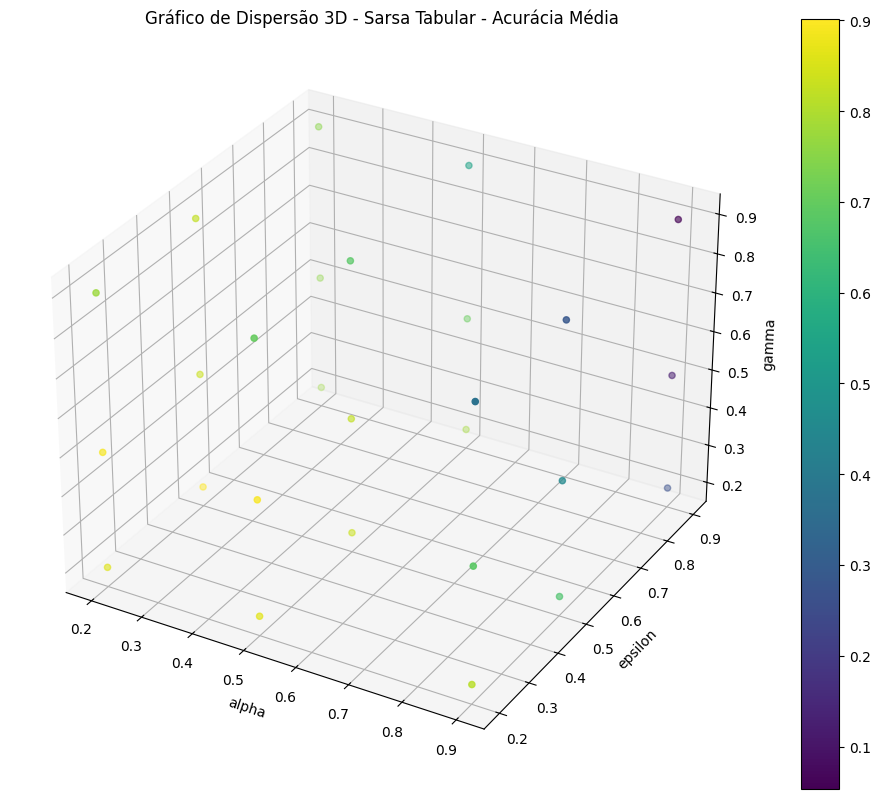

In [28]:
x = df_sarsa["alpha"]
y = df_sarsa["epsilon"]
z = df_sarsa["gamma"]
g = df_sarsa["mean_accuracy"]


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=g, cmap='viridis', marker='o')

ax.set_xlabel('alpha')
ax.set_ylabel('epsilon')
ax.set_zlabel('gamma')

ax.set_title('Gráfico de Dispersão 3D - Sarsa Tabular - Acurácia Média')

# Adding a colorbar
cbar = plt.colorbar(scatter)

plt.show()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


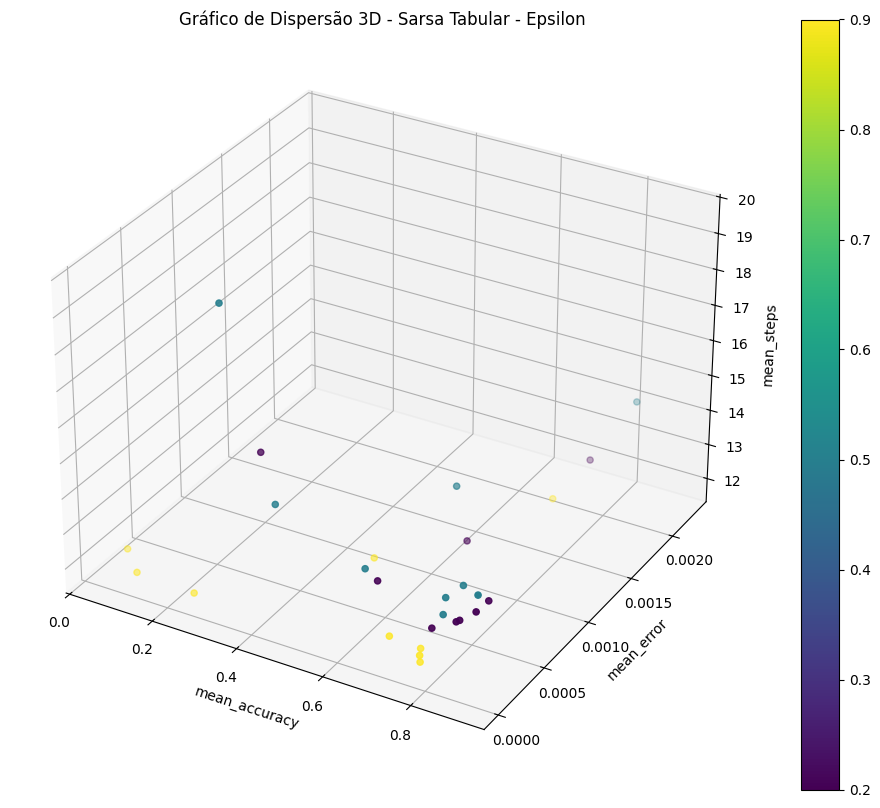

In [26]:
x = df_sarsa["mean_accuracy"]
y = df_sarsa["mean_error"]
z = df_sarsa["mean_steps"]
g = df_sarsa["epsilon"]


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=g, cmap='viridis', marker='o')

ax.set_xlabel('mean_accuracy')
ax.set_ylabel('mean_error')
ax.set_zlabel('mean_steps')

ax.set_title('Gráfico de Dispersão 3D - Sarsa Tabular - Epsilon')

# Adding a colorbar
cbar = plt.colorbar(scatter)

plt.show()

In [ ]:
x = df_sarsa["mean_accuracy"]
y = df_sarsa["mean_error"]
z = df_sarsa["mean_steps"]
g = df_sarsa["alpha"]


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=g, cmap='viridis', marker='o')

ax.set_xlabel('mean_accuracy')
ax.set_ylabel('mean_error')
ax.set_zlabel('mean_steps')

ax.set_title('Gráfico de Dispersão 3D - Sarsa Tabular - Alpha')

# Adding a colorbar
cbar = plt.colorbar(scatter)

plt.show()

In [ ]:
df_sarsa[df_sarsa['mean_error'] == df_sarsa['mean_error'].min()]

alpha  epsilon  gamma                                           accuracy  \
0    0.9      0.9    0.2  [0.0, 0.0, 0.04, 0.06, 0.06, 1.0, 1.0, 1.0, 0....   

                                             rewards  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               steps  \
0  [14, 30, 27, 58, 34, 13, 5, 59, 26, 4, 12, 7, ...   

                                               error          agent  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_sarsa   

   mean_accuracy  mean_error  mean_steps  
0         0.3716    0.000015       21.91

In [ ]:
df_sarsa[df_sarsa['mean_steps'] == df_sarsa['mean_steps'].min()]

alpha  epsilon  gamma                                           accuracy  \
0    0.5      0.2    0.2  [0.02, 0.0, 0.04, 0.0, 0.06, 1.0, 1.0, 1.0, 1....   

                                             rewards  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               steps  \
0  [42, 5, 13, 24, 5, 28, 3, 8, 5, 78, 99, 100, 1...   

                                               error          agent  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_sarsa   

   mean_accuracy  mean_error  mean_steps  
0         0.9512    0.000045     15.2337

In [ ]:
df_sarsa[df_sarsa['mean_accuracy'] == df_sarsa['mean_accuracy'].max()]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alpha  epsilon  gamma                                           accuracy  \
0    0.5      0.2    0.5  [0.02, 0.0, 0.04, 0.06, 1.0, 1.0, 1.0, 1.0, 1....   

                                             rewards  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               steps  \
0  [42, 5, 13, 53, 7, 2, 8, 16, 57, 5, 79, 8, 33,...   

                                               error          agent  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_sarsa   

   mean_accuracy  mean_error  mean_steps  
0         0.9612    0.000126     15.3581

In [ ]:
df_q[df_q['mean_error'] == df_q['mean_error'].min()]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alpha  epsilon  gamma                                           accuracy  \
0    0.9      0.9    0.2  [0.0, 0.02, 0.0, 0.0, 0.0, 0.06, 1.0, 1.0, 1.0...   

                                             rewards  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               steps  \
0  [2, 32, 3, 3, 21, 36, 8, 59, 4, 9, 16, 10, 15,...   

                                               error      agent  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   

   mean_accuracy  mean_error  mean_steps  
0         0.9408    0.000021     19.9709

In [ ]:
df_q[df_q['mean_steps'] == df_q['mean_steps'].min()]

alpha  epsilon  gamma                                           accuracy  \
0    0.2      0.2    0.2  [0.02, 0.02, 0.04, 0.32, 1.0, 1.0, 1.0, 1.0, 1...   

                                             rewards  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               steps  \
0  [15, 31, 2, 18, 24, 3, 16, 13, 11, 84, 8, 49, ...   

                                               error      agent  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   

   mean_accuracy  mean_error  mean_steps  
0          0.964     0.00012      14.812

In [ ]:
df_q[df_q['mean_accuracy'] == df_q['mean_accuracy'].max()]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alpha  epsilon  gamma                                           accuracy  \
0    0.5      0.5    0.5  [0.02, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   

                                             rewards  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               steps  \
0  [3, 8, 23, 39, 12, 13, 27, 5, 31, 4, 4, 33, 36...   

                                               error      agent  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   

   mean_accuracy  mean_error  mean_steps  
0         0.9902     0.00015     16.5911

<BarContainer object of 10000 artists>

ValueError: object too deep for desired array

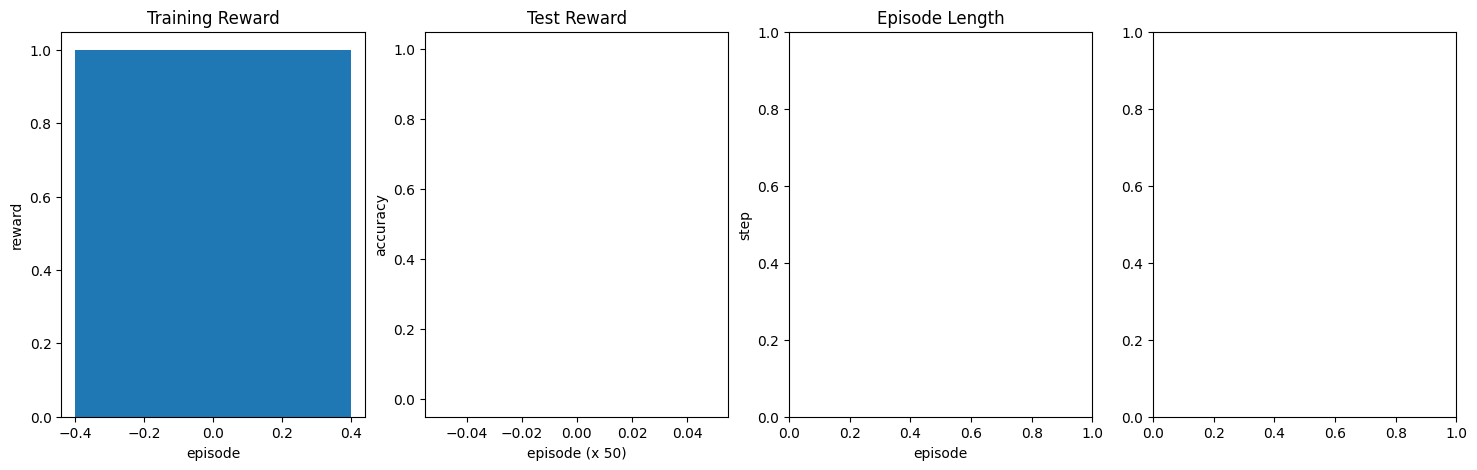

In [64]:
row = df_q[df_q['mean_error'] == df_q['mean_error'].min()]
filename = "q_min_error.png"

rewards = row['rewards'].tolist()
accuracies = row['accuracy'].tolist()
steps = row['steps'].tolist()
training_error = row['error'].tolist()

rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards)), *rewards)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies)), accuracies)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), *steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), *training_error_moving_average)

plt.tight_layout()
plt.savefig(filename)
plt.show()

In [63]:
type(rewards.tolist()), type(accuracies), type(steps), type(training_error)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(list,
 pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [29]:
def save_img_summary(row, filename):
  rewards = row['rewards']
  accuracies = row['accuracy']
  steps = row['steps']
  training_error = row['error']

  rolling_length = 100
  fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
  axs[0].set_title("Training Reward")
  axs[0].set_xlabel('episode')
  axs[0].set_ylabel('reward')
  axs[0].bar(range(len(rewards)), rewards)

  axs[1].set_title("Test Reward")
  axs[1].set_xlabel('episode (x 50)')
  axs[1].set_ylabel('accuracy')
  axs[1].plot(range(len(accuracies)), accuracies)

  axs[2].set_title("Episode Length")
  axs[2].set_xlabel('episode')
  axs[2].set_ylabel('step')
  steps_moving_average = np.convolve(np.array(steps), np.ones(rolling_length), mode="same") / rolling_length
  axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

  axs[3].set_title("Training Error")
  axs[3].set_xlabel('step')
  axs[3].set_ylabel('error')
  training_error_moving_average = np.convolve(np.array(training_error), np.ones(rolling_length), mode="same") / rolling_length
  axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

  plt.tight_layout()
  plt.savefig(filename)
  plt.show()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

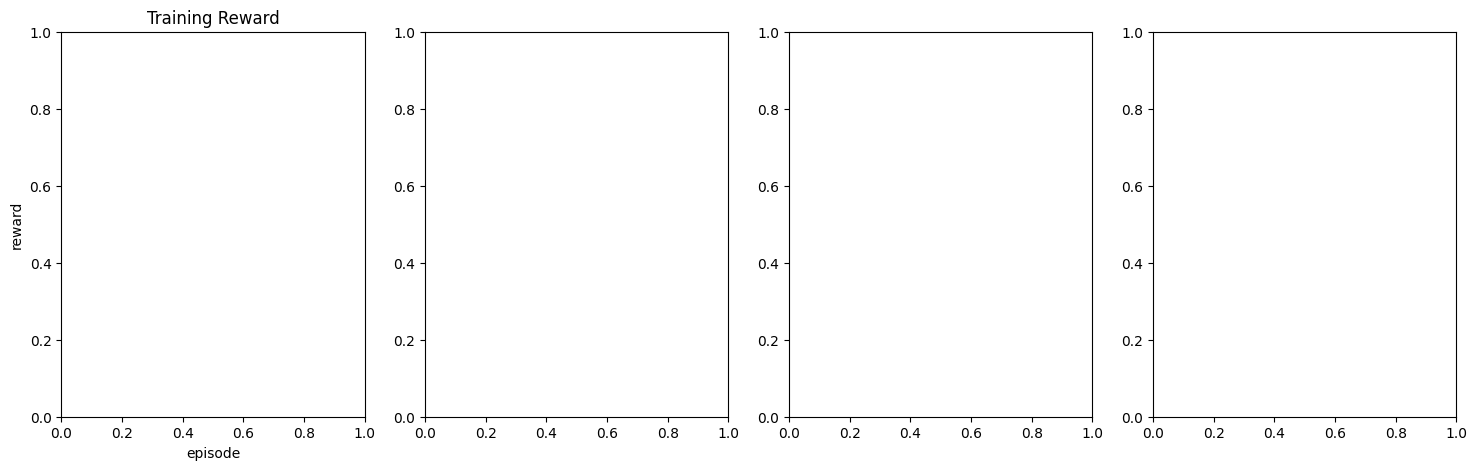

In [30]:
save_img_summary(df_q[df_q['mean_error'] == df_q['mean_error'].min()], "q_min_error.png")
save_img_summary(df_q[df_q['mean_steps'] == df_q['mean_steps'].min()], "q_min_steps.png")
save_img_summary(df_q[df_q['mean_accuracy'] == df_q['mean_accuracy'].max()], "q_max_accuracy.png")

save_img_summary(df_sarsa[df_sarsa['mean_error'] == df_sarsa['mean_error'].min()], "sarsa_min_error.png")
save_img_summary(df_sarsa[df_sarsa['mean_steps'] == df_sarsa['mean_steps'].min()], "sarsa_min_steps.png")
save_img_summary(df_sarsa[df_sarsa['mean_accuracy'] == df_sarsa['mean_accuracy'].max()], "sarsa_max_accuracy.png")


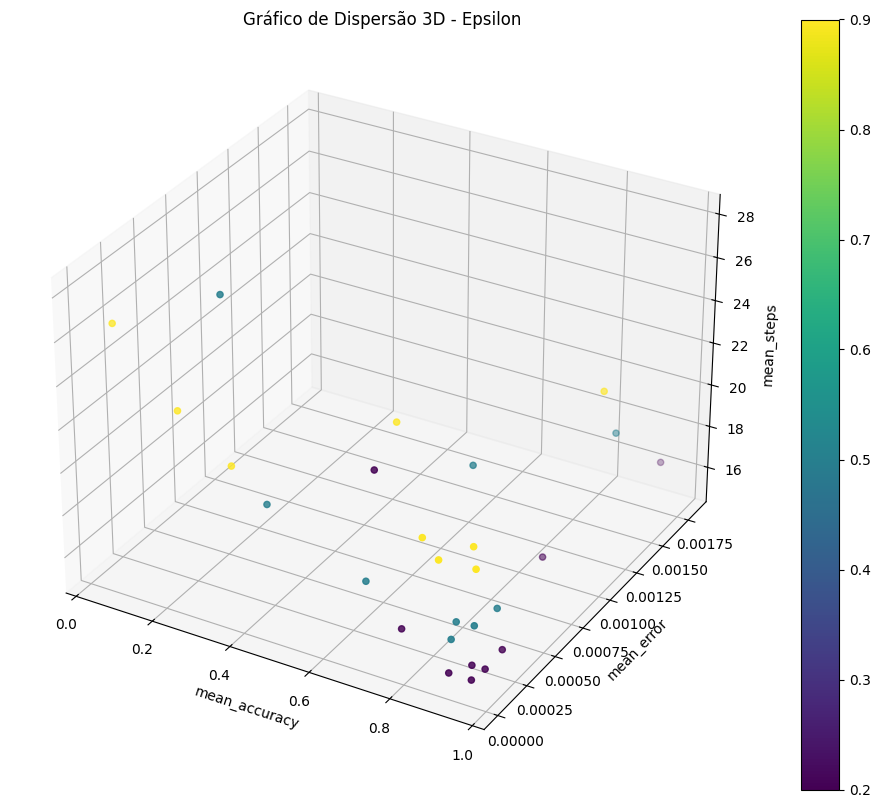

In [ ]:
x = df_sarsa["mean_accuracy"]
y = df_sarsa["mean_error"]
z = df_sarsa["mean_steps"]
g = df_sarsa["epsilon"]


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=g, cmap='viridis', marker='o')

ax.set_xlabel('mean_accuracy')
ax.set_ylabel('mean_error')
ax.set_zlabel('mean_steps')

ax.set_title('Gráfico de Dispersão 3D - Epsilon')

# Adding a colorbar
cbar = plt.colorbar(scatter)

plt.show()

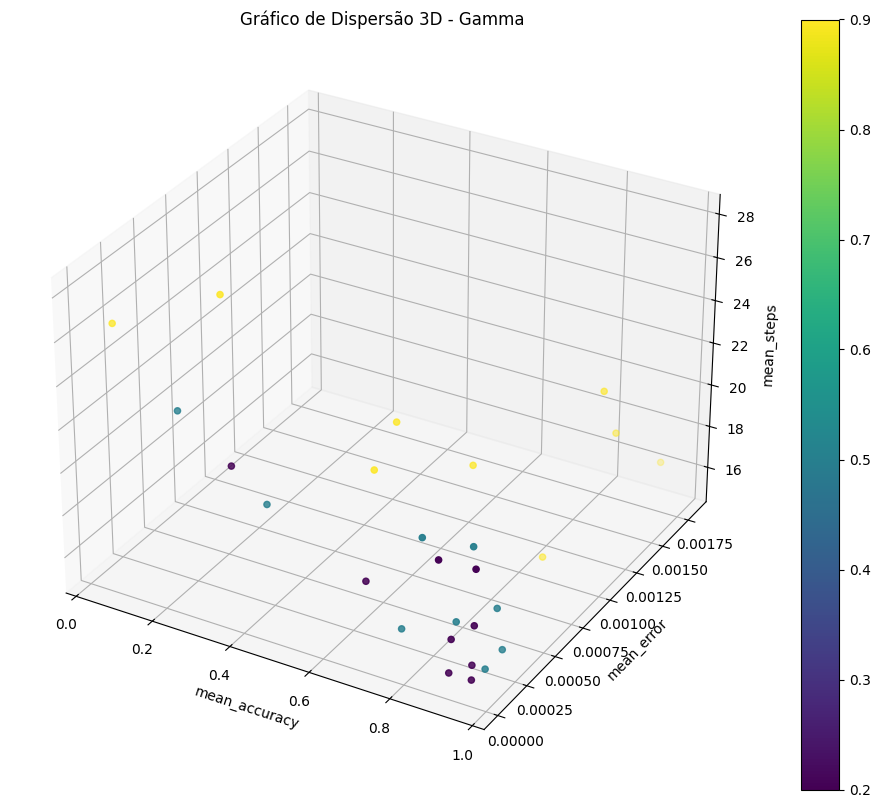

In [ ]:
x = df_sarsa["mean_accuracy"]
y = df_sarsa["mean_error"]
z = df_sarsa["mean_steps"]
g = df_sarsa["gamma"]


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=g, cmap='viridis', marker='o')

ax.set_xlabel('mean_accuracy')
ax.set_ylabel('mean_error')
ax.set_zlabel('mean_steps')

ax.set_title('Gráfico de Dispersão 3D - Gamma')

# Adding a colorbar
cbar = plt.colorbar(scatter)

plt.show()

<Axes: xlabel='epsilon', ylabel='mean_steps'>

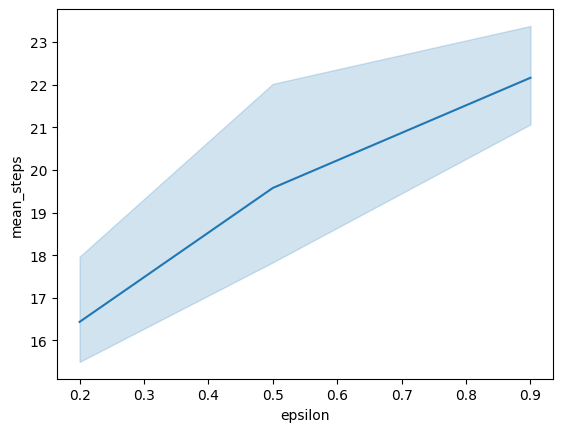

In [ ]:
sns.lineplot(data=df_sarsa, x="epsilon", y="mean_steps")

<Axes: xlabel='gamma', ylabel='mean_steps'>

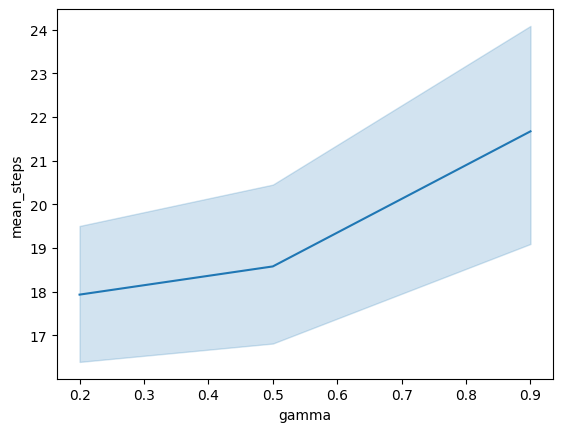

In [ ]:
sns.lineplot(data=df_sarsa, x="gamma", y="mean_steps")

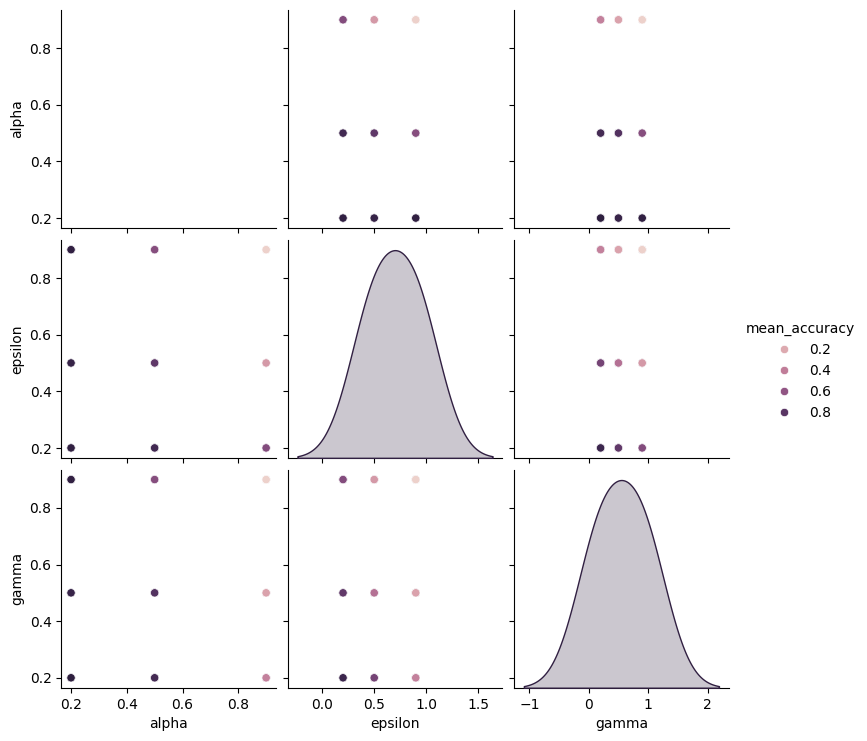

In [ ]:
sns.pairplot(df_sarsa[["mean_accuracy", "alpha", "epsilon", "gamma"]], hue="mean_accuracy")

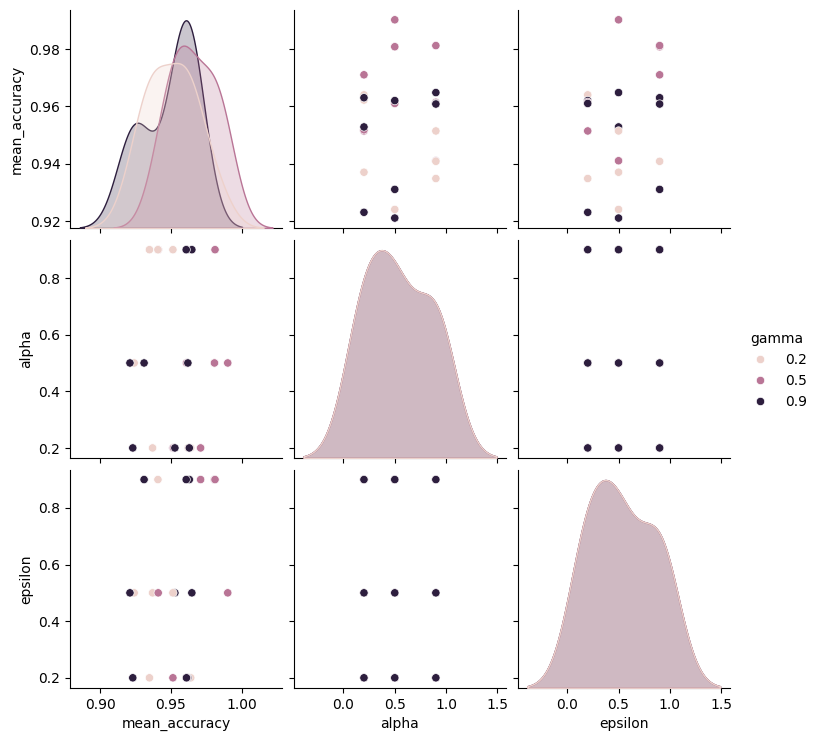

In [ ]:
sns.pairplot(df_q[["mean_accuracy", "alpha", "epsilon", "gamma"]], hue="gamma")

In [ ]:
df_q

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alpha  epsilon                                           accuracy  \
0    0.4      0.4  [0.04, 0.0, 0.04, 0.04, 1.0, 1.0, 1.0, 1.0, 1....   
0    0.4      0.5  [0.0, 0.02, 0.0, 0.04, 1.0, 1.0, 1.0, 1.0, 1.0...   
0    0.4      0.6  [0.0, 0.0, 0.0, 0.04, 0.02, 0.06, 1.0, 1.0, 1....   
0    0.4      0.7  [0.02, 0.0, 0.04, 0.1, 1.0, 1.0, 1.0, 1.0, 1.0...   
0    0.5      0.4  [0.02, 0.0, 0.04, 0.06, 0.3, 1.0, 1.0, 1.0, 1....   
0    0.5      0.5  [0.02, 0.0, 0.04, 0.02, 1.0, 1.0, 1.0, 1.0, 1....   
0    0.5      0.6  [0.0, 0.0, 0.32, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
0    0.5      0.7  [0.0, 0.0, 0.04, 0.04, 0.14, 1.0, 1.0, 1.0, 1....   
0    0.6      0.4  [0.0, 0.0, 0.04, 0.02, 0.0, 0.02, 1.0, 1.0, 1....   
0    0.6      0.5  [0.0, 0.0, 0.0, 0.02, 0.02, 0.02, 1.0, 1.0, 1....   
0    0.6      0.6  [0.02, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
0    0.6      0.7  [0.0, 0.0, 0.02, 0.14, 1.0, 1.0, 1.0, 1.0, 1.0...   
0    0.7      0.4  [0.02, 0.0, 0.04, 0.08, 0.54, 1.0, 1.0, 1.0, 1...   
0    0.7      0.5  [0.02, 0.02, 0.02, 0.02, 0.02, 0.22, 1.0, 1.0,...   
0    0.7      0.6  [0.02, 0.02, 0.42, 1.0, 1.0, 1.0, 1.0, 1.0, 1....   
0    0.7      0.7  [0.0, 0.02, 0.0, 0.06, 1.0, 1.0, 1.0, 1.0, 1.0...   

                                             rewards  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               steps  \
0  [2, 6, 11, 8, 17, 6, 67, 5, 48, 3, 22, 29, 32,...   
0  [8, 3, 13, 36, 7, 24, 27, 5, 7, 3, 5, 4, 15, 1...   
0  [2, 3, 14, 44, 11, 19, 12, 3, 13, 4, 5, 7, 3, ...   
0  [9, 3, 3, 13, 24, 8, 28, 4, 24, 23, 10, 2, 15,...   
0  [3, 18, 6, 6, 11, 6, 48, 3, 27, 17, 3, 3, 15, ...   
0  [3, 8, 2, 11, 66, 13, 2, 10, 9, 3, 4, 6, 78, 1...   
0  [2, 14, 45, 27, 14, 60, 43, 18, 6, 8, 12, 12, ...   
0  [5, 6, 2, 9, 15, 44, 22, 9, 19, 8, 7, 6, 13, 1...   
0  [3, 28, 24, 13, 10, 9, 7, 7, 14, 10, 21, 17, 3...   
0  [3, 11, 13, 32, 12, 7, 3, 17, 24, 5, 28, 2, 22...   
0  [5, 6, 15, 10, 14, 39, 12, 23, 2, 5, 7, 7, 43,...   
0  [12, 13, 46, 22, 3, 9, 10, 50, 11, 8, 80, 28, ...   
0  [2, 23, 11, 11, 26, 14, 7, 25, 6, 5, 5, 20, 29...   
0  [4, 25, 5, 27, 4, 7, 34, 17, 7, 6, 14, 19, 22,...   
0  [5, 5, 14, 11, 18, 24, 26, 23, 7, 6, 6, 20, 25...   
0  [27, 21, 44, 5, 17, 3, 8, 4, 18, 14, 14, 3, 27...   

                                               error      agent  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_q   
0

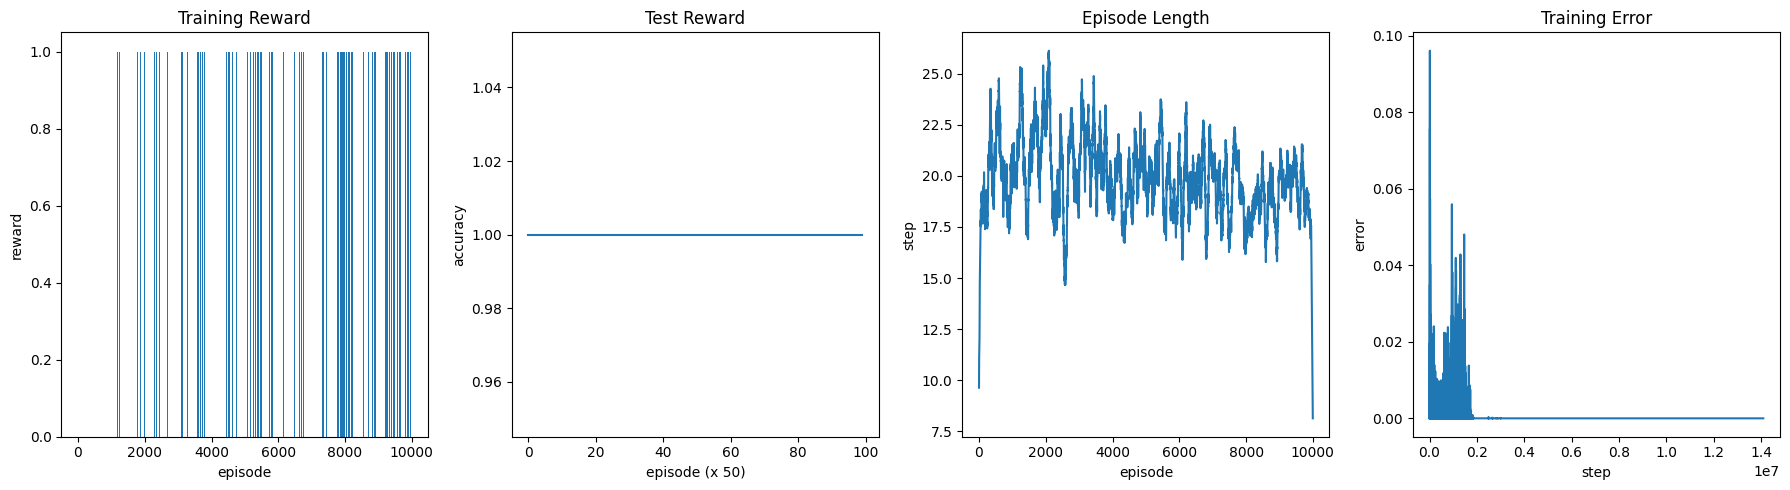

In [ ]:
save_imgs(df_experiments.iloc[0].error, df_experiments.iloc[0].rewards, df_experiments.iloc[161].accuracy, df_experiments.iloc[161].steps,
          f'{df_experiments.iloc[161].agent}_{alpha}_{epsilon}.png')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
sum(df_experiments.iloc[1].accuracy)/len(df_experiments.iloc[1].accuracy)

1.0

<ipython-input-150-db9ebaf8bbe4>:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat([df_experiments, pd.DataFrame({'alpha': [alpha],


alpha  epsilon                                           accuracy  \
0    0.1      0.1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   

                                             rewards  \
0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   

                                               steps  \
0  [14, 15, 14, 14, 14, 17, 16, 15, 16, 6, 18, 18...   

                                               error          agent  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  tabular_sarsa

In [ ]:
df_experiments.to_pickle('df_experiments.pkl')

In [ ]:
after_training_sarsa, rewards_sarsa, steps_sarsa, accuracies_sarsa = train_agent(agent_sarsa, True)
html_sarsa = render_mp4(after_training_sarsa)
HTML(html_sarsa)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/2000 [00:00<?, ?it/s]


IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
after_training_q, rewards_q, steps_q, accuracies_q = train_agent(agent_q, False)
html_q = render_mp4(after_training_q)
HTML(html_q)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  2%|▏         | 191/10000 [00:00<00:19, 494.61it/s]

step: 4609, episode: 100, accuracy training: 0.06, accuracy test: 0.54, random move probability: 0.49600000000000155
step: 7476, episode: 200, accuracy training: 0.42, accuracy test: 1.0, random move probability: 0.4920000000000031


  4%|▍         | 400/10000 [00:00<00:15, 626.00it/s]

step: 10111, episode: 300, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.48800000000000465
step: 12472, episode: 400, accuracy training: 0.49, accuracy test: 1.0, random move probability: 0.4840000000000062


  6%|▌         | 590/10000 [00:00<00:12, 738.21it/s]

step: 14645, episode: 500, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.48000000000000775
step: 16909, episode: 600, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.4760000000000093


  8%|▊         | 801/10000 [00:01<00:14, 635.39it/s]

step: 19128, episode: 700, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.47200000000001086
step: 21490, episode: 800, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.4680000000000124


 10%|█         | 1024/10000 [00:01<00:12, 696.27it/s]

step: 23836, episode: 900, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.46400000000001396
step: 26081, episode: 1000, accuracy training: 0.52, accuracy test: 1.0, random move probability: 0.4600000000000155


 12%|█▏        | 1200/10000 [00:01<00:12, 730.07it/s]

step: 28231, episode: 1100, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.45600000000001706
step: 30426, episode: 1200, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.4520000000000186


 14%|█▍        | 1422/10000 [00:02<00:12, 679.68it/s]

step: 32624, episode: 1300, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.44800000000002016
step: 34779, episode: 1400, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.4440000000000217


 16%|█▌        | 1600/10000 [00:02<00:11, 728.19it/s]

step: 37066, episode: 1500, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.44000000000002326
step: 39155, episode: 1600, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.4360000000000248


 18%|█▊        | 1844/10000 [00:02<00:11, 727.72it/s]

step: 41308, episode: 1700, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.43200000000002636
step: 43336, episode: 1800, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.4280000000000279


 20%|██        | 2000/10000 [00:03<00:11, 705.65it/s]

step: 45486, episode: 1900, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.42400000000002946
step: 47502, episode: 2000, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2226/10000 [00:03<00:11, 700.25it/s]

step: 49723, episode: 2100, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.41600000000003257
step: 51789, episode: 2200, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4120000000000341


 24%|██▍       | 2400/10000 [00:03<00:10, 733.72it/s]

step: 54076, episode: 2300, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.40800000000003567
step: 56058, episode: 2400, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.4040000000000372


 27%|██▋       | 2658/10000 [00:03<00:09, 772.51it/s]

step: 58142, episode: 2500, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 60232, episode: 2600, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2810/10000 [00:04<00:10, 656.66it/s]

step: 62345, episode: 2700, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 64483, episode: 2800, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3880000000000434


 30%|███       | 3000/10000 [00:04<00:09, 728.45it/s]

step: 66574, episode: 2900, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 68560, episode: 3000, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3200/10000 [00:04<00:08, 768.53it/s]

step: 70531, episode: 3100, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 72557, episode: 3200, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3720000000000496


 34%|███▍      | 3396/10000 [00:04<00:08, 824.53it/s]

step: 74507, episode: 3300, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3680000000000512
step: 76627, episode: 3400, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.3640000000000527


 36%|███▋      | 3635/10000 [00:05<00:08, 718.20it/s]

step: 78671, episode: 3500, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.3600000000000543
step: 80673, episode: 3600, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3800/10000 [00:05<00:08, 740.67it/s]

step: 82705, episode: 3700, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 84664, episode: 3800, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|████      | 4000/10000 [00:05<00:07, 779.36it/s]

step: 86554, episode: 3900, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 88383, episode: 4000, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4198/10000 [00:05<00:07, 813.13it/s]

step: 90343, episode: 4100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 92304, episode: 4200, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.33200000000006513


 44%|████▍     | 4438/10000 [00:06<00:07, 749.25it/s]

step: 94224, episode: 4300, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 96120, episode: 4400, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▌     | 4600/10000 [00:06<00:07, 707.14it/s]

step: 98110, episode: 4500, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 100077, episode: 4600, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4800/10000 [00:06<00:06, 768.74it/s]

step: 101903, episode: 4700, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 103783, episode: 4800, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.30800000000007444


 51%|█████     | 5062/10000 [00:07<00:06, 767.36it/s]

step: 105688, episode: 4900, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.304000000000076
step: 107552, episode: 5000, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.30000000000007754


 52%|█████▏    | 5216/10000 [00:07<00:06, 732.17it/s]

step: 109422, episode: 5100, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2960000000000791
step: 111243, episode: 5200, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5400/10000 [00:07<00:05, 781.25it/s]

step: 113123, episode: 5300, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 114908, episode: 5400, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▌    | 5600/10000 [00:07<00:05, 819.91it/s]

step: 116671, episode: 5500, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 118450, episode: 5600, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5800/10000 [00:07<00:05, 809.37it/s]

step: 120227, episode: 5700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 122095, episode: 5800, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.26800000000008994


 60%|██████    | 6046/10000 [00:08<00:05, 782.41it/s]

step: 123881, episode: 5900, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 125634, episode: 6000, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6215/10000 [00:08<00:04, 807.55it/s]

step: 127394, episode: 6100, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.2560000000000946
step: 129063, episode: 6200, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6376/10000 [00:08<00:04, 737.85it/s]

step: 130760, episode: 6300, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 132477, episode: 6400, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6590/10000 [00:09<00:05, 594.91it/s]

step: 134214, episode: 6500, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 136026, episode: 6600, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6790/10000 [00:09<00:05, 573.45it/s]

step: 137797, episode: 6700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 139491, episode: 6800, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|██████▉   | 6980/10000 [00:09<00:05, 573.02it/s]

step: 141258, episode: 6900, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.22400000000008896
step: 142950, episode: 7000, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7182/10000 [00:10<00:04, 609.77it/s]

step: 144616, episode: 7100, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.2160000000000865
step: 146398, episode: 7200, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7383/10000 [00:10<00:04, 606.32it/s]

step: 148138, episode: 7300, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.20800000000008406
step: 149834, episode: 7400, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7574/10000 [00:10<00:04, 567.16it/s]

step: 151471, episode: 7500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 153100, episode: 7600, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7766/10000 [00:11<00:04, 547.05it/s]

step: 154783, episode: 7700, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.19200000000007916
step: 156422, episode: 7800, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.18800000000007794


 80%|████████  | 8004/10000 [00:11<00:04, 498.98it/s]

step: 158100, episode: 7900, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.1840000000000767
step: 159754, episode: 8000, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1800000000000755


 82%|████████▏ | 8200/10000 [00:12<00:03, 482.52it/s]

step: 161457, episode: 8100, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.17600000000007426
step: 163086, episode: 8200, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.17200000000007304


 84%|████████▍ | 8413/10000 [00:12<00:02, 597.09it/s]

step: 164736, episode: 8300, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.16800000000007181
step: 166341, episode: 8400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1640000000000706


 86%|████████▌ | 8600/10000 [00:12<00:01, 725.57it/s]

step: 167939, episode: 8500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.16000000000006936
step: 169522, episode: 8600, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.15600000000006814


 89%|████████▉ | 8888/10000 [00:13<00:01, 838.97it/s]

step: 171175, episode: 8700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.15200000000006691
step: 172757, episode: 8800, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1480000000000657


 91%|█████████ | 9058/10000 [00:13<00:01, 830.36it/s]

step: 174308, episode: 8900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 175918, episode: 9000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9227/10000 [00:13<00:00, 785.57it/s]

step: 177515, episode: 9100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.13600000000006202
step: 179030, episode: 9200, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▍| 9400/10000 [00:13<00:00, 813.05it/s]

step: 180595, episode: 9300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.12800000000005957
step: 182152, episode: 9400, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.12400000000005869


 96%|█████████▌| 9600/10000 [00:13<00:00, 824.75it/s]

step: 183701, episode: 9500, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.12000000000005885
step: 185296, episode: 9600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9800/10000 [00:14<00:00, 847.76it/s]

step: 186868, episode: 9700, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 188387, episode: 9800, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|██████████| 10000/10000 [00:14<00:00, 692.52it/s]

step: 189878, episode: 9900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1040000000000595
step: 191388, episode: 10000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10000000000005967



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


In [ ]:
max(steps_sarsa)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


100

As métricas são apresentadas a seguir. Vê-se, conforme explicado acima, que a recompensa é 1 no objetivo final e 0 em outros passos. A diferença entre a abordagem SARSA e Q

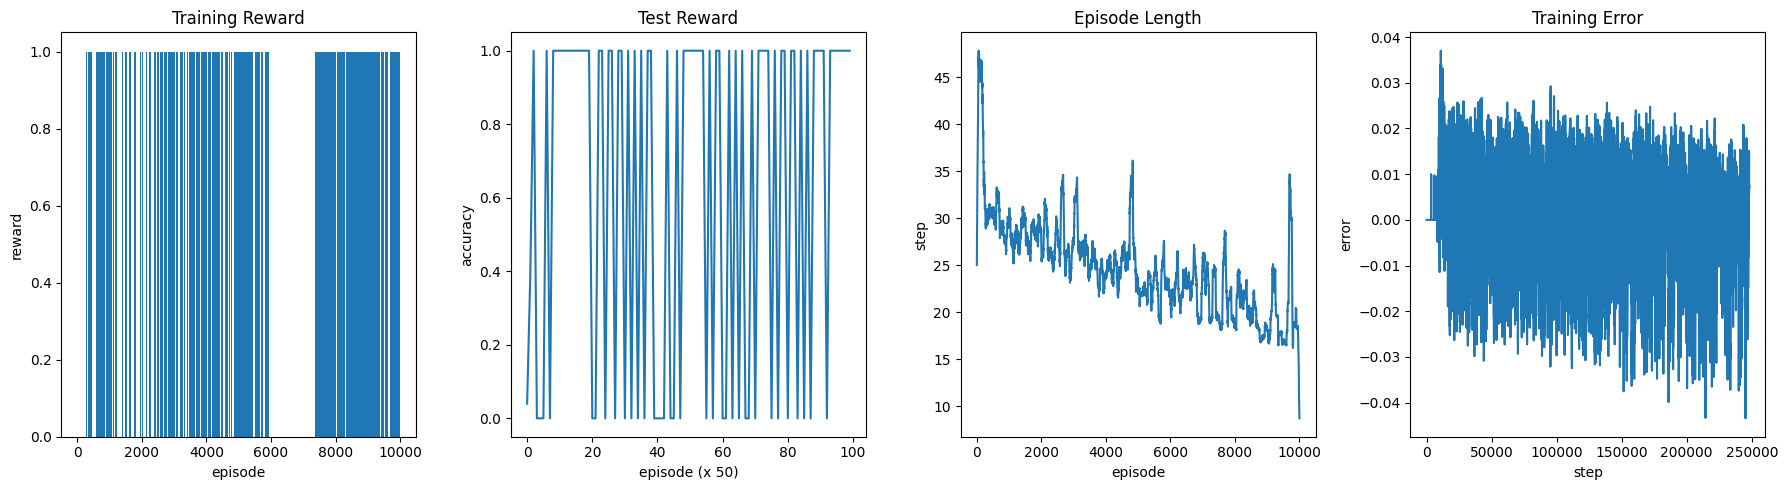

In [ ]:
rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards_sarsa)), rewards_sarsa)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies_sarsa)), accuracies_sarsa)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps_sarsa), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(agent_sarsa.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

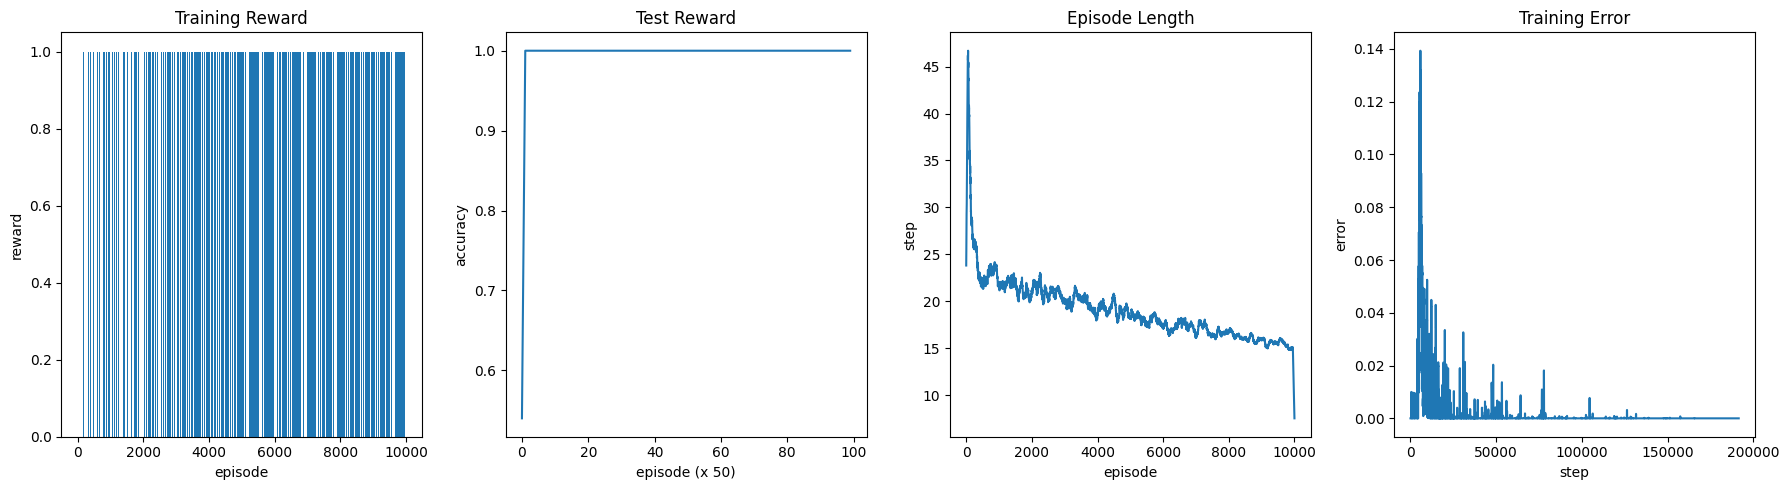

In [ ]:
rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards_q)), rewards_q)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies_q)), accuracies_q)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps_q), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(agent_q.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

In [ ]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    plt.show()

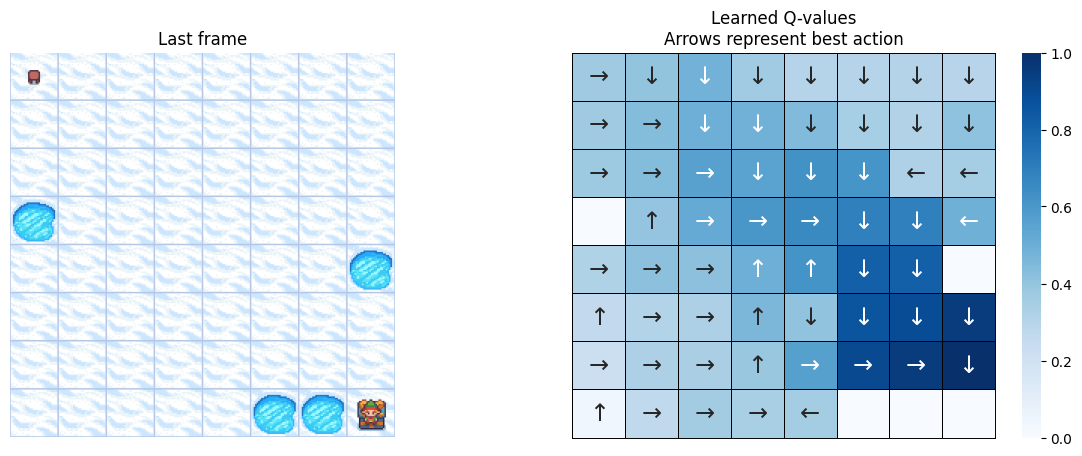

In [ ]:
plot_q_values_map(agent_sarsa.get_Q_Table(), env, side_map_size)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


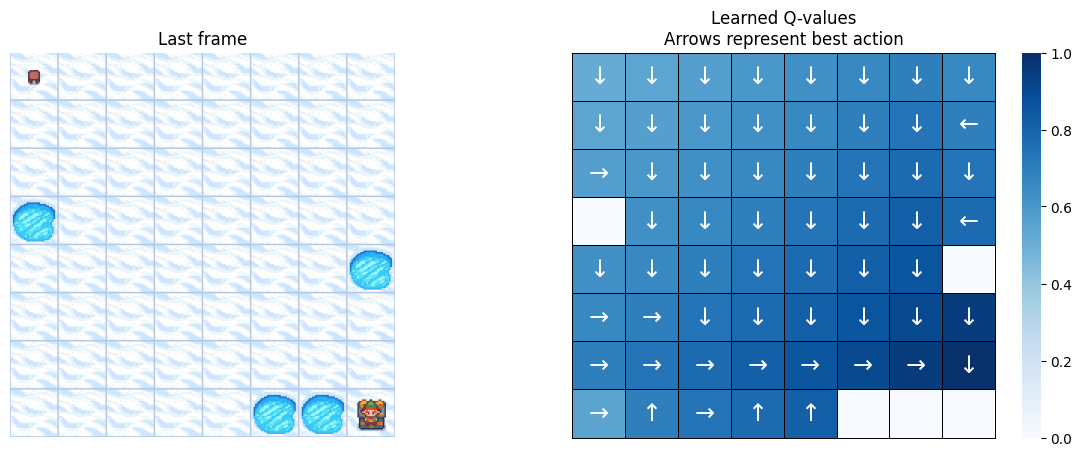

In [ ]:
plot_q_values_map(agent_q.get_Q_Table(), env, side_map_size)

### Criando uma estratégia baseada em redes neurais PyTorch

A seguir, avaliamos o desempenho de um agente de Aprendizado por Reforço que utiliza uma rede neural.

In [82]:
# Importing PyTorch neural network (torch.nn) and optimizer (torch.optim)
import torch
import torch.nn as nn
import torch.optim as optim

In [83]:
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>>

In [84]:
class LinearNetwork(nn.Module):
    """
    Linear neural network for Q-learning and SARSA
    """
    def __init__(self, state_size, hidden_size, action_size):
        super(LinearNetwork, self).__init__()
        self.input_layer = nn.Linear(state_size, hidden_size)
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, action_size)

        print("Artificial neural network started with PyTorch")
        print("input =", state_size, ", Hidden =", hidden_size, ", output =", action_size)

    def forward(self, state):
        x = self.input_layer(state)

        x = torch.sigmoid(self.hidden_layer(x))

        return self.output_layer(x)

In [90]:
from torch.nn.functional import one_hot

class QLearningAgent:

    def __init__(
        self,
        alpha_learning_rate,
        gamma_discount_factor,
        initial_epsilon,
        epsilon_decay,
        final_epsilon,
        state_space,
        hidden_size,
        action_space,
        device,
        model,
        optimizer,
        criterion,
        is_using_Sarsa
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            alpha_learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            gamma_discount_factor: The discount factor for computing the Q-value
            state_space: The state space
            action_space: The action space
            is_using_Sarsa: Sarsa or Q-learning method
        """
        self.alpha_learning_rate = alpha_learning_rate
        self.gamma_discount_factor = gamma_discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.state_space = state_space
        self.hidden_size = hidden_size
        self.action_space = action_space
        self.device = device
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.is_using_Sarsa = is_using_Sarsa
        self.training_error = []

        if(self.is_using_Sarsa):
            print("SARSA agent started")
        else:
            print("Q-learning agent started")

        # Set the seed
        self.rng = np.random.default_rng(123)

    def get_Q_Network(self):
        return self.model

    def get_tensor(self, value):
        return torch.tensor(value, device=self.device, dtype=torch.float32)

    def get_one_hot_tensor(self, state):
        # One-hot encode state before passing to the model
        state_tensor = torch.tensor(state, device=self.device, dtype=torch.int64)
        return one_hot(state_tensor, num_classes=self.state_space.n).type(torch.float32)

    def eval_state(self, state):
        with torch.no_grad():
            state_tensor = self.get_one_hot_tensor(state)
            q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()

    def max_eval_state(self, state):
        with torch.no_grad():
            state_tensor = self.get_one_hot_tensor(state)
            q_values = self.model(state_tensor)
            return torch.max(q_values).item()

    def choose_action(self, state):
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # First we randomize a number
        exploration_exploitation_tradeoff = self.rng.uniform(0, 1)

        # Exploration
        # with probability epsilon return a random action to explore the environment
        if exploration_exploitation_tradeoff < self.epsilon:
            return self.action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            with torch.no_grad():
                return self.eval_state(state)

    def update(
        self,
        state: int,
        action: int,
        reward: float,
        terminated: bool,
        next_state: int,
        next_action: int
    ):
        """Updates the neural network weights."""
        # Train the network using target and the predicted q_network values
        # Setting the model in training mode
        self.model.train()

        if terminated:
            target = self.get_tensor(reward) # Convert reward to tensor

        else:
            # Eval next state
            next_state_tensor = self.get_one_hot_tensor(next_state) # Get one-hot encoded next state tensor

            with torch.no_grad():
                Q2 = self.model(next_state_tensor)

                # Sarsa: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * Q(s',a') - Q(s,a)]
                if(self.is_using_Sarsa):
                    target = reward + self.gamma_discount_factor * Q2[next_action].item() # Use next_action for Sarsa

                # Q-learning: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
                else:
                    target = reward + self.gamma_discount_factor * torch.max(Q2).item() # Use max Q-value for Q-learning

            target = self.get_tensor(target) # Convert target to tensor

        # Eval state
        state_tensor = self.get_one_hot_tensor(state) # Get one-hot encoded state tensor
        Q1 = self.model(state_tensor) # Get the Q-value for the chosen action

        # Computing the loss (error between the predicted Q-value and the actual Q-value)
        temporal_difference_error = self.criterion(Q1[action], target)

        self.training_error.append(temporal_difference_error.item())

        # Reset accumulated gradients
        self.optimizer.zero_grad()

        # Performing backpropagation
        temporal_difference_error.backward()

        # Updating network parameters
        self.optimizer.step()

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [91]:
# hyperparameters
alpha_learning_rate = 0.0001 # @param {type:"number"}
nb_max_episodes = 3000 # @param {type:"integer"}
start_epsilon = 0.5 # @param {type:"number"}
final_epsilon = 0.1 # @param {type:"number"}
epsilon_decay = (start_epsilon - final_epsilon) / nb_max_episodes  # reduce the exploration over time
gamma_discount_factor = 0.95 # @param {type:"number"}
is_using_Sarsa = False # @param {type:"boolean"}
test_freq = 100 # @param {type:"integer"}
total_steps = 0

# Starting the artificial neural network
# Check that there is a GPU avaiable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hidden_size = 64 # @param {type:"integer"}

# Input and output size based on the environment
# These lines establish the feed-forward part of the netwotk used to choose actions
model = LinearNetwork(env.observation_space.n, hidden_size, env.action_space.n).to(device)

# Initialize optimizer that can be SGD, Adam, RMSprop, etc.
optimizer = optim.Adam(model.parameters(), lr=alpha_learning_rate)

# Initialize loss function using mean squared error
criterion = nn.MSELoss()

agent = QLearningAgent(
    alpha_learning_rate=alpha_learning_rate,
    gamma_discount_factor=gamma_discount_factor,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    state_space = env.observation_space,
    hidden_size = hidden_size,
    action_space = env.action_space,
    device = device,
    model = model,
    optimizer = optimizer,
    criterion = criterion,
    is_using_Sarsa = is_using_Sarsa
)

Artificial neural network started with PyTorch
input = 64 , Hidden = 64 , output = 4
Q-learning agent started


In [94]:
def test_accurracy(agent, num_steps, num_episodes=100):
    counter = 0
    nb_success = 0.0

    while counter < num_episodes:
        is_terminal = False
        state, info = env.reset()

        for i in range(num_steps):
            action = agent.eval_state(state)
            state, reward, terminated, truncated, info = env.step(action)
            is_terminal = terminated or truncated
            nb_success += reward

            if(is_terminal):
                break

        counter += 1

    return nb_success/counter

alphas = [0.2, 0.5, 0.9]
epsilons = [0.2, 0.5, 0.9]
gammas = [0.2, 0.5, 0.9]

df_experiments_cp = pd.DataFrame(columns=['alpha', 'epsilon', 'gamma', 'accuracy', 'rewards', 'steps', 'error', 'agent'])

for alpha in alphas:
    for epsilon in epsilons:
        for gamma_discount_factor in gammas:
            print(f'Rodando alpha {alpha}, epsilon {epsilon} e gamma {gamma_discount_factor}')
            agent_sarsa = QLearningAgent(
                alpha_learning_rate=alpha_learning_rate,
                gamma_discount_factor=gamma_discount_factor,
                initial_epsilon=start_epsilon,
                epsilon_decay=epsilon_decay,
                final_epsilon=final_epsilon,
                state_space = env.observation_space,
                hidden_size = hidden_size,
                action_space = env.action_space,
                device = device,
                model = model,
                optimizer = optimizer,
                criterion = criterion,
                is_using_Sarsa = True
            )

            agent_q = QLearningAgent(
                alpha_learning_rate=alpha_learning_rate,
                gamma_discount_factor=gamma_discount_factor,
                initial_epsilon=start_epsilon,
                epsilon_decay=epsilon_decay,
                final_epsilon=final_epsilon,
                state_space = env.observation_space,
                hidden_size = hidden_size,
                action_space = env.action_space,
                device = device,
                model = model,
                optimizer = optimizer,
                criterion = criterion,
                is_using_Sarsa = True
            )

            after_training_sarsa, rewards_sarsa, steps_sarsa, accuracies_sarsa = train_agent(agent_sarsa, True)
            error = agent_sarsa.training_error
            df_experiments = pd.concat([df_experiments, pd.DataFrame({'alpha': [alpha],
                                                                      'epsilon': [epsilon],
                                                                      'gamma': [gamma_discount_factor],
                                                                      'accuracy': [accuracies_sarsa],
                                                                      'rewards': [rewards_sarsa],
                                                                      'steps': [steps_sarsa],
                                                                      'error': [error],
                                                                      'agent': ['tabular_sarsa']})])
            after_training_q, rewards_q, steps_q, accuracies_q = train_agent(agent_q, False)
            error = agent_q.training_error
            df_experiments = pd.concat([df_experiments, pd.DataFrame({'alpha': [alpha],
                                                                      'epsilon': [epsilon],
                                                                      'gamma': [gamma_discount_factor],
                                                                      'accuracy': [accuracies_q],
                                                                      'rewards': [rewards_q],
                                                                      'steps': [steps_q],
                                                                      'error': [error],
                                                                      'agent': ['tabular_q']})])
            print(f'Len experiments {len(df_experiments)}')


Rodando alpha 0.2, epsilon 0.2 e gamma 0.2
SARSA agent started
SARSA agent started


  4%|▎         | 110/3000 [00:01<00:38, 74.37it/s]

step: 726, episode: 100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.48666666666666814


  7%|▋         | 221/3000 [00:02<00:26, 106.29it/s]

step: 1178, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.47333333333333627


 10%|█         | 311/3000 [00:03<00:31, 86.22it/s]

step: 1671, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4600000000000044


 14%|█▍        | 426/3000 [00:05<00:57, 44.46it/s]

step: 2173, episode: 400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.44666666666667254


 17%|█▋        | 514/3000 [00:07<00:42, 57.99it/s]

step: 2662, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4333333333333407


 21%|██        | 620/3000 [00:08<00:35, 67.29it/s]

step: 3070, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4200000000000088


 24%|██▍       | 735/3000 [00:09<00:14, 154.55it/s]

step: 3495, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.40666666666667695


 27%|██▋       | 814/3000 [00:09<00:20, 104.20it/s]

step: 4043, episode: 800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.3933333333333451


 31%|███       | 917/3000 [00:10<00:16, 124.08it/s]

step: 4555, episode: 900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.3800000000000132


 34%|███▍      | 1018/3000 [00:11<00:30, 65.45it/s]

step: 5032, episode: 1000, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.36666666666668135


 37%|███▋      | 1124/3000 [00:12<00:13, 141.81it/s]

step: 5511, episode: 1100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.3533333333333495


 41%|████      | 1234/3000 [00:13<00:10, 170.43it/s]

step: 5933, episode: 1200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.3400000000000176


 44%|████▍     | 1319/3000 [00:14<00:26, 63.26it/s]

step: 6379, episode: 1300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.32666666666668576


 47%|████▋     | 1414/3000 [00:14<00:11, 141.41it/s]

step: 6828, episode: 1400, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.3133333333333539


 50%|█████     | 1506/3000 [00:17<00:56, 26.67it/s]

step: 7411, episode: 1500, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.300000000000022


 55%|█████▍    | 1642/3000 [00:19<00:11, 119.45it/s]

step: 8305, episode: 1600, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.28666666666669016


 58%|█████▊    | 1729/3000 [00:20<00:13, 95.91it/s]

step: 8598, episode: 1700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.2733333333333583


 62%|██████▏   | 1847/3000 [00:21<00:07, 160.56it/s]

step: 9017, episode: 1800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.26000000000002643


 64%|██████▎   | 1905/3000 [00:21<00:05, 214.61it/s]

step: 9272, episode: 1900, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.24666666666669387


 67%|██████▋   | 2008/3000 [00:22<00:06, 146.04it/s]

step: 9864, episode: 2000, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.23333333333335923


 71%|███████   | 2116/3000 [00:23<00:07, 123.00it/s]

step: 10559, episode: 2100, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.2200000000000246


 75%|███████▍  | 2246/3000 [00:24<00:07, 95.65it/s]

step: 10983, episode: 2200, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.20666666666668995


 78%|███████▊  | 2342/3000 [00:24<00:03, 191.22it/s]

step: 11277, episode: 2300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1933333333333553


 80%|████████  | 2402/3000 [00:25<00:03, 188.53it/s]

step: 11585, episode: 2400, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.18000000000002067


 85%|████████▍ | 2539/3000 [00:26<00:02, 174.77it/s]

step: 12064, episode: 2500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.16666666666668603


 87%|████████▋ | 2615/3000 [00:26<00:02, 162.57it/s]

step: 12388, episode: 2600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1533333333333514


 91%|█████████ | 2736/3000 [00:27<00:01, 172.18it/s]

step: 13093, episode: 2700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.14000000000001675


 94%|█████████▍| 2830/3000 [00:28<00:01, 152.32it/s]

step: 13545, episode: 2800, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.1266666666666821


 99%|█████████▊| 2958/3000 [00:28<00:00, 270.62it/s]

step: 14010, episode: 2900, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.11333333333334869


100%|██████████| 3000/3000 [00:30<00:00, 98.58it/s] 


step: 14342, episode: 3000, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.10000000000001544


  0%|          | 0/3000 [00:00<?, ?it/s]


RuntimeError: a Tensor with 4 elements cannot be converted to Scalar

In [87]:
def test_accurracy(num_steps, num_episodes=100):
    counter = 0
    nb_success = 0.0

    while counter < num_episodes:
        is_terminal = False
        state, info = env.reset()

        for i in range(num_steps):
            model.eval() # Putting the model into evaluation mode (without gradients)
            action = agent.eval_state(state)
            state, reward, terminated, truncated, info = env.step(action)
            is_terminal = terminated or truncated
            nb_success += reward

            if(is_terminal):
                break

        counter += 1

    return nb_success/counter


def record_trained_video(video_file, num_steps):
    video = VideoRecorder(env, video_file)

    # returns an initial observation
    state, info = env.reset()
    env.render()
    video.capture_frame()

    for i in range(num_steps):
        model.eval() # Putting the model into evaluation mode (without gradients)
        action = agent.eval_state(state)
        state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        env.render()
        video.capture_frame()

        if(is_terminal):
            print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
            break

    video.close()


In [88]:
from tqdm import tqdm
#Create lists to contain total rewards, steps and accurracy per episode
accuracies = []
mean_rewards = []
rewards = []
steps = []

for episode_count in tqdm(range(nb_max_episodes)):
    state, info = env.reset()
    is_terminal = False
    total_reward = 0
    episode_step = 0

    if(is_using_Sarsa): # Sarsa
        # Choose an action by greedily (with epsilon chance of random action) from the Q-Network
        action = agent.choose_action(state)

    # The Q-Network training
    while not is_terminal:
        episode_step += 1

        if(not is_using_Sarsa): # Q-learning
            # Choose an action by greedily (with epsilon chance of random action) from the Q-Network
            action = agent.choose_action(state)

        # Play best or random move and get new state and reward from environment
        next_state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        # update the agent
        if(not is_using_Sarsa): # Q-learning
            agent.update(state, action, reward, terminated, next_state, None)
        else: # Sarsa
            next_action = agent.choose_action(next_state)
            agent.update(state, action, reward, terminated, next_state, next_action)
            action = next_action

        # update the current observation
        state = next_state
        total_steps += 1
        total_reward += reward

    agent.decay_epsilon()

    mean_rewards.append(total_reward)
    if (episode_count+1) % test_freq == 0:
        accur = test_accurracy(env.spec.max_episode_steps,50)
        accuracies.append(accur)

        print('step: %s, episode: %s, accuracy training: %s, accuracy test: %s, random move probability: %s' % (total_steps, episode_count+1, sum(mean_rewards)/test_freq, accur, agent.epsilon))
        mean_rewards.clear()

    rewards.append(total_reward)
    steps.append(episode_step)

after_training = "after_training.mp4"
record_trained_video(after_training, env.spec.max_episode_steps)
env.close()

  4%|▍         | 127/3000 [00:00<00:15, 190.04it/s]

step: 477, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.48666666666666814


  7%|▋         | 209/3000 [00:02<01:20, 34.54it/s] 

step: 1031, episode: 200, accuracy training: 0.03, accuracy test: 0.0, random move probability: 0.47333333333333627


 10%|█         | 311/3000 [00:06<02:12, 20.22it/s]

step: 2416, episode: 300, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.4600000000000044


 14%|█▎        | 405/3000 [00:09<02:06, 20.48it/s]

step: 3606, episode: 400, accuracy training: 0.02, accuracy test: 0.0, random move probability: 0.44666666666667254


 17%|█▋        | 507/3000 [00:11<01:51, 22.28it/s]

step: 5145, episode: 500, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4333333333333407


 20%|██        | 603/3000 [00:15<04:52,  8.20it/s]

step: 6408, episode: 600, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4200000000000088


 24%|██▎       | 706/3000 [00:21<02:43, 14.04it/s]

step: 8417, episode: 700, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.40666666666667695


 27%|██▋       | 806/3000 [00:24<01:31, 23.97it/s]

step: 9626, episode: 800, accuracy training: 0.05, accuracy test: 0.0, random move probability: 0.3933333333333451


 30%|███       | 902/3000 [00:26<01:06, 31.71it/s]

step: 10948, episode: 900, accuracy training: 0.05, accuracy test: 1.0, random move probability: 0.3800000000000132


 34%|███▎      | 1006/3000 [00:29<01:39, 19.98it/s]

step: 12723, episode: 1000, accuracy training: 0.13, accuracy test: 0.0, random move probability: 0.36666666666668135


 37%|███▋      | 1105/3000 [00:31<01:01, 30.76it/s]

step: 14198, episode: 1100, accuracy training: 0.37, accuracy test: 1.0, random move probability: 0.3533333333333495


 40%|████      | 1207/3000 [00:36<02:43, 10.96it/s]

step: 15611, episode: 1200, accuracy training: 0.5, accuracy test: 0.0, random move probability: 0.3400000000000176


 44%|████▎     | 1306/3000 [00:38<00:45, 37.48it/s]

step: 17103, episode: 1300, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.32666666666668576


 47%|████▋     | 1406/3000 [00:41<01:13, 21.64it/s]

step: 18557, episode: 1400, accuracy training: 0.62, accuracy test: 0.0, random move probability: 0.3133333333333539


 50%|█████     | 1508/3000 [00:43<00:38, 39.23it/s]

step: 19912, episode: 1500, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.300000000000022


 54%|█████▎    | 1608/3000 [00:45<00:33, 41.80it/s]

step: 21337, episode: 1600, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.28666666666669016


 57%|█████▋    | 1703/3000 [00:48<01:03, 20.28it/s]

step: 22759, episode: 1700, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.2733333333333583


 60%|██████    | 1808/3000 [00:51<00:27, 42.74it/s]

step: 24113, episode: 1800, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.26000000000002643


 63%|██████▎   | 1903/3000 [00:53<00:29, 37.29it/s]

step: 25556, episode: 1900, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.24666666666669387


 67%|██████▋   | 2004/3000 [00:55<00:28, 35.55it/s]

step: 27007, episode: 2000, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.23333333333335923


 70%|███████   | 2109/3000 [00:57<00:21, 42.11it/s]

step: 28449, episode: 2100, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.2200000000000246


 73%|███████▎  | 2204/3000 [01:00<00:27, 28.97it/s]

step: 29929, episode: 2200, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.20666666666668995


 77%|███████▋  | 2302/3000 [01:04<00:47, 14.82it/s]

step: 31439, episode: 2300, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.1933333333333553


 80%|████████  | 2404/3000 [01:06<00:18, 32.65it/s]

step: 32943, episode: 2400, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.18000000000002067


 84%|████████▎ | 2509/3000 [01:08<00:11, 42.08it/s]

step: 34393, episode: 2500, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.16666666666668603


 87%|████████▋ | 2608/3000 [01:10<00:09, 42.25it/s]

step: 35784, episode: 2600, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1533333333333514


 90%|█████████ | 2710/3000 [01:13<00:06, 43.15it/s]

step: 37207, episode: 2700, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.14000000000001675


 93%|█████████▎| 2804/3000 [01:15<00:08, 22.92it/s]

step: 38631, episode: 2800, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1266666666666821


 97%|█████████▋| 2906/3000 [01:19<00:02, 39.96it/s]

step: 40086, episode: 2900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.11333333333334869


100%|██████████| 3000/3000 [01:21<00:00, 36.89it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 41553, episode: 3000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.10000000000001544


IndexError: list index out of range

In [50]:
html = render_mp4(after_training)
HTML(html)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Analisamos as métricas da execução de um Agente de aprendizado por reforço com rede neural. Percebe-se que o comprimento dos episódios decresce em uma taxa superior àquelas observadas em abordagens tradicionais. Ademais, o erro de treinamento é muito inferior aos observados anteriormente.

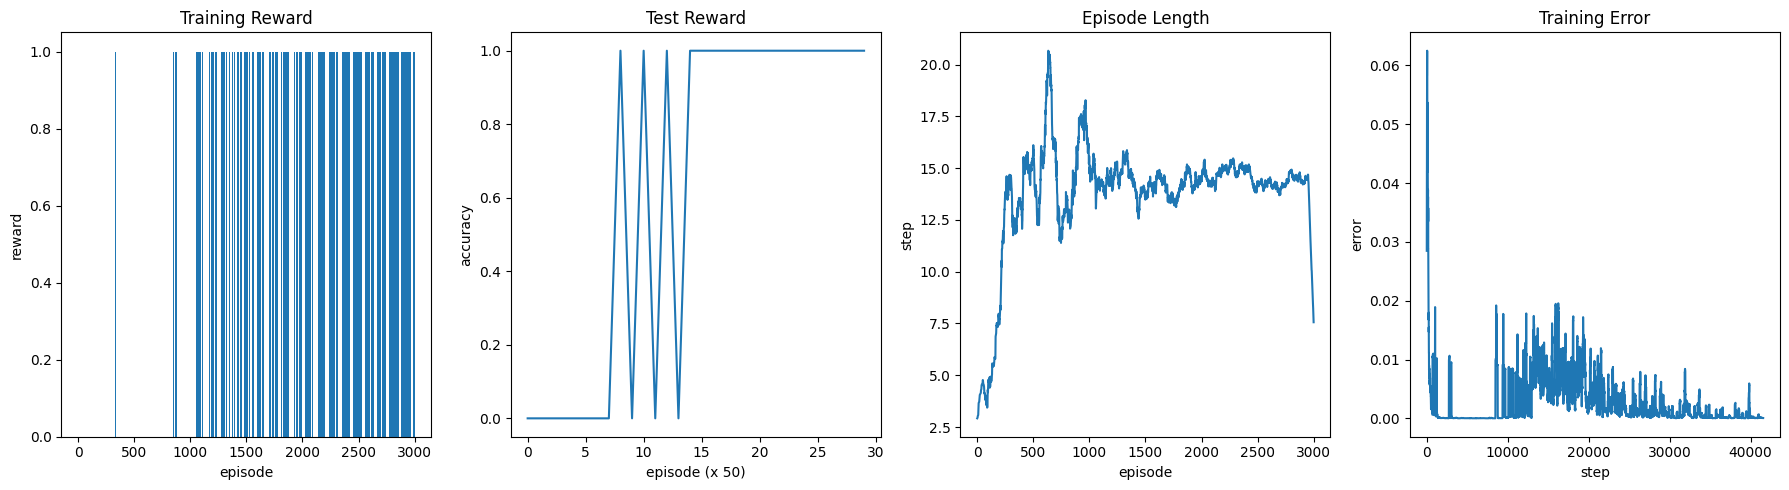

In [89]:
rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards)), rewards)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies)), accuracies)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

In [52]:
'def qtable_directions_map(qtable_val_max, qtable_best_action, map_size):
    """Get the best learned action & map it to arrows."""
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    for idx, val in enumerate(qtable_best_action.flatten()):
        qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

In [53]:
def plot_q_values_map(qtable_val_max, qtable_best_action, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable_val_max, qtable_best_action, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    plt.show()

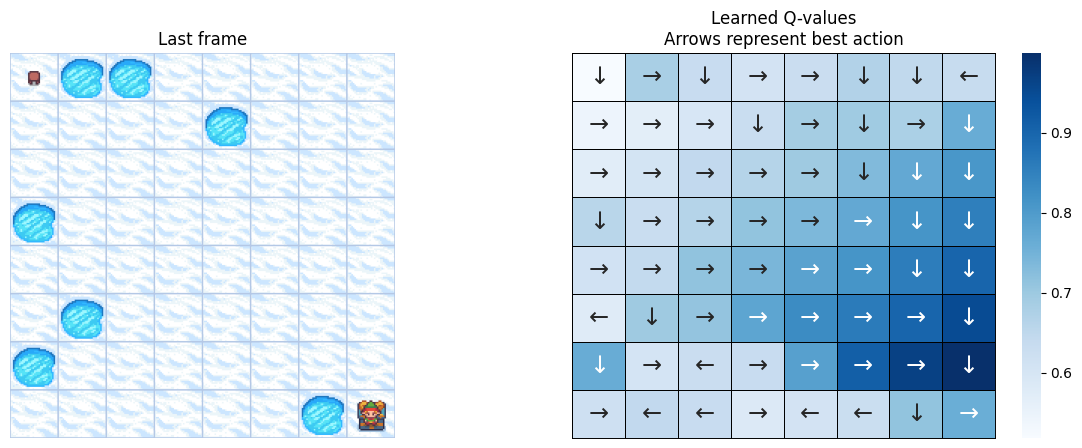

In [54]:
qtable_val_max = np.zeros((side_map_size, side_map_size))
qtable_best_action = np.zeros((side_map_size, side_map_size))
q_network = agent.get_Q_Network()

counter = 0
while counter < side_map_size * side_map_size:
    qtable_val_max[int(counter / side_map_size)][counter % side_map_size] = agent.max_eval_state(counter)
    qtable_best_action[int(counter / side_map_size)][counter % side_map_size] = agent.eval_state(counter)
    counter = counter + 1

plot_q_values_map(qtable_val_max, qtable_best_action, env, side_map_size)

## `Cart Pole`

O Cart-Pole em controlar um carrinho que pode se mover para a esquerda ou para a direita em uma pista reta, com o objetivo de equilibrar um pêndulo invertido  conectado ao carrinho por uma articulação.

O agente precisa aprender a aplicar forças ao carrinho para manter o pêndulo em pé e evitar que ele caia, enquanto também mantém o carrinho dentro dos limites da pista. O agente deve decidir, com base no estado do sistema, quais ações tomar em cada instante para maximizar a recompensa acumulada.


In [96]:
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()


In [97]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.spec

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, disable_env_checker=False, kwargs={'render_mode': 'rgb_array'}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

In [98]:
actions = ["push cart to the left", "push cart to the right"]
print ("Actions:", actions)

Actions: ['push cart to the left', 'push cart to the right']


Uma rede neural simples com uma camada com função de ativação sigmoide é criada.

In [99]:
class LinearNetwork(nn.Module):
    """
    Linear neural network for Q-learning and SARSA
    """
    def __init__(self, state_size, hidden_size, action_size):
        super(LinearNetwork, self).__init__()

        # These lines establish the feed-forward part of the neural network used to choose actions
        # Input layer with (one unit for each state variable)
        self.input_layer = nn.Linear(state_size, hidden_size)

        # Hidden layer with a number of hidden neurons
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)

        # Output layer (one unit for each action)
        self.output_layer = nn.Linear(hidden_size, action_size)

        print("Artificial neural network started with PyTorch")
        print("input =", state_size, ", Hidden =", hidden_size, ", output =", action_size)

    # Called with either one element to determine the action
    # Returns tensor([[left0exp,right0exp]...]).
    def forward(self, state):
        # Passing the state through the input layer
        x = self.input_layer(state)

        # Passing the input layer output through the hidden layer
        x = torch.relu(self.hidden_layer(x))

        # Passing the hidden layer output through the output layer
        return self.output_layer(x)

In [100]:
class QLearningAgent:

    def __init__(
        self,
        alpha_learning_rate,
        gamma_discount_factor,
        initial_epsilon,
        epsilon_decay,
        final_epsilon,
        state_space,
        hidden_size,
        action_space,
        device,
        model,
        optimizer,
        criterion,
        is_using_Sarsa
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            alpha_learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            gamma_discount_factor: The discount factor for computing the Q-value
            state_space: The state space
            action_space: The action space
            is_using_Sarsa: Sarsa or Q-learning method
        """
        self.alpha_learning_rate = alpha_learning_rate
        self.gamma_discount_factor = gamma_discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.state_space = state_space
        self.hidden_size = hidden_size
        self.action_space = action_space
        self.device = device
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.is_using_Sarsa = is_using_Sarsa
        self.training_error = []

        if(self.is_using_Sarsa):
            print("SARSA agent started")
        else:
            print("Q-learning agent started")

        # Set the seed
        self.rng = np.random.default_rng(123)

    def get_tensor(self, value):
        return torch.tensor(value, device=self.device, dtype=torch.float32)

    def eval_state(self, state):
        with torch.no_grad():
            state_tensor = self.get_tensor(state)
            q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()

    def choose_action(self, state):
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # First we randomize a number
        exploration_exploitation_tradeoff = self.rng.uniform(0, 1)

        # Exploration
        # with probability epsilon return a random action to explore the environment
        if exploration_exploitation_tradeoff < self.epsilon:
            return self.action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            with torch.no_grad():
                return self.eval_state(state)

    def update(
        self,
        state: np.array,
        action: int,
        reward: float,
        terminated: bool,
        next_state: np.array,
        next_action: int
    ):
        """Updates the neural network weights."""
        # Train the network using target and the predicted q_network values
        # Setting the model in training mode
        self.model.train()

        if terminated:
            target = self.get_tensor(reward) # Convert reward to tensor

        else:
            # Eval next state
            next_state_tensor = self.get_tensor(next_state) # Get one-hot encoded next state tensor

            with torch.no_grad():
                Q2 = self.model(next_state_tensor)

                # Sarsa: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * Q(s',a') - Q(s,a)]
                if(self.is_using_Sarsa):
                    target = reward + self.gamma_discount_factor * Q2[next_action].item() # Use next_action for Sarsa

                # Q-learning: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
                else:
                    target = reward + self.gamma_discount_factor * torch.max(Q2).item() # Use max Q-value for Q-learning

            target = self.get_tensor(target) # Convert target to tensor

        # Eval state
        state_tensor = self.get_tensor(state) # Get one-hot encoded state tensor
        Q1 = self.model(state_tensor) # Get the Q-value for the chosen action

        # Computing the loss (error between the predicted Q-value and the actual Q-value)
        temporal_difference_error = self.criterion(Q1[action], target)
        self.training_error.append(temporal_difference_error.item())

        # Reset accumulated gradients
        self.optimizer.zero_grad()

        # Performing backpropagation
        temporal_difference_error.backward()

        # Updating network parameters
        self.optimizer.step()

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)


In [101]:
# hyperparameters
alpha_learning_rate = 0.0003 # @param {type:"number"}
nb_max_episodes = 2000 # @param {type:"integer"}
start_epsilon = 0.5 # @param {type:"number"}
final_epsilon = 0.1 # @param {type:"number"}
epsilon_decay = (start_epsilon - final_epsilon) / nb_max_episodes  # reduce the exploration over time
gamma_discount_factor = 0.99 # @param {type:"number"}
is_using_Sarsa = False # @param {type:"boolean"}
test_freq = 100 # @param {type:"integer"}
total_steps = 0

# Starting the artificial neural network
# Check that there is a GPU avaiable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hidden_size = 64 # @param {type:"integer"}

# Input and output size based on the environment
# These lines establish the feed-forward part of the netwotk used to choose actions
model = LinearNetwork(env.observation_space.shape[0], hidden_size, env.action_space.n).to(device)

# Initialize optimizer that can be SGD, Adam, RMSprop, etc.
optimizer = optim.Adam(model.parameters(), lr=alpha_learning_rate)

# Initialize loss function using mean squared error
criterion = nn.MSELoss()

agent = QLearningAgent(
    alpha_learning_rate=alpha_learning_rate,
    gamma_discount_factor=gamma_discount_factor,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    state_space = env.observation_space,
    hidden_size = hidden_size,
    action_space = env.action_space,
    device = device,
    model = model,
    optimizer = optimizer,
    criterion = criterion,
    is_using_Sarsa = is_using_Sarsa
)

Artificial neural network started with PyTorch
input = 4 , Hidden = 64 , output = 2
Q-learning agent started


In [103]:
def test_accurracy(agent, num_steps, num_episodes=100):
    counter = 0
    nb_success = 0.0

    while counter < num_episodes:
        is_terminal = False
        state, info = env.reset()

        for i in range(num_steps):
            model.eval() # Putting the model into evaluation mode (without gradients)
            action = agent.eval_state(state)
            state, reward, terminated, truncated, info = env.step(action)
            is_terminal = terminated or truncated
            nb_success += reward

            if(is_terminal):
                break

        counter += 1

    return nb_success/counter

def record_trained_video(video_file, num_steps):
    video = VideoRecorder(env, video_file)

    # returns an initial observation
    state, info = env.reset()
    env.render()
    video.capture_frame()

    for i in range(num_steps):
        model.eval() # Putting the model into evaluation mode (without gradients)
        action = agent.eval_state(state)
        state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        env.render()
        video.capture_frame()

        if(is_terminal):
            print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
            break

    video.close()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:
from tqdm import tqdm
#Create lists to contain total rewards, steps and accurracy per episode
accuracies = []
mean_rewards = []
rewards = []
steps = []

for episode_count in tqdm(range(nb_max_episodes)):
    state, info = env.reset()
    is_terminal = False
    total_reward = 0
    episode_step = 0

    if(is_using_Sarsa): # Sarsa
        # Choose an action by greedily (with epsilon chance of random action) from the Q-Network
        action = agent.choose_action(state)

    # The Q-Network training
    while not is_terminal:
        episode_step += 1

        if(not is_using_Sarsa): # Q-learning
            # Choose an action by greedily (with epsilon chance of random action) from the Q-Network
            action = agent.choose_action(state)

        # Play best or random move and get new state and reward from environment
        next_state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        # update the agent
        if(not is_using_Sarsa): # Q-learning
            agent.update(state, action, reward, terminated, next_state, None)
        else: # Sarsa
            next_action = agent.choose_action(next_state)
            agent.update(state, action, reward, terminated, next_state, next_action)
            action = next_action

        # update the current observation
        state = next_state
        total_steps += 1
        total_reward += reward

    agent.decay_epsilon()

    mean_rewards.append(total_reward)
    if (episode_count+1) % test_freq == 0:
        accur = test_accurracy(env.spec.max_episode_steps,50)
        accuracies.append(accur)

        print('step: %s, episode: %s, accuracy training: %s, accuracy test: %s, random move probability: %s' % (total_steps, episode_count+1, sum(mean_rewards)/test_freq, accur, agent.epsilon))
        mean_rewards.clear()

    rewards.append(total_reward)
    steps.append(episode_step)

after_training = "after_training.mp4"
record_trained_video(after_training, env.spec.max_episode_steps)
env.close()

  5%|▌         | 103/2000 [00:02<01:22, 22.90it/s]

step: 1585, episode: 100, accuracy training: 15.85, accuracy test: 12.4, random move probability: 0.4800000000000022


 10%|█         | 210/2000 [00:06<00:45, 39.61it/s]

step: 3465, episode: 200, accuracy training: 18.8, accuracy test: 10.24, random move probability: 0.4600000000000044


 15%|█▌        | 301/2000 [00:09<00:44, 38.00it/s]

step: 5166, episode: 300, accuracy training: 17.01, accuracy test: 16.28, random move probability: 0.4400000000000066


 20%|██        | 401/2000 [00:12<01:07, 23.67it/s]

step: 7714, episode: 400, accuracy training: 25.48, accuracy test: 31.0, random move probability: 0.4200000000000088


 25%|██▌       | 502/2000 [00:17<03:03,  8.14it/s]

step: 10676, episode: 500, accuracy training: 29.62, accuracy test: 48.88, random move probability: 0.400000000000011


 30%|███       | 602/2000 [00:24<03:08,  7.43it/s]

step: 14100, episode: 600, accuracy training: 34.24, accuracy test: 158.16, random move probability: 0.3800000000000132


 35%|███▌      | 702/2000 [00:30<01:42, 12.66it/s]

step: 18518, episode: 700, accuracy training: 44.18, accuracy test: 16.7, random move probability: 0.3600000000000154


 40%|████      | 802/2000 [00:47<01:19, 15.13it/s]

step: 25534, episode: 800, accuracy training: 70.16, accuracy test: 11.5, random move probability: 0.3400000000000176


 45%|████▌     | 902/2000 [01:03<03:18,  5.52it/s]

step: 36346, episode: 900, accuracy training: 108.12, accuracy test: 41.98, random move probability: 0.3200000000000198


 50%|█████     | 1000/2000 [01:39<08:01,  2.08it/s]

step: 49086, episode: 1000, accuracy training: 127.4, accuracy test: 203.44, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [02:11<48:03,  3.20s/it]

step: 64023, episode: 1100, accuracy training: 149.37, accuracy test: 451.3, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [02:37<03:10,  4.19it/s]

step: 72780, episode: 1200, accuracy training: 87.57, accuracy test: 118.74, random move probability: 0.26000000000002643


 65%|██████▌   | 1301/2000 [02:54<01:57,  5.93it/s]

step: 83789, episode: 1300, accuracy training: 110.09, accuracy test: 89.18, random move probability: 0.24000000000002725


 70%|███████   | 1400/2000 [03:11<05:30,  1.81it/s]

step: 94771, episode: 1400, accuracy training: 109.82, accuracy test: 129.02, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [03:34<04:15,  1.95it/s]

step: 109764, episode: 1500, accuracy training: 149.93, accuracy test: 186.28, random move probability: 0.2000000000000261


 80%|███████▉  | 1599/2000 [04:09<01:58,  3.38it/s]

step: 132847, episode: 1600, accuracy training: 230.83, accuracy test: 500.0, random move probability: 0.18000000000002553


 85%|████████▌ | 1703/2000 [04:52<00:51,  5.77it/s]

step: 160110, episode: 1700, accuracy training: 272.63, accuracy test: 10.52, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [05:28<04:44,  1.42s/it]

step: 183653, episode: 1800, accuracy training: 235.43, accuracy test: 500.0, random move probability: 0.14000000000002438


 95%|█████████▌| 1900/2000 [06:05<00:13,  7.42it/s]

step: 207935, episode: 1900, accuracy training: 242.82, accuracy test: 9.32, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [06:40<00:00,  4.99it/s]

step: 232056, episode: 2000, accuracy training: 241.21, accuracy test: 126.48, random move probability: 0.10000000000002324



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 145 : push cart to the right , [-2.4109497  -0.8827571   0.00955821 -0.07756198] , 1.0 , True , False , {}


In [107]:
import time

def test_accurracy(agent, num_steps, num_episodes=100):
    counter = 0
    nb_success = 0.0

    while counter < num_episodes:
        is_terminal = False
        state, info = env.reset()

        for i in range(num_steps):
            action = agent.eval_state(state)
            state, reward, terminated, truncated, info = env.step(action)
            is_terminal = terminated or truncated
            nb_success += reward

            if(is_terminal):
                break

        counter += 1

    return nb_success/counter

alphas = [0.2, 0.5, 0.9]
epsilons = [0.2, 0.5, 0.9]
gammas = [0.2, 0.5, 0.9]

df_experiments_cp = pd.DataFrame(columns=['alpha', 'epsilon', 'gamma', 'accuracy', 'rewards', 'steps', 'error', 'agent'])

for alpha in alphas:
    for epsilon in epsilons:
        for gamma_discount_factor in gammas:
            print(f'Rodando alpha {alpha}, epsilon {epsilon} e gamma {gamma_discount_factor}')
            agent_sarsa = QLearningAgent(
                alpha_learning_rate=alpha_learning_rate,
                gamma_discount_factor=gamma_discount_factor,
                initial_epsilon=start_epsilon,
                epsilon_decay=epsilon_decay,
                final_epsilon=final_epsilon,
                state_space = env.observation_space,
                hidden_size = hidden_size,
                action_space = env.action_space,
                device = device,
                model = model,
                optimizer = optimizer,
                criterion = criterion,
                is_using_Sarsa = True
            )

            agent_q = QLearningAgent(
                alpha_learning_rate=alpha_learning_rate,
                gamma_discount_factor=gamma_discount_factor,
                initial_epsilon=start_epsilon,
                epsilon_decay=epsilon_decay,
                final_epsilon=final_epsilon,
                state_space = env.observation_space,
                hidden_size = hidden_size,
                action_space = env.action_space,
                device = device,
                model = model,
                optimizer = optimizer,
                criterion = criterion,
                is_using_Sarsa = False
            )

            start = time.time()
            after_training_sarsa, rewards_sarsa, steps_sarsa, accuracies_sarsa = train_agent(agent_sarsa, True)
            end = time.time()
            print(f'Tempo de treinamento SARSA: {end - start}')
            error = agent_sarsa.training_error
            df_experiments_cp = pd.concat([df_experiments_cp, pd.DataFrame({'alpha': [alpha],
                                                                      'epsilon': [epsilon],
                                                                      'gamma': [gamma_discount_factor],
                                                                      'accuracy': [accuracies_sarsa],
                                                                      'rewards': [rewards_sarsa],
                                                                      'steps': [steps_sarsa],
                                                                      'error': [error],
                                                                      'agent': ['tabular_sarsa']})])
            start = time.time()
            after_training_q, rewards_q, steps_q, accuracies_q = train_agent(agent_q, False)
            end = time.time()
            print(f'Tempo de treinamento Q-learning: {end - start}')
            error = agent_q.training_error
            df_experiments_cp = pd.concat([df_experiments_cp, pd.DataFrame({'alpha': [alpha],
                                                                      'epsilon': [epsilon],
                                                                      'gamma': [gamma_discount_factor],
                                                                      'accuracy': [accuracies_q],
                                                                      'rewards': [rewards_q],
                                                                      'steps': [steps_q],
                                                                      'error': [error],
                                                                      'agent': ['tabular_q']})])
            print(f'Len experiments {len(df_experiments_cp)}')


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Rodando alpha 0.2, epsilon 0.2 e gamma 0.2
SARSA agent started
Q-learning agent started


  5%|▌         | 103/2000 [00:05<01:58, 15.95it/s]

step: 2289, episode: 100, accuracy training: 22.89, accuracy test: 9.56, random move probability: 0.4800000000000022


 10%|█         | 202/2000 [00:08<00:58, 30.96it/s]

step: 4452, episode: 200, accuracy training: 21.63, accuracy test: 12.5, random move probability: 0.4600000000000044


 15%|█▌        | 303/2000 [00:11<01:32, 18.31it/s]

step: 6891, episode: 300, accuracy training: 24.39, accuracy test: 61.38, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [00:14<00:52, 30.48it/s]

step: 9053, episode: 400, accuracy training: 21.62, accuracy test: 25.94, random move probability: 0.4200000000000088


 25%|██▌       | 504/2000 [00:20<01:51, 13.45it/s]

step: 11466, episode: 500, accuracy training: 24.13, accuracy test: 135.1, random move probability: 0.400000000000011


 30%|███       | 601/2000 [00:23<00:56, 24.84it/s]

step: 13668, episode: 600, accuracy training: 22.02, accuracy test: 18.04, random move probability: 0.3800000000000132


 35%|███▌      | 704/2000 [00:28<01:19, 16.37it/s]

step: 16179, episode: 700, accuracy training: 25.11, accuracy test: 25.88, random move probability: 0.3600000000000154


 40%|████      | 804/2000 [00:32<00:59, 20.23it/s]

step: 18186, episode: 800, accuracy training: 20.07, accuracy test: 9.8, random move probability: 0.3400000000000176


 45%|████▌     | 906/2000 [00:36<00:35, 31.00it/s]

step: 20555, episode: 900, accuracy training: 23.69, accuracy test: 12.0, random move probability: 0.3200000000000198


 50%|█████     | 1002/2000 [00:40<00:32, 31.09it/s]

step: 23134, episode: 1000, accuracy training: 25.79, accuracy test: 9.78, random move probability: 0.300000000000022


 55%|█████▌    | 1105/2000 [00:43<00:25, 35.22it/s]

step: 25270, episode: 1100, accuracy training: 21.36, accuracy test: 9.78, random move probability: 0.28000000000002423


 60%|██████    | 1202/2000 [00:47<01:26,  9.24it/s]

step: 27050, episode: 1200, accuracy training: 17.8, accuracy test: 52.74, random move probability: 0.26000000000002643


 65%|██████▍   | 1299/2000 [00:50<00:37, 18.77it/s]

step: 29572, episode: 1300, accuracy training: 25.22, accuracy test: 25.62, random move probability: 0.24000000000002725


 70%|███████   | 1404/2000 [00:54<00:20, 29.00it/s]

step: 32293, episode: 1400, accuracy training: 27.21, accuracy test: 10.64, random move probability: 0.22000000000002667


 75%|███████▌  | 1505/2000 [01:00<00:23, 21.08it/s]

step: 35669, episode: 1500, accuracy training: 33.76, accuracy test: 9.28, random move probability: 0.2000000000000261


 80%|████████  | 1609/2000 [01:06<00:09, 42.63it/s]

step: 38922, episode: 1600, accuracy training: 32.53, accuracy test: 9.42, random move probability: 0.18000000000002553


 85%|████████▌ | 1705/2000 [01:09<00:15, 18.82it/s]

step: 41754, episode: 1700, accuracy training: 28.32, accuracy test: 14.5, random move probability: 0.16000000000002496


 90%|█████████ | 1806/2000 [01:13<00:06, 30.77it/s]

step: 44163, episode: 1800, accuracy training: 24.09, accuracy test: 9.84, random move probability: 0.14000000000002438


 95%|█████████▌| 1902/2000 [01:20<00:07, 12.31it/s]

step: 47810, episode: 1900, accuracy training: 36.47, accuracy test: 11.28, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [01:23<00:00, 24.08it/s]
<ipython-input-107-1f786a7dc552>:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_experiments_cp = pd.concat([df_experiments_cp, pd.DataFrame({'alpha': [alpha],


step: 50173, episode: 2000, accuracy training: 23.63, accuracy test: 9.92, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 83.08683276176453


  5%|▌         | 103/2000 [00:05<01:56, 16.33it/s]

step: 3396, episode: 100, accuracy training: 33.96, accuracy test: 9.42, random move probability: 0.4800000000000022


 10%|█         | 204/2000 [00:12<03:56,  7.60it/s]

step: 6466, episode: 200, accuracy training: 30.7, accuracy test: 181.04, random move probability: 0.4600000000000044


 15%|█▌        | 300/2000 [00:16<01:03, 26.85it/s]

step: 10117, episode: 300, accuracy training: 36.51, accuracy test: 10.62, random move probability: 0.4400000000000066


 20%|██        | 402/2000 [00:24<01:06, 24.11it/s]

step: 14379, episode: 400, accuracy training: 42.62, accuracy test: 9.38, random move probability: 0.4200000000000088


 25%|██▌       | 504/2000 [00:28<01:04, 23.26it/s]

step: 17505, episode: 500, accuracy training: 31.26, accuracy test: 9.48, random move probability: 0.400000000000011


 30%|███       | 604/2000 [00:32<01:05, 21.20it/s]

step: 20034, episode: 600, accuracy training: 25.29, accuracy test: 9.16, random move probability: 0.3800000000000132


 35%|███▌      | 707/2000 [00:37<01:10, 18.31it/s]

step: 22425, episode: 700, accuracy training: 23.91, accuracy test: 93.04, random move probability: 0.3600000000000154


 40%|████      | 802/2000 [00:40<00:52, 22.72it/s]

step: 24828, episode: 800, accuracy training: 24.03, accuracy test: 12.26, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [00:45<01:07, 16.25it/s]

step: 27866, episode: 900, accuracy training: 30.38, accuracy test: 31.56, random move probability: 0.3200000000000198


 50%|█████     | 1005/2000 [00:51<00:32, 30.55it/s]

step: 31021, episode: 1000, accuracy training: 31.55, accuracy test: 9.86, random move probability: 0.300000000000022


 55%|█████▌    | 1106/2000 [00:54<00:22, 39.38it/s]

step: 33130, episode: 1100, accuracy training: 21.09, accuracy test: 13.1, random move probability: 0.28000000000002423


 60%|██████    | 1207/2000 [00:57<00:22, 35.73it/s]

step: 35384, episode: 1200, accuracy training: 22.54, accuracy test: 13.3, random move probability: 0.26000000000002643


 65%|██████▌   | 1302/2000 [01:03<00:32, 21.27it/s]

step: 38168, episode: 1300, accuracy training: 27.84, accuracy test: 9.46, random move probability: 0.24000000000002725


 71%|███████   | 1412/2000 [01:06<00:13, 43.73it/s]

step: 40362, episode: 1400, accuracy training: 21.94, accuracy test: 10.08, random move probability: 0.22000000000002667


 75%|███████▌  | 1509/2000 [01:09<00:12, 40.49it/s]

step: 42683, episode: 1500, accuracy training: 23.21, accuracy test: 10.52, random move probability: 0.2000000000000261


 80%|████████  | 1606/2000 [01:12<00:08, 48.96it/s]

step: 44447, episode: 1600, accuracy training: 17.64, accuracy test: 9.42, random move probability: 0.18000000000002553


 86%|████████▌ | 1710/2000 [01:18<00:09, 31.52it/s]

step: 47668, episode: 1700, accuracy training: 32.21, accuracy test: 12.76, random move probability: 0.16000000000002496


 90%|█████████ | 1804/2000 [01:21<00:07, 28.00it/s]

step: 49541, episode: 1800, accuracy training: 18.73, accuracy test: 10.5, random move probability: 0.14000000000002438


 95%|█████████▌| 1909/2000 [01:25<00:03, 30.31it/s]

step: 52332, episode: 1900, accuracy training: 27.91, accuracy test: 10.06, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [01:27<00:00, 22.82it/s]


step: 54150, episode: 2000, accuracy training: 18.18, accuracy test: 9.54, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 87.66804242134094
Len experiments 2
Rodando alpha 0.2, epsilon 0.2 e gamma 0.5
SARSA agent started
Q-learning agent started


  5%|▍         | 98/2000 [00:10<01:42, 18.61it/s]

step: 6093, episode: 100, accuracy training: 60.93, accuracy test: 162.64, random move probability: 0.4800000000000022


 10%|█         | 201/2000 [00:27<10:52,  2.76it/s]

step: 14151, episode: 200, accuracy training: 80.58, accuracy test: 500.0, random move probability: 0.4600000000000044


 15%|█▌        | 302/2000 [00:40<07:36,  3.72it/s]

step: 20557, episode: 300, accuracy training: 64.06, accuracy test: 500.0, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [00:48<03:22,  7.91it/s]

step: 25179, episode: 400, accuracy training: 46.22, accuracy test: 104.54, random move probability: 0.4200000000000088


 25%|██▍       | 499/2000 [00:56<03:05,  8.10it/s]

step: 31503, episode: 500, accuracy training: 63.24, accuracy test: 129.06, random move probability: 0.400000000000011


 30%|███       | 600/2000 [01:11<09:37,  2.43it/s]

step: 38658, episode: 600, accuracy training: 71.55, accuracy test: 500.0, random move probability: 0.3800000000000132


 35%|███▌      | 706/2000 [01:23<00:50, 25.69it/s]

step: 46349, episode: 700, accuracy training: 76.91, accuracy test: 10.04, random move probability: 0.3600000000000154


 40%|████      | 802/2000 [01:34<02:01,  9.85it/s]

step: 52321, episode: 800, accuracy training: 59.72, accuracy test: 93.78, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [01:44<04:37,  3.96it/s]

step: 58038, episode: 900, accuracy training: 57.17, accuracy test: 142.8, random move probability: 0.3200000000000198


 50%|█████     | 1004/2000 [01:58<01:45,  9.48it/s]

step: 66265, episode: 1000, accuracy training: 82.27, accuracy test: 21.46, random move probability: 0.300000000000022


 55%|█████▌    | 1107/2000 [02:03<00:36, 24.62it/s]

step: 70377, episode: 1100, accuracy training: 41.12, accuracy test: 22.46, random move probability: 0.28000000000002423


 60%|██████    | 1207/2000 [02:13<00:50, 15.65it/s]

step: 76134, episode: 1200, accuracy training: 57.57, accuracy test: 10.84, random move probability: 0.26000000000002643


 65%|██████▌   | 1301/2000 [02:21<02:16,  5.13it/s]

step: 81795, episode: 1300, accuracy training: 56.61, accuracy test: 85.52, random move probability: 0.24000000000002725


 70%|███████   | 1402/2000 [02:28<00:48, 12.29it/s]

step: 85411, episode: 1400, accuracy training: 36.16, accuracy test: 92.38, random move probability: 0.22000000000002667


 75%|███████▌  | 1502/2000 [02:44<01:47,  4.61it/s]

step: 94279, episode: 1500, accuracy training: 88.68, accuracy test: 83.64, random move probability: 0.2000000000000261


 80%|████████  | 1603/2000 [02:58<00:38, 10.42it/s]

step: 103071, episode: 1600, accuracy training: 87.92, accuracy test: 21.64, random move probability: 0.18000000000002553


 85%|████████▌ | 1702/2000 [03:12<00:41,  7.24it/s]

step: 111795, episode: 1700, accuracy training: 87.24, accuracy test: 82.1, random move probability: 0.16000000000002496


 90%|█████████ | 1802/2000 [03:18<00:10, 18.29it/s]

step: 116053, episode: 1800, accuracy training: 42.58, accuracy test: 81.58, random move probability: 0.14000000000002438


 95%|█████████▌| 1902/2000 [03:31<00:16,  5.94it/s]

step: 123933, episode: 1900, accuracy training: 78.8, accuracy test: 61.6, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [03:44<00:00,  8.92it/s]


step: 132020, episode: 2000, accuracy training: 80.87, accuracy test: 27.92, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 224.11820268630981


  5%|▌         | 100/2000 [00:05<01:33, 20.24it/s]

step: 3602, episode: 100, accuracy training: 36.02, accuracy test: 26.34, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:13<04:02,  7.42it/s]

step: 7992, episode: 200, accuracy training: 43.9, accuracy test: 97.58, random move probability: 0.4600000000000044


 15%|█▌        | 307/2000 [00:18<01:12, 23.34it/s]

step: 11534, episode: 300, accuracy training: 35.42, accuracy test: 9.94, random move probability: 0.4400000000000066


 20%|██        | 405/2000 [00:24<02:44,  9.68it/s]

step: 14698, episode: 400, accuracy training: 31.64, accuracy test: 118.58, random move probability: 0.4200000000000088


 25%|██▌       | 506/2000 [00:31<01:58, 12.64it/s]

step: 19397, episode: 500, accuracy training: 46.99, accuracy test: 97.82, random move probability: 0.400000000000011


 30%|███       | 600/2000 [00:40<03:17,  7.09it/s]

step: 24108, episode: 600, accuracy training: 47.11, accuracy test: 158.14, random move probability: 0.3800000000000132


 35%|███▍      | 698/2000 [00:45<00:45, 28.85it/s]

step: 27963, episode: 700, accuracy training: 38.55, accuracy test: 230.42, random move probability: 0.3600000000000154


 40%|████      | 807/2000 [00:56<00:52, 22.68it/s]

step: 33956, episode: 800, accuracy training: 59.93, accuracy test: 9.64, random move probability: 0.3400000000000176


 45%|████▍     | 899/2000 [01:01<01:29, 12.36it/s]

step: 37806, episode: 900, accuracy training: 38.5, accuracy test: 57.22, random move probability: 0.3200000000000198


 50%|█████     | 1009/2000 [01:10<00:41, 23.63it/s]

step: 42604, episode: 1000, accuracy training: 47.98, accuracy test: 12.16, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [01:18<03:59,  3.77it/s]

step: 47429, episode: 1100, accuracy training: 48.25, accuracy test: 120.02, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [01:33<05:12,  2.56it/s]

step: 55279, episode: 1200, accuracy training: 78.5, accuracy test: 94.66, random move probability: 0.26000000000002643


 65%|██████▌   | 1305/2000 [01:44<00:19, 35.65it/s]

step: 62481, episode: 1300, accuracy training: 72.02, accuracy test: 10.02, random move probability: 0.24000000000002725


 70%|███████   | 1400/2000 [01:55<00:54, 10.96it/s]

step: 69460, episode: 1400, accuracy training: 69.79, accuracy test: 12.36, random move probability: 0.22000000000002667


 75%|███████▍  | 1498/2000 [02:00<00:26, 18.64it/s]

step: 73438, episode: 1500, accuracy training: 39.78, accuracy test: 69.22, random move probability: 0.2000000000000261


 80%|████████  | 1606/2000 [02:12<00:11, 35.38it/s]

step: 80394, episode: 1600, accuracy training: 69.56, accuracy test: 18.0, random move probability: 0.18000000000002553


 85%|████████▌ | 1702/2000 [02:25<00:55,  5.41it/s]

step: 87858, episode: 1700, accuracy training: 74.64, accuracy test: 125.8, random move probability: 0.16000000000002496


 90%|█████████ | 1807/2000 [02:33<00:10, 18.77it/s]

step: 92595, episode: 1800, accuracy training: 47.37, accuracy test: 18.74, random move probability: 0.14000000000002438


 95%|█████████▌| 1903/2000 [02:37<00:01, 49.08it/s]

step: 95461, episode: 1900, accuracy training: 28.66, accuracy test: 14.14, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [02:47<00:00, 11.96it/s]


step: 101581, episode: 2000, accuracy training: 61.2, accuracy test: 10.04, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 167.237943649292
Len experiments 4
Rodando alpha 0.2, epsilon 0.2 e gamma 0.9
SARSA agent started
Q-learning agent started


  5%|▌         | 100/2000 [00:15<29:44,  1.06it/s]

step: 8635, episode: 100, accuracy training: 86.35, accuracy test: 466.1, random move probability: 0.4800000000000022


 10%|▉         | 199/2000 [00:34<03:03,  9.80it/s]

step: 21612, episode: 200, accuracy training: 129.77, accuracy test: 500.0, random move probability: 0.4600000000000044


 15%|█▌        | 301/2000 [01:02<08:10,  3.46it/s]

step: 37348, episode: 300, accuracy training: 157.36, accuracy test: 147.3, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [01:27<08:33,  3.11it/s]

step: 51340, episode: 400, accuracy training: 139.92, accuracy test: 160.64, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [01:50<22:46,  1.10it/s]

step: 65576, episode: 500, accuracy training: 142.36, accuracy test: 208.8, random move probability: 0.400000000000011


 30%|███       | 600/2000 [02:10<07:04,  3.30it/s]

step: 78628, episode: 600, accuracy training: 130.52, accuracy test: 162.44, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [02:33<10:39,  2.03it/s]

step: 92369, episode: 700, accuracy training: 137.41, accuracy test: 120.8, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [02:57<07:35,  2.63it/s]

step: 108678, episode: 800, accuracy training: 163.09, accuracy test: 110.44, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [03:24<06:30,  2.81it/s]

step: 125258, episode: 900, accuracy training: 165.8, accuracy test: 166.78, random move probability: 0.3200000000000198


 50%|█████     | 1000/2000 [03:55<14:17,  1.17it/s]

step: 143548, episode: 1000, accuracy training: 182.9, accuracy test: 122.46, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [04:23<14:50,  1.01it/s]

step: 159990, episode: 1100, accuracy training: 164.42, accuracy test: 500.0, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [04:48<04:14,  3.14it/s]

step: 175667, episode: 1200, accuracy training: 156.77, accuracy test: 129.18, random move probability: 0.26000000000002643


 65%|██████▌   | 1303/2000 [05:11<02:07,  5.49it/s]

step: 189947, episode: 1300, accuracy training: 142.8, accuracy test: 122.22, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [05:31<02:12,  4.53it/s]

step: 202503, episode: 1400, accuracy training: 125.56, accuracy test: 111.68, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [05:51<02:12,  3.75it/s]

step: 214558, episode: 1500, accuracy training: 120.55, accuracy test: 108.86, random move probability: 0.2000000000000261


 80%|████████  | 1601/2000 [06:12<01:51,  3.58it/s]

step: 228086, episode: 1600, accuracy training: 135.28, accuracy test: 109.06, random move probability: 0.18000000000002553


 85%|████████▌ | 1700/2000 [06:40<01:44,  2.87it/s]

step: 244269, episode: 1700, accuracy training: 161.83, accuracy test: 141.06, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [07:02<01:07,  2.97it/s]

step: 258045, episode: 1800, accuracy training: 137.76, accuracy test: 34.82, random move probability: 0.14000000000002438


 95%|█████████▌| 1901/2000 [07:27<00:28,  3.47it/s]

step: 273856, episode: 1900, accuracy training: 158.11, accuracy test: 136.36, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [07:53<00:00,  4.22it/s]


step: 290216, episode: 2000, accuracy training: 163.6, accuracy test: 126.2, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 473.41039538383484


  5%|▌         | 101/2000 [00:16<16:34,  1.91it/s]

step: 8913, episode: 100, accuracy training: 89.13, accuracy test: 500.0, random move probability: 0.4800000000000022


 10%|█         | 202/2000 [00:30<03:55,  7.65it/s]

step: 17350, episode: 200, accuracy training: 84.37, accuracy test: 114.18, random move probability: 0.4600000000000044


 15%|█▌        | 300/2000 [00:44<07:23,  3.84it/s]

step: 26740, episode: 300, accuracy training: 93.9, accuracy test: 122.94, random move probability: 0.4400000000000066


 20%|██        | 401/2000 [01:03<07:17,  3.66it/s]

step: 36334, episode: 400, accuracy training: 95.94, accuracy test: 119.96, random move probability: 0.4200000000000088


 25%|██▌       | 503/2000 [01:18<03:33,  7.02it/s]

step: 45558, episode: 500, accuracy training: 92.24, accuracy test: 95.76, random move probability: 0.400000000000011


 30%|███       | 600/2000 [01:35<04:03,  5.75it/s]

step: 56676, episode: 600, accuracy training: 111.18, accuracy test: 98.8, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [01:50<03:46,  5.74it/s]

step: 65804, episode: 700, accuracy training: 91.28, accuracy test: 105.84, random move probability: 0.3600000000000154


 40%|████      | 807/2000 [02:06<01:58, 10.04it/s]

step: 76534, episode: 800, accuracy training: 107.3, accuracy test: 132.62, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [02:22<03:27,  5.30it/s]

step: 86165, episode: 900, accuracy training: 96.31, accuracy test: 93.2, random move probability: 0.3200000000000198


 50%|█████     | 1000/2000 [02:39<09:03,  1.84it/s]

step: 96445, episode: 1000, accuracy training: 102.8, accuracy test: 142.14, random move probability: 0.300000000000022


 55%|█████▌    | 1102/2000 [02:57<01:37,  9.21it/s]

step: 107129, episode: 1100, accuracy training: 106.84, accuracy test: 97.44, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [03:13<02:24,  5.53it/s]

step: 117370, episode: 1200, accuracy training: 102.41, accuracy test: 108.92, random move probability: 0.26000000000002643


 65%|██████▌   | 1300/2000 [03:34<04:08,  2.81it/s]

step: 129155, episode: 1300, accuracy training: 117.85, accuracy test: 152.12, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [03:52<02:34,  3.89it/s]

step: 139453, episode: 1400, accuracy training: 102.98, accuracy test: 90.18, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [04:09<01:17,  6.43it/s]

step: 150000, episode: 1500, accuracy training: 105.47, accuracy test: 97.58, random move probability: 0.2000000000000261


 80%|████████  | 1601/2000 [04:27<01:26,  4.63it/s]

step: 161406, episode: 1600, accuracy training: 114.06, accuracy test: 94.34, random move probability: 0.18000000000002553


 85%|████████▌ | 1701/2000 [04:48<02:03,  2.43it/s]

step: 173704, episode: 1700, accuracy training: 122.98, accuracy test: 153.94, random move probability: 0.16000000000002496


 90%|█████████ | 1801/2000 [05:07<01:02,  3.20it/s]

step: 185403, episode: 1800, accuracy training: 116.99, accuracy test: 124.88, random move probability: 0.14000000000002438


 95%|█████████▌| 1901/2000 [05:26<00:21,  4.63it/s]

step: 197364, episode: 1900, accuracy training: 119.61, accuracy test: 90.06, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [05:49<00:00,  5.72it/s]


step: 211130, episode: 2000, accuracy training: 137.66, accuracy test: 187.4, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 349.4830813407898
Len experiments 6
Rodando alpha 0.2, epsilon 0.5 e gamma 0.2
SARSA agent started
Q-learning agent started


  6%|▌         | 111/2000 [00:02<00:37, 50.20it/s]

step: 1956, episode: 100, accuracy training: 19.56, accuracy test: 9.6, random move probability: 0.4800000000000022


 10%|█         | 205/2000 [00:04<00:43, 41.02it/s]

step: 3355, episode: 200, accuracy training: 13.99, accuracy test: 9.36, random move probability: 0.4600000000000044


 15%|█▌        | 304/2000 [00:08<01:16, 22.31it/s]

step: 4683, episode: 300, accuracy training: 13.28, accuracy test: 9.48, random move probability: 0.4400000000000066


 20%|██        | 402/2000 [00:12<01:15, 21.19it/s]

step: 6096, episode: 400, accuracy training: 14.13, accuracy test: 10.98, random move probability: 0.4200000000000088


 25%|██▌       | 508/2000 [00:14<00:32, 45.83it/s]

step: 7463, episode: 500, accuracy training: 13.67, accuracy test: 9.34, random move probability: 0.400000000000011


 30%|███       | 606/2000 [00:16<00:26, 51.78it/s]

step: 8849, episode: 600, accuracy training: 13.86, accuracy test: 9.34, random move probability: 0.3800000000000132


 36%|███▌      | 711/2000 [00:18<00:27, 47.47it/s]

step: 10239, episode: 700, accuracy training: 13.9, accuracy test: 9.42, random move probability: 0.3600000000000154


 40%|████      | 804/2000 [00:20<00:32, 37.21it/s]

step: 11646, episode: 800, accuracy training: 14.07, accuracy test: 9.3, random move probability: 0.3400000000000176


 45%|████▌     | 904/2000 [00:24<00:54, 20.27it/s]

step: 13047, episode: 900, accuracy training: 14.01, accuracy test: 9.18, random move probability: 0.3200000000000198


 50%|█████     | 1010/2000 [00:26<00:19, 51.83it/s]

step: 14334, episode: 1000, accuracy training: 12.87, accuracy test: 9.44, random move probability: 0.300000000000022


 55%|█████▌    | 1105/2000 [00:28<00:19, 46.20it/s]

step: 15679, episode: 1100, accuracy training: 13.45, accuracy test: 9.32, random move probability: 0.28000000000002423


 60%|██████    | 1207/2000 [00:30<00:15, 51.55it/s]

step: 17016, episode: 1200, accuracy training: 13.37, accuracy test: 9.36, random move probability: 0.26000000000002643


 65%|██████▌   | 1309/2000 [00:32<00:13, 49.51it/s]

step: 18365, episode: 1300, accuracy training: 13.49, accuracy test: 9.24, random move probability: 0.24000000000002725


 70%|███████   | 1405/2000 [00:34<00:10, 56.57it/s]

step: 19520, episode: 1400, accuracy training: 11.55, accuracy test: 9.34, random move probability: 0.22000000000002667


 75%|███████▌  | 1505/2000 [00:36<00:15, 32.77it/s]

step: 20792, episode: 1500, accuracy training: 12.72, accuracy test: 9.42, random move probability: 0.2000000000000261


 81%|████████  | 1612/2000 [00:39<00:07, 53.32it/s]

step: 21980, episode: 1600, accuracy training: 11.88, accuracy test: 9.2, random move probability: 0.18000000000002553


 86%|████████▌ | 1710/2000 [00:41<00:05, 49.36it/s]

step: 23199, episode: 1700, accuracy training: 12.19, accuracy test: 9.28, random move probability: 0.16000000000002496


 91%|█████████ | 1812/2000 [00:43<00:03, 54.98it/s]

step: 24320, episode: 1800, accuracy training: 11.21, accuracy test: 9.44, random move probability: 0.14000000000002438


 95%|█████████▌| 1904/2000 [00:44<00:01, 58.38it/s]

step: 25346, episode: 1900, accuracy training: 10.26, accuracy test: 9.4, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [00:45<00:00, 43.48it/s]


step: 26484, episode: 2000, accuracy training: 11.38, accuracy test: 9.28, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 46.00688600540161


  5%|▌         | 106/2000 [00:02<00:47, 40.20it/s]

step: 1679, episode: 100, accuracy training: 16.79, accuracy test: 11.28, random move probability: 0.4800000000000022


 10%|█         | 203/2000 [00:05<01:16, 23.39it/s]

step: 3153, episode: 200, accuracy training: 14.74, accuracy test: 9.4, random move probability: 0.4600000000000044


 15%|█▌        | 309/2000 [00:08<00:37, 45.48it/s]

step: 4670, episode: 300, accuracy training: 15.17, accuracy test: 13.86, random move probability: 0.4400000000000066


 20%|██        | 407/2000 [00:11<00:35, 45.32it/s]

step: 6206, episode: 400, accuracy training: 15.36, accuracy test: 9.38, random move probability: 0.4200000000000088


 25%|██▌       | 506/2000 [00:13<00:31, 47.80it/s]

step: 7748, episode: 500, accuracy training: 15.42, accuracy test: 9.42, random move probability: 0.400000000000011


 30%|███       | 602/2000 [00:15<00:39, 35.84it/s]

step: 9460, episode: 600, accuracy training: 17.12, accuracy test: 10.68, random move probability: 0.3800000000000132


 35%|███▌      | 704/2000 [00:18<00:47, 27.43it/s]

step: 11071, episode: 700, accuracy training: 16.11, accuracy test: 9.5, random move probability: 0.3600000000000154


 40%|████      | 803/2000 [00:21<01:00, 19.64it/s]

step: 12383, episode: 800, accuracy training: 13.12, accuracy test: 14.94, random move probability: 0.3400000000000176


 45%|████▌     | 907/2000 [00:24<00:27, 39.93it/s]

step: 14033, episode: 900, accuracy training: 16.5, accuracy test: 13.76, random move probability: 0.3200000000000198


 50%|█████     | 1002/2000 [00:26<00:25, 38.52it/s]

step: 15478, episode: 1000, accuracy training: 14.45, accuracy test: 18.74, random move probability: 0.300000000000022


 55%|█████▌    | 1106/2000 [00:28<00:20, 44.60it/s]

step: 17121, episode: 1100, accuracy training: 16.43, accuracy test: 11.46, random move probability: 0.28000000000002423


 60%|██████    | 1207/2000 [00:30<00:18, 42.97it/s]

step: 18485, episode: 1200, accuracy training: 13.64, accuracy test: 9.6, random move probability: 0.26000000000002643


 65%|██████▌   | 1305/2000 [00:33<00:23, 28.98it/s]

step: 19843, episode: 1300, accuracy training: 13.58, accuracy test: 11.42, random move probability: 0.24000000000002725


 70%|███████   | 1406/2000 [00:36<00:16, 35.03it/s]

step: 21300, episode: 1400, accuracy training: 14.57, accuracy test: 14.24, random move probability: 0.22000000000002667


 75%|███████▌  | 1509/2000 [00:38<00:08, 56.93it/s]

step: 22629, episode: 1500, accuracy training: 13.29, accuracy test: 9.72, random move probability: 0.2000000000000261


 80%|████████  | 1605/2000 [00:40<00:10, 39.06it/s]

step: 24129, episode: 1600, accuracy training: 15.0, accuracy test: 9.66, random move probability: 0.18000000000002553


 86%|████████▌ | 1710/2000 [00:42<00:06, 45.04it/s]

step: 25438, episode: 1700, accuracy training: 13.09, accuracy test: 15.36, random move probability: 0.16000000000002496


 90%|█████████ | 1804/2000 [00:44<00:05, 38.20it/s]

step: 26886, episode: 1800, accuracy training: 14.48, accuracy test: 11.0, random move probability: 0.14000000000002438


 95%|█████████▌| 1904/2000 [00:47<00:03, 30.14it/s]

step: 28248, episode: 1900, accuracy training: 13.62, accuracy test: 10.66, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [00:50<00:00, 39.67it/s]


step: 29518, episode: 2000, accuracy training: 12.7, accuracy test: 10.46, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 50.43069887161255
Len experiments 8
Rodando alpha 0.2, epsilon 0.5 e gamma 0.5
SARSA agent started
Q-learning agent started


  5%|▌         | 105/2000 [00:02<00:48, 39.19it/s]

step: 1627, episode: 100, accuracy training: 16.27, accuracy test: 12.76, random move probability: 0.4800000000000022


 10%|█         | 205/2000 [00:04<00:39, 44.92it/s]

step: 3227, episode: 200, accuracy training: 16.0, accuracy test: 11.1, random move probability: 0.4600000000000044


 15%|█▌        | 309/2000 [00:06<00:37, 45.44it/s]

step: 4645, episode: 300, accuracy training: 14.18, accuracy test: 10.66, random move probability: 0.4400000000000066


 20%|██        | 404/2000 [00:08<00:35, 45.34it/s]

step: 6080, episode: 400, accuracy training: 14.35, accuracy test: 12.52, random move probability: 0.4200000000000088


 25%|██▌       | 503/2000 [00:11<01:00, 24.82it/s]

step: 7508, episode: 500, accuracy training: 14.28, accuracy test: 12.78, random move probability: 0.400000000000011


 30%|███       | 607/2000 [00:15<00:41, 33.35it/s]

step: 9124, episode: 600, accuracy training: 16.16, accuracy test: 16.44, random move probability: 0.3800000000000132


 35%|███▌      | 707/2000 [00:17<00:31, 40.95it/s]

step: 10634, episode: 700, accuracy training: 15.1, accuracy test: 10.42, random move probability: 0.3600000000000154


 40%|████      | 807/2000 [00:19<00:26, 45.18it/s]

step: 12210, episode: 800, accuracy training: 15.76, accuracy test: 9.62, random move probability: 0.3400000000000176


 45%|████▌     | 909/2000 [00:22<00:25, 43.14it/s]

step: 13764, episode: 900, accuracy training: 15.54, accuracy test: 14.04, random move probability: 0.3200000000000198


 50%|█████     | 1010/2000 [00:24<00:21, 45.84it/s]

step: 15271, episode: 1000, accuracy training: 15.07, accuracy test: 9.58, random move probability: 0.300000000000022


 55%|█████▌    | 1103/2000 [00:27<00:51, 17.52it/s]

step: 16806, episode: 1100, accuracy training: 15.35, accuracy test: 17.7, random move probability: 0.28000000000002423


 60%|██████    | 1207/2000 [00:31<00:20, 39.37it/s]

step: 18571, episode: 1200, accuracy training: 17.65, accuracy test: 10.32, random move probability: 0.26000000000002643


 65%|██████▌   | 1309/2000 [00:33<00:12, 55.70it/s]

step: 20360, episode: 1300, accuracy training: 17.89, accuracy test: 9.76, random move probability: 0.24000000000002725


 70%|███████   | 1405/2000 [00:35<00:11, 51.91it/s]

step: 21668, episode: 1400, accuracy training: 13.08, accuracy test: 10.18, random move probability: 0.22000000000002667


 75%|███████▌  | 1502/2000 [00:38<00:17, 28.13it/s]

step: 23786, episode: 1500, accuracy training: 21.18, accuracy test: 10.52, random move probability: 0.2000000000000261


 80%|████████  | 1604/2000 [00:43<00:25, 15.47it/s]

step: 26007, episode: 1600, accuracy training: 22.21, accuracy test: 29.34, random move probability: 0.18000000000002553


 85%|████████▌ | 1704/2000 [00:46<00:08, 36.01it/s]

step: 27626, episode: 1700, accuracy training: 16.19, accuracy test: 37.3, random move probability: 0.16000000000002496


 90%|█████████ | 1808/2000 [00:49<00:06, 30.83it/s]

step: 29883, episode: 1800, accuracy training: 22.57, accuracy test: 10.08, random move probability: 0.14000000000002438


 95%|█████████▌| 1908/2000 [00:51<00:01, 54.90it/s]

step: 31109, episode: 1900, accuracy training: 12.26, accuracy test: 9.44, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [00:53<00:00, 37.58it/s]


step: 32493, episode: 2000, accuracy training: 13.84, accuracy test: 10.92, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 53.22586417198181


  5%|▌         | 103/2000 [00:06<02:28, 12.81it/s]

step: 2854, episode: 100, accuracy training: 28.54, accuracy test: 53.54, random move probability: 0.4800000000000022


 10%|█         | 201/2000 [00:11<04:03,  7.37it/s]

step: 5716, episode: 200, accuracy training: 28.62, accuracy test: 154.34, random move probability: 0.4600000000000044


 15%|█▌        | 305/2000 [00:18<01:39, 16.97it/s]

step: 8858, episode: 300, accuracy training: 31.42, accuracy test: 9.74, random move probability: 0.4400000000000066


 20%|██        | 404/2000 [00:24<01:44, 15.28it/s]

step: 12670, episode: 400, accuracy training: 38.12, accuracy test: 10.32, random move probability: 0.4200000000000088


 25%|██▌       | 501/2000 [00:31<02:11, 11.40it/s]

step: 17299, episode: 500, accuracy training: 46.29, accuracy test: 10.2, random move probability: 0.400000000000011


 30%|███       | 604/2000 [00:37<01:00, 22.94it/s]

step: 21215, episode: 600, accuracy training: 39.16, accuracy test: 10.04, random move probability: 0.3800000000000132


 35%|███▌      | 700/2000 [00:47<05:56,  3.65it/s]

step: 26872, episode: 700, accuracy training: 56.57, accuracy test: 126.22, random move probability: 0.3600000000000154


 40%|████      | 809/2000 [00:54<00:48, 24.80it/s]

step: 31543, episode: 800, accuracy training: 46.71, accuracy test: 10.54, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [01:03<03:00,  6.10it/s]

step: 36378, episode: 900, accuracy training: 48.35, accuracy test: 129.04, random move probability: 0.3200000000000198


 50%|█████     | 1002/2000 [01:09<01:03, 15.79it/s]

step: 40933, episode: 1000, accuracy training: 45.55, accuracy test: 9.64, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [01:17<03:31,  4.24it/s]

step: 44706, episode: 1100, accuracy training: 37.73, accuracy test: 116.42, random move probability: 0.28000000000002423


 60%|██████    | 1207/2000 [01:26<00:47, 16.87it/s]

step: 51338, episode: 1200, accuracy training: 66.32, accuracy test: 9.44, random move probability: 0.26000000000002643


 65%|██████▍   | 1298/2000 [01:33<00:29, 23.70it/s]

step: 55356, episode: 1300, accuracy training: 40.18, accuracy test: 225.76, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [01:44<02:59,  3.34it/s]

step: 61255, episode: 1400, accuracy training: 58.99, accuracy test: 113.34, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [01:53<01:13,  6.77it/s]

step: 67017, episode: 1500, accuracy training: 57.62, accuracy test: 152.48, random move probability: 0.2000000000000261


 80%|████████  | 1607/2000 [02:06<00:17, 22.81it/s]

step: 74888, episode: 1600, accuracy training: 78.71, accuracy test: 9.98, random move probability: 0.18000000000002553


 85%|████████▌ | 1701/2000 [02:15<00:59,  5.04it/s]

step: 80263, episode: 1700, accuracy training: 53.75, accuracy test: 154.36, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [02:20<00:11, 16.88it/s]

step: 83778, episode: 1800, accuracy training: 35.15, accuracy test: 9.76, random move probability: 0.14000000000002438


 95%|█████████▌| 1900/2000 [02:30<00:10,  9.80it/s]

step: 89322, episode: 1900, accuracy training: 55.44, accuracy test: 96.64, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [02:41<00:00, 12.42it/s]


step: 95075, episode: 2000, accuracy training: 57.53, accuracy test: 143.92, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 161.03586530685425
Len experiments 10
Rodando alpha 0.2, epsilon 0.5 e gamma 0.9
SARSA agent started
Q-learning agent started


  5%|▌         | 101/2000 [00:15<20:36,  1.54it/s]

step: 6867, episode: 100, accuracy training: 68.67, accuracy test: 455.4, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:35<10:07,  2.96it/s]

step: 19614, episode: 200, accuracy training: 127.47, accuracy test: 122.56, random move probability: 0.4600000000000044


 15%|█▌        | 300/2000 [00:57<13:01,  2.17it/s]

step: 33232, episode: 300, accuracy training: 136.18, accuracy test: 125.98, random move probability: 0.4400000000000066


 20%|██        | 401/2000 [01:17<10:38,  2.51it/s]

step: 45751, episode: 400, accuracy training: 125.19, accuracy test: 270.86, random move probability: 0.4200000000000088


 25%|██▌       | 501/2000 [01:42<06:37,  3.77it/s]

step: 61116, episode: 500, accuracy training: 153.65, accuracy test: 122.48, random move probability: 0.400000000000011


 30%|███       | 601/2000 [02:01<08:22,  2.79it/s]

step: 73464, episode: 600, accuracy training: 123.48, accuracy test: 142.74, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [02:21<11:31,  1.88it/s]

step: 85311, episode: 700, accuracy training: 118.47, accuracy test: 156.46, random move probability: 0.3600000000000154


 40%|████      | 801/2000 [02:45<05:52,  3.40it/s]

step: 99278, episode: 800, accuracy training: 139.67, accuracy test: 167.82, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [03:07<11:49,  1.55it/s]

step: 112005, episode: 900, accuracy training: 127.27, accuracy test: 125.78, random move probability: 0.3200000000000198


 50%|█████     | 1000/2000 [03:28<06:56,  2.40it/s]

step: 125539, episode: 1000, accuracy training: 135.34, accuracy test: 167.86, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [03:50<04:44,  3.16it/s]

step: 138405, episode: 1100, accuracy training: 128.66, accuracy test: 114.52, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [04:09<03:29,  3.81it/s]

step: 151125, episode: 1200, accuracy training: 127.2, accuracy test: 130.42, random move probability: 0.26000000000002643


 65%|██████▌   | 1301/2000 [04:34<03:37,  3.22it/s]

step: 166049, episode: 1300, accuracy training: 149.24, accuracy test: 109.94, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [04:54<02:39,  3.75it/s]

step: 179066, episode: 1400, accuracy training: 130.17, accuracy test: 114.7, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [05:18<02:26,  3.40it/s]

step: 192248, episode: 1500, accuracy training: 131.82, accuracy test: 126.44, random move probability: 0.2000000000000261


 80%|████████  | 1600/2000 [05:39<03:12,  2.08it/s]

step: 205359, episode: 1600, accuracy training: 131.11, accuracy test: 205.14, random move probability: 0.18000000000002553


 85%|████████▌ | 1701/2000 [05:59<01:26,  3.45it/s]

step: 217174, episode: 1700, accuracy training: 118.15, accuracy test: 124.34, random move probability: 0.16000000000002496


 90%|█████████ | 1801/2000 [06:19<00:54,  3.65it/s]

step: 229639, episode: 1800, accuracy training: 124.65, accuracy test: 115.5, random move probability: 0.14000000000002438


 95%|█████████▌| 1901/2000 [06:41<00:33,  2.97it/s]

step: 242738, episode: 1900, accuracy training: 130.99, accuracy test: 156.44, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [07:04<00:00,  4.71it/s]


step: 258091, episode: 2000, accuracy training: 153.53, accuracy test: 108.52, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 424.84662199020386


  5%|▌         | 100/2000 [00:11<07:29,  4.23it/s]

step: 7511, episode: 100, accuracy training: 75.11, accuracy test: 200.32, random move probability: 0.4800000000000022


 10%|█         | 201/2000 [00:23<05:16,  5.69it/s]

step: 14530, episode: 200, accuracy training: 70.19, accuracy test: 117.22, random move probability: 0.4600000000000044


 15%|█▌        | 302/2000 [00:38<03:14,  8.73it/s]

step: 22490, episode: 300, accuracy training: 79.6, accuracy test: 103.02, random move probability: 0.4400000000000066


 20%|██        | 401/2000 [00:51<05:11,  5.14it/s]

step: 30159, episode: 400, accuracy training: 76.69, accuracy test: 105.88, random move probability: 0.4200000000000088


 25%|██▌       | 502/2000 [01:04<04:04,  6.13it/s]

step: 38744, episode: 500, accuracy training: 85.85, accuracy test: 117.52, random move probability: 0.400000000000011


 30%|███       | 603/2000 [01:18<02:46,  8.41it/s]

step: 47299, episode: 600, accuracy training: 85.55, accuracy test: 100.92, random move probability: 0.3800000000000132


 35%|███▌      | 704/2000 [01:32<02:24,  8.99it/s]

step: 55670, episode: 700, accuracy training: 83.71, accuracy test: 103.16, random move probability: 0.3600000000000154


 40%|████      | 803/2000 [01:47<03:43,  5.35it/s]

step: 64558, episode: 800, accuracy training: 88.88, accuracy test: 229.4, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [02:02<04:01,  4.55it/s]

step: 73776, episode: 900, accuracy training: 92.18, accuracy test: 109.52, random move probability: 0.3200000000000198


 50%|█████     | 1001/2000 [02:16<03:59,  4.18it/s]

step: 82187, episode: 1000, accuracy training: 84.11, accuracy test: 121.3, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [02:30<03:00,  4.98it/s]

step: 90753, episode: 1100, accuracy training: 85.66, accuracy test: 104.96, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [02:45<03:03,  4.35it/s]

step: 100159, episode: 1200, accuracy training: 94.06, accuracy test: 155.48, random move probability: 0.26000000000002643


 65%|██████▌   | 1303/2000 [03:00<01:34,  7.39it/s]

step: 109207, episode: 1300, accuracy training: 90.48, accuracy test: 89.94, random move probability: 0.24000000000002725


 70%|███████   | 1400/2000 [03:17<04:16,  2.34it/s]

step: 118401, episode: 1400, accuracy training: 91.94, accuracy test: 105.0, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [03:32<05:17,  1.58it/s]

step: 127107, episode: 1500, accuracy training: 87.06, accuracy test: 187.44, random move probability: 0.2000000000000261


 80%|████████  | 1601/2000 [03:48<01:22,  4.83it/s]

step: 136799, episode: 1600, accuracy training: 96.92, accuracy test: 102.06, random move probability: 0.18000000000002553


 85%|████████▌ | 1701/2000 [04:05<00:40,  7.35it/s]

step: 146879, episode: 1700, accuracy training: 100.8, accuracy test: 97.0, random move probability: 0.16000000000002496


 90%|█████████ | 1801/2000 [04:23<01:04,  3.08it/s]

step: 158791, episode: 1800, accuracy training: 119.12, accuracy test: 99.76, random move probability: 0.14000000000002438


 95%|█████████▌| 1900/2000 [04:40<00:51,  1.92it/s]

step: 169213, episode: 1900, accuracy training: 104.22, accuracy test: 111.86, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [04:58<00:00,  6.70it/s]


step: 179478, episode: 2000, accuracy training: 102.65, accuracy test: 123.74, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 298.6764314174652
Len experiments 12
Rodando alpha 0.2, epsilon 0.9 e gamma 0.2
SARSA agent started
Q-learning agent started


  5%|▌         | 105/2000 [00:03<00:43, 43.76it/s]

step: 2585, episode: 100, accuracy training: 25.85, accuracy test: 9.72, random move probability: 0.4800000000000022


 10%|█         | 209/2000 [00:05<00:34, 52.07it/s]

step: 3903, episode: 200, accuracy training: 13.18, accuracy test: 9.32, random move probability: 0.4600000000000044


 16%|█▌        | 310/2000 [00:07<00:30, 54.76it/s]

step: 5211, episode: 300, accuracy training: 13.08, accuracy test: 9.34, random move probability: 0.4400000000000066


 20%|██        | 405/2000 [00:10<01:20, 19.74it/s]

step: 6928, episode: 400, accuracy training: 17.17, accuracy test: 9.32, random move probability: 0.4200000000000088


 25%|██▌       | 509/2000 [00:14<00:33, 44.54it/s]

step: 8565, episode: 500, accuracy training: 16.37, accuracy test: 9.58, random move probability: 0.400000000000011


 30%|███       | 606/2000 [00:16<00:37, 36.80it/s]

step: 10463, episode: 600, accuracy training: 18.98, accuracy test: 9.3, random move probability: 0.3800000000000132


 35%|███▌      | 700/2000 [00:18<00:30, 42.43it/s]

step: 12006, episode: 700, accuracy training: 15.43, accuracy test: 9.36, random move probability: 0.3600000000000154


 40%|████      | 807/2000 [00:21<00:31, 37.48it/s]

step: 13698, episode: 800, accuracy training: 16.92, accuracy test: 12.44, random move probability: 0.3400000000000176


 45%|████▌     | 903/2000 [00:24<01:07, 16.37it/s]

step: 15325, episode: 900, accuracy training: 16.27, accuracy test: 16.58, random move probability: 0.3200000000000198


 50%|█████     | 1003/2000 [00:29<00:38, 26.15it/s]

step: 17557, episode: 1000, accuracy training: 22.32, accuracy test: 9.48, random move probability: 0.300000000000022


 55%|█████▌    | 1106/2000 [00:32<00:29, 30.75it/s]

step: 19695, episode: 1100, accuracy training: 21.38, accuracy test: 36.0, random move probability: 0.28000000000002423


 60%|██████    | 1205/2000 [00:35<00:23, 34.04it/s]

step: 21463, episode: 1200, accuracy training: 17.68, accuracy test: 11.88, random move probability: 0.26000000000002643


 65%|██████▌   | 1304/2000 [00:37<00:21, 32.30it/s]

step: 23352, episode: 1300, accuracy training: 18.89, accuracy test: 13.76, random move probability: 0.24000000000002725


 70%|███████   | 1403/2000 [00:41<00:27, 21.48it/s]

step: 24932, episode: 1400, accuracy training: 15.8, accuracy test: 10.4, random move probability: 0.22000000000002667


 75%|███████▌  | 1504/2000 [00:45<00:26, 18.83it/s]

step: 26662, episode: 1500, accuracy training: 17.3, accuracy test: 9.8, random move probability: 0.2000000000000261


 80%|████████  | 1608/2000 [00:48<00:09, 41.01it/s]

step: 28215, episode: 1600, accuracy training: 15.53, accuracy test: 11.64, random move probability: 0.18000000000002553


 85%|████████▌ | 1708/2000 [00:50<00:05, 49.64it/s]

step: 29575, episode: 1700, accuracy training: 13.6, accuracy test: 9.4, random move probability: 0.16000000000002496


 90%|█████████ | 1804/2000 [00:52<00:06, 30.44it/s]

step: 30874, episode: 1800, accuracy training: 12.99, accuracy test: 11.32, random move probability: 0.14000000000002438


 95%|█████████▌| 1904/2000 [00:56<00:03, 25.88it/s]

step: 32283, episode: 1900, accuracy training: 14.09, accuracy test: 13.3, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [00:58<00:00, 34.38it/s]


step: 33682, episode: 2000, accuracy training: 13.99, accuracy test: 9.6, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 58.18373513221741


  5%|▌         | 103/2000 [00:03<01:18, 24.02it/s]

step: 2138, episode: 100, accuracy training: 21.38, accuracy test: 24.88, random move probability: 0.4800000000000022


 10%|█         | 205/2000 [00:05<00:52, 34.37it/s]

step: 4035, episode: 200, accuracy training: 18.97, accuracy test: 12.32, random move probability: 0.4600000000000044


 15%|█▌        | 304/2000 [00:10<01:35, 17.75it/s]

step: 6390, episode: 300, accuracy training: 23.55, accuracy test: 23.22, random move probability: 0.4400000000000066


 20%|██        | 406/2000 [00:13<00:50, 31.34it/s]

step: 8235, episode: 400, accuracy training: 18.45, accuracy test: 12.04, random move probability: 0.4200000000000088


 25%|██▌       | 503/2000 [00:17<00:55, 26.89it/s]

step: 10366, episode: 500, accuracy training: 21.31, accuracy test: 40.72, random move probability: 0.400000000000011


 30%|███       | 603/2000 [00:20<00:52, 26.82it/s]

step: 12725, episode: 600, accuracy training: 23.59, accuracy test: 13.22, random move probability: 0.3800000000000132


 35%|███▌      | 703/2000 [00:24<01:16, 17.04it/s]

step: 15233, episode: 700, accuracy training: 25.08, accuracy test: 10.62, random move probability: 0.3600000000000154


 40%|████      | 804/2000 [00:28<00:31, 38.55it/s]

step: 17305, episode: 800, accuracy training: 20.72, accuracy test: 10.8, random move probability: 0.3400000000000176


 45%|████▌     | 904/2000 [00:31<00:41, 26.55it/s]

step: 19414, episode: 900, accuracy training: 21.09, accuracy test: 13.0, random move probability: 0.3200000000000198


 50%|█████     | 1003/2000 [00:34<00:39, 25.42it/s]

step: 21347, episode: 1000, accuracy training: 19.33, accuracy test: 18.52, random move probability: 0.300000000000022


 55%|█████▌    | 1104/2000 [00:38<00:46, 19.08it/s]

step: 23677, episode: 1100, accuracy training: 23.3, accuracy test: 9.28, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [00:43<00:56, 14.20it/s]

step: 26836, episode: 1200, accuracy training: 31.59, accuracy test: 17.24, random move probability: 0.26000000000002643


 65%|██████▌   | 1306/2000 [00:47<00:21, 32.29it/s]

step: 29094, episode: 1300, accuracy training: 22.58, accuracy test: 13.22, random move probability: 0.24000000000002725


 70%|███████   | 1404/2000 [00:51<00:40, 14.89it/s]

step: 31937, episode: 1400, accuracy training: 28.43, accuracy test: 9.22, random move probability: 0.22000000000002667


 75%|███████▌  | 1505/2000 [00:56<00:19, 24.99it/s]

step: 34289, episode: 1500, accuracy training: 23.52, accuracy test: 9.34, random move probability: 0.2000000000000261


 80%|████████  | 1602/2000 [01:00<00:19, 20.34it/s]

step: 36642, episode: 1600, accuracy training: 23.53, accuracy test: 48.96, random move probability: 0.18000000000002553


 85%|████████▌ | 1705/2000 [01:06<00:13, 21.14it/s]

step: 40635, episode: 1700, accuracy training: 39.93, accuracy test: 9.2, random move probability: 0.16000000000002496


 90%|█████████ | 1802/2000 [01:10<00:06, 29.67it/s]

step: 42533, episode: 1800, accuracy training: 18.98, accuracy test: 11.72, random move probability: 0.14000000000002438


 96%|█████████▌| 1911/2000 [01:12<00:01, 46.69it/s]

step: 44166, episode: 1900, accuracy training: 16.33, accuracy test: 18.52, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [01:14<00:00, 26.84it/s]


step: 45464, episode: 2000, accuracy training: 12.98, accuracy test: 12.26, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 74.53459000587463
Len experiments 14
Rodando alpha 0.2, epsilon 0.9 e gamma 0.5
SARSA agent started
Q-learning agent started


  5%|▌         | 104/2000 [00:02<01:04, 29.62it/s]

step: 1610, episode: 100, accuracy training: 16.1, accuracy test: 21.98, random move probability: 0.4800000000000022


 10%|█         | 206/2000 [00:10<02:30, 11.94it/s]

step: 5332, episode: 200, accuracy training: 37.22, accuracy test: 94.46, random move probability: 0.4600000000000044


 15%|█▌        | 307/2000 [00:17<01:16, 22.13it/s]

step: 10334, episode: 300, accuracy training: 50.02, accuracy test: 9.92, random move probability: 0.4400000000000066


 20%|██        | 402/2000 [00:24<01:55, 13.88it/s]

step: 14461, episode: 400, accuracy training: 41.27, accuracy test: 36.38, random move probability: 0.4200000000000088


 25%|██▌       | 501/2000 [00:31<02:15, 11.07it/s]

step: 19139, episode: 500, accuracy training: 46.78, accuracy test: 69.9, random move probability: 0.400000000000011


 30%|███       | 605/2000 [00:40<00:55, 24.92it/s]

step: 24128, episode: 600, accuracy training: 49.89, accuracy test: 21.82, random move probability: 0.3800000000000132


 35%|███▌      | 700/2000 [00:47<01:51, 11.66it/s]

step: 29100, episode: 700, accuracy training: 49.72, accuracy test: 108.56, random move probability: 0.3600000000000154


 40%|████      | 801/2000 [00:57<03:49,  5.22it/s]

step: 34082, episode: 800, accuracy training: 49.82, accuracy test: 276.04, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [01:08<03:13,  5.68it/s]

step: 40095, episode: 900, accuracy training: 60.13, accuracy test: 10.56, random move probability: 0.3200000000000198


 50%|████▉     | 999/2000 [01:15<01:14, 13.41it/s]

step: 45162, episode: 1000, accuracy training: 50.67, accuracy test: 136.56, random move probability: 0.300000000000022


 55%|█████▌    | 1102/2000 [01:26<01:59,  7.51it/s]

step: 50989, episode: 1100, accuracy training: 58.27, accuracy test: 124.24, random move probability: 0.28000000000002423


 60%|█████▉    | 1199/2000 [01:35<00:47, 16.70it/s]

step: 56328, episode: 1200, accuracy training: 53.39, accuracy test: 9.9, random move probability: 0.26000000000002643


 65%|██████▌   | 1305/2000 [01:46<00:39, 17.53it/s]

step: 63187, episode: 1300, accuracy training: 68.59, accuracy test: 9.64, random move probability: 0.24000000000002725


 70%|███████   | 1402/2000 [01:54<00:45, 13.07it/s]

step: 68744, episode: 1400, accuracy training: 55.57, accuracy test: 10.02, random move probability: 0.22000000000002667


 75%|███████▌  | 1502/2000 [02:06<00:23, 21.22it/s]

step: 75855, episode: 1500, accuracy training: 71.11, accuracy test: 9.8, random move probability: 0.2000000000000261


 80%|████████  | 1603/2000 [02:17<00:28, 13.78it/s]

step: 82510, episode: 1600, accuracy training: 66.55, accuracy test: 9.84, random move probability: 0.18000000000002553


 85%|████████▌ | 1700/2000 [02:29<01:34,  3.16it/s]

step: 90122, episode: 1700, accuracy training: 76.12, accuracy test: 86.74, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [02:40<00:31,  6.25it/s]

step: 97415, episode: 1800, accuracy training: 72.93, accuracy test: 112.78, random move probability: 0.14000000000002438


 95%|█████████▍| 1896/2000 [02:48<00:02, 35.02it/s]

step: 102277, episode: 1900, accuracy training: 48.62, accuracy test: 238.78, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [03:04<00:00, 10.84it/s]


step: 111139, episode: 2000, accuracy training: 88.62, accuracy test: 101.06, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 184.59161567687988


  5%|▌         | 100/2000 [00:06<03:25,  9.25it/s]

step: 4270, episode: 100, accuracy training: 42.7, accuracy test: 10.02, random move probability: 0.4800000000000022


 10%|█         | 203/2000 [00:13<01:48, 16.51it/s]

step: 8515, episode: 200, accuracy training: 42.45, accuracy test: 23.66, random move probability: 0.4600000000000044


 15%|█▌        | 301/2000 [00:23<03:12,  8.84it/s]

step: 14085, episode: 300, accuracy training: 55.7, accuracy test: 34.32, random move probability: 0.4400000000000066


 20%|██        | 401/2000 [00:29<02:23, 11.11it/s]

step: 18667, episode: 400, accuracy training: 45.82, accuracy test: 52.46, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [00:41<06:22,  3.92it/s]

step: 24511, episode: 500, accuracy training: 58.44, accuracy test: 119.1, random move probability: 0.400000000000011


 30%|███       | 602/2000 [00:50<03:15,  7.13it/s]

step: 29805, episode: 600, accuracy training: 52.94, accuracy test: 9.66, random move probability: 0.3800000000000132


 35%|███▌      | 702/2000 [00:59<04:43,  4.57it/s]

step: 34942, episode: 700, accuracy training: 51.37, accuracy test: 258.96, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [01:10<02:31,  7.90it/s]

step: 42096, episode: 800, accuracy training: 71.54, accuracy test: 67.3, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [01:20<01:42, 10.74it/s]

step: 47813, episode: 900, accuracy training: 57.17, accuracy test: 120.26, random move probability: 0.3200000000000198


 50%|█████     | 1000/2000 [01:32<03:52,  4.30it/s]

step: 54390, episode: 1000, accuracy training: 65.77, accuracy test: 112.7, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [01:41<02:39,  5.66it/s]

step: 60951, episode: 1100, accuracy training: 65.61, accuracy test: 45.6, random move probability: 0.28000000000002423


 60%|█████▉    | 1199/2000 [01:55<01:03, 12.55it/s]

step: 69436, episode: 1200, accuracy training: 84.85, accuracy test: 116.02, random move probability: 0.26000000000002643


 65%|██████▌   | 1309/2000 [02:07<00:26, 26.36it/s]

step: 76248, episode: 1300, accuracy training: 68.12, accuracy test: 10.26, random move probability: 0.24000000000002725


 70%|██████▉   | 1399/2000 [02:16<01:05,  9.24it/s]

step: 81525, episode: 1400, accuracy training: 52.77, accuracy test: 55.2, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [02:25<00:57,  8.71it/s]

step: 87899, episode: 1500, accuracy training: 63.74, accuracy test: 31.44, random move probability: 0.2000000000000261


 80%|████████  | 1602/2000 [02:35<00:37, 10.56it/s]

step: 93263, episode: 1600, accuracy training: 53.64, accuracy test: 95.64, random move probability: 0.18000000000002553


 85%|████████▌ | 1702/2000 [02:46<00:24, 12.33it/s]

step: 99739, episode: 1700, accuracy training: 64.76, accuracy test: 15.62, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [02:56<00:20,  9.59it/s]

step: 106183, episode: 1800, accuracy training: 64.44, accuracy test: 18.46, random move probability: 0.14000000000002438


 95%|█████████▌| 1904/2000 [03:05<00:04, 20.72it/s]

step: 111993, episode: 1900, accuracy training: 58.1, accuracy test: 12.82, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [03:21<00:00,  9.92it/s]


step: 120852, episode: 2000, accuracy training: 88.59, accuracy test: 10.26, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 201.69870948791504
Len experiments 16
Rodando alpha 0.2, epsilon 0.9 e gamma 0.9
SARSA agent started
Q-learning agent started


  5%|▌         | 100/2000 [00:11<11:05,  2.86it/s]

step: 6839, episode: 100, accuracy training: 68.39, accuracy test: 165.26, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:28<09:12,  3.26it/s]

step: 17685, episode: 200, accuracy training: 108.46, accuracy test: 119.48, random move probability: 0.4600000000000044


 15%|█▌        | 301/2000 [00:48<14:19,  1.98it/s]

step: 28600, episode: 300, accuracy training: 109.15, accuracy test: 157.76, random move probability: 0.4400000000000066


 20%|██        | 401/2000 [01:08<07:04,  3.77it/s]

step: 41784, episode: 400, accuracy training: 131.84, accuracy test: 125.26, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [01:30<12:02,  2.08it/s]

step: 55280, episode: 500, accuracy training: 134.96, accuracy test: 207.76, random move probability: 0.400000000000011


 30%|███       | 600/2000 [01:53<12:20,  1.89it/s]

step: 69619, episode: 600, accuracy training: 143.39, accuracy test: 407.6, random move probability: 0.3800000000000132


 35%|███▌      | 700/2000 [02:15<07:01,  3.09it/s]

step: 82718, episode: 700, accuracy training: 130.99, accuracy test: 121.44, random move probability: 0.3600000000000154


 40%|████      | 801/2000 [02:41<08:51,  2.26it/s]

step: 97371, episode: 800, accuracy training: 146.53, accuracy test: 134.02, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [03:01<04:48,  3.81it/s]

step: 109978, episode: 900, accuracy training: 126.07, accuracy test: 105.44, random move probability: 0.3200000000000198


 50%|█████     | 1000/2000 [03:24<08:12,  2.03it/s]

step: 123971, episode: 1000, accuracy training: 139.93, accuracy test: 140.64, random move probability: 0.300000000000022


 55%|█████▌    | 1102/2000 [03:45<02:55,  5.10it/s]

step: 137294, episode: 1100, accuracy training: 133.23, accuracy test: 109.82, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [04:08<03:35,  3.71it/s]

step: 150718, episode: 1200, accuracy training: 134.24, accuracy test: 116.12, random move probability: 0.26000000000002643


 65%|██████▌   | 1300/2000 [04:31<05:59,  1.95it/s]

step: 165743, episode: 1300, accuracy training: 150.25, accuracy test: 108.08, random move probability: 0.24000000000002725


 70%|███████   | 1400/2000 [04:52<03:19,  3.00it/s]

step: 178344, episode: 1400, accuracy training: 126.01, accuracy test: 132.58, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [05:20<03:32,  2.35it/s]

step: 194577, episode: 1500, accuracy training: 162.33, accuracy test: 126.62, random move probability: 0.2000000000000261


 80%|████████  | 1600/2000 [05:44<09:40,  1.45s/it]

step: 207826, episode: 1600, accuracy training: 132.49, accuracy test: 500.0, random move probability: 0.18000000000002553


 85%|████████▌ | 1700/2000 [06:09<02:00,  2.49it/s]

step: 223791, episode: 1700, accuracy training: 159.65, accuracy test: 101.38, random move probability: 0.16000000000002496


 90%|█████████ | 1801/2000 [06:33<01:02,  3.20it/s]

step: 238379, episode: 1800, accuracy training: 145.88, accuracy test: 133.92, random move probability: 0.14000000000002438


 95%|█████████▌| 1901/2000 [06:59<00:33,  2.98it/s]

step: 253993, episode: 1900, accuracy training: 156.14, accuracy test: 210.28, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [07:27<00:00,  4.47it/s]


step: 270849, episode: 2000, accuracy training: 168.56, accuracy test: 239.5, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 447.22505164146423


  5%|▌         | 101/2000 [00:11<07:33,  4.19it/s]

step: 6355, episode: 100, accuracy training: 63.55, accuracy test: 114.94, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:23<15:08,  1.98it/s]

step: 13828, episode: 200, accuracy training: 74.73, accuracy test: 120.68, random move probability: 0.4600000000000044


 15%|█▌        | 301/2000 [00:35<04:37,  6.12it/s]

step: 20386, episode: 300, accuracy training: 65.58, accuracy test: 114.74, random move probability: 0.4400000000000066


 20%|██        | 403/2000 [00:47<04:07,  6.46it/s]

step: 27025, episode: 400, accuracy training: 66.39, accuracy test: 117.22, random move probability: 0.4200000000000088


 25%|██▌       | 504/2000 [00:56<04:01,  6.20it/s]

step: 32501, episode: 500, accuracy training: 54.76, accuracy test: 104.08, random move probability: 0.400000000000011


 30%|███       | 600/2000 [01:07<06:06,  3.82it/s]

step: 39454, episode: 600, accuracy training: 69.53, accuracy test: 111.34, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [01:21<05:32,  3.90it/s]

step: 48211, episode: 700, accuracy training: 87.57, accuracy test: 158.22, random move probability: 0.3600000000000154


 40%|████      | 805/2000 [01:33<01:50, 10.84it/s]

step: 55181, episode: 800, accuracy training: 69.7, accuracy test: 106.92, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [01:46<04:46,  3.84it/s]

step: 63376, episode: 900, accuracy training: 81.95, accuracy test: 106.42, random move probability: 0.3200000000000198


 50%|█████     | 1001/2000 [02:00<03:36,  4.62it/s]

step: 71345, episode: 1000, accuracy training: 79.69, accuracy test: 104.5, random move probability: 0.300000000000022


 55%|█████▌    | 1103/2000 [02:14<02:07,  7.03it/s]

step: 80254, episode: 1100, accuracy training: 89.09, accuracy test: 114.22, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [02:27<01:55,  6.93it/s]

step: 88154, episode: 1200, accuracy training: 79.0, accuracy test: 104.56, random move probability: 0.26000000000002643


 65%|██████▌   | 1302/2000 [02:42<02:09,  5.40it/s]

step: 97623, episode: 1300, accuracy training: 94.69, accuracy test: 107.1, random move probability: 0.24000000000002725


 70%|███████   | 1400/2000 [02:59<03:15,  3.06it/s]

step: 107613, episode: 1400, accuracy training: 99.9, accuracy test: 116.7, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [03:21<02:49,  2.95it/s]

step: 119110, episode: 1500, accuracy training: 114.97, accuracy test: 97.6, random move probability: 0.2000000000000261


 80%|████████  | 1603/2000 [03:37<01:03,  6.23it/s]

step: 128816, episode: 1600, accuracy training: 97.06, accuracy test: 93.66, random move probability: 0.18000000000002553


 85%|████████▌ | 1701/2000 [03:53<01:06,  4.51it/s]

step: 138885, episode: 1700, accuracy training: 100.69, accuracy test: 119.92, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [04:08<00:27,  7.36it/s]

step: 148528, episode: 1800, accuracy training: 96.43, accuracy test: 99.9, random move probability: 0.14000000000002438


 95%|█████████▌| 1901/2000 [04:24<00:22,  4.41it/s]

step: 158259, episode: 1900, accuracy training: 97.31, accuracy test: 98.26, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [04:52<00:00,  6.84it/s]


step: 174211, episode: 2000, accuracy training: 159.52, accuracy test: 500.0, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 292.22802329063416
Len experiments 18
Rodando alpha 0.5, epsilon 0.2 e gamma 0.2
SARSA agent started
Q-learning agent started


  5%|▌         | 106/2000 [00:02<00:36, 52.38it/s]

step: 1688, episode: 100, accuracy training: 16.88, accuracy test: 9.28, random move probability: 0.4800000000000022


 10%|█         | 204/2000 [00:05<01:09, 25.82it/s]

step: 3132, episode: 200, accuracy training: 14.44, accuracy test: 9.38, random move probability: 0.4600000000000044


 16%|█▌        | 310/2000 [00:08<00:33, 50.81it/s]

step: 4406, episode: 300, accuracy training: 12.74, accuracy test: 9.82, random move probability: 0.4400000000000066


 20%|██        | 402/2000 [00:10<00:36, 43.85it/s]

step: 5674, episode: 400, accuracy training: 12.68, accuracy test: 9.24, random move probability: 0.4200000000000088


 25%|██▌       | 508/2000 [00:12<00:32, 45.75it/s]

step: 7243, episode: 500, accuracy training: 15.69, accuracy test: 10.28, random move probability: 0.400000000000011


 30%|███       | 605/2000 [00:15<00:52, 26.54it/s]

step: 9154, episode: 600, accuracy training: 19.11, accuracy test: 19.78, random move probability: 0.3800000000000132


 35%|███▌      | 703/2000 [00:17<00:44, 29.17it/s]

step: 10983, episode: 700, accuracy training: 18.29, accuracy test: 18.76, random move probability: 0.3600000000000154


 40%|████      | 805/2000 [00:22<00:49, 24.31it/s]

step: 12626, episode: 800, accuracy training: 16.43, accuracy test: 9.46, random move probability: 0.3400000000000176


 46%|████▌     | 912/2000 [00:24<00:19, 55.32it/s]

step: 13903, episode: 900, accuracy training: 12.77, accuracy test: 12.42, random move probability: 0.3200000000000198


 50%|█████     | 1003/2000 [00:26<00:28, 34.42it/s]

step: 15434, episode: 1000, accuracy training: 15.31, accuracy test: 16.62, random move probability: 0.300000000000022


 55%|█████▌    | 1105/2000 [00:28<00:30, 29.29it/s]

step: 17200, episode: 1100, accuracy training: 17.66, accuracy test: 24.7, random move probability: 0.28000000000002423


 60%|██████    | 1202/2000 [00:31<00:18, 44.17it/s]

step: 19133, episode: 1200, accuracy training: 19.33, accuracy test: 9.54, random move probability: 0.26000000000002643


 65%|██████▌   | 1303/2000 [00:36<00:42, 16.40it/s]

step: 21162, episode: 1300, accuracy training: 20.29, accuracy test: 12.42, random move probability: 0.24000000000002725


 70%|███████   | 1403/2000 [00:38<00:14, 41.49it/s]

step: 22954, episode: 1400, accuracy training: 17.92, accuracy test: 9.96, random move probability: 0.22000000000002667


 75%|███████▌  | 1506/2000 [00:41<00:11, 42.99it/s]

step: 24703, episode: 1500, accuracy training: 17.49, accuracy test: 13.84, random move probability: 0.2000000000000261


 80%|████████  | 1606/2000 [00:44<00:12, 32.80it/s]

step: 26653, episode: 1600, accuracy training: 19.5, accuracy test: 22.68, random move probability: 0.18000000000002553


 85%|████████▌ | 1702/2000 [00:47<00:16, 17.56it/s]

step: 28273, episode: 1700, accuracy training: 16.2, accuracy test: 16.48, random move probability: 0.16000000000002496


 90%|█████████ | 1804/2000 [00:51<00:10, 18.03it/s]

step: 29680, episode: 1800, accuracy training: 14.07, accuracy test: 14.0, random move probability: 0.14000000000002438


 95%|█████████▌| 1908/2000 [00:54<00:01, 48.11it/s]

step: 31004, episode: 1900, accuracy training: 13.24, accuracy test: 9.56, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [00:57<00:00, 35.05it/s]


step: 32670, episode: 2000, accuracy training: 16.66, accuracy test: 16.24, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 57.06656265258789


  5%|▌         | 106/2000 [00:03<01:02, 30.16it/s]

step: 2144, episode: 100, accuracy training: 21.44, accuracy test: 9.48, random move probability: 0.4800000000000022


 10%|█         | 201/2000 [00:06<01:24, 21.21it/s]

step: 4585, episode: 200, accuracy training: 24.41, accuracy test: 45.78, random move probability: 0.4600000000000044


 15%|█▌        | 307/2000 [00:11<00:52, 31.96it/s]

step: 6498, episode: 300, accuracy training: 19.13, accuracy test: 10.76, random move probability: 0.4400000000000066


 20%|██        | 403/2000 [00:14<00:44, 35.56it/s]

step: 8662, episode: 400, accuracy training: 21.64, accuracy test: 9.18, random move probability: 0.4200000000000088


 25%|██▌       | 503/2000 [00:17<01:27, 17.04it/s]

step: 10741, episode: 500, accuracy training: 20.79, accuracy test: 74.44, random move probability: 0.400000000000011


 30%|███       | 604/2000 [00:21<00:57, 24.12it/s]

step: 13060, episode: 600, accuracy training: 23.19, accuracy test: 34.68, random move probability: 0.3800000000000132


 35%|███▌      | 702/2000 [00:26<01:05, 19.68it/s]

step: 15232, episode: 700, accuracy training: 21.72, accuracy test: 38.14, random move probability: 0.3600000000000154


 40%|████      | 805/2000 [00:28<00:33, 35.43it/s]

step: 16979, episode: 800, accuracy training: 17.47, accuracy test: 9.32, random move probability: 0.3400000000000176


 45%|████▌     | 905/2000 [00:31<00:36, 30.38it/s]

step: 18943, episode: 900, accuracy training: 19.64, accuracy test: 16.88, random move probability: 0.3200000000000198


 50%|█████     | 1003/2000 [00:34<00:32, 30.75it/s]

step: 20734, episode: 1000, accuracy training: 17.91, accuracy test: 28.86, random move probability: 0.300000000000022


 55%|█████▌    | 1102/2000 [00:38<00:59, 15.18it/s]

step: 22680, episode: 1100, accuracy training: 19.46, accuracy test: 14.84, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [00:41<00:34, 23.12it/s]

step: 24710, episode: 1200, accuracy training: 20.3, accuracy test: 35.48, random move probability: 0.26000000000002643


 65%|██████▌   | 1305/2000 [00:44<00:15, 43.47it/s]

step: 26681, episode: 1300, accuracy training: 19.71, accuracy test: 9.26, random move probability: 0.24000000000002725


 70%|███████   | 1408/2000 [00:47<00:12, 45.72it/s]

step: 28319, episode: 1400, accuracy training: 16.38, accuracy test: 9.92, random move probability: 0.22000000000002667


 75%|███████▌  | 1504/2000 [00:50<00:22, 21.78it/s]

step: 30119, episode: 1500, accuracy training: 18.0, accuracy test: 12.16, random move probability: 0.2000000000000261


 80%|████████  | 1609/2000 [00:54<00:09, 41.89it/s]

step: 31771, episode: 1600, accuracy training: 16.52, accuracy test: 12.42, random move probability: 0.18000000000002553


 85%|████████▌ | 1708/2000 [00:56<00:07, 40.51it/s]

step: 33361, episode: 1700, accuracy training: 15.9, accuracy test: 13.96, random move probability: 0.16000000000002496


 90%|█████████ | 1806/2000 [00:58<00:04, 43.25it/s]

step: 34772, episode: 1800, accuracy training: 14.11, accuracy test: 12.9, random move probability: 0.14000000000002438


 95%|█████████▌| 1903/2000 [01:00<00:02, 39.74it/s]

step: 36307, episode: 1900, accuracy training: 15.35, accuracy test: 10.58, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [01:02<00:00, 31.91it/s]


step: 37687, episode: 2000, accuracy training: 13.8, accuracy test: 17.54, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 62.68342566490173
Len experiments 20
Rodando alpha 0.5, epsilon 0.2 e gamma 0.5
SARSA agent started
Q-learning agent started


  5%|▌         | 101/2000 [00:05<01:47, 17.70it/s]

step: 2241, episode: 100, accuracy training: 22.41, accuracy test: 14.0, random move probability: 0.4800000000000022


 10%|█         | 202/2000 [00:08<01:30, 19.89it/s]

step: 4373, episode: 200, accuracy training: 21.32, accuracy test: 10.12, random move probability: 0.4600000000000044


 15%|█▌        | 303/2000 [00:12<01:21, 20.73it/s]

step: 6823, episode: 300, accuracy training: 24.5, accuracy test: 34.9, random move probability: 0.4400000000000066


 20%|██        | 405/2000 [00:20<01:31, 17.47it/s]

step: 11740, episode: 400, accuracy training: 49.17, accuracy test: 10.1, random move probability: 0.4200000000000088


 25%|██▌       | 502/2000 [00:27<02:15, 11.05it/s]

step: 16381, episode: 500, accuracy training: 46.41, accuracy test: 63.54, random move probability: 0.400000000000011


 30%|███       | 605/2000 [00:36<01:37, 14.24it/s]

step: 21485, episode: 600, accuracy training: 51.04, accuracy test: 68.66, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [00:40<01:02, 20.77it/s]

step: 24199, episode: 700, accuracy training: 27.14, accuracy test: 24.34, random move probability: 0.3600000000000154


 40%|███▉      | 798/2000 [00:46<01:44, 11.52it/s]

step: 28127, episode: 800, accuracy training: 39.28, accuracy test: 9.82, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [00:53<00:47, 22.99it/s]

step: 32483, episode: 900, accuracy training: 43.56, accuracy test: 27.44, random move probability: 0.3200000000000198


 50%|█████     | 1003/2000 [01:04<01:34, 10.56it/s]

step: 38745, episode: 1000, accuracy training: 62.62, accuracy test: 9.82, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [01:09<00:50, 17.67it/s]

step: 42610, episode: 1100, accuracy training: 38.65, accuracy test: 12.6, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [01:19<01:08, 11.65it/s]

step: 48077, episode: 1200, accuracy training: 54.67, accuracy test: 91.56, random move probability: 0.26000000000002643


 65%|██████▌   | 1307/2000 [01:25<00:33, 20.84it/s]

step: 52860, episode: 1300, accuracy training: 47.83, accuracy test: 9.84, random move probability: 0.24000000000002725


 70%|███████   | 1400/2000 [01:36<00:47, 12.66it/s]

step: 57193, episode: 1400, accuracy training: 43.33, accuracy test: 119.76, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [01:49<03:08,  2.66it/s]

step: 64905, episode: 1500, accuracy training: 77.12, accuracy test: 139.5, random move probability: 0.2000000000000261


 80%|████████  | 1605/2000 [01:55<00:25, 15.78it/s]

step: 68924, episode: 1600, accuracy training: 40.19, accuracy test: 11.78, random move probability: 0.18000000000002553


 85%|████████▌ | 1709/2000 [02:07<00:07, 37.92it/s]

step: 76226, episode: 1700, accuracy training: 73.02, accuracy test: 9.84, random move probability: 0.16000000000002496


 90%|█████████ | 1809/2000 [02:11<00:04, 44.71it/s]

step: 79042, episode: 1800, accuracy training: 28.16, accuracy test: 20.62, random move probability: 0.14000000000002438


 95%|█████████▌| 1905/2000 [02:15<00:03, 24.89it/s]

step: 81682, episode: 1900, accuracy training: 26.4, accuracy test: 9.92, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [02:18<00:00, 14.39it/s]


step: 83303, episode: 2000, accuracy training: 16.21, accuracy test: 9.38, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 139.00326800346375


  5%|▌         | 105/2000 [00:06<01:13, 25.92it/s]

step: 4395, episode: 100, accuracy training: 43.95, accuracy test: 9.58, random move probability: 0.4800000000000022


 10%|█         | 206/2000 [00:14<02:42, 11.07it/s]

step: 8412, episode: 200, accuracy training: 40.17, accuracy test: 130.46, random move probability: 0.4600000000000044


 15%|█▌        | 300/2000 [00:21<03:05,  9.15it/s]

step: 13158, episode: 300, accuracy training: 47.46, accuracy test: 120.76, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [00:28<02:15, 11.85it/s]

step: 16832, episode: 400, accuracy training: 36.74, accuracy test: 93.7, random move probability: 0.4200000000000088


 25%|██▌       | 508/2000 [00:35<01:30, 16.50it/s]

step: 21370, episode: 500, accuracy training: 45.38, accuracy test: 122.34, random move probability: 0.400000000000011


 30%|███       | 605/2000 [00:42<01:00, 23.11it/s]

step: 25065, episode: 600, accuracy training: 36.95, accuracy test: 22.62, random move probability: 0.3800000000000132


 35%|███▌      | 700/2000 [00:50<02:34,  8.43it/s]

step: 30898, episode: 700, accuracy training: 58.33, accuracy test: 34.6, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [01:01<02:32,  7.85it/s]

step: 36919, episode: 800, accuracy training: 60.21, accuracy test: 96.32, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [01:10<01:40, 10.90it/s]

step: 42074, episode: 900, accuracy training: 51.55, accuracy test: 18.94, random move probability: 0.3200000000000198


 50%|█████     | 1000/2000 [01:16<01:35, 10.47it/s]

step: 46363, episode: 1000, accuracy training: 42.89, accuracy test: 46.2, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [01:24<01:34,  9.55it/s]

step: 50996, episode: 1100, accuracy training: 46.33, accuracy test: 9.66, random move probability: 0.28000000000002423


 60%|██████    | 1202/2000 [01:33<01:21,  9.73it/s]

step: 56970, episode: 1200, accuracy training: 59.74, accuracy test: 96.26, random move probability: 0.26000000000002643


 65%|██████▌   | 1303/2000 [01:42<00:53, 13.11it/s]

step: 62401, episode: 1300, accuracy training: 54.31, accuracy test: 10.24, random move probability: 0.24000000000002725


 70%|███████   | 1400/2000 [01:53<01:43,  5.81it/s]

step: 68198, episode: 1400, accuracy training: 57.97, accuracy test: 9.64, random move probability: 0.22000000000002667


 75%|███████▌  | 1502/2000 [02:01<00:39, 12.53it/s]

step: 73441, episode: 1500, accuracy training: 52.43, accuracy test: 11.08, random move probability: 0.2000000000000261


 80%|████████  | 1600/2000 [02:09<00:32, 12.49it/s]

step: 78037, episode: 1600, accuracy training: 45.96, accuracy test: 10.42, random move probability: 0.18000000000002553


 85%|████████▌ | 1700/2000 [02:18<00:29, 10.03it/s]

step: 84372, episode: 1700, accuracy training: 63.35, accuracy test: 9.74, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [02:31<00:11, 16.81it/s]

step: 91982, episode: 1800, accuracy training: 76.1, accuracy test: 10.48, random move probability: 0.14000000000002438


 95%|█████████▌| 1907/2000 [02:43<00:03, 30.40it/s]

step: 99478, episode: 1900, accuracy training: 74.96, accuracy test: 10.1, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [02:54<00:00, 11.45it/s]


step: 106288, episode: 2000, accuracy training: 68.1, accuracy test: 10.26, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 174.66179203987122
Len experiments 22
Rodando alpha 0.5, epsilon 0.2 e gamma 0.9
SARSA agent started
Q-learning agent started


  5%|▌         | 100/2000 [00:12<21:54,  1.45it/s]

step: 6279, episode: 100, accuracy training: 62.79, accuracy test: 356.76, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:30<06:56,  4.33it/s]

step: 18228, episode: 200, accuracy training: 119.49, accuracy test: 158.1, random move probability: 0.4600000000000044


 15%|█▌        | 301/2000 [00:53<12:24,  2.28it/s]

step: 31530, episode: 300, accuracy training: 133.02, accuracy test: 200.6, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [01:15<08:56,  2.98it/s]

step: 46037, episode: 400, accuracy training: 145.07, accuracy test: 208.32, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [01:40<22:29,  1.11it/s]

step: 59818, episode: 500, accuracy training: 137.81, accuracy test: 180.54, random move probability: 0.400000000000011


 30%|███       | 601/2000 [02:05<07:29,  3.11it/s]

step: 74940, episode: 600, accuracy training: 151.22, accuracy test: 150.96, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [02:26<05:21,  4.04it/s]

step: 88987, episode: 700, accuracy training: 140.47, accuracy test: 114.22, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [02:47<08:05,  2.47it/s]

step: 101864, episode: 800, accuracy training: 128.77, accuracy test: 125.36, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [03:09<05:36,  3.26it/s]

step: 115839, episode: 900, accuracy training: 139.75, accuracy test: 119.68, random move probability: 0.3200000000000198


 50%|█████     | 1002/2000 [03:31<03:52,  4.29it/s]

step: 128689, episode: 1000, accuracy training: 128.5, accuracy test: 106.34, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [03:50<04:13,  3.55it/s]

step: 141281, episode: 1100, accuracy training: 125.92, accuracy test: 129.4, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [04:11<09:25,  1.41it/s]

step: 153392, episode: 1200, accuracy training: 121.11, accuracy test: 102.28, random move probability: 0.26000000000002643


 65%|██████▌   | 1301/2000 [04:35<04:20,  2.68it/s]

step: 166642, episode: 1300, accuracy training: 132.5, accuracy test: 202.16, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [04:57<03:19,  3.01it/s]

step: 179767, episode: 1400, accuracy training: 131.25, accuracy test: 122.84, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [05:20<02:06,  3.94it/s]

step: 194073, episode: 1500, accuracy training: 143.06, accuracy test: 120.62, random move probability: 0.2000000000000261


 80%|████████  | 1601/2000 [05:43<01:55,  3.44it/s]

step: 208155, episode: 1600, accuracy training: 140.82, accuracy test: 116.4, random move probability: 0.18000000000002553


 85%|████████▌ | 1700/2000 [06:05<02:32,  1.96it/s]

step: 221570, episode: 1700, accuracy training: 134.15, accuracy test: 137.94, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [06:30<02:03,  1.62it/s]

step: 236323, episode: 1800, accuracy training: 147.53, accuracy test: 350.52, random move probability: 0.14000000000002438


 95%|█████████▌| 1901/2000 [06:54<00:27,  3.54it/s]

step: 250315, episode: 1900, accuracy training: 139.92, accuracy test: 119.34, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [07:18<00:00,  4.57it/s]


step: 264367, episode: 2000, accuracy training: 140.52, accuracy test: 148.36, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 438.096795797348


  5%|▌         | 101/2000 [00:11<06:21,  4.98it/s]

step: 6627, episode: 100, accuracy training: 66.27, accuracy test: 140.88, random move probability: 0.4800000000000022


 10%|█         | 201/2000 [00:24<04:52,  6.14it/s]

step: 14261, episode: 200, accuracy training: 76.34, accuracy test: 108.42, random move probability: 0.4600000000000044


 15%|█▌        | 301/2000 [00:35<07:20,  3.86it/s]

step: 20968, episode: 300, accuracy training: 67.07, accuracy test: 239.0, random move probability: 0.4400000000000066


 20%|█▉        | 399/2000 [00:49<02:07, 12.52it/s]

step: 29689, episode: 400, accuracy training: 87.21, accuracy test: 143.2, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [01:01<04:20,  5.76it/s]

step: 36729, episode: 500, accuracy training: 70.4, accuracy test: 98.04, random move probability: 0.400000000000011


 30%|███       | 601/2000 [01:15<04:43,  4.93it/s]

step: 45367, episode: 600, accuracy training: 86.38, accuracy test: 114.12, random move probability: 0.3800000000000132


 35%|███▌      | 700/2000 [01:27<08:44,  2.48it/s]

step: 52708, episode: 700, accuracy training: 73.41, accuracy test: 108.02, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [01:43<07:49,  2.55it/s]

step: 62448, episode: 800, accuracy training: 97.4, accuracy test: 192.56, random move probability: 0.3400000000000176


 45%|████▌     | 903/2000 [01:57<03:30,  5.22it/s]

step: 70740, episode: 900, accuracy training: 82.92, accuracy test: 100.42, random move probability: 0.3200000000000198


 50%|█████     | 1001/2000 [02:11<05:55,  2.81it/s]

step: 79527, episode: 1000, accuracy training: 87.87, accuracy test: 126.34, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [02:24<07:41,  1.95it/s]

step: 87317, episode: 1100, accuracy training: 77.9, accuracy test: 108.98, random move probability: 0.28000000000002423


 60%|██████    | 1202/2000 [02:40<01:56,  6.83it/s]

step: 95752, episode: 1200, accuracy training: 84.35, accuracy test: 101.88, random move probability: 0.26000000000002643


 65%|██████▌   | 1302/2000 [02:54<01:45,  6.59it/s]

step: 104620, episode: 1300, accuracy training: 88.68, accuracy test: 96.96, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [03:12<02:37,  3.81it/s]

step: 116211, episode: 1400, accuracy training: 115.91, accuracy test: 122.32, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [03:30<02:40,  3.11it/s]

step: 127179, episode: 1500, accuracy training: 109.68, accuracy test: 118.5, random move probability: 0.2000000000000261


 80%|████████  | 1600/2000 [03:57<01:23,  4.77it/s]

step: 144155, episode: 1600, accuracy training: 169.76, accuracy test: 95.5, random move probability: 0.18000000000002553


 85%|████████▌ | 1701/2000 [04:13<01:11,  4.19it/s]

step: 154122, episode: 1700, accuracy training: 99.67, accuracy test: 98.08, random move probability: 0.16000000000002496


 90%|█████████ | 1801/2000 [04:34<01:18,  2.52it/s]

step: 166148, episode: 1800, accuracy training: 120.26, accuracy test: 111.5, random move probability: 0.14000000000002438


 95%|█████████▌| 1900/2000 [04:56<00:27,  3.65it/s]

step: 180598, episode: 1900, accuracy training: 144.5, accuracy test: 123.54, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [05:21<00:00,  6.22it/s]


step: 194701, episode: 2000, accuracy training: 141.03, accuracy test: 95.24, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 321.56353735923767
Len experiments 24
Rodando alpha 0.5, epsilon 0.5 e gamma 0.2
SARSA agent started
Q-learning agent started


  5%|▌         | 107/2000 [00:03<00:42, 44.83it/s]

step: 2283, episode: 100, accuracy training: 22.83, accuracy test: 9.82, random move probability: 0.4800000000000022


 10%|█         | 205/2000 [00:06<01:08, 26.22it/s]

step: 3643, episode: 200, accuracy training: 13.6, accuracy test: 9.26, random move probability: 0.4600000000000044


 15%|█▌        | 308/2000 [00:08<00:31, 53.05it/s]

step: 4814, episode: 300, accuracy training: 11.71, accuracy test: 9.26, random move probability: 0.4400000000000066


 20%|██        | 409/2000 [00:10<00:29, 53.47it/s]

step: 6023, episode: 400, accuracy training: 12.09, accuracy test: 10.0, random move probability: 0.4200000000000088


 25%|██▌       | 509/2000 [00:12<00:27, 53.66it/s]

step: 7215, episode: 500, accuracy training: 11.92, accuracy test: 9.5, random move probability: 0.400000000000011


 30%|███       | 609/2000 [00:14<00:27, 50.15it/s]

step: 8478, episode: 600, accuracy training: 12.63, accuracy test: 10.16, random move probability: 0.3800000000000132


 35%|███▌      | 707/2000 [00:16<00:40, 31.83it/s]

step: 10012, episode: 700, accuracy training: 15.34, accuracy test: 9.5, random move probability: 0.3600000000000154


 40%|████      | 804/2000 [00:20<00:59, 20.06it/s]

step: 12117, episode: 800, accuracy training: 21.05, accuracy test: 9.36, random move probability: 0.3400000000000176


 45%|████▌     | 903/2000 [00:25<01:24, 13.01it/s]

step: 14976, episode: 900, accuracy training: 28.59, accuracy test: 59.68, random move probability: 0.3200000000000198


 50%|█████     | 1006/2000 [00:28<00:34, 28.92it/s]

step: 16898, episode: 1000, accuracy training: 19.22, accuracy test: 10.1, random move probability: 0.300000000000022


 55%|█████▌    | 1107/2000 [00:31<00:28, 31.67it/s]

step: 18949, episode: 1100, accuracy training: 20.51, accuracy test: 17.98, random move probability: 0.28000000000002423


 60%|██████    | 1203/2000 [00:35<00:53, 14.95it/s]

step: 20678, episode: 1200, accuracy training: 17.29, accuracy test: 23.34, random move probability: 0.26000000000002643


 65%|██████▌   | 1305/2000 [00:38<00:21, 32.35it/s]

step: 22856, episode: 1300, accuracy training: 21.78, accuracy test: 17.18, random move probability: 0.24000000000002725


 70%|███████   | 1404/2000 [00:41<00:23, 25.78it/s]

step: 24646, episode: 1400, accuracy training: 17.9, accuracy test: 40.64, random move probability: 0.22000000000002667


 75%|███████▌  | 1504/2000 [00:44<00:16, 29.42it/s]

step: 26497, episode: 1500, accuracy training: 18.51, accuracy test: 20.58, random move probability: 0.2000000000000261


 80%|████████  | 1604/2000 [00:46<00:11, 34.89it/s]

step: 27926, episode: 1600, accuracy training: 14.29, accuracy test: 9.76, random move probability: 0.18000000000002553


 85%|████████▌ | 1704/2000 [00:50<00:10, 26.99it/s]

step: 29134, episode: 1700, accuracy training: 12.08, accuracy test: 9.44, random move probability: 0.16000000000002496


 90%|█████████ | 1806/2000 [00:52<00:04, 48.39it/s]

step: 30378, episode: 1800, accuracy training: 12.44, accuracy test: 12.7, random move probability: 0.14000000000002438


 95%|█████████▌| 1908/2000 [00:55<00:01, 54.13it/s]

step: 32161, episode: 1900, accuracy training: 17.83, accuracy test: 9.4, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [00:56<00:00, 35.36it/s]


step: 33193, episode: 2000, accuracy training: 10.32, accuracy test: 9.44, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 56.57119417190552


  5%|▌         | 108/2000 [00:02<00:49, 38.02it/s]

step: 1766, episode: 100, accuracy training: 17.66, accuracy test: 9.98, random move probability: 0.4800000000000022


 10%|█         | 201/2000 [00:05<01:19, 22.71it/s]

step: 3501, episode: 200, accuracy training: 17.35, accuracy test: 9.8, random move probability: 0.4600000000000044


 15%|█▌        | 305/2000 [00:09<00:49, 34.10it/s]

step: 5147, episode: 300, accuracy training: 16.46, accuracy test: 20.16, random move probability: 0.4400000000000066


 20%|██        | 404/2000 [00:11<00:45, 35.14it/s]

step: 6970, episode: 400, accuracy training: 18.23, accuracy test: 10.66, random move probability: 0.4200000000000088


 25%|██▌       | 505/2000 [00:14<00:37, 40.35it/s]

step: 8594, episode: 500, accuracy training: 16.24, accuracy test: 13.86, random move probability: 0.400000000000011


 30%|███       | 605/2000 [00:16<00:35, 38.94it/s]

step: 10114, episode: 600, accuracy training: 15.2, accuracy test: 16.74, random move probability: 0.3800000000000132


 35%|███▌      | 704/2000 [00:19<00:54, 23.87it/s]

step: 11643, episode: 700, accuracy training: 15.29, accuracy test: 21.9, random move probability: 0.3600000000000154


 40%|████      | 804/2000 [00:23<00:37, 31.87it/s]

step: 13495, episode: 800, accuracy training: 18.52, accuracy test: 16.78, random move probability: 0.3400000000000176


 45%|████▌     | 905/2000 [00:26<00:38, 28.63it/s]

step: 15352, episode: 900, accuracy training: 18.57, accuracy test: 13.94, random move probability: 0.3200000000000198


 50%|█████     | 1006/2000 [00:28<00:20, 48.29it/s]

step: 17164, episode: 1000, accuracy training: 18.12, accuracy test: 9.48, random move probability: 0.300000000000022


 55%|█████▌    | 1103/2000 [00:31<00:38, 23.59it/s]

step: 19028, episode: 1100, accuracy training: 18.64, accuracy test: 36.84, random move probability: 0.28000000000002423


 60%|██████    | 1204/2000 [00:36<00:45, 17.39it/s]

step: 21228, episode: 1200, accuracy training: 22.0, accuracy test: 10.14, random move probability: 0.26000000000002643


 65%|██████▌   | 1306/2000 [00:39<00:15, 44.39it/s]

step: 23230, episode: 1300, accuracy training: 20.02, accuracy test: 11.98, random move probability: 0.24000000000002725


 70%|███████   | 1406/2000 [00:42<00:18, 32.86it/s]

step: 25166, episode: 1400, accuracy training: 19.36, accuracy test: 15.24, random move probability: 0.22000000000002667


 75%|███████▌  | 1505/2000 [00:45<00:14, 33.21it/s]

step: 27148, episode: 1500, accuracy training: 19.82, accuracy test: 10.24, random move probability: 0.2000000000000261


 80%|████████  | 1603/2000 [00:48<00:18, 21.02it/s]

step: 28955, episode: 1600, accuracy training: 18.07, accuracy test: 10.9, random move probability: 0.18000000000002553


 85%|████████▌ | 1703/2000 [00:52<00:13, 22.72it/s]

step: 31006, episode: 1700, accuracy training: 20.51, accuracy test: 18.38, random move probability: 0.16000000000002496


 91%|█████████ | 1811/2000 [00:55<00:03, 48.45it/s]

step: 33082, episode: 1800, accuracy training: 20.76, accuracy test: 9.42, random move probability: 0.14000000000002438


 95%|█████████▌| 1905/2000 [00:57<00:02, 36.79it/s]

step: 34355, episode: 1900, accuracy training: 12.73, accuracy test: 22.92, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [01:00<00:00, 33.20it/s]


step: 35862, episode: 2000, accuracy training: 15.07, accuracy test: 12.16, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 60.24788522720337
Len experiments 26
Rodando alpha 0.5, epsilon 0.5 e gamma 0.5
SARSA agent started
Q-learning agent started


  5%|▌         | 104/2000 [00:04<01:40, 18.94it/s]

step: 2171, episode: 100, accuracy training: 21.71, accuracy test: 9.78, random move probability: 0.4800000000000022


 10%|█         | 202/2000 [00:12<03:25,  8.76it/s]

step: 6718, episode: 200, accuracy training: 45.47, accuracy test: 108.96, random move probability: 0.4600000000000044


 15%|█▌        | 300/2000 [00:22<04:37,  6.12it/s]

step: 12185, episode: 300, accuracy training: 54.67, accuracy test: 90.46, random move probability: 0.4400000000000066


 20%|█▉        | 399/2000 [00:31<03:02,  8.78it/s]

step: 18928, episode: 400, accuracy training: 67.43, accuracy test: 169.68, random move probability: 0.4200000000000088


 25%|██▌       | 504/2000 [00:44<02:04, 12.00it/s]

step: 25936, episode: 500, accuracy training: 70.08, accuracy test: 11.04, random move probability: 0.400000000000011


 30%|███       | 601/2000 [00:53<02:15, 10.31it/s]

step: 31010, episode: 600, accuracy training: 50.74, accuracy test: 11.84, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [01:04<05:36,  3.86it/s]

step: 36779, episode: 700, accuracy training: 57.69, accuracy test: 113.48, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [01:18<05:18,  3.77it/s]

step: 45617, episode: 800, accuracy training: 88.38, accuracy test: 9.44, random move probability: 0.3400000000000176


 45%|████▌     | 905/2000 [01:32<02:15,  8.05it/s]

step: 54737, episode: 900, accuracy training: 91.2, accuracy test: 92.52, random move probability: 0.3200000000000198


 50%|████▉     | 999/2000 [01:40<01:15, 13.19it/s]

step: 60602, episode: 1000, accuracy training: 58.65, accuracy test: 107.22, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [01:53<02:01,  7.38it/s]

step: 67930, episode: 1100, accuracy training: 73.28, accuracy test: 117.94, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [02:06<02:16,  5.87it/s]

step: 75666, episode: 1200, accuracy training: 77.36, accuracy test: 139.94, random move probability: 0.26000000000002643


 65%|██████▌   | 1306/2000 [02:17<00:29, 23.67it/s]

step: 82473, episode: 1300, accuracy training: 68.07, accuracy test: 9.66, random move probability: 0.24000000000002725


 70%|███████   | 1400/2000 [02:27<01:19,  7.55it/s]

step: 88478, episode: 1400, accuracy training: 60.05, accuracy test: 61.82, random move probability: 0.22000000000002667


 75%|███████▌  | 1507/2000 [02:35<00:23, 20.76it/s]

step: 94589, episode: 1500, accuracy training: 61.11, accuracy test: 10.1, random move probability: 0.2000000000000261


 80%|████████  | 1607/2000 [02:46<00:17, 22.99it/s]

step: 101009, episode: 1600, accuracy training: 64.2, accuracy test: 9.7, random move probability: 0.18000000000002553


 85%|████████▍ | 1699/2000 [02:51<00:12, 23.77it/s]

step: 104739, episode: 1700, accuracy training: 37.3, accuracy test: 16.44, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [03:01<00:19, 10.17it/s]

step: 110176, episode: 1800, accuracy training: 54.37, accuracy test: 130.42, random move probability: 0.14000000000002438


 96%|█████████▌| 1910/2000 [03:15<00:03, 24.81it/s]

step: 118524, episode: 1900, accuracy training: 83.48, accuracy test: 17.68, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [03:27<00:00,  9.65it/s]


step: 125282, episode: 2000, accuracy training: 67.58, accuracy test: 259.28, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 207.23566794395447


  5%|▌         | 101/2000 [00:10<07:35,  4.17it/s]

step: 4762, episode: 100, accuracy training: 47.62, accuracy test: 99.76, random move probability: 0.4800000000000022


 10%|█         | 202/2000 [00:19<04:14,  7.07it/s]

step: 10126, episode: 200, accuracy training: 53.64, accuracy test: 181.66, random move probability: 0.4600000000000044


 15%|█▌        | 303/2000 [00:30<04:06,  6.89it/s]

step: 16173, episode: 300, accuracy training: 60.47, accuracy test: 160.82, random move probability: 0.4400000000000066


 20%|██        | 403/2000 [00:40<02:51,  9.33it/s]

step: 21955, episode: 400, accuracy training: 57.82, accuracy test: 102.0, random move probability: 0.4200000000000088


 25%|██▌       | 505/2000 [00:47<02:10, 11.48it/s]

step: 26800, episode: 500, accuracy training: 48.45, accuracy test: 76.58, random move probability: 0.400000000000011


 30%|███       | 601/2000 [00:57<01:59, 11.71it/s]

step: 32445, episode: 600, accuracy training: 56.45, accuracy test: 78.88, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [01:08<04:35,  4.71it/s]

step: 38457, episode: 700, accuracy training: 60.12, accuracy test: 95.48, random move probability: 0.3600000000000154


 40%|████      | 809/2000 [01:15<00:42, 28.29it/s]

step: 43110, episode: 800, accuracy training: 46.53, accuracy test: 9.64, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [01:25<03:07,  5.86it/s]

step: 48867, episode: 900, accuracy training: 57.57, accuracy test: 97.46, random move probability: 0.3200000000000198


 50%|█████     | 1001/2000 [01:32<02:49,  5.90it/s]

step: 53898, episode: 1000, accuracy training: 50.31, accuracy test: 73.82, random move probability: 0.300000000000022


 55%|█████▌    | 1103/2000 [01:41<00:59, 15.05it/s]

step: 58342, episode: 1100, accuracy training: 44.44, accuracy test: 70.34, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [01:47<01:01, 13.11it/s]

step: 62607, episode: 1200, accuracy training: 42.65, accuracy test: 12.04, random move probability: 0.26000000000002643


 65%|██████▌   | 1302/2000 [01:58<01:25,  8.19it/s]

step: 69729, episode: 1300, accuracy training: 71.22, accuracy test: 93.08, random move probability: 0.24000000000002725


 70%|███████   | 1405/2000 [02:12<00:48, 12.15it/s]

step: 77397, episode: 1400, accuracy training: 76.68, accuracy test: 106.74, random move probability: 0.22000000000002667


 75%|███████▌  | 1504/2000 [02:18<00:23, 21.42it/s]

step: 80485, episode: 1500, accuracy training: 30.88, accuracy test: 10.88, random move probability: 0.2000000000000261


 80%|████████  | 1602/2000 [02:24<00:33, 11.72it/s]

step: 84238, episode: 1600, accuracy training: 37.53, accuracy test: 137.84, random move probability: 0.18000000000002553


 85%|████████▌ | 1707/2000 [02:34<00:23, 12.21it/s]

step: 90072, episode: 1700, accuracy training: 58.34, accuracy test: 68.34, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [02:49<00:44,  4.53it/s]

step: 99670, episode: 1800, accuracy training: 95.98, accuracy test: 38.46, random move probability: 0.14000000000002438


 95%|█████████▌| 1907/2000 [03:06<00:05, 18.35it/s]

step: 108966, episode: 1900, accuracy training: 92.96, accuracy test: 10.0, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [03:16<00:00, 10.17it/s]


step: 115049, episode: 2000, accuracy training: 60.83, accuracy test: 9.56, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 196.6158378124237
Len experiments 28
Rodando alpha 0.5, epsilon 0.5 e gamma 0.9
SARSA agent started
Q-learning agent started


  5%|▌         | 100/2000 [00:12<16:51,  1.88it/s]

step: 7204, episode: 100, accuracy training: 72.04, accuracy test: 187.16, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:37<15:38,  1.92it/s]

step: 22811, episode: 200, accuracy training: 156.07, accuracy test: 246.0, random move probability: 0.4600000000000044


 15%|█▍        | 299/2000 [01:01<03:18,  8.59it/s]

step: 38415, episode: 300, accuracy training: 156.04, accuracy test: 208.04, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [01:28<08:46,  3.04it/s]

step: 54430, episode: 400, accuracy training: 160.15, accuracy test: 126.48, random move probability: 0.4200000000000088


 25%|██▌       | 501/2000 [01:56<18:47,  1.33it/s]

step: 70898, episode: 500, accuracy training: 164.68, accuracy test: 500.0, random move probability: 0.400000000000011


 30%|███       | 601/2000 [02:19<09:54,  2.35it/s]

step: 84834, episode: 600, accuracy training: 139.36, accuracy test: 112.9, random move probability: 0.3800000000000132


 35%|███▍      | 699/2000 [02:40<02:18,  9.37it/s]

step: 97762, episode: 700, accuracy training: 129.28, accuracy test: 472.16, random move probability: 0.3600000000000154


 40%|████      | 801/2000 [03:06<08:04,  2.48it/s]

step: 110847, episode: 800, accuracy training: 130.85, accuracy test: 369.46, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [03:31<05:21,  3.42it/s]

step: 125788, episode: 900, accuracy training: 149.41, accuracy test: 113.66, random move probability: 0.3200000000000198


 50%|█████     | 1001/2000 [03:53<04:39,  3.57it/s]

step: 139948, episode: 1000, accuracy training: 141.6, accuracy test: 113.52, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [04:16<05:25,  2.76it/s]

step: 153877, episode: 1100, accuracy training: 139.29, accuracy test: 161.8, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [04:42<04:29,  2.96it/s]

step: 169646, episode: 1200, accuracy training: 157.69, accuracy test: 101.58, random move probability: 0.26000000000002643


 65%|██████▌   | 1300/2000 [05:04<04:55,  2.37it/s]

step: 183698, episode: 1300, accuracy training: 140.52, accuracy test: 150.38, random move probability: 0.24000000000002725


 70%|███████   | 1400/2000 [05:36<04:41,  2.13it/s]

step: 202169, episode: 1400, accuracy training: 184.71, accuracy test: 115.8, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [05:59<02:32,  3.28it/s]

step: 216080, episode: 1500, accuracy training: 139.11, accuracy test: 114.38, random move probability: 0.2000000000000261


 80%|████████  | 1601/2000 [06:22<02:08,  3.11it/s]

step: 230218, episode: 1600, accuracy training: 141.38, accuracy test: 110.84, random move probability: 0.18000000000002553


 85%|████████▌ | 1700/2000 [06:41<01:54,  2.61it/s]

step: 242059, episode: 1700, accuracy training: 118.41, accuracy test: 137.22, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [07:04<02:10,  1.53it/s]

step: 255274, episode: 1800, accuracy training: 132.15, accuracy test: 164.46, random move probability: 0.14000000000002438


 95%|█████████▌| 1900/2000 [07:25<00:45,  2.20it/s]

step: 269049, episode: 1900, accuracy training: 137.75, accuracy test: 201.4, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [07:51<00:00,  4.24it/s]


step: 284950, episode: 2000, accuracy training: 159.01, accuracy test: 97.88, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 471.5501072406769


  5%|▌         | 104/2000 [00:10<05:04,  6.23it/s]

step: 5822, episode: 100, accuracy training: 58.22, accuracy test: 153.7, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:22<07:36,  3.95it/s]

step: 12064, episode: 200, accuracy training: 62.42, accuracy test: 122.38, random move probability: 0.4600000000000044


 15%|█▌        | 301/2000 [00:33<04:48,  5.89it/s]

step: 19328, episode: 300, accuracy training: 72.64, accuracy test: 106.58, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [00:45<03:27,  7.71it/s]

step: 26520, episode: 400, accuracy training: 71.92, accuracy test: 113.62, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [00:57<02:24, 10.40it/s]

step: 33679, episode: 500, accuracy training: 71.59, accuracy test: 106.74, random move probability: 0.400000000000011


 30%|███       | 601/2000 [01:09<04:50,  4.82it/s]

step: 40969, episode: 600, accuracy training: 72.9, accuracy test: 123.78, random move probability: 0.3800000000000132


 35%|███▌      | 700/2000 [01:23<05:16,  4.11it/s]

step: 49681, episode: 700, accuracy training: 87.12, accuracy test: 116.12, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [01:39<06:53,  2.90it/s]

step: 59638, episode: 800, accuracy training: 99.57, accuracy test: 123.78, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [01:55<02:58,  6.14it/s]

step: 69920, episode: 900, accuracy training: 102.82, accuracy test: 99.5, random move probability: 0.3200000000000198


 50%|████▉     | 999/2000 [02:10<01:30, 11.08it/s]

step: 79863, episode: 1000, accuracy training: 99.43, accuracy test: 500.0, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [02:28<04:25,  3.39it/s]

step: 88933, episode: 1100, accuracy training: 90.7, accuracy test: 111.56, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [02:49<02:18,  5.76it/s]

step: 101049, episode: 1200, accuracy training: 121.16, accuracy test: 166.6, random move probability: 0.26000000000002643


 65%|██████▌   | 1303/2000 [03:14<02:01,  5.72it/s]

step: 115356, episode: 1300, accuracy training: 143.07, accuracy test: 96.06, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [03:34<01:33,  6.38it/s]

step: 128547, episode: 1400, accuracy training: 131.91, accuracy test: 92.6, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [04:09<11:28,  1.38s/it]

step: 148913, episode: 1500, accuracy training: 203.66, accuracy test: 500.0, random move probability: 0.2000000000000261


 80%|████████  | 1601/2000 [04:29<02:19,  2.87it/s]

step: 161532, episode: 1600, accuracy training: 126.19, accuracy test: 94.56, random move probability: 0.18000000000002553


 85%|████████▌ | 1701/2000 [04:46<01:00,  4.95it/s]

step: 172135, episode: 1700, accuracy training: 106.03, accuracy test: 97.68, random move probability: 0.16000000000002496


 90%|█████████ | 1801/2000 [05:10<00:27,  7.19it/s]

step: 187449, episode: 1800, accuracy training: 153.14, accuracy test: 89.36, random move probability: 0.14000000000002438


 95%|█████████▌| 1900/2000 [05:30<00:36,  2.72it/s]

step: 199782, episode: 1900, accuracy training: 123.33, accuracy test: 131.9, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [05:54<00:00,  5.65it/s]


step: 213137, episode: 2000, accuracy training: 133.55, accuracy test: 338.22, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 354.108806848526
Len experiments 30
Rodando alpha 0.5, epsilon 0.9 e gamma 0.2
SARSA agent started
Q-learning agent started


  5%|▌         | 105/2000 [00:03<00:54, 34.86it/s]

step: 2417, episode: 100, accuracy training: 24.17, accuracy test: 13.02, random move probability: 0.4800000000000022


 10%|█         | 204/2000 [00:05<00:53, 33.64it/s]

step: 3821, episode: 200, accuracy training: 14.04, accuracy test: 9.42, random move probability: 0.4600000000000044


 15%|█▌        | 303/2000 [00:09<01:21, 20.91it/s]

step: 5345, episode: 300, accuracy training: 15.24, accuracy test: 9.44, random move probability: 0.4400000000000066


 20%|██        | 407/2000 [00:14<01:26, 18.36it/s]

step: 6862, episode: 400, accuracy training: 15.17, accuracy test: 36.44, random move probability: 0.4200000000000088


 25%|██▌       | 505/2000 [00:16<00:41, 35.81it/s]

step: 8536, episode: 500, accuracy training: 16.74, accuracy test: 25.56, random move probability: 0.400000000000011


 30%|███       | 609/2000 [00:19<00:27, 49.77it/s]

step: 9954, episode: 600, accuracy training: 14.18, accuracy test: 10.24, random move probability: 0.3800000000000132


 35%|███▌      | 708/2000 [00:20<00:23, 55.35it/s]

step: 11204, episode: 700, accuracy training: 12.5, accuracy test: 10.38, random move probability: 0.3600000000000154


 40%|████      | 805/2000 [00:22<00:29, 40.37it/s]

step: 12590, episode: 800, accuracy training: 13.86, accuracy test: 13.04, random move probability: 0.3400000000000176


 45%|████▌     | 907/2000 [00:25<00:39, 27.47it/s]

step: 14062, episode: 900, accuracy training: 14.72, accuracy test: 14.48, random move probability: 0.3200000000000198


 50%|█████     | 1003/2000 [00:29<00:37, 26.47it/s]

step: 15504, episode: 1000, accuracy training: 14.42, accuracy test: 13.26, random move probability: 0.300000000000022


 55%|█████▌    | 1103/2000 [00:31<00:26, 33.39it/s]

step: 17142, episode: 1100, accuracy training: 16.38, accuracy test: 11.78, random move probability: 0.28000000000002423


 60%|██████    | 1205/2000 [00:34<00:24, 32.34it/s]

step: 19088, episode: 1200, accuracy training: 19.46, accuracy test: 9.52, random move probability: 0.26000000000002643


 65%|██████▌   | 1304/2000 [00:37<00:23, 29.71it/s]

step: 20907, episode: 1300, accuracy training: 18.19, accuracy test: 13.54, random move probability: 0.24000000000002725


 70%|███████   | 1405/2000 [00:41<00:34, 17.04it/s]

step: 23123, episode: 1400, accuracy training: 22.16, accuracy test: 11.08, random move probability: 0.22000000000002667


 75%|███████▌  | 1505/2000 [00:45<00:14, 33.49it/s]

step: 25199, episode: 1500, accuracy training: 20.76, accuracy test: 20.6, random move probability: 0.2000000000000261


 80%|████████  | 1605/2000 [00:48<00:10, 36.82it/s]

step: 27185, episode: 1600, accuracy training: 19.86, accuracy test: 19.48, random move probability: 0.18000000000002553


 85%|████████▌ | 1707/2000 [00:50<00:07, 41.81it/s]

step: 28456, episode: 1700, accuracy training: 12.71, accuracy test: 15.44, random move probability: 0.16000000000002496


 90%|█████████ | 1801/2000 [00:53<00:08, 23.65it/s]

step: 30848, episode: 1800, accuracy training: 23.92, accuracy test: 20.12, random move probability: 0.14000000000002438


 95%|█████████▌| 1905/2000 [00:58<00:02, 37.78it/s]

step: 32802, episode: 1900, accuracy training: 19.54, accuracy test: 14.84, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [01:03<00:00, 31.59it/s]


step: 36485, episode: 2000, accuracy training: 36.83, accuracy test: 9.44, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 63.33392286300659


  5%|▌         | 105/2000 [00:03<01:02, 30.16it/s]

step: 2621, episode: 100, accuracy training: 26.21, accuracy test: 10.18, random move probability: 0.4800000000000022


 10%|█         | 205/2000 [00:10<02:10, 13.77it/s]

step: 5473, episode: 200, accuracy training: 28.52, accuracy test: 138.58, random move probability: 0.4600000000000044


 15%|█▌        | 307/2000 [00:13<00:48, 34.93it/s]

step: 7843, episode: 300, accuracy training: 23.7, accuracy test: 9.48, random move probability: 0.4400000000000066


 20%|██        | 405/2000 [00:17<00:53, 29.92it/s]

step: 10488, episode: 400, accuracy training: 26.45, accuracy test: 10.22, random move probability: 0.4200000000000088


 25%|██▌       | 503/2000 [00:23<01:44, 14.31it/s]

step: 13651, episode: 500, accuracy training: 31.63, accuracy test: 9.24, random move probability: 0.400000000000011


 30%|███       | 604/2000 [00:28<00:51, 26.97it/s]

step: 17131, episode: 600, accuracy training: 34.8, accuracy test: 13.6, random move probability: 0.3800000000000132


 35%|███▌      | 705/2000 [00:32<00:48, 26.90it/s]

step: 19860, episode: 700, accuracy training: 27.29, accuracy test: 9.66, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [00:37<00:45, 26.36it/s]

step: 22316, episode: 800, accuracy training: 24.56, accuracy test: 11.38, random move probability: 0.3400000000000176


 45%|████▌     | 907/2000 [00:40<00:25, 43.10it/s]

step: 24109, episode: 900, accuracy training: 17.93, accuracy test: 9.26, random move probability: 0.3200000000000198


 50%|█████     | 1004/2000 [00:43<00:36, 27.67it/s]

step: 26193, episode: 1000, accuracy training: 20.84, accuracy test: 30.4, random move probability: 0.300000000000022


 55%|█████▌    | 1103/2000 [00:47<00:47, 18.78it/s]

step: 28753, episode: 1100, accuracy training: 25.6, accuracy test: 52.18, random move probability: 0.28000000000002423


 60%|██████    | 1205/2000 [00:52<00:27, 28.64it/s]

step: 31099, episode: 1200, accuracy training: 23.46, accuracy test: 11.62, random move probability: 0.26000000000002643


 65%|██████▌   | 1304/2000 [00:55<00:21, 32.61it/s]

step: 33148, episode: 1300, accuracy training: 20.49, accuracy test: 10.12, random move probability: 0.24000000000002725


 70%|███████   | 1403/2000 [00:58<00:21, 28.33it/s]

step: 34726, episode: 1400, accuracy training: 15.78, accuracy test: 11.1, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [01:00<00:12, 39.99it/s]

step: 36709, episode: 1500, accuracy training: 19.83, accuracy test: 9.4, random move probability: 0.2000000000000261


 80%|████████  | 1602/2000 [01:04<00:18, 21.30it/s]

step: 38459, episode: 1600, accuracy training: 17.5, accuracy test: 11.46, random move probability: 0.18000000000002553


 85%|████████▌ | 1708/2000 [01:08<00:10, 28.90it/s]

step: 40905, episode: 1700, accuracy training: 24.46, accuracy test: 10.34, random move probability: 0.16000000000002496


 90%|████████▉ | 1799/2000 [01:12<00:09, 20.63it/s]

step: 43728, episode: 1800, accuracy training: 28.23, accuracy test: 10.56, random move probability: 0.14000000000002438


 95%|█████████▌| 1900/2000 [01:18<00:06, 16.10it/s]

step: 47220, episode: 1900, accuracy training: 34.92, accuracy test: 12.1, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [01:22<00:00, 24.14it/s]


step: 49530, episode: 2000, accuracy training: 23.1, accuracy test: 9.44, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 82.85747385025024
Len experiments 32
Rodando alpha 0.5, epsilon 0.9 e gamma 0.5
SARSA agent started
Q-learning agent started


  5%|▌         | 101/2000 [00:06<02:02, 15.55it/s]

step: 3806, episode: 100, accuracy training: 38.06, accuracy test: 9.64, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:16<02:18, 12.99it/s]

step: 7609, episode: 200, accuracy training: 38.03, accuracy test: 9.74, random move probability: 0.4600000000000044


 15%|█▌        | 300/2000 [00:26<08:13,  3.44it/s]

step: 12589, episode: 300, accuracy training: 49.8, accuracy test: 139.0, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [00:39<07:45,  3.43it/s]

step: 17591, episode: 400, accuracy training: 50.02, accuracy test: 101.86, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [00:52<03:44,  6.69it/s]

step: 22799, episode: 500, accuracy training: 52.08, accuracy test: 116.74, random move probability: 0.400000000000011


 30%|███       | 602/2000 [01:04<02:14, 10.38it/s]

step: 28311, episode: 600, accuracy training: 55.12, accuracy test: 11.54, random move probability: 0.3800000000000132


 35%|███▌      | 704/2000 [01:15<02:19,  9.32it/s]

step: 33998, episode: 700, accuracy training: 56.87, accuracy test: 9.48, random move probability: 0.3600000000000154


 40%|████      | 801/2000 [01:27<02:54,  6.88it/s]

step: 39651, episode: 800, accuracy training: 56.53, accuracy test: 74.26, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [01:43<02:09,  8.52it/s]

step: 47481, episode: 900, accuracy training: 78.3, accuracy test: 10.22, random move probability: 0.3200000000000198


 50%|█████     | 1007/2000 [01:58<01:08, 14.47it/s]

step: 54766, episode: 1000, accuracy training: 72.85, accuracy test: 10.2, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [02:10<02:07,  7.05it/s]

step: 60600, episode: 1100, accuracy training: 58.34, accuracy test: 51.18, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [02:23<04:07,  3.24it/s]

step: 66214, episode: 1200, accuracy training: 56.14, accuracy test: 150.12, random move probability: 0.26000000000002643


 65%|██████▌   | 1300/2000 [02:39<02:35,  4.49it/s]

step: 73501, episode: 1300, accuracy training: 72.87, accuracy test: 102.16, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [02:59<06:04,  1.64it/s]

step: 82514, episode: 1400, accuracy training: 90.13, accuracy test: 347.4, random move probability: 0.22000000000002667


 75%|███████▌  | 1502/2000 [03:17<00:43, 11.46it/s]

step: 91318, episode: 1500, accuracy training: 88.04, accuracy test: 10.26, random move probability: 0.2000000000000261


 80%|████████  | 1601/2000 [03:29<00:31, 12.51it/s]

step: 98233, episode: 1600, accuracy training: 69.15, accuracy test: 15.98, random move probability: 0.18000000000002553


 86%|████████▌ | 1710/2000 [03:42<00:08, 34.48it/s]

step: 104891, episode: 1700, accuracy training: 66.58, accuracy test: 10.38, random move probability: 0.16000000000002496


 90%|█████████ | 1801/2000 [03:57<00:45,  4.42it/s]

step: 113865, episode: 1800, accuracy training: 89.74, accuracy test: 94.36, random move probability: 0.14000000000002438


 95%|█████████▌| 1902/2000 [04:14<00:14,  6.58it/s]

step: 124550, episode: 1900, accuracy training: 106.85, accuracy test: 60.34, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [04:28<00:00,  7.46it/s]


step: 133262, episode: 2000, accuracy training: 87.12, accuracy test: 57.14, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 268.1251790523529


  5%|▌         | 107/2000 [00:08<02:24, 13.10it/s]

step: 4091, episode: 100, accuracy training: 40.91, accuracy test: 103.16, random move probability: 0.4800000000000022


 10%|█         | 204/2000 [00:14<02:33, 11.70it/s]

step: 7623, episode: 200, accuracy training: 35.32, accuracy test: 146.08, random move probability: 0.4600000000000044


 15%|█▌        | 302/2000 [00:22<09:10,  3.08it/s]

step: 11443, episode: 300, accuracy training: 38.2, accuracy test: 256.4, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [00:29<03:16,  8.15it/s]

step: 15744, episode: 400, accuracy training: 43.01, accuracy test: 118.02, random move probability: 0.4200000000000088


 25%|██▌       | 501/2000 [00:39<02:32,  9.85it/s]

step: 21385, episode: 500, accuracy training: 56.41, accuracy test: 80.92, random move probability: 0.400000000000011


 30%|███       | 600/2000 [00:49<07:54,  2.95it/s]

step: 27635, episode: 600, accuracy training: 62.5, accuracy test: 130.48, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [00:59<01:49, 11.90it/s]

step: 34413, episode: 700, accuracy training: 67.78, accuracy test: 89.4, random move probability: 0.3600000000000154


 40%|███▉      | 799/2000 [01:09<01:23, 14.38it/s]

step: 40092, episode: 800, accuracy training: 56.79, accuracy test: 100.88, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [01:21<02:04,  8.83it/s]

step: 46701, episode: 900, accuracy training: 66.09, accuracy test: 10.16, random move probability: 0.3200000000000198


 50%|█████     | 1000/2000 [01:31<02:41,  6.18it/s]

step: 52455, episode: 1000, accuracy training: 57.54, accuracy test: 169.28, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [01:40<01:15, 11.99it/s]

step: 58220, episode: 1100, accuracy training: 57.65, accuracy test: 111.2, random move probability: 0.28000000000002423


 60%|██████    | 1208/2000 [01:52<00:27, 29.04it/s]

step: 65350, episode: 1200, accuracy training: 71.3, accuracy test: 10.28, random move probability: 0.26000000000002643


 65%|██████▌   | 1301/2000 [01:58<01:03, 11.07it/s]

step: 69300, episode: 1300, accuracy training: 39.5, accuracy test: 10.28, random move probability: 0.24000000000002725


 70%|███████   | 1400/2000 [02:12<02:26,  4.09it/s]

step: 76292, episode: 1400, accuracy training: 69.92, accuracy test: 54.5, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [02:22<01:03,  7.86it/s]

step: 82231, episode: 1500, accuracy training: 59.39, accuracy test: 105.26, random move probability: 0.2000000000000261


 80%|████████  | 1606/2000 [02:29<00:22, 17.72it/s]

step: 85762, episode: 1600, accuracy training: 35.31, accuracy test: 10.06, random move probability: 0.18000000000002553


 85%|████████▌ | 1700/2000 [02:35<00:13, 22.23it/s]

step: 89639, episode: 1700, accuracy training: 38.77, accuracy test: 11.56, random move probability: 0.16000000000002496


 90%|█████████ | 1804/2000 [02:45<00:25,  7.58it/s]

step: 94608, episode: 1800, accuracy training: 49.69, accuracy test: 87.0, random move probability: 0.14000000000002438


 95%|█████████▌| 1900/2000 [02:50<00:07, 13.79it/s]

step: 98284, episode: 1900, accuracy training: 36.76, accuracy test: 29.66, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [03:04<00:00, 10.85it/s]


step: 106542, episode: 2000, accuracy training: 82.58, accuracy test: 26.92, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 184.28592991828918
Len experiments 34
Rodando alpha 0.5, epsilon 0.9 e gamma 0.9
SARSA agent started
Q-learning agent started


  5%|▌         | 102/2000 [00:13<08:54,  3.55it/s]

step: 7651, episode: 100, accuracy training: 76.51, accuracy test: 149.6, random move probability: 0.4800000000000022


 10%|█         | 201/2000 [00:33<10:33,  2.84it/s]

step: 20743, episode: 200, accuracy training: 130.92, accuracy test: 187.28, random move probability: 0.4600000000000044


 15%|█▌        | 300/2000 [00:55<05:57,  4.75it/s]

step: 34229, episode: 300, accuracy training: 134.86, accuracy test: 124.78, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [01:21<16:44,  1.59it/s]

step: 49979, episode: 400, accuracy training: 157.5, accuracy test: 142.0, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [01:44<09:08,  2.74it/s]

step: 65169, episode: 500, accuracy training: 151.9, accuracy test: 185.64, random move probability: 0.400000000000011


 30%|███       | 601/2000 [02:12<07:14,  3.22it/s]

step: 80575, episode: 600, accuracy training: 154.06, accuracy test: 169.84, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [02:39<11:23,  1.90it/s]

step: 96390, episode: 700, accuracy training: 158.15, accuracy test: 414.14, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [03:05<10:28,  1.91it/s]

step: 112112, episode: 800, accuracy training: 157.22, accuracy test: 191.98, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [03:29<15:11,  1.21it/s]

step: 126787, episode: 900, accuracy training: 146.75, accuracy test: 164.44, random move probability: 0.3200000000000198


 50%|█████     | 1000/2000 [03:56<13:29,  1.24it/s]

step: 143427, episode: 1000, accuracy training: 166.4, accuracy test: 168.78, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [04:19<05:40,  2.64it/s]

step: 157678, episode: 1100, accuracy training: 142.51, accuracy test: 117.38, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [04:43<04:39,  2.87it/s]

step: 171869, episode: 1200, accuracy training: 141.91, accuracy test: 125.38, random move probability: 0.26000000000002643


 65%|██████▌   | 1301/2000 [05:11<03:18,  3.52it/s]

step: 187452, episode: 1300, accuracy training: 155.83, accuracy test: 100.48, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [05:32<02:59,  3.34it/s]

step: 200747, episode: 1400, accuracy training: 132.95, accuracy test: 124.72, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [05:55<03:05,  2.69it/s]

step: 214418, episode: 1500, accuracy training: 136.71, accuracy test: 140.62, random move probability: 0.2000000000000261


 80%|████████  | 1600/2000 [06:18<05:07,  1.30it/s]

step: 228610, episode: 1600, accuracy training: 141.92, accuracy test: 168.08, random move probability: 0.18000000000002553


 85%|████████▌ | 1701/2000 [06:42<01:24,  3.54it/s]

step: 243344, episode: 1700, accuracy training: 147.34, accuracy test: 110.22, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [07:12<03:07,  1.07it/s]

step: 260955, episode: 1800, accuracy training: 176.11, accuracy test: 500.0, random move probability: 0.14000000000002438


 95%|█████████▌| 1903/2000 [07:40<00:17,  5.48it/s]

step: 278482, episode: 1900, accuracy training: 175.27, accuracy test: 48.86, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [08:14<00:00,  4.05it/s]


step: 297199, episode: 2000, accuracy training: 187.17, accuracy test: 500.0, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 494.1028354167938


  5%|▌         | 104/2000 [00:09<03:08, 10.05it/s]

step: 5705, episode: 100, accuracy training: 57.05, accuracy test: 106.04, random move probability: 0.4800000000000022


 10%|▉         | 199/2000 [00:19<02:54, 10.29it/s]

step: 12427, episode: 200, accuracy training: 67.22, accuracy test: 500.0, random move probability: 0.4600000000000044


 15%|█▌        | 302/2000 [00:33<03:46,  7.49it/s]

step: 19399, episode: 300, accuracy training: 69.72, accuracy test: 104.18, random move probability: 0.4400000000000066


 20%|██        | 402/2000 [00:44<06:49,  3.90it/s]

step: 25547, episode: 400, accuracy training: 61.48, accuracy test: 106.24, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [00:57<14:16,  1.75it/s]

step: 33501, episode: 500, accuracy training: 79.54, accuracy test: 165.54, random move probability: 0.400000000000011


 30%|███       | 601/2000 [01:07<04:55,  4.74it/s]

step: 40440, episode: 600, accuracy training: 69.39, accuracy test: 109.92, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [01:17<02:51,  7.57it/s]

step: 46173, episode: 700, accuracy training: 57.33, accuracy test: 99.58, random move probability: 0.3600000000000154


 40%|████      | 801/2000 [01:29<03:45,  5.31it/s]

step: 53238, episode: 800, accuracy training: 70.65, accuracy test: 102.58, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [01:42<01:49, 10.02it/s]

step: 61328, episode: 900, accuracy training: 80.9, accuracy test: 85.42, random move probability: 0.3200000000000198


 50%|█████     | 1002/2000 [01:55<05:09,  3.22it/s]

step: 68299, episode: 1000, accuracy training: 69.71, accuracy test: 114.96, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [02:10<03:32,  4.23it/s]

step: 77902, episode: 1100, accuracy training: 96.03, accuracy test: 105.22, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [02:26<03:13,  4.13it/s]

step: 87954, episode: 1200, accuracy training: 100.52, accuracy test: 135.88, random move probability: 0.26000000000002643


 65%|██████▌   | 1304/2000 [02:46<02:11,  5.30it/s]

step: 99237, episode: 1300, accuracy training: 112.83, accuracy test: 100.78, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [03:07<02:15,  4.41it/s]

step: 111572, episode: 1400, accuracy training: 123.35, accuracy test: 97.8, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [03:23<01:30,  5.53it/s]

step: 122171, episode: 1500, accuracy training: 105.99, accuracy test: 95.64, random move probability: 0.2000000000000261


 80%|████████  | 1601/2000 [03:42<01:09,  5.71it/s]

step: 134281, episode: 1600, accuracy training: 121.1, accuracy test: 94.38, random move probability: 0.18000000000002553


 85%|████████▌ | 1701/2000 [04:08<00:55,  5.42it/s]

step: 150683, episode: 1700, accuracy training: 164.02, accuracy test: 95.72, random move probability: 0.16000000000002496


 90%|█████████ | 1803/2000 [04:30<00:31,  6.28it/s]

step: 164011, episode: 1800, accuracy training: 133.28, accuracy test: 36.3, random move probability: 0.14000000000002438


 95%|█████████▌| 1901/2000 [05:02<01:10,  1.40it/s]

step: 184175, episode: 1900, accuracy training: 201.64, accuracy test: 500.0, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [05:27<00:00,  6.10it/s]


step: 198292, episode: 2000, accuracy training: 141.17, accuracy test: 500.0, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 327.6726086139679
Len experiments 36
Rodando alpha 0.9, epsilon 0.2 e gamma 0.2
SARSA agent started
Q-learning agent started


  5%|▌         | 105/2000 [00:03<00:49, 38.08it/s]

step: 2155, episode: 100, accuracy training: 21.55, accuracy test: 14.52, random move probability: 0.4800000000000022


 10%|█         | 208/2000 [00:05<00:40, 43.97it/s]

step: 3704, episode: 200, accuracy training: 15.49, accuracy test: 9.24, random move probability: 0.4600000000000044


 15%|█▌        | 309/2000 [00:07<00:37, 44.92it/s]

step: 5088, episode: 300, accuracy training: 13.84, accuracy test: 9.42, random move probability: 0.4400000000000066


 20%|██        | 404/2000 [00:09<00:59, 26.92it/s]

step: 6363, episode: 400, accuracy training: 12.75, accuracy test: 9.56, random move probability: 0.4200000000000088


 26%|██▌       | 511/2000 [00:13<00:40, 36.42it/s]

step: 7634, episode: 500, accuracy training: 12.71, accuracy test: 9.46, random move probability: 0.400000000000011


 30%|███       | 607/2000 [00:15<00:44, 31.18it/s]

step: 8847, episode: 600, accuracy training: 12.13, accuracy test: 9.5, random move probability: 0.3800000000000132


 35%|███▌      | 709/2000 [00:18<00:33, 38.98it/s]

step: 10021, episode: 700, accuracy training: 11.74, accuracy test: 9.54, random move probability: 0.3600000000000154


 40%|████      | 807/2000 [00:20<00:22, 53.67it/s]

step: 11192, episode: 800, accuracy training: 11.71, accuracy test: 9.46, random move probability: 0.3400000000000176


 45%|████▌     | 908/2000 [00:22<00:22, 47.52it/s]

step: 12406, episode: 900, accuracy training: 12.14, accuracy test: 11.16, random move probability: 0.3200000000000198


 50%|█████     | 1003/2000 [00:25<00:42, 23.27it/s]

step: 13893, episode: 1000, accuracy training: 14.87, accuracy test: 9.34, random move probability: 0.300000000000022


 55%|█████▌    | 1106/2000 [00:28<00:21, 42.10it/s]

step: 15300, episode: 1100, accuracy training: 14.07, accuracy test: 13.3, random move probability: 0.28000000000002423


 61%|██████    | 1211/2000 [00:30<00:14, 53.52it/s]

step: 16548, episode: 1200, accuracy training: 12.48, accuracy test: 10.54, random move probability: 0.26000000000002643


 65%|██████▌   | 1306/2000 [00:32<00:15, 45.07it/s]

step: 17878, episode: 1300, accuracy training: 13.3, accuracy test: 14.36, random move probability: 0.24000000000002725


 70%|███████   | 1409/2000 [00:34<00:12, 47.98it/s]

step: 19215, episode: 1400, accuracy training: 13.37, accuracy test: 9.62, random move probability: 0.22000000000002667


 75%|███████▌  | 1503/2000 [00:36<00:11, 43.14it/s]

step: 20636, episode: 1500, accuracy training: 14.21, accuracy test: 15.1, random move probability: 0.2000000000000261


 80%|████████  | 1604/2000 [00:39<00:16, 23.67it/s]

step: 22160, episode: 1600, accuracy training: 15.24, accuracy test: 16.74, random move probability: 0.18000000000002553


 85%|████████▌ | 1707/2000 [00:42<00:07, 40.30it/s]

step: 23528, episode: 1700, accuracy training: 13.68, accuracy test: 9.54, random move probability: 0.16000000000002496


 90%|█████████ | 1805/2000 [00:44<00:04, 41.68it/s]

step: 24908, episode: 1800, accuracy training: 13.8, accuracy test: 15.54, random move probability: 0.14000000000002438


 95%|█████████▌| 1904/2000 [00:47<00:02, 36.56it/s]

step: 26393, episode: 1900, accuracy training: 14.85, accuracy test: 13.52, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [00:48<00:00, 40.99it/s]


step: 27582, episode: 2000, accuracy training: 11.89, accuracy test: 9.7, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 48.801255226135254


  5%|▌         | 102/2000 [00:03<01:31, 20.85it/s]

step: 2009, episode: 100, accuracy training: 20.09, accuracy test: 31.48, random move probability: 0.4800000000000022


 10%|█         | 206/2000 [00:08<01:06, 26.80it/s]

step: 4135, episode: 200, accuracy training: 21.26, accuracy test: 14.14, random move probability: 0.4600000000000044


 15%|█▌        | 307/2000 [00:11<00:54, 30.94it/s]

step: 6285, episode: 300, accuracy training: 21.5, accuracy test: 19.48, random move probability: 0.4400000000000066


 20%|██        | 405/2000 [00:14<00:46, 34.19it/s]

step: 8389, episode: 400, accuracy training: 21.04, accuracy test: 12.4, random move probability: 0.4200000000000088


 25%|██▌       | 503/2000 [00:17<00:56, 26.64it/s]

step: 10253, episode: 500, accuracy training: 18.64, accuracy test: 22.0, random move probability: 0.400000000000011


 30%|███       | 601/2000 [00:22<01:28, 15.83it/s]

step: 12448, episode: 600, accuracy training: 21.95, accuracy test: 17.5, random move probability: 0.3800000000000132


 35%|███▌      | 709/2000 [00:26<00:45, 28.10it/s]

step: 14727, episode: 700, accuracy training: 22.79, accuracy test: 42.6, random move probability: 0.3600000000000154


 40%|████      | 807/2000 [00:29<00:39, 30.16it/s]

step: 16767, episode: 800, accuracy training: 20.4, accuracy test: 13.08, random move probability: 0.3400000000000176


 45%|████▌     | 906/2000 [00:32<00:32, 33.69it/s]

step: 18999, episode: 900, accuracy training: 22.32, accuracy test: 10.68, random move probability: 0.3200000000000198


 50%|█████     | 1001/2000 [00:37<00:53, 18.58it/s]

step: 20866, episode: 1000, accuracy training: 18.67, accuracy test: 9.42, random move probability: 0.300000000000022


 55%|█████▌    | 1102/2000 [00:40<00:55, 16.05it/s]

step: 23185, episode: 1100, accuracy training: 23.19, accuracy test: 37.6, random move probability: 0.28000000000002423


 60%|██████    | 1205/2000 [00:43<00:20, 38.05it/s]

step: 24970, episode: 1200, accuracy training: 17.85, accuracy test: 27.46, random move probability: 0.26000000000002643


 65%|██████▌   | 1304/2000 [00:46<00:18, 37.13it/s]

step: 27172, episode: 1300, accuracy training: 22.02, accuracy test: 9.32, random move probability: 0.24000000000002725


 70%|███████   | 1402/2000 [00:50<00:33, 17.74it/s]

step: 28741, episode: 1400, accuracy training: 15.69, accuracy test: 9.7, random move probability: 0.22000000000002667


 75%|███████▌  | 1507/2000 [00:54<00:18, 26.43it/s]

step: 30565, episode: 1500, accuracy training: 18.24, accuracy test: 38.28, random move probability: 0.2000000000000261


 80%|████████  | 1605/2000 [00:56<00:11, 35.90it/s]

step: 32481, episode: 1600, accuracy training: 19.16, accuracy test: 9.82, random move probability: 0.18000000000002553


 85%|████████▌ | 1707/2000 [00:59<00:07, 38.23it/s]

step: 34589, episode: 1700, accuracy training: 21.08, accuracy test: 9.88, random move probability: 0.16000000000002496


 90%|█████████ | 1806/2000 [01:02<00:06, 28.40it/s]

step: 36234, episode: 1800, accuracy training: 16.45, accuracy test: 11.94, random move probability: 0.14000000000002438


 95%|█████████▌| 1906/2000 [01:07<00:02, 31.57it/s]

step: 38059, episode: 1900, accuracy training: 18.25, accuracy test: 35.12, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [01:09<00:00, 28.79it/s]


step: 39546, episode: 2000, accuracy training: 14.87, accuracy test: 14.24, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 69.47263860702515
Len experiments 38
Rodando alpha 0.9, epsilon 0.2 e gamma 0.5
SARSA agent started
Q-learning agent started


  5%|▌         | 100/2000 [00:04<01:26, 21.89it/s]

step: 3011, episode: 100, accuracy training: 30.11, accuracy test: 19.24, random move probability: 0.4800000000000022


 10%|█         | 203/2000 [00:13<02:01, 14.79it/s]

step: 7719, episode: 200, accuracy training: 47.08, accuracy test: 60.8, random move probability: 0.4600000000000044


 15%|█▍        | 298/2000 [00:20<01:27, 19.42it/s]

step: 12977, episode: 300, accuracy training: 52.58, accuracy test: 31.88, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [00:31<03:27,  7.73it/s]

step: 19540, episode: 400, accuracy training: 65.63, accuracy test: 37.12, random move probability: 0.4200000000000088


 25%|██▌       | 501/2000 [00:39<02:31,  9.92it/s]

step: 24098, episode: 500, accuracy training: 45.58, accuracy test: 10.52, random move probability: 0.400000000000011


 30%|███       | 601/2000 [00:50<07:03,  3.30it/s]

step: 31231, episode: 600, accuracy training: 71.33, accuracy test: 164.12, random move probability: 0.3800000000000132


 35%|███▌      | 700/2000 [01:01<02:10,  9.99it/s]

step: 37559, episode: 700, accuracy training: 63.28, accuracy test: 92.36, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [01:12<02:35,  7.74it/s]

step: 43661, episode: 800, accuracy training: 61.02, accuracy test: 123.4, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [01:25<02:02,  8.94it/s]

step: 50356, episode: 900, accuracy training: 66.95, accuracy test: 38.78, random move probability: 0.3200000000000198


 50%|█████     | 1002/2000 [01:34<01:59,  8.34it/s]

step: 55936, episode: 1000, accuracy training: 55.8, accuracy test: 101.84, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [01:45<02:39,  5.64it/s]

step: 62869, episode: 1100, accuracy training: 69.33, accuracy test: 105.02, random move probability: 0.28000000000002423


 60%|██████    | 1204/2000 [01:58<01:08, 11.63it/s]

step: 70265, episode: 1200, accuracy training: 73.96, accuracy test: 9.34, random move probability: 0.26000000000002643


 65%|██████▌   | 1302/2000 [02:08<01:38,  7.08it/s]

step: 76245, episode: 1300, accuracy training: 59.8, accuracy test: 55.8, random move probability: 0.24000000000002725


 70%|███████   | 1403/2000 [02:14<00:33, 17.70it/s]

step: 79980, episode: 1400, accuracy training: 37.35, accuracy test: 21.22, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [02:27<02:14,  3.72it/s]

step: 88380, episode: 1500, accuracy training: 84.0, accuracy test: 101.36, random move probability: 0.2000000000000261


 80%|████████  | 1609/2000 [02:37<00:13, 29.57it/s]

step: 94291, episode: 1600, accuracy training: 59.11, accuracy test: 10.0, random move probability: 0.18000000000002553


 85%|████████▌ | 1702/2000 [02:49<01:20,  3.68it/s]

step: 100933, episode: 1700, accuracy training: 66.42, accuracy test: 90.98, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [03:02<01:31,  2.19it/s]

step: 107743, episode: 1800, accuracy training: 68.1, accuracy test: 443.52, random move probability: 0.14000000000002438


 95%|█████████▌| 1900/2000 [03:15<00:22,  4.48it/s]

step: 115968, episode: 1900, accuracy training: 82.25, accuracy test: 92.14, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [03:28<00:00,  9.58it/s]


step: 124010, episode: 2000, accuracy training: 80.42, accuracy test: 107.32, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 208.88302087783813


  5%|▌         | 105/2000 [00:07<02:29, 12.64it/s]

step: 3914, episode: 100, accuracy training: 39.14, accuracy test: 143.48, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:12<01:32, 19.50it/s]

step: 7091, episode: 200, accuracy training: 31.77, accuracy test: 10.22, random move probability: 0.4600000000000044


 15%|█▌        | 305/2000 [00:19<01:22, 20.62it/s]

step: 11038, episode: 300, accuracy training: 39.47, accuracy test: 19.6, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [00:26<02:15, 11.77it/s]

step: 15590, episode: 400, accuracy training: 45.52, accuracy test: 51.64, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [00:34<01:28, 16.99it/s]

step: 20568, episode: 500, accuracy training: 49.78, accuracy test: 10.24, random move probability: 0.400000000000011


 30%|███       | 601/2000 [00:40<00:57, 24.36it/s]

step: 23911, episode: 600, accuracy training: 33.43, accuracy test: 58.78, random move probability: 0.3800000000000132


 35%|███▌      | 700/2000 [00:53<04:47,  4.52it/s]

step: 30273, episode: 700, accuracy training: 63.62, accuracy test: 102.82, random move probability: 0.3600000000000154


 40%|████      | 802/2000 [01:03<02:14,  8.89it/s]

step: 35300, episode: 800, accuracy training: 50.27, accuracy test: 103.38, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [01:08<01:08, 16.12it/s]

step: 38961, episode: 900, accuracy training: 36.61, accuracy test: 67.58, random move probability: 0.3200000000000198


 50%|█████     | 1003/2000 [01:16<00:58, 17.05it/s]

step: 43512, episode: 1000, accuracy training: 45.51, accuracy test: 20.38, random move probability: 0.300000000000022


 55%|█████▌    | 1105/2000 [01:23<00:56, 15.76it/s]

step: 47929, episode: 1100, accuracy training: 44.17, accuracy test: 65.64, random move probability: 0.28000000000002423


 60%|██████    | 1202/2000 [01:32<01:48,  7.34it/s]

step: 52714, episode: 1200, accuracy training: 47.85, accuracy test: 108.56, random move probability: 0.26000000000002643


 65%|██████▌   | 1300/2000 [01:42<02:47,  4.17it/s]

step: 58194, episode: 1300, accuracy training: 54.8, accuracy test: 125.16, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [01:57<05:21,  1.86it/s]

step: 65981, episode: 1400, accuracy training: 77.87, accuracy test: 315.72, random move probability: 0.22000000000002667


 75%|███████▌  | 1506/2000 [02:07<00:44, 11.22it/s]

step: 72836, episode: 1500, accuracy training: 68.55, accuracy test: 80.7, random move probability: 0.2000000000000261


 80%|████████  | 1600/2000 [02:19<00:53,  7.45it/s]

step: 80114, episode: 1600, accuracy training: 72.78, accuracy test: 44.46, random move probability: 0.18000000000002553


 85%|████████▌ | 1701/2000 [02:36<00:36,  8.20it/s]

step: 90143, episode: 1700, accuracy training: 100.29, accuracy test: 28.76, random move probability: 0.16000000000002496


 90%|█████████ | 1806/2000 [02:41<00:07, 24.66it/s]

step: 92912, episode: 1800, accuracy training: 27.69, accuracy test: 14.22, random move probability: 0.14000000000002438


 95%|█████████▌| 1908/2000 [02:48<00:02, 38.59it/s]

step: 97429, episode: 1900, accuracy training: 45.17, accuracy test: 10.4, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [03:01<00:00, 10.99it/s]


step: 105422, episode: 2000, accuracy training: 79.93, accuracy test: 148.96, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 181.97864031791687
Len experiments 40
Rodando alpha 0.9, epsilon 0.2 e gamma 0.9
SARSA agent started
Q-learning agent started


  5%|▌         | 101/2000 [00:09<10:49,  2.92it/s]

step: 5069, episode: 100, accuracy training: 50.69, accuracy test: 128.36, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:29<22:05,  1.36it/s]

step: 16628, episode: 200, accuracy training: 115.59, accuracy test: 498.96, random move probability: 0.4600000000000044


 15%|█▌        | 301/2000 [00:55<17:39,  1.60it/s]

step: 30187, episode: 300, accuracy training: 135.59, accuracy test: 284.58, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [01:19<17:19,  1.54it/s]

step: 44490, episode: 400, accuracy training: 143.03, accuracy test: 262.7, random move probability: 0.4200000000000088


 25%|██▌       | 502/2000 [01:42<05:33,  4.49it/s]

step: 58888, episode: 500, accuracy training: 143.98, accuracy test: 109.32, random move probability: 0.400000000000011


 30%|███       | 601/2000 [02:05<06:32,  3.57it/s]

step: 72737, episode: 600, accuracy training: 138.49, accuracy test: 131.18, random move probability: 0.3800000000000132


 35%|███▌      | 700/2000 [02:30<26:18,  1.21s/it]

step: 85992, episode: 700, accuracy training: 132.55, accuracy test: 500.0, random move probability: 0.3600000000000154


 40%|████      | 801/2000 [02:54<05:32,  3.61it/s]

step: 101756, episode: 800, accuracy training: 157.64, accuracy test: 120.78, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [03:19<04:23,  4.17it/s]

step: 117670, episode: 900, accuracy training: 159.14, accuracy test: 115.38, random move probability: 0.3200000000000198


 50%|█████     | 1001/2000 [03:43<06:02,  2.76it/s]

step: 131988, episode: 1000, accuracy training: 143.18, accuracy test: 151.9, random move probability: 0.300000000000022


 55%|█████▌    | 1101/2000 [04:08<05:04,  2.95it/s]

step: 146163, episode: 1100, accuracy training: 141.75, accuracy test: 155.76, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [04:29<04:52,  2.74it/s]

step: 158633, episode: 1200, accuracy training: 124.7, accuracy test: 141.92, random move probability: 0.26000000000002643


 65%|██████▌   | 1301/2000 [04:57<05:31,  2.11it/s]

step: 175837, episode: 1300, accuracy training: 172.04, accuracy test: 213.18, random move probability: 0.24000000000002725


 70%|███████   | 1400/2000 [05:19<04:03,  2.47it/s]

step: 189754, episode: 1400, accuracy training: 139.17, accuracy test: 116.82, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [05:46<03:20,  2.49it/s]

step: 206263, episode: 1500, accuracy training: 165.09, accuracy test: 108.16, random move probability: 0.2000000000000261


 80%|████████  | 1600/2000 [06:09<03:23,  1.96it/s]

step: 219440, episode: 1600, accuracy training: 131.77, accuracy test: 157.74, random move probability: 0.18000000000002553


 85%|████████▌ | 1700/2000 [06:36<02:59,  1.67it/s]

step: 235886, episode: 1700, accuracy training: 164.46, accuracy test: 117.9, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [07:02<03:05,  1.08it/s]

step: 250932, episode: 1800, accuracy training: 150.46, accuracy test: 192.78, random move probability: 0.14000000000002438


 95%|█████████▌| 1900/2000 [07:27<00:40,  2.46it/s]

step: 266510, episode: 1900, accuracy training: 155.78, accuracy test: 136.32, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [07:56<00:00,  4.20it/s]


step: 284742, episode: 2000, accuracy training: 182.32, accuracy test: 155.82, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 476.68970704078674


  5%|▌         | 101/2000 [00:12<05:16,  6.01it/s]

step: 7572, episode: 100, accuracy training: 75.72, accuracy test: 119.24, random move probability: 0.4800000000000022


 10%|█         | 201/2000 [00:23<04:33,  6.58it/s]

step: 14088, episode: 200, accuracy training: 65.16, accuracy test: 126.16, random move probability: 0.4600000000000044


 15%|█▌        | 303/2000 [00:36<08:14,  3.43it/s]

step: 20276, episode: 300, accuracy training: 61.88, accuracy test: 500.0, random move probability: 0.4400000000000066


 20%|██        | 403/2000 [00:47<05:30,  4.83it/s]

step: 26525, episode: 400, accuracy training: 62.49, accuracy test: 104.14, random move probability: 0.4200000000000088


 25%|██▍       | 499/2000 [00:57<02:00, 12.45it/s]

step: 33593, episode: 500, accuracy training: 70.68, accuracy test: 117.14, random move probability: 0.400000000000011


 30%|███       | 602/2000 [01:11<02:51,  8.16it/s]

step: 41782, episode: 600, accuracy training: 81.89, accuracy test: 107.38, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [01:24<04:27,  4.85it/s]

step: 49322, episode: 700, accuracy training: 75.4, accuracy test: 140.0, random move probability: 0.3600000000000154


 40%|████      | 802/2000 [01:37<03:35,  5.57it/s]

step: 56884, episode: 800, accuracy training: 75.62, accuracy test: 136.26, random move probability: 0.3400000000000176


 45%|████▌     | 904/2000 [01:50<01:46, 10.30it/s]

step: 65070, episode: 900, accuracy training: 81.86, accuracy test: 95.9, random move probability: 0.3200000000000198


 50%|█████     | 1004/2000 [02:03<01:57,  8.50it/s]

step: 72921, episode: 1000, accuracy training: 78.51, accuracy test: 101.32, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [02:18<03:59,  3.76it/s]

step: 80427, episode: 1100, accuracy training: 75.06, accuracy test: 125.66, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [02:32<05:17,  2.51it/s]

step: 87749, episode: 1200, accuracy training: 73.22, accuracy test: 415.28, random move probability: 0.26000000000002643


 65%|██████▌   | 1301/2000 [02:46<02:25,  4.79it/s]

step: 96473, episode: 1300, accuracy training: 87.24, accuracy test: 101.34, random move probability: 0.24000000000002725


 70%|███████   | 1402/2000 [03:01<01:35,  6.25it/s]

step: 105037, episode: 1400, accuracy training: 85.64, accuracy test: 102.06, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [03:17<01:58,  4.20it/s]

step: 114644, episode: 1500, accuracy training: 96.07, accuracy test: 104.32, random move probability: 0.2000000000000261


 80%|████████  | 1601/2000 [03:33<01:16,  5.18it/s]

step: 124450, episode: 1600, accuracy training: 98.06, accuracy test: 94.6, random move probability: 0.18000000000002553


 85%|████████▌ | 1700/2000 [03:53<07:16,  1.45s/it]

step: 134122, episode: 1700, accuracy training: 96.72, accuracy test: 500.0, random move probability: 0.16000000000002496


 90%|█████████ | 1802/2000 [04:10<00:33,  5.93it/s]

step: 144569, episode: 1800, accuracy training: 104.47, accuracy test: 100.78, random move probability: 0.14000000000002438


 95%|█████████▌| 1901/2000 [04:28<00:21,  4.52it/s]

step: 155666, episode: 1900, accuracy training: 110.97, accuracy test: 94.12, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [04:47<00:00,  6.95it/s]


step: 166969, episode: 2000, accuracy training: 113.03, accuracy test: 103.24, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 287.78961968421936
Len experiments 42
Rodando alpha 0.9, epsilon 0.5 e gamma 0.2
SARSA agent started
Q-learning agent started


  6%|▌         | 110/2000 [00:04<00:45, 41.66it/s]

step: 2168, episode: 100, accuracy training: 21.68, accuracy test: 9.64, random move probability: 0.4800000000000022


 10%|█         | 206/2000 [00:06<00:37, 48.24it/s]

step: 3483, episode: 200, accuracy training: 13.15, accuracy test: 9.3, random move probability: 0.4600000000000044


 16%|█▌        | 311/2000 [00:08<00:32, 51.32it/s]

step: 4830, episode: 300, accuracy training: 13.47, accuracy test: 9.26, random move probability: 0.4400000000000066


 20%|██        | 408/2000 [00:10<00:33, 47.61it/s]

step: 6109, episode: 400, accuracy training: 12.79, accuracy test: 9.42, random move probability: 0.4200000000000088


 25%|██▌       | 508/2000 [00:12<00:27, 54.19it/s]

step: 7304, episode: 500, accuracy training: 11.95, accuracy test: 9.46, random move probability: 0.400000000000011


 30%|███       | 603/2000 [00:15<00:48, 28.77it/s]

step: 8530, episode: 600, accuracy training: 12.26, accuracy test: 9.14, random move probability: 0.3800000000000132


 35%|███▌      | 706/2000 [00:18<00:35, 36.28it/s]

step: 9929, episode: 700, accuracy training: 13.99, accuracy test: 9.48, random move probability: 0.3600000000000154


 40%|████      | 809/2000 [00:20<00:30, 39.58it/s]

step: 11399, episode: 800, accuracy training: 14.7, accuracy test: 10.28, random move probability: 0.3400000000000176


 46%|████▌     | 910/2000 [00:23<00:24, 44.68it/s]

step: 12960, episode: 900, accuracy training: 15.61, accuracy test: 9.62, random move probability: 0.3200000000000198


 50%|█████     | 1003/2000 [00:25<00:38, 26.07it/s]

step: 14352, episode: 1000, accuracy training: 13.92, accuracy test: 9.48, random move probability: 0.300000000000022


 55%|█████▌    | 1104/2000 [00:30<00:51, 17.40it/s]

step: 15883, episode: 1100, accuracy training: 15.31, accuracy test: 14.64, random move probability: 0.28000000000002423


 60%|██████    | 1206/2000 [00:33<00:23, 34.08it/s]

step: 17427, episode: 1200, accuracy training: 15.44, accuracy test: 12.9, random move probability: 0.26000000000002643


 65%|██████▌   | 1307/2000 [00:36<00:18, 36.84it/s]

step: 19265, episode: 1300, accuracy training: 18.38, accuracy test: 12.04, random move probability: 0.24000000000002725


 70%|███████   | 1406/2000 [00:39<00:16, 35.80it/s]

step: 21108, episode: 1400, accuracy training: 18.43, accuracy test: 11.42, random move probability: 0.22000000000002667


 75%|███████▌  | 1508/2000 [00:42<00:11, 42.36it/s]

step: 22749, episode: 1500, accuracy training: 16.41, accuracy test: 13.0, random move probability: 0.2000000000000261


 80%|████████  | 1603/2000 [00:44<00:17, 23.06it/s]

step: 24203, episode: 1600, accuracy training: 14.54, accuracy test: 11.02, random move probability: 0.18000000000002553


 85%|████████▌ | 1709/2000 [00:48<00:07, 39.31it/s]

step: 25604, episode: 1700, accuracy training: 14.01, accuracy test: 11.0, random move probability: 0.16000000000002496


 90%|█████████ | 1805/2000 [00:50<00:04, 42.19it/s]

step: 27041, episode: 1800, accuracy training: 14.37, accuracy test: 12.9, random move probability: 0.14000000000002438


 95%|█████████▌| 1906/2000 [00:52<00:02, 44.26it/s]

step: 28527, episode: 1900, accuracy training: 14.86, accuracy test: 13.72, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [00:54<00:00, 36.44it/s]


step: 29944, episode: 2000, accuracy training: 14.17, accuracy test: 26.54, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 54.89922475814819


  5%|▌         | 104/2000 [00:04<01:43, 18.28it/s]

step: 2395, episode: 100, accuracy training: 23.95, accuracy test: 12.1, random move probability: 0.4800000000000022


 10%|█         | 204/2000 [00:08<00:51, 35.05it/s]

step: 4269, episode: 200, accuracy training: 18.74, accuracy test: 10.34, random move probability: 0.4600000000000044


 15%|█▌        | 308/2000 [00:11<00:48, 35.23it/s]

step: 6136, episode: 300, accuracy training: 18.67, accuracy test: 9.18, random move probability: 0.4400000000000066


 20%|██        | 406/2000 [00:13<00:50, 31.40it/s]

step: 8056, episode: 400, accuracy training: 19.2, accuracy test: 15.46, random move probability: 0.4200000000000088


 25%|██▌       | 504/2000 [00:17<00:55, 27.01it/s]

step: 10054, episode: 500, accuracy training: 19.98, accuracy test: 18.96, random move probability: 0.400000000000011


 30%|███       | 604/2000 [00:21<01:06, 20.89it/s]

step: 11964, episode: 600, accuracy training: 19.1, accuracy test: 16.88, random move probability: 0.3800000000000132


 35%|███▌      | 704/2000 [00:24<00:37, 34.89it/s]

step: 13898, episode: 700, accuracy training: 19.34, accuracy test: 11.08, random move probability: 0.3600000000000154


 40%|████      | 804/2000 [00:28<00:53, 22.42it/s]

step: 16212, episode: 800, accuracy training: 23.14, accuracy test: 14.84, random move probability: 0.3400000000000176


 45%|████▌     | 908/2000 [00:31<00:28, 38.68it/s]

step: 18271, episode: 900, accuracy training: 20.59, accuracy test: 11.2, random move probability: 0.3200000000000198


 50%|█████     | 1006/2000 [00:36<00:36, 27.32it/s]

step: 20520, episode: 1000, accuracy training: 22.49, accuracy test: 11.12, random move probability: 0.300000000000022


 55%|█████▌    | 1105/2000 [00:39<00:29, 30.61it/s]

step: 22620, episode: 1100, accuracy training: 21.0, accuracy test: 10.9, random move probability: 0.28000000000002423


 60%|██████    | 1205/2000 [00:42<00:25, 31.34it/s]

step: 24867, episode: 1200, accuracy training: 22.47, accuracy test: 10.92, random move probability: 0.26000000000002643


 65%|██████▌   | 1307/2000 [00:46<00:26, 25.99it/s]

step: 26735, episode: 1300, accuracy training: 18.68, accuracy test: 58.72, random move probability: 0.24000000000002725


 71%|███████   | 1411/2000 [00:50<00:13, 42.23it/s]

step: 28692, episode: 1400, accuracy training: 19.57, accuracy test: 9.56, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [00:54<00:25, 19.35it/s]

step: 31250, episode: 1500, accuracy training: 25.58, accuracy test: 9.36, random move probability: 0.2000000000000261


 80%|████████  | 1600/2000 [00:58<00:30, 13.25it/s]

step: 33920, episode: 1600, accuracy training: 26.7, accuracy test: 95.58, random move probability: 0.18000000000002553


 85%|████████▌ | 1705/2000 [01:02<00:11, 26.13it/s]

step: 35709, episode: 1700, accuracy training: 17.89, accuracy test: 9.42, random move probability: 0.16000000000002496


 90%|█████████ | 1808/2000 [01:05<00:04, 42.48it/s]

step: 37003, episode: 1800, accuracy training: 12.94, accuracy test: 9.72, random move probability: 0.14000000000002438


 96%|█████████▌| 1910/2000 [01:07<00:01, 56.58it/s]

step: 38089, episode: 1900, accuracy training: 10.86, accuracy test: 9.7, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [01:08<00:00, 29.18it/s]


step: 39139, episode: 2000, accuracy training: 10.5, accuracy test: 10.08, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 68.55730128288269
Len experiments 44
Rodando alpha 0.9, epsilon 0.5 e gamma 0.5
SARSA agent started
Q-learning agent started


  5%|▌         | 102/2000 [00:02<01:05, 29.17it/s]

step: 1639, episode: 100, accuracy training: 16.39, accuracy test: 9.34, random move probability: 0.4800000000000022


 10%|█         | 205/2000 [00:05<00:57, 31.36it/s]

step: 3408, episode: 200, accuracy training: 17.69, accuracy test: 41.5, random move probability: 0.4600000000000044


 15%|█▌        | 302/2000 [00:10<03:50,  7.37it/s]

step: 5544, episode: 300, accuracy training: 21.36, accuracy test: 88.14, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [00:17<05:24,  4.93it/s]

step: 8461, episode: 400, accuracy training: 29.17, accuracy test: 500.0, random move probability: 0.4200000000000088


 25%|██▌       | 501/2000 [00:27<03:54,  6.39it/s]

step: 13762, episode: 500, accuracy training: 53.01, accuracy test: 161.16, random move probability: 0.400000000000011


 30%|███       | 604/2000 [00:34<00:52, 26.37it/s]

step: 18535, episode: 600, accuracy training: 47.73, accuracy test: 10.16, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [00:41<05:00,  4.33it/s]

step: 21776, episode: 700, accuracy training: 32.41, accuracy test: 122.7, random move probability: 0.3600000000000154


 40%|████      | 804/2000 [00:52<01:21, 14.61it/s]

step: 29147, episode: 800, accuracy training: 73.71, accuracy test: 10.12, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [01:00<01:44, 10.57it/s]

step: 33948, episode: 900, accuracy training: 48.01, accuracy test: 46.02, random move probability: 0.3200000000000198


 50%|█████     | 1006/2000 [01:11<00:51, 19.23it/s]

step: 40752, episode: 1000, accuracy training: 68.04, accuracy test: 10.36, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [01:23<01:21, 10.98it/s]

step: 48465, episode: 1100, accuracy training: 77.13, accuracy test: 13.7, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [01:35<04:17,  3.10it/s]

step: 55159, episode: 1200, accuracy training: 66.94, accuracy test: 108.52, random move probability: 0.26000000000002643


 65%|██████▌   | 1306/2000 [01:43<00:42, 16.28it/s]

step: 60004, episode: 1300, accuracy training: 48.45, accuracy test: 60.94, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [01:51<03:38,  2.74it/s]

step: 63880, episode: 1400, accuracy training: 38.76, accuracy test: 107.0, random move probability: 0.22000000000002667


 75%|███████▍  | 1498/2000 [02:00<00:11, 45.23it/s]

step: 70394, episode: 1500, accuracy training: 65.14, accuracy test: 16.18, random move probability: 0.2000000000000261


 80%|████████  | 1600/2000 [02:12<00:26, 15.37it/s]

step: 77778, episode: 1600, accuracy training: 73.84, accuracy test: 10.18, random move probability: 0.18000000000002553


 85%|████████▍ | 1698/2000 [02:24<00:10, 29.37it/s]

step: 85518, episode: 1700, accuracy training: 77.4, accuracy test: 231.12, random move probability: 0.16000000000002496


 90%|█████████ | 1809/2000 [02:38<00:06, 27.81it/s]

step: 93285, episode: 1800, accuracy training: 77.67, accuracy test: 16.1, random move probability: 0.14000000000002438


 95%|█████████▍| 1899/2000 [02:41<00:03, 31.38it/s]

step: 95433, episode: 1900, accuracy training: 21.48, accuracy test: 75.58, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [03:10<00:00, 10.50it/s]


step: 112110, episode: 2000, accuracy training: 166.77, accuracy test: 500.0, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 190.55587649345398


  5%|▌         | 101/2000 [00:10<06:24,  4.93it/s]

step: 5729, episode: 100, accuracy training: 57.29, accuracy test: 123.48, random move probability: 0.4800000000000022


 10%|█         | 201/2000 [00:23<02:24, 12.41it/s]

step: 14001, episode: 200, accuracy training: 82.72, accuracy test: 13.92, random move probability: 0.4600000000000044


 15%|█▌        | 304/2000 [00:31<02:56,  9.60it/s]

step: 18627, episode: 300, accuracy training: 46.26, accuracy test: 82.02, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [00:52<10:15,  2.60it/s]

step: 29678, episode: 400, accuracy training: 110.51, accuracy test: 500.0, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [01:06<05:21,  4.66it/s]

step: 37922, episode: 500, accuracy training: 82.44, accuracy test: 252.88, random move probability: 0.400000000000011


 30%|███       | 603/2000 [01:27<04:31,  5.15it/s]

step: 51622, episode: 600, accuracy training: 137.0, accuracy test: 9.64, random move probability: 0.3800000000000132


 35%|███▌      | 706/2000 [01:38<00:54, 23.82it/s]

step: 57915, episode: 700, accuracy training: 62.93, accuracy test: 10.46, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [01:59<13:01,  1.54it/s]

step: 68344, episode: 800, accuracy training: 104.29, accuracy test: 500.0, random move probability: 0.3400000000000176


 45%|████▌     | 905/2000 [02:15<01:11, 15.35it/s]

step: 78440, episode: 900, accuracy training: 100.96, accuracy test: 11.9, random move probability: 0.3200000000000198


 50%|█████     | 1002/2000 [02:26<01:10, 14.08it/s]

step: 85651, episode: 1000, accuracy training: 72.11, accuracy test: 9.8, random move probability: 0.300000000000022


 55%|█████▌    | 1107/2000 [02:32<00:40, 22.16it/s]

step: 89614, episode: 1100, accuracy training: 39.63, accuracy test: 10.02, random move probability: 0.28000000000002423


 60%|█████▉    | 1199/2000 [02:42<01:09, 11.52it/s]

step: 94867, episode: 1200, accuracy training: 52.53, accuracy test: 11.04, random move probability: 0.26000000000002643


 65%|██████▌   | 1300/2000 [03:03<01:10,  9.89it/s]

step: 108792, episode: 1300, accuracy training: 139.25, accuracy test: 11.78, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [03:18<01:12,  8.26it/s]

step: 117828, episode: 1400, accuracy training: 90.36, accuracy test: 97.66, random move probability: 0.22000000000002667


 75%|███████▌  | 1502/2000 [03:33<01:06,  7.54it/s]

step: 126387, episode: 1500, accuracy training: 85.59, accuracy test: 132.38, random move probability: 0.2000000000000261


 80%|███████▉  | 1599/2000 [03:45<00:34, 11.46it/s]

step: 133780, episode: 1600, accuracy training: 73.93, accuracy test: 104.52, random move probability: 0.18000000000002553


 85%|████████▌ | 1702/2000 [04:08<00:22, 13.25it/s]

step: 147420, episode: 1700, accuracy training: 136.4, accuracy test: 11.22, random move probability: 0.16000000000002496


 90%|█████████ | 1802/2000 [04:24<00:20,  9.48it/s]

step: 156966, episode: 1800, accuracy training: 95.46, accuracy test: 83.88, random move probability: 0.14000000000002438


 95%|█████████▌| 1901/2000 [04:37<00:16,  5.85it/s]

step: 164071, episode: 1900, accuracy training: 71.05, accuracy test: 104.8, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [04:58<00:00,  6.69it/s]


step: 176325, episode: 2000, accuracy training: 122.54, accuracy test: 132.9, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 298.8197875022888
Len experiments 46
Rodando alpha 0.9, epsilon 0.5 e gamma 0.9
SARSA agent started
Q-learning agent started


  5%|▌         | 101/2000 [00:12<13:55,  2.27it/s]

step: 6106, episode: 100, accuracy training: 61.06, accuracy test: 500.0, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:34<12:56,  2.32it/s]

step: 18817, episode: 200, accuracy training: 127.11, accuracy test: 162.28, random move probability: 0.4600000000000044


 15%|█▌        | 301/2000 [00:53<07:40,  3.69it/s]

step: 30928, episode: 300, accuracy training: 121.11, accuracy test: 145.58, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [01:17<27:18,  1.02s/it]

step: 44086, episode: 400, accuracy training: 131.58, accuracy test: 281.68, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [01:39<07:02,  3.55it/s]

step: 58528, episode: 500, accuracy training: 144.42, accuracy test: 142.66, random move probability: 0.400000000000011


 30%|███       | 601/2000 [02:03<05:08,  4.54it/s]

step: 72914, episode: 600, accuracy training: 143.86, accuracy test: 110.48, random move probability: 0.3800000000000132


 35%|███▌      | 702/2000 [02:27<06:46,  3.19it/s]

step: 87497, episode: 700, accuracy training: 145.83, accuracy test: 109.72, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [02:51<08:01,  2.49it/s]

step: 102557, episode: 800, accuracy training: 150.6, accuracy test: 184.64, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [03:17<06:38,  2.76it/s]

step: 116795, episode: 900, accuracy training: 142.38, accuracy test: 115.68, random move probability: 0.3200000000000198


 50%|█████     | 1000/2000 [03:41<07:41,  2.17it/s]

step: 130949, episode: 1000, accuracy training: 141.54, accuracy test: 197.82, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [04:04<09:37,  1.56it/s]

step: 144938, episode: 1100, accuracy training: 139.89, accuracy test: 127.18, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [04:26<03:37,  3.67it/s]

step: 158342, episode: 1200, accuracy training: 134.04, accuracy test: 163.14, random move probability: 0.26000000000002643


 65%|██████▌   | 1301/2000 [04:50<03:23,  3.44it/s]

step: 172586, episode: 1300, accuracy training: 142.44, accuracy test: 109.26, random move probability: 0.24000000000002725


 70%|███████   | 1400/2000 [05:13<06:35,  1.52it/s]

step: 186379, episode: 1400, accuracy training: 137.93, accuracy test: 180.74, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [05:37<02:43,  3.05it/s]

step: 200712, episode: 1500, accuracy training: 143.33, accuracy test: 106.42, random move probability: 0.2000000000000261


 80%|████████  | 1600/2000 [05:59<04:38,  1.43it/s]

step: 213120, episode: 1600, accuracy training: 124.08, accuracy test: 133.2, random move probability: 0.18000000000002553


 85%|████████▌ | 1701/2000 [06:25<01:58,  2.52it/s]

step: 227519, episode: 1700, accuracy training: 143.99, accuracy test: 226.56, random move probability: 0.16000000000002496


 90%|█████████ | 1801/2000 [06:49<01:01,  3.23it/s]

step: 241770, episode: 1800, accuracy training: 142.51, accuracy test: 117.8, random move probability: 0.14000000000002438


 95%|█████████▌| 1900/2000 [07:11<01:03,  1.56it/s]

step: 255302, episode: 1900, accuracy training: 135.32, accuracy test: 122.46, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [07:33<00:00,  4.41it/s]


step: 267764, episode: 2000, accuracy training: 124.62, accuracy test: 181.68, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 453.0689356327057


  5%|▌         | 103/2000 [00:13<04:31,  6.98it/s]

step: 7952, episode: 100, accuracy training: 79.52, accuracy test: 103.96, random move probability: 0.4800000000000022


 10%|█         | 201/2000 [00:23<05:31,  5.43it/s]

step: 13827, episode: 200, accuracy training: 58.75, accuracy test: 143.04, random move probability: 0.4600000000000044


 15%|█▌        | 302/2000 [00:35<06:02,  4.68it/s]

step: 21108, episode: 300, accuracy training: 72.81, accuracy test: 100.38, random move probability: 0.4400000000000066


 20%|██        | 401/2000 [00:46<03:36,  7.40it/s]

step: 27856, episode: 400, accuracy training: 67.48, accuracy test: 107.42, random move probability: 0.4200000000000088


 25%|██▌       | 501/2000 [01:01<06:11,  4.04it/s]

step: 37071, episode: 500, accuracy training: 92.15, accuracy test: 121.0, random move probability: 0.400000000000011


 30%|███       | 601/2000 [01:17<07:32,  3.09it/s]

step: 46696, episode: 600, accuracy training: 96.25, accuracy test: 104.16, random move probability: 0.3800000000000132


 35%|███▌      | 701/2000 [01:33<05:51,  3.70it/s]

step: 55842, episode: 700, accuracy training: 91.46, accuracy test: 109.94, random move probability: 0.3600000000000154


 40%|████      | 801/2000 [01:46<08:06,  2.47it/s]

step: 64010, episode: 800, accuracy training: 81.68, accuracy test: 134.46, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [02:01<04:39,  3.93it/s]

step: 71334, episode: 900, accuracy training: 73.24, accuracy test: 117.54, random move probability: 0.3200000000000198


 50%|█████     | 1002/2000 [02:18<03:02,  5.48it/s]

step: 80881, episode: 1000, accuracy training: 95.47, accuracy test: 95.84, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [02:34<04:41,  3.19it/s]

step: 90724, episode: 1100, accuracy training: 98.43, accuracy test: 134.54, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [02:49<03:12,  4.14it/s]

step: 99932, episode: 1200, accuracy training: 92.08, accuracy test: 98.62, random move probability: 0.26000000000002643


 65%|██████▌   | 1301/2000 [03:04<02:22,  4.89it/s]

step: 108386, episode: 1300, accuracy training: 84.54, accuracy test: 92.66, random move probability: 0.24000000000002725


 70%|███████   | 1402/2000 [03:18<02:25,  4.10it/s]

step: 116972, episode: 1400, accuracy training: 85.86, accuracy test: 148.9, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [03:36<02:47,  2.98it/s]

step: 127232, episode: 1500, accuracy training: 102.6, accuracy test: 118.64, random move probability: 0.2000000000000261


 80%|████████  | 1600/2000 [03:54<01:50,  3.62it/s]

step: 137896, episode: 1600, accuracy training: 106.64, accuracy test: 123.08, random move probability: 0.18000000000002553


 85%|████████▌ | 1701/2000 [04:12<01:17,  3.84it/s]

step: 148555, episode: 1700, accuracy training: 106.59, accuracy test: 92.48, random move probability: 0.16000000000002496


 90%|█████████ | 1800/2000 [04:29<00:49,  4.01it/s]

step: 158592, episode: 1800, accuracy training: 100.37, accuracy test: 99.42, random move probability: 0.14000000000002438


 95%|█████████▌| 1901/2000 [04:47<00:22,  4.37it/s]

step: 169658, episode: 1900, accuracy training: 110.66, accuracy test: 85.52, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [05:05<00:00,  6.54it/s]


step: 180504, episode: 2000, accuracy training: 108.46, accuracy test: 49.4, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 305.94952607154846
Len experiments 48
Rodando alpha 0.9, epsilon 0.9 e gamma 0.2
SARSA agent started
Q-learning agent started


  5%|▌         | 104/2000 [00:04<01:33, 20.19it/s]

step: 1591, episode: 100, accuracy training: 15.91, accuracy test: 10.16, random move probability: 0.4800000000000022


 10%|█         | 203/2000 [00:08<01:08, 26.32it/s]

step: 2960, episode: 200, accuracy training: 13.69, accuracy test: 25.1, random move probability: 0.4600000000000044


 15%|█▌        | 307/2000 [00:10<00:38, 44.47it/s]

step: 4424, episode: 300, accuracy training: 14.64, accuracy test: 9.24, random move probability: 0.4400000000000066


 20%|██        | 408/2000 [00:12<00:34, 45.63it/s]

step: 5727, episode: 400, accuracy training: 13.03, accuracy test: 9.42, random move probability: 0.4200000000000088


 25%|██▌       | 504/2000 [00:14<00:43, 34.39it/s]

step: 7179, episode: 500, accuracy training: 14.52, accuracy test: 22.22, random move probability: 0.400000000000011


 30%|███       | 604/2000 [00:18<01:01, 22.83it/s]

step: 8551, episode: 600, accuracy training: 13.72, accuracy test: 9.66, random move probability: 0.3800000000000132


 35%|███▌      | 705/2000 [00:20<00:28, 45.59it/s]

step: 9762, episode: 700, accuracy training: 12.11, accuracy test: 9.32, random move probability: 0.3600000000000154


 41%|████      | 811/2000 [00:23<00:25, 47.29it/s]

step: 11176, episode: 800, accuracy training: 14.14, accuracy test: 9.22, random move probability: 0.3400000000000176


 45%|████▌     | 907/2000 [00:25<00:25, 42.92it/s]

step: 12503, episode: 900, accuracy training: 13.27, accuracy test: 9.26, random move probability: 0.3200000000000198


 50%|█████     | 1003/2000 [00:27<00:25, 39.04it/s]

step: 14034, episode: 1000, accuracy training: 15.31, accuracy test: 9.22, random move probability: 0.300000000000022


 55%|█████▌    | 1105/2000 [00:29<00:21, 41.38it/s]

step: 15518, episode: 1100, accuracy training: 14.84, accuracy test: 17.54, random move probability: 0.28000000000002423


 60%|██████    | 1203/2000 [00:33<00:40, 19.72it/s]

step: 16849, episode: 1200, accuracy training: 13.31, accuracy test: 10.68, random move probability: 0.26000000000002643


 65%|██████▌   | 1304/2000 [00:35<00:15, 44.19it/s]

step: 18275, episode: 1300, accuracy training: 14.26, accuracy test: 10.58, random move probability: 0.24000000000002725


 70%|███████   | 1405/2000 [00:38<00:13, 45.54it/s]

step: 19652, episode: 1400, accuracy training: 13.77, accuracy test: 9.7, random move probability: 0.22000000000002667


 75%|███████▌  | 1502/2000 [00:40<00:14, 34.03it/s]

step: 21058, episode: 1500, accuracy training: 14.06, accuracy test: 11.58, random move probability: 0.2000000000000261


 80%|████████  | 1607/2000 [00:42<00:08, 45.71it/s]

step: 22643, episode: 1600, accuracy training: 15.85, accuracy test: 10.18, random move probability: 0.18000000000002553


 85%|████████▍ | 1699/2000 [00:44<00:07, 39.87it/s]

step: 24090, episode: 1700, accuracy training: 14.47, accuracy test: 13.62, random move probability: 0.16000000000002496


 90%|█████████ | 1803/2000 [00:48<00:08, 22.93it/s]

step: 25460, episode: 1800, accuracy training: 13.7, accuracy test: 9.68, random move probability: 0.14000000000002438


 95%|█████████▌| 1907/2000 [00:50<00:01, 53.86it/s]

step: 26687, episode: 1900, accuracy training: 12.27, accuracy test: 9.98, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [00:52<00:00, 37.77it/s]


step: 28048, episode: 2000, accuracy training: 13.61, accuracy test: 9.84, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 52.954346895217896


  5%|▌         | 103/2000 [00:02<01:00, 31.55it/s]

step: 1802, episode: 100, accuracy training: 18.02, accuracy test: 10.52, random move probability: 0.4800000000000022


 10%|█         | 206/2000 [00:06<01:03, 28.24it/s]

step: 3927, episode: 200, accuracy training: 21.25, accuracy test: 37.02, random move probability: 0.4600000000000044


 15%|█▌        | 304/2000 [00:11<01:07, 25.16it/s]

step: 5922, episode: 300, accuracy training: 19.95, accuracy test: 10.98, random move probability: 0.4400000000000066


 20%|██        | 402/2000 [00:13<00:50, 31.74it/s]

step: 7939, episode: 400, accuracy training: 20.17, accuracy test: 14.72, random move probability: 0.4200000000000088


 25%|██▌       | 506/2000 [00:17<00:49, 29.93it/s]

step: 9842, episode: 500, accuracy training: 19.03, accuracy test: 38.88, random move probability: 0.400000000000011


 30%|███       | 601/2000 [00:19<00:35, 39.10it/s]

step: 11492, episode: 600, accuracy training: 16.5, accuracy test: 9.9, random move probability: 0.3800000000000132


 35%|███▌      | 702/2000 [00:23<01:26, 15.05it/s]

step: 13365, episode: 700, accuracy training: 18.73, accuracy test: 9.8, random move probability: 0.3600000000000154


 40%|████      | 809/2000 [00:27<00:28, 41.42it/s]

step: 15447, episode: 800, accuracy training: 20.82, accuracy test: 9.46, random move probability: 0.3400000000000176


 45%|████▌     | 902/2000 [00:30<00:38, 28.64it/s]

step: 17100, episode: 900, accuracy training: 16.53, accuracy test: 9.12, random move probability: 0.3200000000000198


 50%|█████     | 1004/2000 [00:33<00:34, 28.92it/s]

step: 18963, episode: 1000, accuracy training: 18.63, accuracy test: 38.8, random move probability: 0.300000000000022


 55%|█████▌    | 1105/2000 [00:36<01:00, 14.70it/s]

step: 20692, episode: 1100, accuracy training: 17.29, accuracy test: 54.92, random move probability: 0.28000000000002423


 60%|██████    | 1206/2000 [00:40<00:30, 26.17it/s]

step: 22253, episode: 1200, accuracy training: 15.61, accuracy test: 13.92, random move probability: 0.26000000000002643


 65%|██████▌   | 1309/2000 [00:43<00:16, 42.96it/s]

step: 23903, episode: 1300, accuracy training: 16.5, accuracy test: 9.2, random move probability: 0.24000000000002725


 70%|██████▉   | 1399/2000 [00:45<00:14, 40.96it/s]

step: 25527, episode: 1400, accuracy training: 16.24, accuracy test: 9.34, random move probability: 0.22000000000002667


 75%|███████▌  | 1506/2000 [00:48<00:12, 40.87it/s]

step: 27347, episode: 1500, accuracy training: 18.2, accuracy test: 9.26, random move probability: 0.2000000000000261


 80%|████████  | 1602/2000 [00:50<00:12, 31.81it/s]

step: 28815, episode: 1600, accuracy training: 14.68, accuracy test: 10.92, random move probability: 0.18000000000002553


 85%|████████▌ | 1707/2000 [00:54<00:10, 27.66it/s]

step: 30214, episode: 1700, accuracy training: 13.99, accuracy test: 9.4, random move probability: 0.16000000000002496


 90%|█████████ | 1810/2000 [00:57<00:03, 50.89it/s]

step: 31439, episode: 1800, accuracy training: 12.25, accuracy test: 9.64, random move probability: 0.14000000000002438


 95%|█████████▌| 1907/2000 [00:59<00:02, 38.58it/s]

step: 33029, episode: 1900, accuracy training: 15.9, accuracy test: 9.32, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [01:01<00:00, 32.64it/s]


step: 34254, episode: 2000, accuracy training: 12.25, accuracy test: 9.3, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 61.293076038360596
Len experiments 50
Rodando alpha 0.9, epsilon 0.9 e gamma 0.5
SARSA agent started
Q-learning agent started


  5%|▌         | 106/2000 [00:02<00:41, 45.83it/s]

step: 1361, episode: 100, accuracy training: 13.61, accuracy test: 9.32, random move probability: 0.4800000000000022


 10%|█         | 206/2000 [00:04<00:55, 32.31it/s]

step: 2805, episode: 200, accuracy training: 14.44, accuracy test: 9.8, random move probability: 0.4600000000000044


 15%|█▌        | 306/2000 [00:09<01:21, 20.68it/s]

step: 4617, episode: 300, accuracy training: 18.12, accuracy test: 17.82, random move probability: 0.4400000000000066


 20%|██        | 404/2000 [00:12<00:50, 31.74it/s]

step: 7107, episode: 400, accuracy training: 24.9, accuracy test: 11.5, random move probability: 0.4200000000000088


 25%|██▌       | 506/2000 [00:16<01:19, 18.89it/s]

step: 9469, episode: 500, accuracy training: 23.62, accuracy test: 90.18, random move probability: 0.400000000000011


 30%|██▉       | 599/2000 [00:19<00:36, 38.10it/s]

step: 11181, episode: 600, accuracy training: 17.12, accuracy test: 9.52, random move probability: 0.3800000000000132


 35%|███▌      | 702/2000 [00:24<01:10, 18.42it/s]

step: 13189, episode: 700, accuracy training: 20.08, accuracy test: 13.76, random move probability: 0.3600000000000154


 40%|████      | 803/2000 [00:29<00:53, 22.30it/s]

step: 16274, episode: 800, accuracy training: 30.85, accuracy test: 10.62, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [00:36<01:54,  9.59it/s]

step: 20579, episode: 900, accuracy training: 43.05, accuracy test: 9.62, random move probability: 0.3200000000000198


 50%|█████     | 1007/2000 [00:43<00:41, 23.66it/s]

step: 25307, episode: 1000, accuracy training: 47.28, accuracy test: 9.4, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [00:51<01:20, 11.16it/s]

step: 29736, episode: 1100, accuracy training: 44.29, accuracy test: 9.9, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [01:02<00:47, 16.79it/s]

step: 37193, episode: 1200, accuracy training: 74.57, accuracy test: 9.98, random move probability: 0.26000000000002643


 65%|██████▌   | 1306/2000 [01:11<00:44, 15.69it/s]

step: 42688, episode: 1300, accuracy training: 54.95, accuracy test: 13.48, random move probability: 0.24000000000002725


 70%|███████   | 1407/2000 [01:22<00:47, 12.43it/s]

step: 48676, episode: 1400, accuracy training: 59.88, accuracy test: 9.68, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [01:28<00:43, 11.42it/s]

step: 52685, episode: 1500, accuracy training: 40.09, accuracy test: 169.78, random move probability: 0.2000000000000261


 80%|████████  | 1602/2000 [01:38<00:28, 14.18it/s]

step: 56843, episode: 1600, accuracy training: 41.58, accuracy test: 91.82, random move probability: 0.18000000000002553


 85%|████████▌ | 1702/2000 [01:44<00:15, 19.20it/s]

step: 61215, episode: 1700, accuracy training: 43.72, accuracy test: 10.96, random move probability: 0.16000000000002496


 90%|█████████ | 1808/2000 [01:52<00:07, 26.16it/s]

step: 65286, episode: 1800, accuracy training: 40.71, accuracy test: 10.98, random move probability: 0.14000000000002438


 95%|█████████▌| 1901/2000 [02:02<00:13,  7.26it/s]

step: 72054, episode: 1900, accuracy training: 67.68, accuracy test: 121.58, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [02:11<00:00, 15.26it/s]


step: 77009, episode: 2000, accuracy training: 49.55, accuracy test: 9.36, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 131.09796452522278


  5%|▌         | 107/2000 [00:11<01:46, 17.81it/s]

step: 6650, episode: 100, accuracy training: 66.5, accuracy test: 56.36, random move probability: 0.4800000000000022


 10%|█         | 201/2000 [00:24<19:30,  1.54it/s]

step: 12919, episode: 200, accuracy training: 62.69, accuracy test: 500.0, random move probability: 0.4600000000000044


 15%|█▌        | 300/2000 [00:32<03:54,  7.25it/s]

step: 18352, episode: 300, accuracy training: 54.33, accuracy test: 91.28, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [00:41<03:56,  6.75it/s]

step: 22877, episode: 400, accuracy training: 45.25, accuracy test: 126.02, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [00:53<04:44,  5.27it/s]

step: 29714, episode: 500, accuracy training: 68.37, accuracy test: 127.96, random move probability: 0.400000000000011


 30%|███       | 605/2000 [01:00<01:09, 19.97it/s]

step: 34517, episode: 600, accuracy training: 48.03, accuracy test: 10.18, random move probability: 0.3800000000000132


 35%|███▌      | 703/2000 [01:10<01:06, 19.52it/s]

step: 40126, episode: 700, accuracy training: 56.09, accuracy test: 11.4, random move probability: 0.3600000000000154


 40%|████      | 801/2000 [01:20<04:05,  4.89it/s]

step: 46283, episode: 800, accuracy training: 61.57, accuracy test: 98.78, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [01:30<02:27,  7.45it/s]

step: 52290, episode: 900, accuracy training: 60.07, accuracy test: 132.46, random move probability: 0.3200000000000198


 50%|█████     | 1000/2000 [01:42<04:26,  3.75it/s]

step: 59518, episode: 1000, accuracy training: 72.28, accuracy test: 142.24, random move probability: 0.300000000000022


 55%|█████▌    | 1103/2000 [01:55<01:17, 11.62it/s]

step: 66903, episode: 1100, accuracy training: 73.85, accuracy test: 96.24, random move probability: 0.28000000000002423


 60%|██████    | 1200/2000 [02:06<01:56,  6.89it/s]

step: 73407, episode: 1200, accuracy training: 65.04, accuracy test: 103.38, random move probability: 0.26000000000002643


 65%|██████▌   | 1307/2000 [02:17<00:49, 13.87it/s]

step: 79399, episode: 1300, accuracy training: 59.92, accuracy test: 9.4, random move probability: 0.24000000000002725


 70%|███████   | 1403/2000 [02:28<02:01,  4.93it/s]

step: 86202, episode: 1400, accuracy training: 68.03, accuracy test: 85.12, random move probability: 0.22000000000002667


 75%|███████▌  | 1501/2000 [02:45<05:02,  1.65it/s]

step: 94397, episode: 1500, accuracy training: 81.95, accuracy test: 138.42, random move probability: 0.2000000000000261


 80%|████████  | 1607/2000 [03:02<00:37, 10.51it/s]

step: 104312, episode: 1600, accuracy training: 99.15, accuracy test: 151.1, random move probability: 0.18000000000002553


 85%|████████▌ | 1707/2000 [03:07<00:11, 24.54it/s]

step: 108038, episode: 1700, accuracy training: 37.26, accuracy test: 74.1, random move probability: 0.16000000000002496


 90%|█████████ | 1801/2000 [03:19<00:45,  4.35it/s]

step: 114343, episode: 1800, accuracy training: 63.05, accuracy test: 140.16, random move probability: 0.14000000000002438


 95%|█████████▌| 1901/2000 [03:34<00:21,  4.63it/s]

step: 123102, episode: 1900, accuracy training: 87.59, accuracy test: 132.58, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [03:47<00:00,  8.78it/s]


step: 130573, episode: 2000, accuracy training: 74.71, accuracy test: 194.74, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 227.78298258781433
Len experiments 52
Rodando alpha 0.9, epsilon 0.9 e gamma 0.9
SARSA agent started
Q-learning agent started


  5%|▌         | 100/2000 [00:10<13:24,  2.36it/s]

step: 5508, episode: 100, accuracy training: 55.08, accuracy test: 193.4, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:32<12:49,  2.34it/s]

step: 19487, episode: 200, accuracy training: 139.79, accuracy test: 141.14, random move probability: 0.4600000000000044


 15%|█▌        | 300/2000 [00:56<07:47,  3.64it/s]

step: 33958, episode: 300, accuracy training: 144.71, accuracy test: 140.2, random move probability: 0.4400000000000066


 20%|██        | 403/2000 [01:19<05:44,  4.63it/s]

step: 48539, episode: 400, accuracy training: 145.81, accuracy test: 110.18, random move probability: 0.4200000000000088


 25%|██▌       | 500/2000 [01:40<11:09,  2.24it/s]

step: 61642, episode: 500, accuracy training: 131.03, accuracy test: 176.34, random move probability: 0.400000000000011


 30%|███       | 600/2000 [02:05<18:05,  1.29it/s]

step: 75930, episode: 600, accuracy training: 142.88, accuracy test: 407.66, random move probability: 0.3800000000000132


 35%|███▌      | 700/2000 [02:32<11:45,  1.84it/s]

step: 91213, episode: 700, accuracy training: 152.83, accuracy test: 205.16, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [02:54<08:09,  2.45it/s]

step: 105244, episode: 800, accuracy training: 140.31, accuracy test: 158.56, random move probability: 0.3400000000000176


 45%|████▌     | 900/2000 [03:18<06:34,  2.79it/s]

step: 120236, episode: 900, accuracy training: 149.92, accuracy test: 136.48, random move probability: 0.3200000000000198


 50%|█████     | 1001/2000 [03:43<05:03,  3.29it/s]

step: 134815, episode: 1000, accuracy training: 145.79, accuracy test: 109.52, random move probability: 0.300000000000022


 55%|█████▌    | 1100/2000 [04:07<12:26,  1.21it/s]

step: 149157, episode: 1100, accuracy training: 143.42, accuracy test: 337.42, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [04:30<03:44,  3.55it/s]

step: 162876, episode: 1200, accuracy training: 137.19, accuracy test: 115.7, random move probability: 0.26000000000002643


 65%|██████▌   | 1300/2000 [04:51<06:26,  1.81it/s]

step: 175466, episode: 1300, accuracy training: 125.9, accuracy test: 158.74, random move probability: 0.24000000000002725


 70%|███████   | 1401/2000 [05:11<01:55,  5.17it/s]

step: 187083, episode: 1400, accuracy training: 116.17, accuracy test: 108.84, random move probability: 0.22000000000002667


 75%|███████▌  | 1500/2000 [05:34<05:50,  1.42it/s]

step: 199869, episode: 1500, accuracy training: 127.86, accuracy test: 166.6, random move probability: 0.2000000000000261


 80%|████████  | 1600/2000 [05:55<02:02,  3.28it/s]

step: 212616, episode: 1600, accuracy training: 127.47, accuracy test: 130.62, random move probability: 0.18000000000002553


 85%|████████▌ | 1700/2000 [06:20<01:43,  2.91it/s]

step: 227826, episode: 1700, accuracy training: 152.1, accuracy test: 143.06, random move probability: 0.16000000000002496


 90%|█████████ | 1801/2000 [06:50<01:00,  3.30it/s]

step: 246153, episode: 1800, accuracy training: 183.27, accuracy test: 100.78, random move probability: 0.14000000000002438


 95%|█████████▌| 1901/2000 [07:21<00:28,  3.49it/s]

step: 265946, episode: 1900, accuracy training: 197.93, accuracy test: 104.86, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [07:45<00:00,  4.30it/s]


step: 280149, episode: 2000, accuracy training: 142.03, accuracy test: 142.8, random move probability: 0.10000000000002324
Tempo de treinamento SARSA: 465.4305171966553


  5%|▌         | 106/2000 [00:05<01:56, 16.24it/s]

step: 3874, episode: 100, accuracy training: 38.74, accuracy test: 86.32, random move probability: 0.4800000000000022


 10%|█         | 200/2000 [00:18<05:10,  5.80it/s]

step: 11293, episode: 200, accuracy training: 74.19, accuracy test: 153.8, random move probability: 0.4600000000000044


 15%|█▌        | 301/2000 [00:28<06:37,  4.28it/s]

step: 16403, episode: 300, accuracy training: 51.1, accuracy test: 101.98, random move probability: 0.4400000000000066


 20%|██        | 400/2000 [00:38<03:47,  7.03it/s]

step: 23424, episode: 400, accuracy training: 70.21, accuracy test: 95.26, random move probability: 0.4200000000000088


 25%|██▌       | 501/2000 [00:50<03:24,  7.34it/s]

step: 30371, episode: 500, accuracy training: 69.47, accuracy test: 94.36, random move probability: 0.400000000000011


 30%|███       | 600/2000 [01:04<04:53,  4.76it/s]

step: 37572, episode: 600, accuracy training: 72.01, accuracy test: 99.88, random move probability: 0.3800000000000132


 35%|███▌      | 705/2000 [01:18<02:11,  9.85it/s]

step: 46145, episode: 700, accuracy training: 85.73, accuracy test: 101.04, random move probability: 0.3600000000000154


 40%|████      | 800/2000 [01:33<06:34,  3.04it/s]

step: 54850, episode: 800, accuracy training: 87.05, accuracy test: 259.54, random move probability: 0.3400000000000176


 45%|████▌     | 901/2000 [01:48<04:32,  4.03it/s]

step: 64028, episode: 900, accuracy training: 91.78, accuracy test: 167.96, random move probability: 0.3200000000000198


 50%|█████     | 1000/2000 [02:04<02:44,  6.10it/s]

step: 73967, episode: 1000, accuracy training: 99.39, accuracy test: 108.72, random move probability: 0.300000000000022


 55%|█████▌    | 1102/2000 [02:23<04:01,  3.72it/s]

step: 84769, episode: 1100, accuracy training: 108.02, accuracy test: 108.02, random move probability: 0.28000000000002423


 60%|██████    | 1201/2000 [02:40<01:59,  6.71it/s]

step: 95162, episode: 1200, accuracy training: 103.93, accuracy test: 63.54, random move probability: 0.26000000000002643


 65%|██████▌   | 1302/2000 [03:01<01:42,  6.83it/s]

step: 108873, episode: 1300, accuracy training: 137.11, accuracy test: 83.64, random move probability: 0.24000000000002725


 70%|███████   | 1400/2000 [03:31<03:46,  2.65it/s]

step: 128458, episode: 1400, accuracy training: 195.85, accuracy test: 100.66, random move probability: 0.22000000000002667


 75%|███████▌  | 1502/2000 [03:54<02:15,  3.68it/s]

step: 142300, episode: 1500, accuracy training: 138.42, accuracy test: 117.38, random move probability: 0.2000000000000261


 80%|████████  | 1601/2000 [04:22<01:27,  4.54it/s]

step: 159046, episode: 1600, accuracy training: 167.46, accuracy test: 127.96, random move probability: 0.18000000000002553


 85%|████████▌ | 1700/2000 [04:46<05:47,  1.16s/it]

step: 171892, episode: 1700, accuracy training: 128.46, accuracy test: 500.0, random move probability: 0.16000000000002496


 90%|█████████ | 1801/2000 [05:09<00:44,  4.44it/s]

step: 187081, episode: 1800, accuracy training: 151.89, accuracy test: 46.8, random move probability: 0.14000000000002438


 95%|█████████▌| 1903/2000 [05:33<00:12,  7.82it/s]

step: 201852, episode: 1900, accuracy training: 147.71, accuracy test: 88.1, random move probability: 0.12000000000002381


100%|██████████| 2000/2000 [05:57<00:00,  5.59it/s]

step: 216191, episode: 2000, accuracy training: 143.39, accuracy test: 144.32, random move probability: 0.10000000000002324
Tempo de treinamento Q-learning: 357.58312034606934
Len experiments 54


In [109]:
df_experiments_cp.to_pickle("df_experiments_cp.pkl")

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [115]:
df_experiments_cp['mean_accuracy'] = df_experiments_cp['accuracy'].apply(lambda x: sum(x)/len(x))
df_experiments_cp['mean_error'] = df_experiments_cp['error'].apply(lambda x: sum(x)/len(x))
df_experiments_cp['mean_steps'] = df_experiments_cp['steps'].apply(lambda x: sum(x)/len(x))

In [116]:
df_sarsa_cp = df_experiments_cp[df_experiments_cp.agent == 'tabular_sarsa']
df_q_cp = df_experiments_cp[df_experiments_cp.agent == 'tabular_q']

In [117]:
df_sarsa_cp[df_sarsa_cp['mean_accuracy'] == df_sarsa_cp['mean_accuracy'].max()]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alpha  epsilon  gamma                                           accuracy  \
0    0.5      0.9    0.9  [149.6, 187.28, 124.78, 142.0, 185.64, 169.84,...   

                                             rewards  \
0  [15.0, 14.0, 14.0, 25.0, 18.0, 10.0, 17.0, 10....   

                                               steps  \
0  [15, 14, 14, 25, 18, 10, 17, 10, 15, 11, 12, 9...   

                                               error          agent  \
0  [0.605672299861908, 0.6035318374633789, 0.3859...  tabular_sarsa   

   mean_accuracy  mean_error  mean_steps  
0        191.711    0.125692    148.5995

In [118]:
df_sarsa_cp[df_sarsa_cp['mean_error'] == df_sarsa_cp['mean_error'].min()]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alpha  epsilon  gamma                                           accuracy  \
0    0.2      0.2    0.2  [9.56, 12.5, 61.38, 25.94, 135.1, 18.04, 25.88...   

                                             rewards  \
0  [19.0, 14.0, 13.0, 17.0, 17.0, 15.0, 77.0, 11....   

                                               steps  \
0  [19, 14, 13, 17, 17, 15, 77, 11, 27, 10, 9, 16...   

                                               error          agent  \
0  [0.0004998082295060158, 0.0010040219640359282,...  tabular_sarsa   

   mean_accuracy  mean_error  mean_steps  
0          24.15    0.000725     25.0865

In [120]:
df_sarsa_cp[df_sarsa_cp['mean_steps'] == df_sarsa_cp['mean_steps'].max()]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alpha  epsilon  gamma                                           accuracy  \
0    0.5      0.9    0.9  [149.6, 187.28, 124.78, 142.0, 185.64, 169.84,...   

                                             rewards  \
0  [15.0, 14.0, 14.0, 25.0, 18.0, 10.0, 17.0, 10....   

                                               steps  \
0  [15, 14, 14, 25, 18, 10, 17, 10, 15, 11, 12, 9...   

                                               error          agent  \
0  [0.605672299861908, 0.6035318374633789, 0.3859...  tabular_sarsa   

   mean_accuracy  mean_error  mean_steps  
0        191.711    0.125692    148.5995

In [124]:
df_q_cp[df_q_cp['mean_accuracy'] == df_q_cp['mean_accuracy'].max()]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alpha  epsilon  gamma                                           accuracy  \
0    0.9      0.2    0.9  [119.24, 126.16, 500.0, 104.14, 117.14, 107.38...   

                                             rewards  \
0  [52.0, 54.0, 13.0, 75.0, 25.0, 51.0, 81.0, 17....   

                                               steps  \
0  [52, 54, 13, 75, 25, 51, 81, 17, 172, 108, 10,...   

                                               error      agent  \
0  [7.675248525629286e-06, 0.0701165497303009, 0....  tabular_q   

   mean_accuracy  mean_error  mean_steps  
0        164.447    0.183118     83.4845

In [125]:
df_q_cp[df_q_cp['mean_error'] == df_q_cp['mean_error'].min()]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alpha  epsilon  gamma                                           accuracy  \
0    0.2      0.2    0.2  [9.42, 181.04, 10.62, 9.38, 9.48, 9.16, 93.04,...   

                                             rewards  \
0  [13.0, 9.0, 11.0, 12.0, 13.0, 9.0, 86.0, 9.0, ...   

                                               steps  \
0  [13, 9, 11, 12, 13, 9, 86, 9, 11, 11, 20, 30, ...   

                                               error      agent  \
0  [0.00013438898895401508, 0.0001513959432486444...  tabular_q   

   mean_accuracy  mean_error  mean_steps  
0         24.228     0.00062      27.075

In [126]:
df_q_cp[df_q_cp['mean_steps'] == df_q_cp['mean_steps'].max()]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alpha  epsilon  gamma                                           accuracy  \
0    0.9      0.9    0.9  [86.32, 153.8, 101.98, 95.26, 94.36, 99.88, 10...   

                                             rewards  \
0  [20.0, 20.0, 42.0, 140.0, 22.0, 23.0, 14.0, 18...   

                                               steps  \
0  [20, 20, 42, 140, 22, 23, 14, 18, 25, 12, 12, ...   

                                               error      agent  \
0  [0.0015765847638249397, 0.027692753821611404, ...  tabular_q   

   mean_accuracy  mean_error  mean_steps  
0        132.464    0.166672    108.0955

In [123]:
print(agent_q.model)

LinearNetwork(
  (input_layer): Linear(in_features=4, out_features=64, bias=True)
  (hidden_layer): Linear(in_features=64, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=2, bias=True)
)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [112]:
df_sarsa_cp[df_sarsa_cp.accuracy == df_sarsa_cp.accuracy.max()]

ValueError: ('Lengths must match to compare', (27,), (20,))

In [ ]:
html = render_mp4(after_training)
HTML(html)

ValueError: v cannot be empty

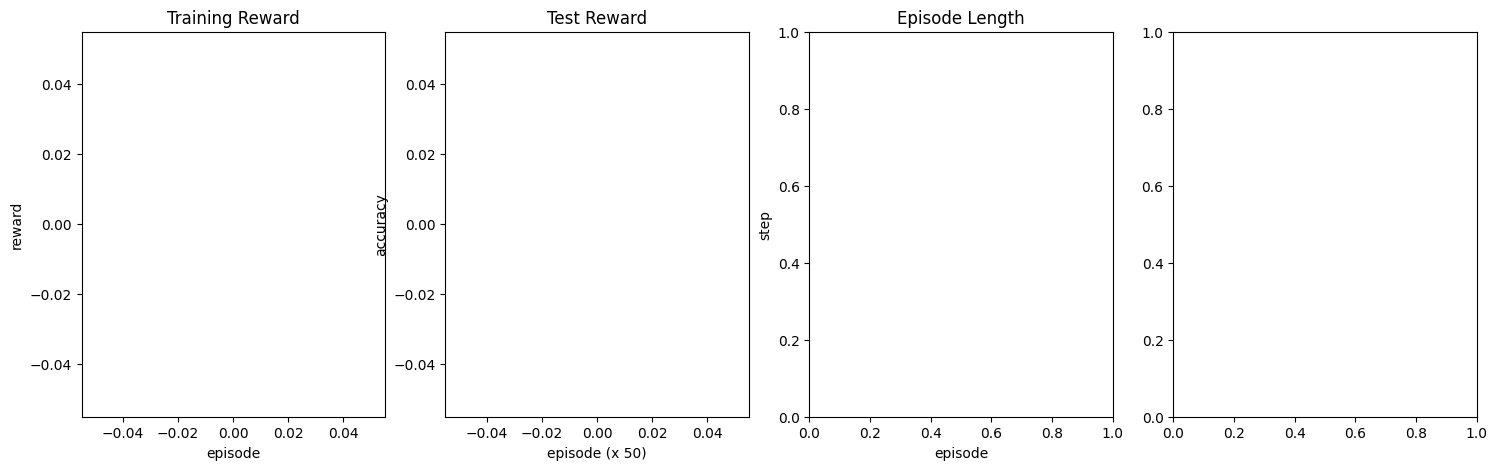

In [41]:
rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards)), rewards)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies)), accuracies)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

In [ ]:
sum(steps) / len(steps)